In [1]:
from scripts.utils.settings import set_global_seed, get_device
from scripts.utils.data import DriverDrowsinessDataset, visualize_sequence
from scripts.utils.checks import check_dataset_for_nans, check_model_weights, calculate_model_size
from scripts.models.pretrained import VisionTransformerLSTMv1
from scripts.training.adversarial import AdversarialAttack
from scripts.training.loss import FocalLoss
from scripts.training.train import train, evaluate
from scripts.evaluation.report import generate_detailed_classification_report
from scripts.evaluation.viz import plot_training_history

import os
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import timm
from pprint import pprint
avail_pretrained_models = timm.list_models(pretrained=True)
pprint(avail_pretrained_models)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [3]:
ROOT_DIR = "./processed/rgb_face"

# Define enhanced training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate within ±15 degrees - Remove random rotation
    transforms.ColorJitter(  # Introduce variations in brightness, contrast, saturation, and hue
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    # transforms.RandomAffine(degrees=0, translate=(0.25, 0)),
    transforms.ToTensor(),  # Convert to tensor and rescale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define validation and test transforms without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

In [4]:
# Initialize training dataset
train_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="train", 
    transform=train_transform,  # Apply data augmentation for training
    seq_len=16,  # Process sequences of length 16
    padding_value=0.0,  # Use 0.0 to pad incomplete sequences
    default_img_size=224,
    stride=8,
)

# Initialize validation dataset
val_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="val", 
    transform=val_test_transform,  # No augmentation for validation
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

# Initialize test dataset
test_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="test", 
    transform=val_test_transform,  # No augmentation for testing
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

In [5]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

7531 5409 8174


In [6]:
check_dataset_for_nans(train_dataset)
check_dataset_for_nans(val_dataset)
check_dataset_for_nans(test_dataset)

Checking for NaNs in dataset: 100%|██████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.05it/s]


No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.11it/s]


No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset: 100%|██████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.12it/s]

No NaNs or Infs found in the dataset samples checked.


True

Checking for NaNs in dataset:  10%|███▎                             | 10/100 [00:00<00:02, 41.38it/s]

Checking for NaNs in dataset:  15%|████▉                            | 15/100 [00:00<00:02, 42.00it/s]

Checking for NaNs in dataset:  20%|██████▌                          | 20/100 [00:00<00:01, 41.97it/s]

Checking for NaNs in dataset:  25%|████████▎                        | 25/100 [00:00<00:01, 42.04it/s]

Checking for NaNs in dataset:  30%|█████████▉                       | 30/100 [00:00<00:01, 42.38it/s]

Checking for NaNs in dataset:  35%|███████████▌                     | 35/100 [00:00<00:01, 42.39it/s]

Checking for NaNs in dataset:  40%|█████████████▏                   | 40/100 [00:00<00:01, 42.63it/s]

Checking for NaNs in dataset:  45%|██████████████▊                  | 45/100 [00:01<00:01, 43.00it/s]

Checking for NaNs in dataset:  50%|████████████████▌                | 50/100 [00:01<00:01, 42.93it/s]

Checking for NaNs in dataset:  55%|██████████████████▏              | 55/100 [00:01<00:01, 42.72it/s]

Checking for NaNs in dataset:  60%|███████████████████▊             | 60/100 [00:01<00:00, 42.77it/s]

Checking for NaNs in dataset:  65%|█████████████████████▍           | 65/100 [00:01<00:00, 42.42it/s]

Checking for NaNs in dataset:  70%|███████████████████████          | 70/100 [00:01<00:00, 42.39it/s]

Checking for NaNs in dataset:  75%|████████████████████████▊        | 75/100 [00:01<00:00, 42.40it/s]

Checking for NaNs in dataset:  80%|██████████████████████████▍      | 80/100 [00:01<00:00, 42.48it/s]

Checking for NaNs in dataset:  85%|████████████████████████████     | 85/100 [00:02<00:00, 42.42it/s]

Checking for NaNs in dataset:  92%|██████████████████████████████▎  | 92/100 [00:02<00:00, 46.79it/s]

Checking for NaNs in dataset:  97%|████████████████████████████████ | 97/100 [00:02<00:00, 44.91it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]

No NaNs or Infs found in the dataset samples checked.


True

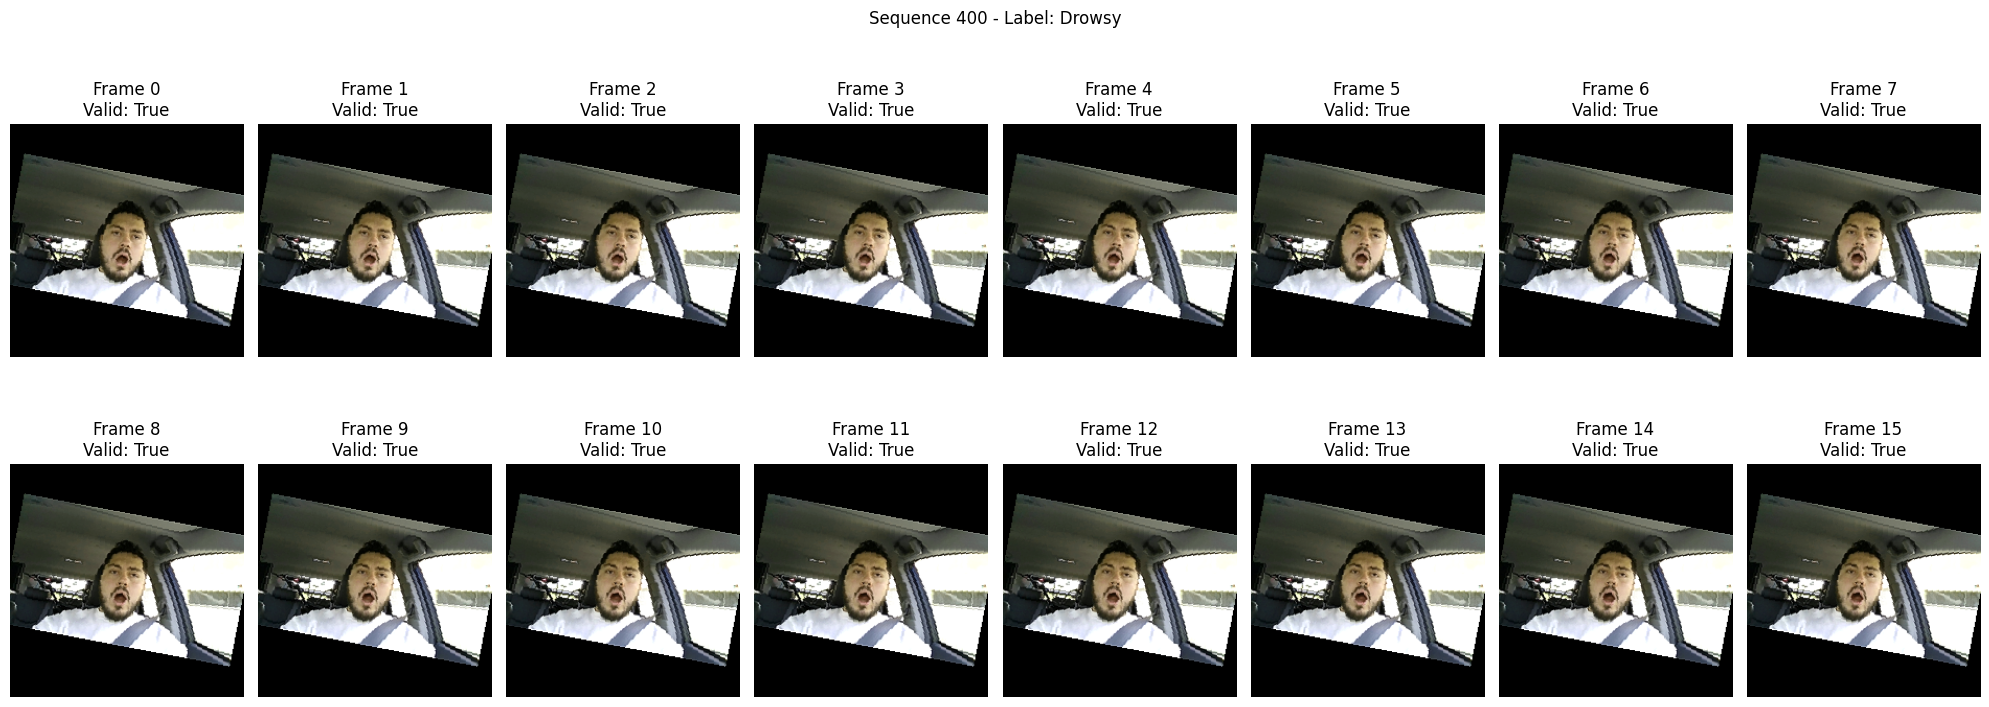

In [7]:
visualize_sequence(train_dataset, idx=400)

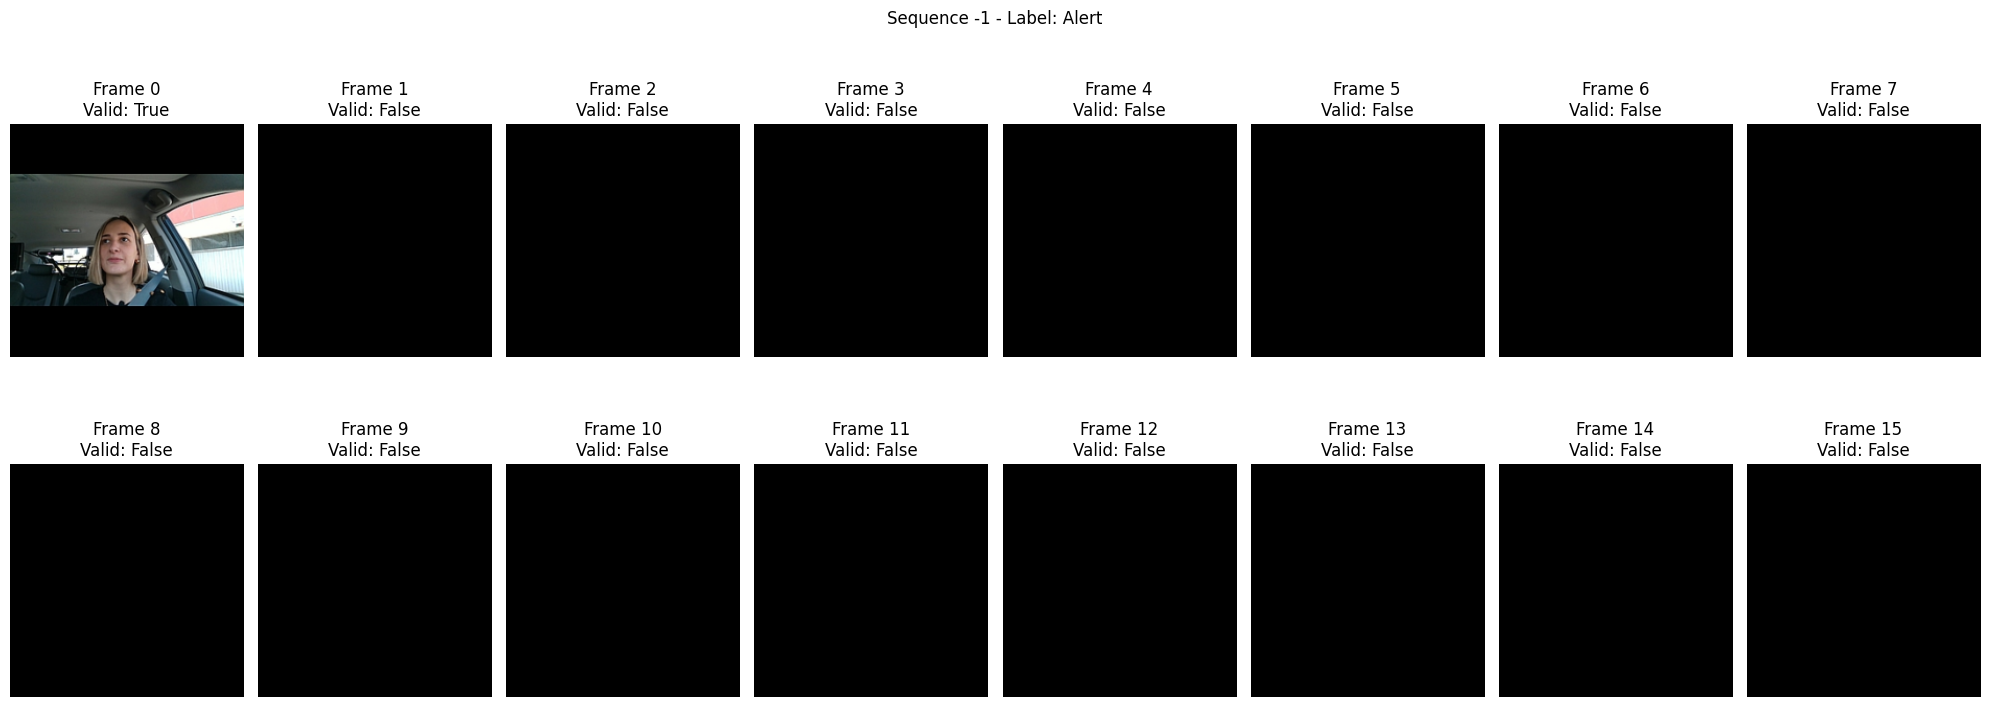

In [8]:
visualize_sequence(test_dataset, idx=-1) 

In [9]:
# Step 1: Extract labels directly from the dataset
labels = np.array(train_dataset.labels)  # Access the labels efficiently

# Step 2: Compute class weights
unique_classes = np.unique(labels)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=unique_classes, 
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights * (1 / class_weights[0])

# Step 3: Map class weights to sample weights
label_to_weight = {label: weight for label, weight in zip(unique_classes, class_weights)}
sample_weights = torch.tensor([label_to_weight[label] for label in labels], dtype=torch.float)

# Step 4: Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Match the total number of samples
    replacement=True  # Replacement ensures balanced sampling
)

print("Class weights:", class_weights)

Class weights: tensor([1.0000, 6.7004])


  1%|▌                                                             | 61/7531 [00:06<07:37, 16.34it/s]

  1%|▌                                                             | 63/7531 [00:06<07:48, 15.93it/s]

  1%|▌                                                             | 65/7531 [00:06<07:45, 16.04it/s]

  1%|▌                                                             | 67/7531 [00:06<07:47, 15.95it/s]

  1%|▌                                                             | 69/7531 [00:06<07:46, 15.98it/s]

  1%|▌                                                             | 71/7531 [00:06<07:48, 15.93it/s]

  1%|▌                                                             | 73/7531 [00:06<07:49, 15.88it/s]

  1%|▌                                                             | 75/7531 [00:06<07:49, 15.90it/s]

  1%|▋                                                             | 77/7531 [00:07<07:49, 15.87it/s]

  1%|▋                                                             | 79/7531 [00:07<07:48, 15.90it/s]

  1%|▋                                                             | 81/7531 [00:07<07:56, 15.64it/s]

  1%|▋                                                             | 83/7531 [00:07<07:51, 15.78it/s]

  1%|▋                                                             | 86/7531 [00:07<07:20, 16.92it/s]

  1%|▋                                                             | 88/7531 [00:07<07:33, 16.42it/s]

  1%|▋                                                             | 90/7531 [00:07<07:37, 16.28it/s]

  1%|▊                                                             | 92/7531 [00:07<07:41, 16.11it/s]

  1%|▊                                                             | 94/7531 [00:08<07:42, 16.09it/s]

  1%|▊                                                             | 96/7531 [00:08<07:40, 16.15it/s]

  1%|▊                                                             | 98/7531 [00:08<07:44, 15.99it/s]

  1%|▊                                                            | 100/7531 [00:08<07:42, 16.07it/s]

  1%|▊                                                            | 102/7531 [00:08<07:46, 15.92it/s]

  1%|▊                                                            | 104/7531 [00:08<07:53, 15.69it/s]

  1%|▊                                                            | 106/7531 [00:08<07:56, 15.59it/s]

  1%|▊                                                            | 108/7531 [00:09<07:57, 15.53it/s]

  1%|▉                                                            | 110/7531 [00:09<07:31, 16.42it/s]

  1%|▉                                                            | 112/7531 [00:09<07:39, 16.15it/s]

  2%|▉                                                            | 114/7531 [00:09<07:46, 15.89it/s]

  2%|▉                                                            | 116/7531 [00:09<07:47, 15.86it/s]

  2%|▉                                                            | 118/7531 [00:09<07:49, 15.77it/s]

  2%|▉                                                            | 120/7531 [00:09<07:56, 15.56it/s]

  2%|▉                                                            | 122/7531 [00:09<07:54, 15.62it/s]

  2%|█                                                            | 124/7531 [00:10<07:55, 15.58it/s]

  2%|█                                                            | 126/7531 [00:10<07:54, 15.62it/s]

  2%|█                                                            | 128/7531 [00:10<07:59, 15.44it/s]

  2%|█                                                            | 130/7531 [00:10<08:00, 15.40it/s]

  2%|█                                                            | 132/7531 [00:10<08:00, 15.40it/s]

  2%|█                                                            | 134/7531 [00:10<07:51, 15.67it/s]

  2%|█                                                            | 136/7531 [00:10<08:03, 15.31it/s]

  2%|█                                                            | 138/7531 [00:10<07:59, 15.42it/s]

  2%|█▏                                                           | 140/7531 [00:11<07:37, 16.17it/s]

  2%|█▏                                                           | 142/7531 [00:11<07:37, 16.17it/s]

  2%|█▏                                                           | 144/7531 [00:11<07:47, 15.80it/s]

  2%|█▏                                                           | 146/7531 [00:11<07:53, 15.59it/s]

  2%|█▏                                                           | 148/7531 [00:11<07:57, 15.46it/s]

  2%|█▏                                                           | 150/7531 [00:11<08:00, 15.36it/s]

  2%|█▏                                                           | 152/7531 [00:11<08:02, 15.29it/s]

  2%|█▏                                                           | 154/7531 [00:11<07:55, 15.53it/s]

  2%|█▎                                                           | 156/7531 [00:12<07:51, 15.65it/s]

  2%|█▎                                                           | 158/7531 [00:12<07:52, 15.59it/s]

  2%|█▎                                                           | 160/7531 [00:12<07:57, 15.43it/s]

  2%|█▎                                                           | 162/7531 [00:12<07:49, 15.68it/s]

  2%|█▎                                                           | 164/7531 [00:12<07:52, 15.58it/s]

  2%|█▎                                                           | 166/7531 [00:12<07:58, 15.39it/s]

  2%|█▎                                                           | 168/7531 [00:12<07:42, 15.91it/s]

  2%|█▍                                                           | 170/7531 [00:12<07:15, 16.92it/s]

  2%|█▍                                                           | 172/7531 [00:13<07:19, 16.73it/s]

  2%|█▍                                                           | 174/7531 [00:13<07:32, 16.26it/s]

  2%|█▍                                                           | 176/7531 [00:13<07:46, 15.77it/s]

  2%|█▍                                                           | 178/7531 [00:13<07:48, 15.69it/s]

  2%|█▍                                                           | 180/7531 [00:13<07:49, 15.65it/s]

  2%|█▍                                                           | 182/7531 [00:13<07:52, 15.57it/s]

  2%|█▍                                                           | 184/7531 [00:13<07:50, 15.62it/s]

  2%|█▌                                                           | 186/7531 [00:13<07:37, 16.05it/s]

  2%|█▌                                                           | 188/7531 [00:14<07:39, 15.98it/s]

  3%|█▌                                                           | 190/7531 [00:14<07:37, 16.03it/s]

  3%|█▌                                                           | 192/7531 [00:14<09:36, 12.73it/s]

  3%|█▌                                                           | 194/7531 [00:14<09:21, 13.08it/s]

  3%|█▌                                                           | 196/7531 [00:14<09:10, 13.33it/s]

  3%|█▌                                                           | 198/7531 [00:14<09:48, 12.46it/s]

  3%|█▌                                                           | 200/7531 [00:15<11:10, 10.93it/s]

  3%|█▋                                                           | 202/7531 [00:15<11:45, 10.39it/s]

  3%|█▋                                                           | 204/7531 [00:15<12:48,  9.53it/s]

  3%|█▋                                                           | 206/7531 [00:15<11:15, 10.84it/s]

  3%|█▋                                                           | 208/7531 [00:15<10:12, 11.96it/s]

  3%|█▋                                                           | 210/7531 [00:16<11:01, 11.07it/s]

  3%|█▋                                                           | 213/7531 [00:16<09:05, 13.42it/s]

  3%|█▋                                                           | 215/7531 [00:16<09:55, 12.28it/s]

  3%|█▊                                                           | 217/7531 [00:16<10:52, 11.21it/s]

  3%|█▊                                                           | 219/7531 [00:16<09:56, 12.25it/s]

  3%|█▊                                                           | 221/7531 [00:16<09:12, 13.22it/s]

  3%|█▊                                                           | 223/7531 [00:17<08:47, 13.84it/s]

  3%|█▊                                                           | 225/7531 [00:17<08:29, 14.35it/s]

  3%|█▊                                                           | 227/7531 [00:17<08:08, 14.96it/s]

  3%|█▊                                                           | 229/7531 [00:17<07:58, 15.26it/s]

  3%|█▊                                                           | 231/7531 [00:17<07:56, 15.31it/s]

  3%|█▉                                                           | 234/7531 [00:17<07:13, 16.83it/s]

  3%|█▉                                                           | 236/7531 [00:17<07:16, 16.71it/s]

  3%|█▉                                                           | 238/7531 [00:17<07:27, 16.30it/s]

  3%|█▉                                                           | 240/7531 [00:18<07:31, 16.13it/s]

  3%|█▉                                                           | 242/7531 [00:18<07:41, 15.81it/s]

  3%|█▉                                                           | 244/7531 [00:18<07:46, 15.64it/s]

  3%|█▉                                                           | 246/7531 [00:18<07:36, 15.95it/s]

  3%|██                                                           | 249/7531 [00:18<07:12, 16.83it/s]

  3%|██                                                           | 251/7531 [00:18<07:23, 16.42it/s]

  3%|██                                                           | 253/7531 [00:18<07:28, 16.22it/s]

  3%|██                                                           | 255/7531 [00:18<07:44, 15.67it/s]

  3%|██                                                           | 257/7531 [00:19<07:49, 15.50it/s]

  3%|██                                                           | 259/7531 [00:19<07:52, 15.39it/s]

  3%|██                                                           | 261/7531 [00:19<10:04, 12.03it/s]

  3%|██▏                                                          | 263/7531 [00:19<09:34, 12.65it/s]

  4%|██▏                                                          | 265/7531 [00:19<09:06, 13.28it/s]

  4%|██▏                                                          | 267/7531 [00:19<08:46, 13.80it/s]

  4%|██▏                                                          | 269/7531 [00:20<08:02, 15.04it/s]

  4%|██▏                                                          | 271/7531 [00:20<08:04, 14.98it/s]

  4%|██▏                                                          | 273/7531 [00:20<08:07, 14.90it/s]

  4%|██▏                                                          | 275/7531 [00:20<08:05, 14.95it/s]

  4%|██▏                                                          | 277/7531 [00:20<08:03, 15.00it/s]

  4%|██▎                                                          | 279/7531 [00:20<08:12, 14.71it/s]

  4%|██▎                                                          | 281/7531 [00:20<08:20, 14.49it/s]

  4%|██▎                                                          | 283/7531 [00:20<08:21, 14.45it/s]

  4%|██▎                                                          | 285/7531 [00:21<08:16, 14.59it/s]

  4%|██▎                                                          | 287/7531 [00:21<07:49, 15.42it/s]

  4%|██▎                                                          | 289/7531 [00:21<07:51, 15.37it/s]

  4%|██▎                                                          | 291/7531 [00:21<08:16, 14.60it/s]

  4%|██▎                                                          | 293/7531 [00:21<08:40, 13.92it/s]

  4%|██▍                                                          | 295/7531 [00:21<08:31, 14.14it/s]

  4%|██▍                                                          | 297/7531 [00:21<08:34, 14.06it/s]

  4%|██▍                                                          | 299/7531 [00:22<08:45, 13.76it/s]

  4%|██▍                                                          | 301/7531 [00:22<08:29, 14.20it/s]

  4%|██▍                                                          | 303/7531 [00:22<08:15, 14.60it/s]

  4%|██▍                                                          | 305/7531 [00:22<07:42, 15.62it/s]

  4%|██▍                                                          | 307/7531 [00:22<07:51, 15.31it/s]

  4%|██▌                                                          | 309/7531 [00:22<07:47, 15.45it/s]

  4%|██▌                                                          | 311/7531 [00:22<07:46, 15.47it/s]

  4%|██▌                                                          | 313/7531 [00:23<08:12, 14.66it/s]

  4%|██▌                                                          | 315/7531 [00:23<08:08, 14.78it/s]

  4%|██▌                                                          | 317/7531 [00:23<08:05, 14.87it/s]

  4%|██▌                                                          | 319/7531 [00:23<07:39, 15.69it/s]

  4%|██▌                                                          | 322/7531 [00:23<07:15, 16.54it/s]

  4%|██▌                                                          | 324/7531 [00:23<07:22, 16.27it/s]

  4%|██▋                                                          | 326/7531 [00:23<07:27, 16.11it/s]

  4%|██▋                                                          | 328/7531 [00:23<07:28, 16.07it/s]

  4%|██▋                                                          | 330/7531 [00:24<07:27, 16.10it/s]

  4%|██▋                                                          | 332/7531 [00:24<07:28, 16.04it/s]

  4%|██▋                                                          | 334/7531 [00:24<07:29, 16.00it/s]

  4%|██▋                                                          | 337/7531 [00:24<07:06, 16.88it/s]

  5%|██▋                                                          | 339/7531 [00:24<07:13, 16.60it/s]

  5%|██▊                                                          | 341/7531 [00:24<07:16, 16.46it/s]

  5%|██▊                                                          | 343/7531 [00:24<07:36, 15.75it/s]

  5%|██▊                                                          | 345/7531 [00:25<07:47, 15.38it/s]

  5%|██▊                                                          | 347/7531 [00:25<07:43, 15.50it/s]

  5%|██▊                                                          | 349/7531 [00:25<07:41, 15.57it/s]

  5%|██▊                                                          | 351/7531 [00:25<07:34, 15.81it/s]

  5%|██▊                                                          | 353/7531 [00:25<07:18, 16.39it/s]

  5%|██▉                                                          | 355/7531 [00:25<07:18, 16.35it/s]

  5%|██▉                                                          | 357/7531 [00:25<07:27, 16.03it/s]

  5%|██▉                                                          | 359/7531 [00:25<07:30, 15.91it/s]

  5%|██▉                                                          | 361/7531 [00:26<07:44, 15.44it/s]

  5%|██▉                                                          | 363/7531 [00:26<07:56, 15.05it/s]

  5%|██▉                                                          | 365/7531 [00:26<07:54, 15.11it/s]

  5%|██▉                                                          | 367/7531 [00:26<07:49, 15.25it/s]

  5%|██▉                                                          | 370/7531 [00:26<07:16, 16.41it/s]

  5%|███                                                          | 372/7531 [00:26<07:23, 16.13it/s]

  5%|███                                                          | 374/7531 [00:26<07:24, 16.11it/s]

  5%|███                                                          | 376/7531 [00:26<07:26, 16.01it/s]

  5%|███                                                          | 378/7531 [00:27<07:49, 15.23it/s]

  5%|███                                                          | 380/7531 [00:27<07:57, 14.96it/s]

  5%|███                                                          | 382/7531 [00:27<07:58, 14.95it/s]

  5%|███                                                          | 384/7531 [00:27<07:50, 15.18it/s]

  5%|███▏                                                         | 386/7531 [00:27<07:47, 15.29it/s]

  5%|███▏                                                         | 388/7531 [00:27<07:44, 15.38it/s]

  5%|███▏                                                         | 390/7531 [00:27<07:41, 15.47it/s]

  5%|███▏                                                         | 392/7531 [00:28<07:43, 15.41it/s]

  5%|███▏                                                         | 394/7531 [00:28<07:13, 16.45it/s]

  5%|███▏                                                         | 396/7531 [00:28<07:20, 16.18it/s]

  5%|███▏                                                         | 398/7531 [00:28<07:38, 15.56it/s]

  5%|███▏                                                         | 400/7531 [00:28<07:31, 15.78it/s]

  5%|███▎                                                         | 402/7531 [00:28<07:25, 16.02it/s]

  5%|███▎                                                         | 404/7531 [00:28<07:42, 15.40it/s]

  5%|███▎                                                         | 406/7531 [00:28<07:48, 15.20it/s]

  5%|███▎                                                         | 408/7531 [00:29<07:41, 15.43it/s]

  5%|███▎                                                         | 410/7531 [00:29<07:51, 15.11it/s]

  5%|███▎                                                         | 412/7531 [00:29<07:27, 15.92it/s]

  6%|███▎                                                         | 415/7531 [00:29<07:06, 16.67it/s]

  6%|███▍                                                         | 417/7531 [00:29<07:11, 16.50it/s]

  6%|███▍                                                         | 419/7531 [00:29<07:16, 16.31it/s]

  6%|███▍                                                         | 421/7531 [00:29<07:14, 16.38it/s]

  6%|███▍                                                         | 423/7531 [00:29<07:13, 16.42it/s]

  6%|███▍                                                         | 425/7531 [00:30<07:18, 16.22it/s]

  6%|███▍                                                         | 427/7531 [00:30<07:24, 15.97it/s]

  6%|███▍                                                         | 429/7531 [00:30<07:26, 15.92it/s]

  6%|███▍                                                         | 431/7531 [00:30<07:33, 15.65it/s]

  6%|███▌                                                         | 433/7531 [00:30<07:33, 15.66it/s]

  6%|███▌                                                         | 435/7531 [00:30<07:11, 16.43it/s]

  6%|███▌                                                         | 437/7531 [00:30<07:26, 15.89it/s]

  6%|███▌                                                         | 439/7531 [00:30<07:24, 15.97it/s]

  6%|███▌                                                         | 441/7531 [00:31<07:34, 15.61it/s]

  6%|███▌                                                         | 443/7531 [00:31<07:31, 15.68it/s]

  6%|███▌                                                         | 445/7531 [00:31<07:29, 15.77it/s]

  6%|███▌                                                         | 447/7531 [00:31<07:39, 15.40it/s]

  6%|███▋                                                         | 449/7531 [00:31<07:38, 15.44it/s]

  6%|███▋                                                         | 451/7531 [00:31<07:41, 15.35it/s]

  6%|███▋                                                         | 453/7531 [00:31<07:43, 15.26it/s]

  6%|███▋                                                         | 455/7531 [00:31<07:41, 15.32it/s]

  6%|███▋                                                         | 457/7531 [00:32<07:33, 15.61it/s]

  6%|███▋                                                         | 459/7531 [00:32<07:15, 16.23it/s]

  6%|███▋                                                         | 461/7531 [00:32<07:16, 16.19it/s]

  6%|███▊                                                         | 463/7531 [00:32<07:23, 15.92it/s]

  6%|███▊                                                         | 465/7531 [00:32<07:36, 15.48it/s]

  6%|███▊                                                         | 467/7531 [00:32<07:32, 15.62it/s]

  6%|███▊                                                         | 469/7531 [00:32<07:31, 15.63it/s]

  6%|███▊                                                         | 471/7531 [00:33<07:34, 15.55it/s]

  6%|███▊                                                         | 473/7531 [00:33<07:29, 15.70it/s]

  6%|███▊                                                         | 475/7531 [00:33<07:38, 15.38it/s]

  6%|███▊                                                         | 477/7531 [00:33<07:39, 15.34it/s]

  6%|███▉                                                         | 479/7531 [00:33<07:34, 15.53it/s]

  6%|███▉                                                         | 481/7531 [00:33<07:30, 15.65it/s]

  6%|███▉                                                         | 483/7531 [00:33<07:31, 15.62it/s]

  6%|███▉                                                         | 485/7531 [00:33<07:24, 15.86it/s]

  6%|███▉                                                         | 487/7531 [00:34<07:04, 16.60it/s]

  6%|███▉                                                         | 489/7531 [00:34<07:32, 15.57it/s]

  7%|███▉                                                         | 491/7531 [00:34<07:39, 15.33it/s]

  7%|███▉                                                         | 493/7531 [00:34<07:41, 15.25it/s]

  7%|████                                                         | 495/7531 [00:34<07:37, 15.37it/s]

  7%|████                                                         | 497/7531 [00:34<07:38, 15.35it/s]

  7%|████                                                         | 499/7531 [00:34<07:37, 15.36it/s]

  7%|████                                                         | 501/7531 [00:34<07:37, 15.37it/s]

  7%|████                                                         | 503/7531 [00:35<07:36, 15.40it/s]

  7%|████                                                         | 505/7531 [00:35<07:37, 15.34it/s]

  7%|████                                                         | 507/7531 [00:35<07:36, 15.40it/s]

  7%|████                                                         | 509/7531 [00:35<07:31, 15.55it/s]

  7%|████▏                                                        | 511/7531 [00:35<07:29, 15.61it/s]

  7%|████▏                                                        | 513/7531 [00:35<07:20, 15.94it/s]

  7%|████▏                                                        | 515/7531 [00:35<06:55, 16.90it/s]

  7%|████▏                                                        | 517/7531 [00:35<07:19, 15.96it/s]

  7%|████▏                                                        | 519/7531 [00:36<07:24, 15.77it/s]

  7%|████▏                                                        | 521/7531 [00:36<07:36, 15.35it/s]

  7%|████▏                                                        | 523/7531 [00:36<07:31, 15.52it/s]

  7%|████▎                                                        | 525/7531 [00:36<07:27, 15.64it/s]

  7%|████▎                                                        | 527/7531 [00:36<07:26, 15.69it/s]

  7%|████▎                                                        | 529/7531 [00:36<07:30, 15.53it/s]

  7%|████▎                                                        | 531/7531 [00:36<07:35, 15.37it/s]

  7%|████▎                                                        | 533/7531 [00:36<07:34, 15.41it/s]

  7%|████▎                                                        | 535/7531 [00:37<07:40, 15.19it/s]

  7%|████▎                                                        | 537/7531 [00:37<07:33, 15.44it/s]

  7%|████▎                                                        | 539/7531 [00:37<07:14, 16.08it/s]

  7%|████▍                                                        | 541/7531 [00:37<07:20, 15.85it/s]

  7%|████▍                                                        | 543/7531 [00:37<07:18, 15.94it/s]

  7%|████▍                                                        | 545/7531 [00:37<07:16, 16.01it/s]

  7%|████▍                                                        | 547/7531 [00:37<07:18, 15.92it/s]

  7%|████▍                                                        | 549/7531 [00:37<07:16, 16.00it/s]

  7%|████▍                                                        | 551/7531 [00:38<07:19, 15.89it/s]

  7%|████▍                                                        | 553/7531 [00:38<07:21, 15.81it/s]

  7%|████▍                                                        | 555/7531 [00:38<07:51, 14.79it/s]

  7%|████▌                                                        | 557/7531 [00:38<07:50, 14.84it/s]

  7%|████▌                                                        | 559/7531 [00:38<07:45, 14.98it/s]

  7%|████▌                                                        | 561/7531 [00:38<07:37, 15.23it/s]

  7%|████▌                                                        | 564/7531 [00:38<06:54, 16.82it/s]

  8%|████▌                                                        | 566/7531 [00:39<07:09, 16.23it/s]

  8%|████▌                                                        | 568/7531 [00:39<07:37, 15.23it/s]

  8%|████▌                                                        | 570/7531 [00:39<07:31, 15.41it/s]

  8%|████▋                                                        | 572/7531 [00:39<07:33, 15.34it/s]

  8%|████▋                                                        | 574/7531 [00:39<07:32, 15.38it/s]

  8%|████▋                                                        | 576/7531 [00:39<07:22, 15.74it/s]

  8%|████▋                                                        | 578/7531 [00:39<07:17, 15.88it/s]

  8%|████▋                                                        | 580/7531 [00:39<07:21, 15.76it/s]

  8%|████▋                                                        | 582/7531 [00:40<07:28, 15.49it/s]

  8%|████▋                                                        | 584/7531 [00:40<07:28, 15.50it/s]

  8%|████▊                                                        | 587/7531 [00:40<06:48, 17.00it/s]

  8%|████▊                                                        | 589/7531 [00:40<06:59, 16.53it/s]

  8%|████▊                                                        | 591/7531 [00:40<07:07, 16.23it/s]

  8%|████▊                                                        | 593/7531 [00:40<07:07, 16.25it/s]

  8%|████▊                                                        | 595/7531 [00:40<07:11, 16.06it/s]

  8%|████▊                                                        | 597/7531 [00:41<07:11, 16.07it/s]

  8%|████▊                                                        | 599/7531 [00:41<07:24, 15.60it/s]

  8%|████▊                                                        | 601/7531 [00:41<07:23, 15.63it/s]

  8%|████▉                                                        | 603/7531 [00:41<07:08, 16.18it/s]

  8%|████▉                                                        | 606/7531 [00:41<06:47, 16.99it/s]

  8%|████▉                                                        | 608/7531 [00:41<06:53, 16.75it/s]

  8%|████▉                                                        | 610/7531 [00:41<07:09, 16.10it/s]

  8%|████▉                                                        | 612/7531 [00:41<07:15, 15.88it/s]

  8%|████▉                                                        | 614/7531 [00:42<07:15, 15.87it/s]

  8%|████▉                                                        | 616/7531 [00:42<07:29, 15.38it/s]

  8%|█████                                                        | 618/7531 [00:42<07:24, 15.56it/s]

  8%|█████                                                        | 620/7531 [00:42<07:32, 15.27it/s]

  8%|█████                                                        | 622/7531 [00:42<07:25, 15.50it/s]

  8%|█████                                                        | 624/7531 [00:42<07:18, 15.75it/s]

  8%|█████                                                        | 626/7531 [00:42<07:12, 15.97it/s]

  8%|█████                                                        | 628/7531 [00:42<07:11, 15.99it/s]

  8%|█████                                                        | 630/7531 [00:43<07:08, 16.09it/s]

  8%|█████                                                        | 632/7531 [00:43<06:43, 17.08it/s]

  8%|█████▏                                                       | 634/7531 [00:43<06:56, 16.56it/s]

  8%|█████▏                                                       | 636/7531 [00:43<07:03, 16.27it/s]

  8%|█████▏                                                       | 638/7531 [00:43<07:02, 16.30it/s]

  8%|█████▏                                                       | 640/7531 [00:43<07:11, 15.97it/s]

  9%|█████▏                                                       | 642/7531 [00:43<07:10, 15.99it/s]

  9%|█████▏                                                       | 644/7531 [00:43<07:11, 15.95it/s]

  9%|█████▏                                                       | 646/7531 [00:44<07:27, 15.38it/s]

  9%|█████▏                                                       | 648/7531 [00:44<07:30, 15.29it/s]

  9%|█████▎                                                       | 650/7531 [00:44<07:32, 15.22it/s]

  9%|█████▎                                                       | 652/7531 [00:44<07:23, 15.50it/s]

  9%|█████▎                                                       | 654/7531 [00:44<07:20, 15.60it/s]

  9%|█████▎                                                       | 656/7531 [00:44<07:04, 16.20it/s]

  9%|█████▎                                                       | 658/7531 [00:44<06:40, 17.14it/s]

  9%|█████▎                                                       | 660/7531 [00:44<07:02, 16.26it/s]

  9%|█████▎                                                       | 662/7531 [00:45<07:08, 16.04it/s]

  9%|█████▍                                                       | 664/7531 [00:45<07:06, 16.10it/s]

  9%|█████▍                                                       | 666/7531 [00:45<07:13, 15.83it/s]

  9%|█████▍                                                       | 668/7531 [00:45<07:17, 15.68it/s]

  9%|█████▍                                                       | 670/7531 [00:45<07:18, 15.64it/s]

  9%|█████▍                                                       | 672/7531 [00:45<07:16, 15.70it/s]

  9%|█████▍                                                       | 674/7531 [00:45<07:17, 15.67it/s]

  9%|█████▍                                                       | 676/7531 [00:45<07:02, 16.24it/s]

  9%|█████▍                                                       | 678/7531 [00:46<07:03, 16.18it/s]

  9%|█████▌                                                       | 680/7531 [00:46<07:29, 15.23it/s]

  9%|█████▌                                                       | 682/7531 [00:46<07:28, 15.26it/s]

  9%|█████▌                                                       | 684/7531 [00:46<07:25, 15.36it/s]

  9%|█████▌                                                       | 686/7531 [00:46<07:27, 15.29it/s]

  9%|█████▌                                                       | 688/7531 [00:46<07:21, 15.48it/s]

  9%|█████▌                                                       | 690/7531 [00:46<07:19, 15.56it/s]

  9%|█████▌                                                       | 692/7531 [00:47<07:23, 15.41it/s]

  9%|█████▋                                                       | 695/7531 [00:47<06:57, 16.38it/s]

  9%|█████▋                                                       | 697/7531 [00:47<07:09, 15.93it/s]

  9%|█████▋                                                       | 699/7531 [00:47<07:14, 15.72it/s]

  9%|█████▋                                                       | 701/7531 [00:47<07:17, 15.61it/s]

  9%|█████▋                                                       | 703/7531 [00:47<07:22, 15.44it/s]

  9%|█████▋                                                       | 705/7531 [00:47<07:23, 15.41it/s]

  9%|█████▋                                                       | 707/7531 [00:47<07:23, 15.38it/s]

  9%|█████▋                                                       | 709/7531 [00:48<07:26, 15.29it/s]

  9%|█████▊                                                       | 711/7531 [00:48<07:26, 15.29it/s]

  9%|█████▊                                                       | 713/7531 [00:48<07:14, 15.68it/s]

  9%|█████▊                                                       | 715/7531 [00:48<06:52, 16.52it/s]

 10%|█████▊                                                       | 717/7531 [00:48<07:09, 15.86it/s]

 10%|█████▊                                                       | 719/7531 [00:48<07:11, 15.77it/s]

 10%|█████▊                                                       | 721/7531 [00:48<07:11, 15.80it/s]

 10%|█████▊                                                       | 723/7531 [00:49<07:16, 15.59it/s]

 10%|█████▊                                                       | 725/7531 [00:49<07:18, 15.52it/s]

 10%|█████▉                                                       | 727/7531 [00:49<07:25, 15.28it/s]

 10%|█████▉                                                       | 729/7531 [00:49<07:20, 15.44it/s]

 10%|█████▉                                                       | 731/7531 [00:49<07:16, 15.56it/s]

 10%|█████▉                                                       | 733/7531 [00:49<07:07, 15.90it/s]

 10%|█████▉                                                       | 735/7531 [00:49<06:50, 16.55it/s]

 10%|█████▉                                                       | 737/7531 [00:49<07:11, 15.74it/s]

 10%|█████▉                                                       | 739/7531 [00:50<07:09, 15.81it/s]

 10%|██████                                                       | 741/7531 [00:50<07:20, 15.41it/s]

 10%|██████                                                       | 743/7531 [00:50<07:22, 15.34it/s]

 10%|██████                                                       | 745/7531 [00:50<07:15, 15.56it/s]

 10%|██████                                                       | 747/7531 [00:50<07:20, 15.42it/s]

 10%|██████                                                       | 749/7531 [00:50<07:20, 15.38it/s]

 10%|██████                                                       | 751/7531 [00:50<07:15, 15.57it/s]

 10%|██████                                                       | 753/7531 [00:50<07:20, 15.39it/s]

 10%|██████                                                       | 755/7531 [00:51<07:24, 15.24it/s]

 10%|██████▏                                                      | 757/7531 [00:51<07:08, 15.82it/s]

 10%|██████▏                                                      | 759/7531 [00:51<06:42, 16.84it/s]

 10%|██████▏                                                      | 761/7531 [00:51<07:06, 15.88it/s]

 10%|██████▏                                                      | 763/7531 [00:51<07:11, 15.69it/s]

 10%|██████▏                                                      | 765/7531 [00:51<07:20, 15.35it/s]

 10%|██████▏                                                      | 767/7531 [00:51<07:15, 15.53it/s]

 10%|██████▏                                                      | 769/7531 [00:51<07:15, 15.53it/s]

 10%|██████▏                                                      | 771/7531 [00:52<07:13, 15.60it/s]

 10%|██████▎                                                      | 773/7531 [00:52<07:14, 15.55it/s]

 10%|██████▎                                                      | 775/7531 [00:52<07:16, 15.47it/s]

 10%|██████▎                                                      | 777/7531 [00:52<06:50, 16.44it/s]

 10%|██████▎                                                      | 779/7531 [00:52<07:11, 15.66it/s]

 10%|██████▎                                                      | 781/7531 [00:52<07:13, 15.55it/s]

 10%|██████▎                                                      | 783/7531 [00:52<07:14, 15.51it/s]

 10%|██████▎                                                      | 785/7531 [00:52<07:39, 14.69it/s]

 10%|██████▎                                                      | 787/7531 [00:53<07:34, 14.84it/s]

 10%|██████▍                                                      | 789/7531 [00:53<07:28, 15.04it/s]

 11%|██████▍                                                      | 791/7531 [00:53<07:25, 15.13it/s]

 11%|██████▍                                                      | 793/7531 [00:53<07:21, 15.26it/s]

 11%|██████▍                                                      | 795/7531 [00:53<07:22, 15.22it/s]

 11%|██████▍                                                      | 797/7531 [00:53<07:00, 16.01it/s]

 11%|██████▍                                                      | 799/7531 [00:53<06:36, 16.99it/s]

 11%|██████▍                                                      | 801/7531 [00:53<06:50, 16.38it/s]

 11%|██████▌                                                      | 803/7531 [00:54<07:01, 15.98it/s]

 11%|██████▌                                                      | 805/7531 [00:54<07:01, 15.97it/s]

 11%|██████▌                                                      | 807/7531 [00:54<07:10, 15.61it/s]

 11%|██████▌                                                      | 809/7531 [00:54<07:09, 15.65it/s]

 11%|██████▌                                                      | 811/7531 [00:54<07:08, 15.70it/s]

 11%|██████▌                                                      | 813/7531 [00:54<07:08, 15.66it/s]

 11%|██████▌                                                      | 815/7531 [00:54<07:09, 15.65it/s]

 11%|██████▌                                                      | 817/7531 [00:55<07:09, 15.63it/s]

 11%|██████▋                                                      | 819/7531 [00:55<06:52, 16.26it/s]

 11%|██████▋                                                      | 821/7531 [00:55<06:58, 16.03it/s]

 11%|██████▋                                                      | 823/7531 [00:55<07:07, 15.70it/s]

 11%|██████▋                                                      | 825/7531 [00:55<07:11, 15.53it/s]

 11%|██████▋                                                      | 827/7531 [00:55<07:16, 15.37it/s]

 11%|██████▋                                                      | 829/7531 [00:55<07:17, 15.30it/s]

 11%|██████▋                                                      | 831/7531 [00:55<07:13, 15.44it/s]

 11%|██████▋                                                      | 833/7531 [00:56<07:15, 15.39it/s]

 11%|██████▊                                                      | 835/7531 [00:56<07:00, 15.91it/s]

 11%|██████▊                                                      | 838/7531 [00:56<06:37, 16.82it/s]

 11%|██████▊                                                      | 840/7531 [00:56<06:48, 16.39it/s]

 11%|██████▊                                                      | 842/7531 [00:56<06:49, 16.35it/s]

 11%|██████▊                                                      | 844/7531 [00:56<06:54, 16.15it/s]

 11%|██████▊                                                      | 846/7531 [00:56<07:00, 15.91it/s]

 11%|██████▊                                                      | 848/7531 [00:56<06:58, 15.96it/s]

 11%|██████▉                                                      | 850/7531 [00:57<07:06, 15.66it/s]

 11%|██████▉                                                      | 852/7531 [00:57<07:11, 15.49it/s]

 11%|██████▉                                                      | 854/7531 [00:57<07:10, 15.51it/s]

 11%|██████▉                                                      | 856/7531 [00:57<07:12, 15.44it/s]

 11%|██████▉                                                      | 858/7531 [00:57<06:46, 16.41it/s]

 11%|██████▉                                                      | 860/7531 [00:57<07:01, 15.84it/s]

 11%|██████▉                                                      | 862/7531 [00:57<07:02, 15.79it/s]

 11%|██████▉                                                      | 864/7531 [00:57<07:01, 15.81it/s]

 11%|███████                                                      | 866/7531 [00:58<07:00, 15.86it/s]

 12%|███████                                                      | 868/7531 [00:58<07:01, 15.81it/s]

 12%|███████                                                      | 870/7531 [00:58<07:05, 15.65it/s]

 12%|███████                                                      | 872/7531 [00:58<07:00, 15.82it/s]

 12%|███████                                                      | 874/7531 [00:58<07:00, 15.85it/s]

 12%|███████                                                      | 876/7531 [00:58<07:09, 15.49it/s]

 12%|███████                                                      | 878/7531 [00:58<07:12, 15.38it/s]

 12%|███████▏                                                     | 880/7531 [00:59<07:09, 15.50it/s]

 12%|███████▏                                                     | 882/7531 [00:59<06:49, 16.23it/s]

 12%|███████▏                                                     | 884/7531 [00:59<06:53, 16.08it/s]

 12%|███████▏                                                     | 886/7531 [00:59<06:59, 15.84it/s]

 12%|███████▏                                                     | 888/7531 [00:59<07:07, 15.52it/s]

 12%|███████▏                                                     | 890/7531 [00:59<07:12, 15.36it/s]

 12%|███████▏                                                     | 892/7531 [00:59<07:13, 15.32it/s]

 12%|███████▏                                                     | 894/7531 [00:59<07:13, 15.31it/s]

 12%|███████▎                                                     | 896/7531 [01:00<07:06, 15.57it/s]

 12%|███████▎                                                     | 898/7531 [01:00<07:03, 15.65it/s]

 12%|███████▎                                                     | 900/7531 [01:00<07:03, 15.65it/s]

 12%|███████▎                                                     | 903/7531 [01:00<06:48, 16.23it/s]

 12%|███████▎                                                     | 905/7531 [01:00<06:56, 15.91it/s]

 12%|███████▎                                                     | 907/7531 [01:00<06:58, 15.82it/s]

 12%|███████▎                                                     | 909/7531 [01:00<07:02, 15.67it/s]

 12%|███████▍                                                     | 911/7531 [01:00<06:58, 15.83it/s]

 12%|███████▍                                                     | 913/7531 [01:01<06:56, 15.89it/s]

 12%|███████▍                                                     | 915/7531 [01:01<07:12, 15.31it/s]

 12%|███████▍                                                     | 917/7531 [01:01<07:13, 15.26it/s]

 12%|███████▍                                                     | 919/7531 [01:01<07:18, 15.09it/s]

 12%|███████▍                                                     | 921/7531 [01:01<07:11, 15.32it/s]

 12%|███████▍                                                     | 923/7531 [01:01<07:02, 15.63it/s]

 12%|███████▍                                                     | 925/7531 [01:01<07:03, 15.59it/s]

 12%|███████▌                                                     | 927/7531 [01:02<07:08, 15.42it/s]

 12%|███████▌                                                     | 929/7531 [01:02<07:02, 15.61it/s]

 12%|███████▌                                                     | 931/7531 [01:02<06:47, 16.20it/s]

 12%|███████▌                                                     | 933/7531 [01:02<06:51, 16.03it/s]

 12%|███████▌                                                     | 935/7531 [01:02<06:53, 15.97it/s]

 12%|███████▌                                                     | 937/7531 [01:02<06:57, 15.80it/s]

 12%|███████▌                                                     | 939/7531 [01:02<07:02, 15.60it/s]

 12%|███████▌                                                     | 941/7531 [01:02<07:06, 15.44it/s]

 13%|███████▋                                                     | 943/7531 [01:03<07:00, 15.67it/s]

 13%|███████▋                                                     | 945/7531 [01:03<06:58, 15.74it/s]

 13%|███████▋                                                     | 947/7531 [01:03<07:01, 15.62it/s]

 13%|███████▋                                                     | 949/7531 [01:03<07:01, 15.61it/s]

 13%|███████▋                                                     | 952/7531 [01:03<06:39, 16.47it/s]

 13%|███████▋                                                     | 954/7531 [01:03<06:54, 15.89it/s]

 13%|███████▋                                                     | 956/7531 [01:03<07:01, 15.61it/s]

 13%|███████▊                                                     | 958/7531 [01:03<07:03, 15.54it/s]

 13%|███████▊                                                     | 960/7531 [01:04<07:05, 15.45it/s]

 13%|███████▊                                                     | 962/7531 [01:04<07:02, 15.55it/s]

 13%|███████▊                                                     | 964/7531 [01:04<06:58, 15.67it/s]

 13%|███████▊                                                     | 966/7531 [01:04<06:59, 15.65it/s]

 13%|███████▊                                                     | 968/7531 [01:04<07:00, 15.61it/s]

 13%|███████▊                                                     | 970/7531 [01:04<06:55, 15.79it/s]

 13%|███████▊                                                     | 972/7531 [01:04<06:58, 15.67it/s]

 13%|███████▉                                                     | 974/7531 [01:05<07:02, 15.53it/s]

 13%|███████▉                                                     | 976/7531 [01:05<07:01, 15.55it/s]

 13%|███████▉                                                     | 979/7531 [01:05<06:43, 16.22it/s]

 13%|███████▉                                                     | 981/7531 [01:05<06:55, 15.77it/s]

 13%|███████▉                                                     | 983/7531 [01:05<07:06, 15.35it/s]

 13%|███████▉                                                     | 985/7531 [01:05<07:04, 15.43it/s]

 13%|███████▉                                                     | 987/7531 [01:05<07:00, 15.56it/s]

 13%|████████                                                     | 989/7531 [01:05<07:08, 15.27it/s]

 13%|████████                                                     | 991/7531 [01:06<07:04, 15.39it/s]

 13%|████████                                                     | 993/7531 [01:06<07:00, 15.56it/s]

 13%|████████                                                     | 995/7531 [01:06<06:56, 15.68it/s]

 13%|████████                                                     | 997/7531 [01:06<07:02, 15.46it/s]

 13%|████████                                                     | 999/7531 [01:06<06:59, 15.58it/s]

 13%|███████▉                                                    | 1001/7531 [01:06<06:59, 15.57it/s]

 13%|███████▉                                                    | 1003/7531 [01:06<06:57, 15.64it/s]

 13%|████████                                                    | 1005/7531 [01:06<06:57, 15.61it/s]

 13%|████████                                                    | 1007/7531 [01:07<06:58, 15.58it/s]

 13%|████████                                                    | 1009/7531 [01:07<06:57, 15.61it/s]

 13%|████████                                                    | 1011/7531 [01:07<06:57, 15.62it/s]

 13%|████████                                                    | 1013/7531 [01:07<07:08, 15.20it/s]

 13%|████████                                                    | 1015/7531 [01:07<07:05, 15.32it/s]

 14%|████████                                                    | 1017/7531 [01:07<07:07, 15.22it/s]

 14%|████████                                                    | 1019/7531 [01:07<07:05, 15.31it/s]

 14%|████████▏                                                   | 1021/7531 [01:08<07:02, 15.41it/s]

 14%|████████▏                                                   | 1023/7531 [01:08<06:57, 15.58it/s]

 14%|████████▏                                                   | 1025/7531 [01:08<06:54, 15.68it/s]

 14%|████████▏                                                   | 1027/7531 [01:08<06:56, 15.62it/s]

 14%|████████▏                                                   | 1029/7531 [01:08<06:54, 15.69it/s]

 14%|████████▏                                                   | 1031/7531 [01:08<07:01, 15.41it/s]

 14%|████████▏                                                   | 1033/7531 [01:08<07:01, 15.40it/s]

 14%|████████▏                                                   | 1035/7531 [01:08<07:00, 15.45it/s]

 14%|████████▎                                                   | 1037/7531 [01:09<07:01, 15.40it/s]

 14%|████████▎                                                   | 1039/7531 [01:09<06:56, 15.57it/s]

 14%|████████▎                                                   | 1041/7531 [01:09<06:56, 15.58it/s]

 14%|████████▎                                                   | 1043/7531 [01:09<07:03, 15.33it/s]

 14%|████████▎                                                   | 1045/7531 [01:09<07:03, 15.31it/s]

 14%|████████▎                                                   | 1047/7531 [01:09<07:01, 15.39it/s]

 14%|████████▎                                                   | 1049/7531 [01:09<06:59, 15.47it/s]

 14%|████████▎                                                   | 1051/7531 [01:09<06:59, 15.46it/s]

 14%|████████▍                                                   | 1053/7531 [01:10<07:06, 15.20it/s]

 14%|████████▍                                                   | 1055/7531 [01:10<07:15, 14.87it/s]

 14%|████████▍                                                   | 1057/7531 [01:10<07:15, 14.87it/s]

 14%|████████▍                                                   | 1059/7531 [01:10<07:04, 15.25it/s]

 14%|████████▍                                                   | 1061/7531 [01:10<07:04, 15.26it/s]

 14%|████████▍                                                   | 1063/7531 [01:10<06:58, 15.44it/s]

 14%|████████▍                                                   | 1065/7531 [01:10<07:02, 15.31it/s]

 14%|████████▌                                                   | 1067/7531 [01:11<07:01, 15.33it/s]

 14%|████████▌                                                   | 1069/7531 [01:11<07:06, 15.17it/s]

 14%|████████▌                                                   | 1071/7531 [01:11<07:01, 15.31it/s]

 14%|████████▌                                                   | 1073/7531 [01:11<06:53, 15.60it/s]

 14%|████████▌                                                   | 1075/7531 [01:11<06:59, 15.41it/s]

 14%|████████▌                                                   | 1077/7531 [01:11<07:04, 15.19it/s]

 14%|████████▌                                                   | 1079/7531 [01:11<07:00, 15.36it/s]

 14%|████████▌                                                   | 1081/7531 [01:11<06:57, 15.47it/s]

 14%|████████▋                                                   | 1083/7531 [01:12<06:55, 15.50it/s]

 14%|████████▋                                                   | 1085/7531 [01:12<06:53, 15.58it/s]

 14%|████████▋                                                   | 1087/7531 [01:12<06:57, 15.43it/s]

 14%|████████▋                                                   | 1089/7531 [01:12<07:05, 15.12it/s]

 14%|████████▋                                                   | 1091/7531 [01:12<07:07, 15.08it/s]

 15%|████████▋                                                   | 1093/7531 [01:12<07:14, 14.81it/s]

 15%|████████▋                                                   | 1095/7531 [01:12<07:09, 14.98it/s]

 15%|████████▋                                                   | 1097/7531 [01:13<07:13, 14.84it/s]

 15%|████████▊                                                   | 1099/7531 [01:13<07:03, 15.18it/s]

 15%|████████▊                                                   | 1101/7531 [01:13<06:55, 15.46it/s]

 15%|████████▊                                                   | 1103/7531 [01:13<07:05, 15.12it/s]

 15%|████████▊                                                   | 1105/7531 [01:13<07:00, 15.27it/s]

 15%|████████▊                                                   | 1107/7531 [01:13<07:00, 15.29it/s]

 15%|████████▊                                                   | 1109/7531 [01:13<07:00, 15.28it/s]

 15%|████████▊                                                   | 1111/7531 [01:13<06:54, 15.47it/s]

 15%|████████▊                                                   | 1113/7531 [01:14<06:56, 15.41it/s]

 15%|████████▉                                                   | 1115/7531 [01:14<06:57, 15.38it/s]

 15%|████████▉                                                   | 1117/7531 [01:14<06:52, 15.56it/s]

 15%|████████▉                                                   | 1119/7531 [01:14<06:50, 15.62it/s]

 15%|████████▉                                                   | 1121/7531 [01:14<06:49, 15.66it/s]

 15%|████████▉                                                   | 1123/7531 [01:14<06:49, 15.65it/s]

 15%|████████▉                                                   | 1125/7531 [01:14<06:52, 15.54it/s]

 15%|████████▉                                                   | 1127/7531 [01:14<06:50, 15.60it/s]

 15%|████████▉                                                   | 1129/7531 [01:15<07:00, 15.21it/s]

 15%|█████████                                                   | 1131/7531 [01:15<07:04, 15.09it/s]

 15%|█████████                                                   | 1133/7531 [01:15<07:02, 15.16it/s]

 15%|█████████                                                   | 1135/7531 [01:15<07:01, 15.18it/s]

 15%|█████████                                                   | 1137/7531 [01:15<07:01, 15.18it/s]

 15%|█████████                                                   | 1139/7531 [01:15<06:59, 15.25it/s]

 15%|█████████                                                   | 1141/7531 [01:15<07:02, 15.12it/s]

 15%|█████████                                                   | 1143/7531 [01:16<07:12, 14.76it/s]

 15%|█████████                                                   | 1145/7531 [01:16<07:02, 15.12it/s]

 15%|█████████▏                                                  | 1147/7531 [01:16<06:58, 15.26it/s]

 15%|█████████▏                                                  | 1150/7531 [01:16<06:31, 16.29it/s]

 15%|█████████▏                                                  | 1152/7531 [01:16<06:45, 15.73it/s]

 15%|█████████▏                                                  | 1154/7531 [01:16<06:58, 15.23it/s]

 15%|█████████▏                                                  | 1156/7531 [01:16<06:53, 15.41it/s]

 15%|█████████▏                                                  | 1158/7531 [01:16<06:58, 15.23it/s]

 15%|█████████▏                                                  | 1160/7531 [01:17<07:01, 15.10it/s]

 15%|█████████▎                                                  | 1162/7531 [01:17<06:56, 15.28it/s]

 15%|█████████▎                                                  | 1164/7531 [01:17<06:55, 15.32it/s]

 15%|█████████▎                                                  | 1166/7531 [01:17<06:54, 15.35it/s]

 16%|█████████▎                                                  | 1168/7531 [01:17<06:59, 15.18it/s]

 16%|█████████▎                                                  | 1170/7531 [01:17<06:57, 15.22it/s]

 16%|█████████▎                                                  | 1172/7531 [01:17<06:52, 15.40it/s]

 16%|█████████▎                                                  | 1174/7531 [01:18<06:51, 15.46it/s]

 16%|█████████▎                                                  | 1176/7531 [01:18<06:44, 15.70it/s]

 16%|█████████▍                                                  | 1178/7531 [01:18<06:44, 15.70it/s]

 16%|█████████▍                                                  | 1180/7531 [01:18<06:43, 15.74it/s]

 16%|█████████▍                                                  | 1182/7531 [01:18<06:41, 15.83it/s]

 16%|█████████▍                                                  | 1184/7531 [01:18<06:42, 15.76it/s]

 16%|█████████▍                                                  | 1186/7531 [01:18<06:47, 15.58it/s]

 16%|█████████▍                                                  | 1188/7531 [01:18<06:49, 15.50it/s]

 16%|█████████▍                                                  | 1190/7531 [01:19<06:47, 15.57it/s]

 16%|█████████▍                                                  | 1192/7531 [01:19<06:46, 15.60it/s]

 16%|█████████▌                                                  | 1194/7531 [01:19<06:47, 15.54it/s]

 16%|█████████▌                                                  | 1196/7531 [01:19<06:54, 15.30it/s]

 16%|█████████▌                                                  | 1198/7531 [01:19<06:51, 15.37it/s]

 16%|█████████▌                                                  | 1200/7531 [01:19<06:58, 15.11it/s]

 16%|█████████▌                                                  | 1202/7531 [01:19<07:00, 15.05it/s]

 16%|█████████▌                                                  | 1204/7531 [01:19<06:51, 15.37it/s]

 16%|█████████▌                                                  | 1206/7531 [01:20<06:58, 15.12it/s]

 16%|█████████▌                                                  | 1208/7531 [01:20<07:00, 15.05it/s]

 16%|█████████▋                                                  | 1210/7531 [01:20<07:05, 14.85it/s]

 16%|█████████▋                                                  | 1212/7531 [01:20<07:11, 14.65it/s]

 16%|█████████▋                                                  | 1214/7531 [01:20<07:05, 14.85it/s]

 16%|█████████▋                                                  | 1216/7531 [01:20<07:04, 14.86it/s]

 16%|█████████▋                                                  | 1218/7531 [01:20<06:58, 15.10it/s]

 16%|█████████▋                                                  | 1220/7531 [01:21<06:56, 15.16it/s]

 16%|█████████▋                                                  | 1222/7531 [01:21<06:52, 15.28it/s]

 16%|█████████▊                                                  | 1224/7531 [01:21<06:57, 15.11it/s]

 16%|█████████▊                                                  | 1226/7531 [01:21<06:53, 15.23it/s]

 16%|█████████▊                                                  | 1228/7531 [01:21<06:48, 15.43it/s]

 16%|█████████▊                                                  | 1230/7531 [01:21<06:49, 15.40it/s]

 16%|█████████▊                                                  | 1232/7531 [01:21<06:51, 15.30it/s]

 16%|█████████▊                                                  | 1234/7531 [01:21<06:48, 15.42it/s]

 16%|█████████▊                                                  | 1236/7531 [01:22<06:48, 15.40it/s]

 16%|█████████▊                                                  | 1238/7531 [01:22<06:47, 15.44it/s]

 16%|█████████▉                                                  | 1240/7531 [01:22<06:46, 15.47it/s]

 16%|█████████▉                                                  | 1242/7531 [01:22<06:45, 15.53it/s]

 17%|█████████▉                                                  | 1244/7531 [01:22<06:43, 15.59it/s]

 17%|█████████▉                                                  | 1246/7531 [01:22<06:48, 15.40it/s]

 17%|█████████▉                                                  | 1248/7531 [01:22<06:21, 16.47it/s]

 17%|█████████▉                                                  | 1250/7531 [01:22<06:54, 15.17it/s]

 17%|█████████▉                                                  | 1252/7531 [01:23<06:54, 15.14it/s]

 17%|█████████▉                                                  | 1254/7531 [01:23<06:54, 15.14it/s]

 17%|██████████                                                  | 1256/7531 [01:23<06:57, 15.03it/s]

 17%|██████████                                                  | 1258/7531 [01:23<06:54, 15.14it/s]

 17%|██████████                                                  | 1260/7531 [01:23<06:49, 15.31it/s]

 17%|██████████                                                  | 1262/7531 [01:23<06:51, 15.23it/s]

 17%|██████████                                                  | 1264/7531 [01:23<06:44, 15.50it/s]

 17%|██████████                                                  | 1266/7531 [01:24<06:42, 15.56it/s]

 17%|██████████                                                  | 1268/7531 [01:24<06:51, 15.22it/s]

 17%|██████████                                                  | 1270/7531 [01:24<06:47, 15.37it/s]

 17%|██████████▏                                                 | 1272/7531 [01:24<06:40, 15.62it/s]

 17%|██████████▏                                                 | 1274/7531 [01:24<06:40, 15.64it/s]

 17%|██████████▏                                                 | 1276/7531 [01:24<06:38, 15.69it/s]

 17%|██████████▏                                                 | 1278/7531 [01:24<06:45, 15.40it/s]

 17%|██████████▏                                                 | 1280/7531 [01:24<06:44, 15.45it/s]

 17%|██████████▏                                                 | 1282/7531 [01:25<06:41, 15.55it/s]

 17%|██████████▏                                                 | 1284/7531 [01:25<06:41, 15.54it/s]

 17%|██████████▏                                                 | 1286/7531 [01:25<06:43, 15.49it/s]

 17%|██████████▎                                                 | 1288/7531 [01:25<06:45, 15.41it/s]

 17%|██████████▎                                                 | 1290/7531 [01:25<06:39, 15.60it/s]

 17%|██████████▎                                                 | 1292/7531 [01:25<06:37, 15.70it/s]

 17%|██████████▎                                                 | 1294/7531 [01:25<06:38, 15.67it/s]

 17%|██████████▎                                                 | 1296/7531 [01:25<06:35, 15.76it/s]

 17%|██████████▎                                                 | 1298/7531 [01:26<06:16, 16.55it/s]

 17%|██████████▎                                                 | 1300/7531 [01:26<06:23, 16.25it/s]

 17%|██████████▎                                                 | 1302/7531 [01:26<06:24, 16.21it/s]

 17%|██████████▍                                                 | 1304/7531 [01:26<06:30, 15.93it/s]

 17%|██████████▍                                                 | 1306/7531 [01:26<06:30, 15.94it/s]

 17%|██████████▍                                                 | 1308/7531 [01:26<06:29, 16.00it/s]

 17%|██████████▍                                                 | 1310/7531 [01:26<06:43, 15.42it/s]

 17%|██████████▍                                                 | 1312/7531 [01:26<06:55, 14.97it/s]

 17%|██████████▍                                                 | 1314/7531 [01:27<06:50, 15.13it/s]

 17%|██████████▍                                                 | 1316/7531 [01:27<06:49, 15.16it/s]

 18%|██████████▌                                                 | 1318/7531 [01:27<06:45, 15.31it/s]

 18%|██████████▌                                                 | 1320/7531 [01:27<06:41, 15.46it/s]

 18%|██████████▌                                                 | 1322/7531 [01:27<06:42, 15.42it/s]

 18%|██████████▌                                                 | 1324/7531 [01:27<06:38, 15.58it/s]

 18%|██████████▌                                                 | 1326/7531 [01:27<06:40, 15.50it/s]

 18%|██████████▌                                                 | 1328/7531 [01:27<06:40, 15.47it/s]

 18%|██████████▌                                                 | 1330/7531 [01:28<06:44, 15.34it/s]

 18%|██████████▌                                                 | 1332/7531 [01:28<06:43, 15.35it/s]

 18%|██████████▋                                                 | 1334/7531 [01:28<06:53, 14.99it/s]

 18%|██████████▋                                                 | 1336/7531 [01:28<06:44, 15.30it/s]

 18%|██████████▋                                                 | 1338/7531 [01:28<06:46, 15.23it/s]

 18%|██████████▋                                                 | 1340/7531 [01:28<06:45, 15.26it/s]

 18%|██████████▋                                                 | 1342/7531 [01:28<06:43, 15.32it/s]

 18%|██████████▋                                                 | 1344/7531 [01:29<06:39, 15.49it/s]

 18%|██████████▋                                                 | 1346/7531 [01:29<06:57, 14.80it/s]

 18%|██████████▋                                                 | 1348/7531 [01:29<07:03, 14.62it/s]

 18%|██████████▊                                                 | 1350/7531 [01:29<06:53, 14.95it/s]

 18%|██████████▊                                                 | 1352/7531 [01:29<06:53, 14.94it/s]

 18%|██████████▊                                                 | 1354/7531 [01:29<06:53, 14.95it/s]

 18%|██████████▊                                                 | 1356/7531 [01:29<06:47, 15.15it/s]

 18%|██████████▊                                                 | 1358/7531 [01:29<06:48, 15.11it/s]

 18%|██████████▊                                                 | 1360/7531 [01:30<06:40, 15.39it/s]

 18%|██████████▊                                                 | 1362/7531 [01:30<06:39, 15.44it/s]

 18%|██████████▊                                                 | 1364/7531 [01:30<06:39, 15.44it/s]

 18%|██████████▉                                                 | 1366/7531 [01:30<06:39, 15.44it/s]

 18%|██████████▉                                                 | 1368/7531 [01:30<06:37, 15.52it/s]

 18%|██████████▉                                                 | 1370/7531 [01:30<06:46, 15.16it/s]

 18%|██████████▉                                                 | 1372/7531 [01:30<06:43, 15.26it/s]

 18%|██████████▉                                                 | 1374/7531 [01:31<06:41, 15.32it/s]

 18%|██████████▉                                                 | 1376/7531 [01:31<06:50, 14.99it/s]

 18%|██████████▉                                                 | 1378/7531 [01:31<06:45, 15.18it/s]

 18%|██████████▉                                                 | 1380/7531 [01:31<06:44, 15.20it/s]

 18%|███████████                                                 | 1382/7531 [01:31<06:45, 15.17it/s]

 18%|███████████                                                 | 1384/7531 [01:31<06:47, 15.09it/s]

 18%|███████████                                                 | 1386/7531 [01:31<06:40, 15.33it/s]

 18%|███████████                                                 | 1388/7531 [01:31<06:49, 15.00it/s]

 18%|███████████                                                 | 1390/7531 [01:32<06:48, 15.05it/s]

 18%|███████████                                                 | 1392/7531 [01:32<06:45, 15.13it/s]

 19%|███████████                                                 | 1394/7531 [01:32<06:45, 15.12it/s]

 19%|███████████                                                 | 1396/7531 [01:32<06:38, 15.39it/s]

 19%|███████████▏                                                | 1398/7531 [01:32<06:36, 15.46it/s]

 19%|███████████▏                                                | 1400/7531 [01:32<06:38, 15.37it/s]

 19%|███████████▏                                                | 1402/7531 [01:32<06:38, 15.38it/s]

 19%|███████████▏                                                | 1404/7531 [01:32<06:40, 15.30it/s]

 19%|███████████▏                                                | 1406/7531 [01:33<06:41, 15.25it/s]

 19%|███████████▏                                                | 1408/7531 [01:33<06:39, 15.34it/s]

 19%|███████████▏                                                | 1410/7531 [01:33<06:33, 15.55it/s]

 19%|███████████▏                                                | 1412/7531 [01:33<06:28, 15.75it/s]

 19%|███████████▎                                                | 1414/7531 [01:33<06:26, 15.82it/s]

 19%|███████████▎                                                | 1416/7531 [01:33<06:36, 15.44it/s]

 19%|███████████▎                                                | 1418/7531 [01:33<06:43, 15.14it/s]

 19%|███████████▎                                                | 1420/7531 [01:34<06:42, 15.19it/s]

 19%|███████████▎                                                | 1422/7531 [01:34<06:41, 15.22it/s]

 19%|███████████▎                                                | 1424/7531 [01:34<06:46, 15.01it/s]

 19%|███████████▎                                                | 1426/7531 [01:34<06:58, 14.60it/s]

 19%|███████████▍                                                | 1428/7531 [01:34<06:57, 14.61it/s]

 19%|███████████▍                                                | 1430/7531 [01:34<06:49, 14.89it/s]

 19%|███████████▍                                                | 1432/7531 [01:34<06:51, 14.83it/s]

 19%|███████████▍                                                | 1434/7531 [01:34<06:51, 14.83it/s]

 19%|███████████▍                                                | 1436/7531 [01:35<06:45, 15.02it/s]

 19%|███████████▍                                                | 1438/7531 [01:35<06:49, 14.88it/s]

 19%|███████████▍                                                | 1440/7531 [01:35<06:45, 15.04it/s]

 19%|███████████▍                                                | 1442/7531 [01:35<06:43, 15.09it/s]

 19%|███████████▌                                                | 1444/7531 [01:35<06:40, 15.20it/s]

 19%|███████████▌                                                | 1446/7531 [01:35<06:43, 15.07it/s]

 19%|███████████▌                                                | 1448/7531 [01:35<06:48, 14.90it/s]

 19%|███████████▌                                                | 1450/7531 [01:36<06:46, 14.97it/s]

 19%|███████████▌                                                | 1453/7531 [01:36<06:13, 16.26it/s]

 19%|███████████▌                                                | 1455/7531 [01:36<06:13, 16.28it/s]

 19%|███████████▌                                                | 1457/7531 [01:36<06:18, 16.05it/s]

 19%|███████████▌                                                | 1459/7531 [01:36<06:16, 16.14it/s]

 19%|███████████▋                                                | 1461/7531 [01:36<06:12, 16.31it/s]

 19%|███████████▋                                                | 1463/7531 [01:36<06:14, 16.22it/s]

 19%|███████████▋                                                | 1465/7531 [01:36<06:18, 16.05it/s]

 19%|███████████▋                                                | 1467/7531 [01:37<06:21, 15.91it/s]

 20%|███████████▋                                                | 1469/7531 [01:37<06:23, 15.82it/s]

 20%|███████████▋                                                | 1471/7531 [01:37<06:26, 15.67it/s]

 20%|███████████▋                                                | 1473/7531 [01:37<06:26, 15.66it/s]

 20%|███████████▊                                                | 1475/7531 [01:37<06:26, 15.67it/s]

 20%|███████████▊                                                | 1477/7531 [01:37<06:25, 15.69it/s]

 20%|███████████▊                                                | 1479/7531 [01:37<06:27, 15.60it/s]

 20%|███████████▊                                                | 1481/7531 [01:37<06:26, 15.65it/s]

 20%|███████████▊                                                | 1483/7531 [01:38<06:24, 15.74it/s]

 20%|███████████▊                                                | 1485/7531 [01:38<06:26, 15.64it/s]

 20%|███████████▊                                                | 1487/7531 [01:38<06:27, 15.60it/s]

 20%|███████████▊                                                | 1489/7531 [01:38<06:27, 15.58it/s]

 20%|███████████▉                                                | 1491/7531 [01:38<06:28, 15.55it/s]

 20%|███████████▉                                                | 1493/7531 [01:38<06:24, 15.69it/s]

 20%|███████████▉                                                | 1495/7531 [01:38<06:20, 15.84it/s]

 20%|███████████▉                                                | 1497/7531 [01:38<06:21, 15.80it/s]

 20%|███████████▉                                                | 1499/7531 [01:39<06:27, 15.57it/s]

 20%|███████████▉                                                | 1501/7531 [01:39<06:26, 15.59it/s]

 20%|███████████▉                                                | 1503/7531 [01:39<06:24, 15.67it/s]

 20%|███████████▉                                                | 1505/7531 [01:39<06:31, 15.39it/s]

 20%|████████████                                                | 1507/7531 [01:39<06:38, 15.12it/s]

 20%|████████████                                                | 1509/7531 [01:39<06:35, 15.23it/s]

 20%|████████████                                                | 1511/7531 [01:39<06:29, 15.44it/s]

 20%|████████████                                                | 1513/7531 [01:40<06:24, 15.67it/s]

 20%|████████████                                                | 1515/7531 [01:40<06:18, 15.90it/s]

 20%|████████████                                                | 1517/7531 [01:40<06:14, 16.06it/s]

 20%|████████████                                                | 1519/7531 [01:40<06:20, 15.79it/s]

 20%|████████████                                                | 1521/7531 [01:40<06:20, 15.79it/s]

 20%|████████████▏                                               | 1523/7531 [01:40<06:21, 15.74it/s]

 20%|████████████▏                                               | 1525/7531 [01:40<06:20, 15.80it/s]

 20%|████████████▏                                               | 1527/7531 [01:40<06:19, 15.84it/s]

 20%|████████████▏                                               | 1529/7531 [01:41<06:28, 15.47it/s]

 20%|████████████▏                                               | 1531/7531 [01:41<06:25, 15.55it/s]

 20%|████████████▏                                               | 1533/7531 [01:41<06:24, 15.62it/s]

 20%|████████████▏                                               | 1535/7531 [01:41<06:25, 15.55it/s]

 20%|████████████▏                                               | 1537/7531 [01:41<06:37, 15.08it/s]

 20%|████████████▎                                               | 1539/7531 [01:41<06:31, 15.31it/s]

 20%|████████████▎                                               | 1541/7531 [01:41<06:35, 15.16it/s]

 20%|████████████▎                                               | 1543/7531 [01:41<06:30, 15.35it/s]

 21%|████████████▎                                               | 1545/7531 [01:42<06:25, 15.54it/s]

 21%|████████████▎                                               | 1547/7531 [01:42<06:20, 15.71it/s]

 21%|████████████▎                                               | 1549/7531 [01:42<06:24, 15.56it/s]

 21%|████████████▎                                               | 1551/7531 [01:42<06:28, 15.38it/s]

 21%|████████████▎                                               | 1553/7531 [01:42<06:30, 15.30it/s]

 21%|████████████▍                                               | 1555/7531 [01:42<06:33, 15.20it/s]

 21%|████████████▍                                               | 1557/7531 [01:42<06:26, 15.47it/s]

 21%|████████████▍                                               | 1559/7531 [01:42<06:23, 15.57it/s]

 21%|████████████▍                                               | 1561/7531 [01:43<06:21, 15.66it/s]

 21%|████████████▍                                               | 1563/7531 [01:43<06:23, 15.58it/s]

 21%|████████████▍                                               | 1565/7531 [01:43<06:20, 15.69it/s]

 21%|████████████▍                                               | 1567/7531 [01:43<06:19, 15.72it/s]

 21%|████████████▌                                               | 1569/7531 [01:43<06:14, 15.93it/s]

 21%|████████████▌                                               | 1571/7531 [01:43<06:15, 15.89it/s]

 21%|████████████▌                                               | 1573/7531 [01:43<06:09, 16.12it/s]

 21%|████████████▌                                               | 1575/7531 [01:43<06:09, 16.10it/s]

 21%|████████████▌                                               | 1577/7531 [01:44<06:13, 15.94it/s]

 21%|████████████▌                                               | 1579/7531 [01:44<06:13, 15.94it/s]

 21%|████████████▌                                               | 1581/7531 [01:44<06:23, 15.52it/s]

 21%|████████████▌                                               | 1583/7531 [01:44<06:26, 15.39it/s]

 21%|████████████▋                                               | 1585/7531 [01:44<06:18, 15.70it/s]

 21%|████████████▋                                               | 1587/7531 [01:44<06:27, 15.34it/s]

 21%|████████████▋                                               | 1589/7531 [01:44<06:29, 15.26it/s]

 21%|████████████▋                                               | 1591/7531 [01:45<06:24, 15.45it/s]

 21%|████████████▋                                               | 1593/7531 [01:45<06:36, 14.98it/s]

 21%|████████████▋                                               | 1595/7531 [01:45<06:25, 15.42it/s]

 21%|████████████▋                                               | 1597/7531 [01:45<06:21, 15.55it/s]

 21%|████████████▋                                               | 1599/7531 [01:45<06:18, 15.68it/s]

 21%|████████████▊                                               | 1601/7531 [01:45<06:14, 15.83it/s]

 21%|████████████▊                                               | 1603/7531 [01:45<05:52, 16.84it/s]

 21%|████████████▊                                               | 1605/7531 [01:45<06:10, 15.99it/s]

 21%|████████████▊                                               | 1607/7531 [01:46<06:17, 15.69it/s]

 21%|████████████▊                                               | 1609/7531 [01:46<06:24, 15.39it/s]

 21%|████████████▊                                               | 1611/7531 [01:46<06:18, 15.65it/s]

 21%|████████████▊                                               | 1613/7531 [01:46<06:13, 15.84it/s]

 21%|████████████▊                                               | 1615/7531 [01:46<06:14, 15.81it/s]

 21%|████████████▉                                               | 1617/7531 [01:46<06:25, 15.34it/s]

 21%|████████████▉                                               | 1619/7531 [01:46<06:18, 15.61it/s]

 22%|████████████▉                                               | 1621/7531 [01:46<06:10, 15.95it/s]

 22%|████████████▉                                               | 1623/7531 [01:47<06:08, 16.01it/s]

 22%|████████████▉                                               | 1625/7531 [01:47<06:11, 15.88it/s]

 22%|████████████▉                                               | 1627/7531 [01:47<06:14, 15.77it/s]

 22%|████████████▉                                               | 1629/7531 [01:47<06:11, 15.88it/s]

 22%|████████████▉                                               | 1631/7531 [01:47<06:16, 15.67it/s]

 22%|█████████████                                               | 1633/7531 [01:47<06:19, 15.56it/s]

 22%|█████████████                                               | 1635/7531 [01:47<06:19, 15.54it/s]

 22%|█████████████                                               | 1637/7531 [01:47<06:15, 15.69it/s]

 22%|█████████████                                               | 1639/7531 [01:48<06:16, 15.63it/s]

 22%|█████████████                                               | 1641/7531 [01:48<06:13, 15.79it/s]

 22%|█████████████                                               | 1643/7531 [01:48<06:11, 15.85it/s]

 22%|█████████████                                               | 1645/7531 [01:48<06:12, 15.82it/s]

 22%|█████████████                                               | 1647/7531 [01:48<06:10, 15.87it/s]

 22%|█████████████▏                                              | 1649/7531 [01:48<06:11, 15.85it/s]

 22%|█████████████▏                                              | 1651/7531 [01:48<06:10, 15.85it/s]

 22%|█████████████▏                                              | 1653/7531 [01:48<06:08, 15.93it/s]

 22%|█████████████▏                                              | 1655/7531 [01:49<06:12, 15.76it/s]

 22%|█████████████▏                                              | 1657/7531 [01:49<06:24, 15.26it/s]

 22%|█████████████▏                                              | 1659/7531 [01:49<06:28, 15.10it/s]

 22%|█████████████▏                                              | 1661/7531 [01:49<06:21, 15.37it/s]

 22%|█████████████▏                                              | 1663/7531 [01:49<06:19, 15.45it/s]

 22%|█████████████▎                                              | 1665/7531 [01:49<06:14, 15.67it/s]

 22%|█████████████▎                                              | 1667/7531 [01:49<06:10, 15.84it/s]

 22%|█████████████▎                                              | 1669/7531 [01:49<06:09, 15.89it/s]

 22%|█████████████▎                                              | 1671/7531 [01:50<06:25, 15.21it/s]

 22%|█████████████▎                                              | 1673/7531 [01:50<06:18, 15.48it/s]

 22%|█████████████▎                                              | 1675/7531 [01:50<06:16, 15.57it/s]

 22%|█████████████▎                                              | 1677/7531 [01:50<06:11, 15.78it/s]

 22%|█████████████▍                                              | 1679/7531 [01:50<06:08, 15.90it/s]

 22%|█████████████▍                                              | 1681/7531 [01:50<06:17, 15.50it/s]

 22%|█████████████▍                                              | 1683/7531 [01:50<06:09, 15.85it/s]

 22%|█████████████▍                                              | 1685/7531 [01:51<06:14, 15.63it/s]

 22%|█████████████▍                                              | 1687/7531 [01:51<06:16, 15.53it/s]

 22%|█████████████▍                                              | 1689/7531 [01:51<06:18, 15.45it/s]

 22%|█████████████▍                                              | 1691/7531 [01:51<06:18, 15.44it/s]

 22%|█████████████▍                                              | 1693/7531 [01:51<06:12, 15.65it/s]

 23%|█████████████▌                                              | 1695/7531 [01:51<06:15, 15.56it/s]

 23%|█████████████▌                                              | 1697/7531 [01:51<06:10, 15.76it/s]

 23%|█████████████▌                                              | 1699/7531 [01:51<06:08, 15.82it/s]

 23%|█████████████▌                                              | 1701/7531 [01:52<06:18, 15.40it/s]

 23%|█████████████▌                                              | 1703/7531 [01:52<06:16, 15.50it/s]

 23%|█████████████▌                                              | 1706/7531 [01:52<05:52, 16.53it/s]

 23%|█████████████▌                                              | 1708/7531 [01:52<06:07, 15.85it/s]

 23%|█████████████▌                                              | 1710/7531 [01:52<06:11, 15.68it/s]

 23%|█████████████▋                                              | 1712/7531 [01:52<06:22, 15.22it/s]

 23%|█████████████▋                                              | 1714/7531 [01:52<06:29, 14.93it/s]

 23%|█████████████▋                                              | 1716/7531 [01:53<06:28, 14.98it/s]

 23%|█████████████▋                                              | 1718/7531 [01:53<06:27, 15.02it/s]

 23%|█████████████▋                                              | 1720/7531 [01:53<06:22, 15.20it/s]

 23%|█████████████▋                                              | 1722/7531 [01:53<06:21, 15.21it/s]

 23%|█████████████▋                                              | 1724/7531 [01:53<06:15, 15.46it/s]

 23%|█████████████▊                                              | 1726/7531 [01:53<06:10, 15.67it/s]

 23%|█████████████▊                                              | 1728/7531 [01:53<06:06, 15.82it/s]

 23%|█████████████▊                                              | 1730/7531 [01:53<06:04, 15.91it/s]

 23%|█████████████▊                                              | 1732/7531 [01:54<06:05, 15.88it/s]

 23%|█████████████▊                                              | 1734/7531 [01:54<06:08, 15.74it/s]

 23%|█████████████▊                                              | 1736/7531 [01:54<06:10, 15.66it/s]

 23%|█████████████▊                                              | 1738/7531 [01:54<06:13, 15.53it/s]

 23%|█████████████▊                                              | 1740/7531 [01:54<06:12, 15.56it/s]

 23%|█████████████▉                                              | 1742/7531 [01:54<06:13, 15.48it/s]

 23%|█████████████▉                                              | 1744/7531 [01:54<06:13, 15.48it/s]

 23%|█████████████▉                                              | 1746/7531 [01:54<06:11, 15.58it/s]

 23%|█████████████▉                                              | 1748/7531 [01:55<06:09, 15.66it/s]

 23%|█████████████▉                                              | 1750/7531 [01:55<06:09, 15.64it/s]

 23%|█████████████▉                                              | 1752/7531 [01:55<06:16, 15.35it/s]

 23%|█████████████▉                                              | 1754/7531 [01:55<06:20, 15.18it/s]

 23%|█████████████▉                                              | 1756/7531 [01:55<06:15, 15.39it/s]

 23%|██████████████                                              | 1758/7531 [01:55<06:10, 15.58it/s]

 23%|██████████████                                              | 1760/7531 [01:55<06:07, 15.72it/s]

 23%|██████████████                                              | 1762/7531 [01:55<06:04, 15.83it/s]

 23%|██████████████                                              | 1764/7531 [01:56<06:01, 15.97it/s]

 23%|██████████████                                              | 1766/7531 [01:56<06:10, 15.58it/s]

 23%|██████████████                                              | 1768/7531 [01:56<06:07, 15.67it/s]

 24%|██████████████                                              | 1770/7531 [01:56<06:06, 15.74it/s]

 24%|██████████████                                              | 1772/7531 [01:56<06:05, 15.74it/s]

 24%|██████████████▏                                             | 1774/7531 [01:56<06:04, 15.81it/s]

 24%|██████████████▏                                             | 1776/7531 [01:56<06:10, 15.54it/s]

 24%|██████████████▏                                             | 1778/7531 [01:56<06:05, 15.72it/s]

 24%|██████████████▏                                             | 1780/7531 [01:57<05:59, 15.99it/s]

 24%|██████████████▏                                             | 1782/7531 [01:57<06:05, 15.72it/s]

 24%|██████████████▏                                             | 1784/7531 [01:57<06:15, 15.32it/s]

 24%|██████████████▏                                             | 1786/7531 [01:57<06:10, 15.52it/s]

 24%|██████████████▏                                             | 1788/7531 [01:57<06:06, 15.66it/s]

 24%|██████████████▎                                             | 1790/7531 [01:57<06:05, 15.71it/s]

 24%|██████████████▎                                             | 1792/7531 [01:57<06:04, 15.76it/s]

 24%|██████████████▎                                             | 1794/7531 [01:57<06:01, 15.88it/s]

 24%|██████████████▎                                             | 1796/7531 [01:58<06:00, 15.90it/s]

 24%|██████████████▎                                             | 1798/7531 [01:58<06:15, 15.26it/s]

 24%|██████████████▎                                             | 1800/7531 [01:58<06:11, 15.42it/s]

 24%|██████████████▎                                             | 1802/7531 [01:58<06:06, 15.62it/s]

 24%|██████████████▎                                             | 1804/7531 [01:58<06:07, 15.59it/s]

 24%|██████████████▍                                             | 1806/7531 [01:58<06:04, 15.70it/s]

 24%|██████████████▍                                             | 1808/7531 [01:58<06:02, 15.77it/s]

 24%|██████████████▍                                             | 1810/7531 [01:59<05:59, 15.90it/s]

 24%|██████████████▍                                             | 1812/7531 [01:59<06:01, 15.83it/s]

 24%|██████████████▍                                             | 1814/7531 [01:59<05:56, 16.02it/s]

 24%|██████████████▍                                             | 1816/7531 [01:59<06:14, 15.27it/s]

 24%|██████████████▍                                             | 1818/7531 [01:59<06:09, 15.48it/s]

 24%|██████████████▌                                             | 1820/7531 [01:59<06:15, 15.22it/s]

 24%|██████████████▌                                             | 1822/7531 [01:59<06:11, 15.37it/s]

 24%|██████████████▌                                             | 1824/7531 [01:59<06:16, 15.17it/s]

 24%|██████████████▌                                             | 1826/7531 [02:00<06:15, 15.20it/s]

 24%|██████████████▌                                             | 1828/7531 [02:00<06:14, 15.24it/s]

 24%|██████████████▌                                             | 1830/7531 [02:00<06:12, 15.32it/s]

 24%|██████████████▌                                             | 1832/7531 [02:00<06:11, 15.35it/s]

 24%|██████████████▌                                             | 1834/7531 [02:00<06:10, 15.38it/s]

 24%|██████████████▋                                             | 1836/7531 [02:00<06:07, 15.48it/s]

 24%|██████████████▋                                             | 1838/7531 [02:00<06:06, 15.51it/s]

 24%|██████████████▋                                             | 1840/7531 [02:00<06:01, 15.73it/s]

 24%|██████████████▋                                             | 1842/7531 [02:01<05:59, 15.82it/s]

 24%|██████████████▋                                             | 1844/7531 [02:01<05:57, 15.89it/s]

 25%|██████████████▋                                             | 1846/7531 [02:01<06:01, 15.75it/s]

 25%|██████████████▋                                             | 1848/7531 [02:01<06:02, 15.70it/s]

 25%|██████████████▋                                             | 1850/7531 [02:01<06:12, 15.26it/s]

 25%|██████████████▊                                             | 1852/7531 [02:01<06:07, 15.45it/s]

 25%|██████████████▊                                             | 1854/7531 [02:01<06:02, 15.65it/s]

 25%|██████████████▊                                             | 1856/7531 [02:01<06:05, 15.53it/s]

 25%|██████████████▊                                             | 1858/7531 [02:02<06:02, 15.66it/s]

 25%|██████████████▊                                             | 1860/7531 [02:02<06:05, 15.53it/s]

 25%|██████████████▊                                             | 1862/7531 [02:02<06:01, 15.69it/s]

 25%|██████████████▊                                             | 1864/7531 [02:02<05:57, 15.84it/s]

 25%|██████████████▊                                             | 1866/7531 [02:02<05:59, 15.75it/s]

 25%|██████████████▉                                             | 1868/7531 [02:02<05:55, 15.94it/s]

 25%|██████████████▉                                             | 1870/7531 [02:02<05:53, 16.00it/s]

 25%|██████████████▉                                             | 1872/7531 [02:02<05:53, 16.02it/s]

 25%|██████████████▉                                             | 1874/7531 [02:03<05:51, 16.08it/s]

 25%|██████████████▉                                             | 1876/7531 [02:03<05:53, 15.99it/s]

 25%|██████████████▉                                             | 1878/7531 [02:03<06:01, 15.65it/s]

 25%|██████████████▉                                             | 1880/7531 [02:03<06:00, 15.66it/s]

 25%|██████████████▉                                             | 1882/7531 [02:03<05:59, 15.72it/s]

 25%|███████████████                                             | 1884/7531 [02:03<05:59, 15.71it/s]

 25%|███████████████                                             | 1886/7531 [02:03<05:55, 15.87it/s]

 25%|███████████████                                             | 1888/7531 [02:04<05:55, 15.87it/s]

 25%|███████████████                                             | 1890/7531 [02:04<05:56, 15.81it/s]

 25%|███████████████                                             | 1892/7531 [02:04<06:00, 15.62it/s]

 25%|███████████████                                             | 1894/7531 [02:04<05:55, 15.86it/s]

 25%|███████████████                                             | 1896/7531 [02:04<06:01, 15.59it/s]

 25%|███████████████                                             | 1898/7531 [02:04<06:04, 15.45it/s]

 25%|███████████████▏                                            | 1900/7531 [02:04<06:03, 15.51it/s]

 25%|███████████████▏                                            | 1902/7531 [02:04<06:01, 15.58it/s]

 25%|███████████████▏                                            | 1904/7531 [02:05<05:59, 15.67it/s]

 25%|███████████████▏                                            | 1906/7531 [02:05<05:54, 15.86it/s]

 25%|███████████████▏                                            | 1908/7531 [02:05<05:55, 15.82it/s]

 25%|███████████████▏                                            | 1910/7531 [02:05<05:55, 15.81it/s]

 25%|███████████████▏                                            | 1912/7531 [02:05<05:58, 15.66it/s]

 25%|███████████████▏                                            | 1914/7531 [02:05<05:59, 15.64it/s]

 25%|███████████████▎                                            | 1916/7531 [02:05<05:56, 15.77it/s]

 25%|███████████████▎                                            | 1918/7531 [02:05<05:54, 15.82it/s]

 25%|███████████████▎                                            | 1920/7531 [02:06<05:54, 15.84it/s]

 26%|███████████████▎                                            | 1922/7531 [02:06<05:53, 15.85it/s]

 26%|███████████████▎                                            | 1924/7531 [02:06<06:06, 15.32it/s]

 26%|███████████████▎                                            | 1926/7531 [02:06<06:03, 15.43it/s]

 26%|███████████████▎                                            | 1928/7531 [02:06<06:04, 15.37it/s]

 26%|███████████████▍                                            | 1930/7531 [02:06<06:12, 15.05it/s]

 26%|███████████████▍                                            | 1932/7531 [02:06<06:08, 15.21it/s]

 26%|███████████████▍                                            | 1934/7531 [02:06<06:05, 15.32it/s]

 26%|███████████████▍                                            | 1936/7531 [02:07<05:57, 15.64it/s]

 26%|███████████████▍                                            | 1938/7531 [02:07<05:54, 15.80it/s]

 26%|███████████████▍                                            | 1940/7531 [02:07<05:54, 15.78it/s]

 26%|███████████████▍                                            | 1942/7531 [02:07<05:55, 15.74it/s]

 26%|███████████████▍                                            | 1944/7531 [02:07<05:53, 15.80it/s]

 26%|███████████████▌                                            | 1946/7531 [02:07<05:52, 15.86it/s]

 26%|███████████████▌                                            | 1948/7531 [02:07<05:51, 15.91it/s]

 26%|███████████████▌                                            | 1950/7531 [02:07<06:02, 15.41it/s]

 26%|███████████████▌                                            | 1952/7531 [02:08<06:01, 15.45it/s]

 26%|███████████████▌                                            | 1954/7531 [02:08<06:02, 15.38it/s]

 26%|███████████████▌                                            | 1956/7531 [02:08<05:54, 15.74it/s]

 26%|███████████████▌                                            | 1958/7531 [02:08<05:51, 15.84it/s]

 26%|███████████████▌                                            | 1960/7531 [02:08<05:51, 15.86it/s]

 26%|███████████████▋                                            | 1962/7531 [02:08<05:50, 15.88it/s]

 26%|███████████████▋                                            | 1964/7531 [02:08<05:56, 15.63it/s]

 26%|███████████████▋                                            | 1966/7531 [02:09<05:53, 15.74it/s]

 26%|███████████████▋                                            | 1968/7531 [02:09<05:51, 15.83it/s]

 26%|███████████████▋                                            | 1970/7531 [02:09<05:48, 15.95it/s]

 26%|███████████████▋                                            | 1972/7531 [02:09<06:01, 15.36it/s]

 26%|███████████████▋                                            | 1974/7531 [02:09<05:56, 15.57it/s]

 26%|███████████████▋                                            | 1976/7531 [02:09<06:00, 15.41it/s]

 26%|███████████████▊                                            | 1978/7531 [02:09<06:02, 15.32it/s]

 26%|███████████████▊                                            | 1980/7531 [02:09<06:02, 15.31it/s]

 26%|███████████████▊                                            | 1982/7531 [02:10<06:02, 15.31it/s]

 26%|███████████████▊                                            | 1984/7531 [02:10<06:04, 15.23it/s]

 26%|███████████████▊                                            | 1986/7531 [02:10<06:00, 15.37it/s]

 26%|███████████████▊                                            | 1988/7531 [02:10<06:01, 15.34it/s]

 26%|███████████████▊                                            | 1990/7531 [02:10<05:58, 15.45it/s]

 26%|███████████████▊                                            | 1992/7531 [02:10<05:54, 15.64it/s]

 26%|███████████████▉                                            | 1994/7531 [02:10<05:51, 15.76it/s]

 27%|███████████████▉                                            | 1996/7531 [02:10<05:49, 15.84it/s]

 27%|███████████████▉                                            | 1998/7531 [02:11<05:56, 15.50it/s]

 27%|███████████████▉                                            | 2000/7531 [02:11<05:56, 15.51it/s]

 27%|███████████████▉                                            | 2002/7531 [02:11<05:57, 15.46it/s]

 27%|███████████████▉                                            | 2004/7531 [02:11<06:02, 15.27it/s]

 27%|███████████████▉                                            | 2006/7531 [02:11<05:58, 15.39it/s]

 27%|███████████████▉                                            | 2008/7531 [02:11<05:52, 15.65it/s]

 27%|████████████████                                            | 2010/7531 [02:11<05:46, 15.92it/s]

 27%|████████████████                                            | 2012/7531 [02:11<05:44, 16.01it/s]

 27%|████████████████                                            | 2014/7531 [02:12<05:44, 16.04it/s]

 27%|████████████████                                            | 2016/7531 [02:12<05:47, 15.87it/s]

 27%|████████████████                                            | 2018/7531 [02:12<05:43, 16.04it/s]

 27%|████████████████                                            | 2020/7531 [02:12<05:41, 16.15it/s]

 27%|████████████████                                            | 2022/7531 [02:12<05:42, 16.10it/s]

 27%|████████████████▏                                           | 2024/7531 [02:12<05:44, 15.99it/s]

 27%|████████████████▏                                           | 2026/7531 [02:12<05:53, 15.58it/s]

 27%|████████████████▏                                           | 2028/7531 [02:12<05:53, 15.57it/s]

 27%|████████████████▏                                           | 2030/7531 [02:13<05:50, 15.68it/s]

 27%|████████████████▏                                           | 2032/7531 [02:13<05:53, 15.58it/s]

 27%|████████████████▏                                           | 2034/7531 [02:13<05:52, 15.59it/s]

 27%|████████████████▏                                           | 2036/7531 [02:13<05:54, 15.50it/s]

 27%|████████████████▏                                           | 2038/7531 [02:13<05:55, 15.44it/s]

 27%|████████████████▎                                           | 2040/7531 [02:13<05:50, 15.65it/s]

 27%|████████████████▎                                           | 2042/7531 [02:13<05:50, 15.65it/s]

 27%|████████████████▎                                           | 2044/7531 [02:13<05:47, 15.80it/s]

 27%|████████████████▎                                           | 2046/7531 [02:14<05:43, 15.99it/s]

 27%|████████████████▎                                           | 2048/7531 [02:14<05:57, 15.35it/s]

 27%|████████████████▎                                           | 2050/7531 [02:14<06:06, 14.96it/s]

 27%|████████████████▎                                           | 2052/7531 [02:14<05:58, 15.27it/s]

 27%|████████████████▎                                           | 2054/7531 [02:14<05:53, 15.48it/s]

 27%|████████████████▍                                           | 2056/7531 [02:14<05:54, 15.43it/s]

 27%|████████████████▍                                           | 2058/7531 [02:14<05:52, 15.52it/s]

 27%|████████████████▍                                           | 2060/7531 [02:15<05:58, 15.28it/s]

 27%|████████████████▍                                           | 2062/7531 [02:15<05:59, 15.20it/s]

 27%|████████████████▍                                           | 2064/7531 [02:15<06:00, 15.15it/s]

 27%|████████████████▍                                           | 2066/7531 [02:15<06:01, 15.12it/s]

 27%|████████████████▍                                           | 2068/7531 [02:15<05:54, 15.42it/s]

 27%|████████████████▍                                           | 2070/7531 [02:15<05:55, 15.36it/s]

 28%|████████████████▌                                           | 2072/7531 [02:15<05:52, 15.48it/s]

 28%|████████████████▌                                           | 2074/7531 [02:15<05:54, 15.39it/s]

 28%|████████████████▌                                           | 2076/7531 [02:16<05:53, 15.42it/s]

 28%|████████████████▌                                           | 2078/7531 [02:16<05:59, 15.18it/s]

 28%|████████████████▌                                           | 2080/7531 [02:16<06:06, 14.87it/s]

 28%|████████████████▌                                           | 2082/7531 [02:16<05:59, 15.17it/s]

 28%|████████████████▌                                           | 2084/7531 [02:16<05:50, 15.56it/s]

 28%|████████████████▌                                           | 2086/7531 [02:16<05:51, 15.51it/s]

 28%|████████████████▋                                           | 2088/7531 [02:16<05:55, 15.33it/s]

 28%|████████████████▋                                           | 2090/7531 [02:17<05:55, 15.29it/s]

 28%|████████████████▋                                           | 2092/7531 [02:17<05:58, 15.18it/s]

 28%|████████████████▋                                           | 2094/7531 [02:17<05:58, 15.16it/s]

 28%|████████████████▋                                           | 2096/7531 [02:17<05:47, 15.63it/s]

 28%|████████████████▋                                           | 2098/7531 [02:17<05:49, 15.55it/s]

 28%|████████████████▋                                           | 2100/7531 [02:17<05:50, 15.50it/s]

 28%|████████████████▋                                           | 2102/7531 [02:17<05:45, 15.73it/s]

 28%|████████████████▊                                           | 2104/7531 [02:17<05:40, 15.92it/s]

 28%|████████████████▊                                           | 2106/7531 [02:18<05:43, 15.80it/s]

 28%|████████████████▊                                           | 2108/7531 [02:18<05:40, 15.93it/s]

 28%|████████████████▊                                           | 2110/7531 [02:18<05:43, 15.79it/s]

 28%|████████████████▊                                           | 2112/7531 [02:18<05:48, 15.55it/s]

 28%|████████████████▊                                           | 2114/7531 [02:18<05:46, 15.62it/s]

 28%|████████████████▊                                           | 2116/7531 [02:18<05:48, 15.53it/s]

 28%|████████████████▊                                           | 2118/7531 [02:18<05:43, 15.76it/s]

 28%|████████████████▉                                           | 2120/7531 [02:18<05:48, 15.53it/s]

 28%|████████████████▉                                           | 2122/7531 [02:19<05:46, 15.63it/s]

 28%|████████████████▉                                           | 2124/7531 [02:19<05:39, 15.94it/s]

 28%|████████████████▉                                           | 2126/7531 [02:19<05:40, 15.88it/s]

 28%|████████████████▉                                           | 2128/7531 [02:19<05:47, 15.53it/s]

 28%|████████████████▉                                           | 2130/7531 [02:19<05:53, 15.28it/s]

 28%|████████████████▉                                           | 2132/7531 [02:19<05:51, 15.35it/s]

 28%|█████████████████                                           | 2134/7531 [02:19<05:51, 15.37it/s]

 28%|█████████████████                                           | 2136/7531 [02:19<05:53, 15.26it/s]

 28%|█████████████████                                           | 2138/7531 [02:20<05:58, 15.05it/s]

 28%|█████████████████                                           | 2140/7531 [02:20<05:51, 15.33it/s]

 28%|█████████████████                                           | 2142/7531 [02:20<05:54, 15.22it/s]

 28%|█████████████████                                           | 2144/7531 [02:20<05:54, 15.19it/s]

 28%|█████████████████                                           | 2146/7531 [02:20<05:49, 15.41it/s]

 29%|█████████████████                                           | 2148/7531 [02:20<05:44, 15.63it/s]

 29%|█████████████████▏                                          | 2150/7531 [02:20<05:44, 15.61it/s]

 29%|█████████████████▏                                          | 2152/7531 [02:20<05:44, 15.62it/s]

 29%|█████████████████▏                                          | 2154/7531 [02:21<05:42, 15.72it/s]

 29%|█████████████████▏                                          | 2156/7531 [02:21<05:38, 15.86it/s]

 29%|█████████████████▏                                          | 2158/7531 [02:21<05:44, 15.59it/s]

 29%|█████████████████▏                                          | 2160/7531 [02:21<05:45, 15.56it/s]

 29%|█████████████████▏                                          | 2162/7531 [02:21<05:45, 15.52it/s]

 29%|█████████████████▏                                          | 2164/7531 [02:21<05:44, 15.58it/s]

 29%|█████████████████▎                                          | 2166/7531 [02:21<05:41, 15.71it/s]

 29%|█████████████████▎                                          | 2168/7531 [02:22<05:41, 15.69it/s]

 29%|█████████████████▎                                          | 2170/7531 [02:22<05:37, 15.86it/s]

 29%|█████████████████▎                                          | 2172/7531 [02:22<05:34, 16.00it/s]

 29%|█████████████████▎                                          | 2174/7531 [02:22<05:40, 15.72it/s]

 29%|█████████████████▎                                          | 2176/7531 [02:22<05:43, 15.61it/s]

 29%|█████████████████▎                                          | 2178/7531 [02:22<05:40, 15.71it/s]

 29%|█████████████████▎                                          | 2180/7531 [02:22<05:46, 15.43it/s]

 29%|█████████████████▍                                          | 2182/7531 [02:22<05:46, 15.43it/s]

 29%|█████████████████▍                                          | 2184/7531 [02:23<06:03, 14.70it/s]

 29%|█████████████████▍                                          | 2186/7531 [02:23<05:58, 14.93it/s]

 29%|█████████████████▍                                          | 2188/7531 [02:23<05:51, 15.21it/s]

 29%|█████████████████▍                                          | 2190/7531 [02:23<05:53, 15.12it/s]

 29%|█████████████████▍                                          | 2192/7531 [02:23<05:52, 15.15it/s]

 29%|█████████████████▍                                          | 2194/7531 [02:23<05:48, 15.33it/s]

 29%|█████████████████▍                                          | 2196/7531 [02:23<05:45, 15.46it/s]

 29%|█████████████████▌                                          | 2198/7531 [02:23<05:55, 14.98it/s]

 29%|█████████████████▌                                          | 2200/7531 [02:24<05:51, 15.17it/s]

 29%|█████████████████▌                                          | 2202/7531 [02:24<05:41, 15.62it/s]

 29%|█████████████████▌                                          | 2204/7531 [02:24<05:49, 15.23it/s]

 29%|█████████████████▌                                          | 2206/7531 [02:24<05:48, 15.26it/s]

 29%|█████████████████▌                                          | 2208/7531 [02:24<05:42, 15.52it/s]

 29%|█████████████████▌                                          | 2210/7531 [02:24<05:39, 15.67it/s]

 29%|█████████████████▌                                          | 2212/7531 [02:24<05:44, 15.43it/s]

 29%|█████████████████▋                                          | 2214/7531 [02:25<05:43, 15.49it/s]

 29%|█████████████████▋                                          | 2216/7531 [02:25<05:36, 15.81it/s]

 29%|█████████████████▋                                          | 2218/7531 [02:25<05:37, 15.75it/s]

 29%|█████████████████▋                                          | 2220/7531 [02:25<05:35, 15.83it/s]

 30%|█████████████████▋                                          | 2222/7531 [02:25<05:41, 15.55it/s]

 30%|█████████████████▋                                          | 2224/7531 [02:25<05:42, 15.47it/s]

 30%|█████████████████▋                                          | 2226/7531 [02:25<05:40, 15.57it/s]

 30%|█████████████████▊                                          | 2228/7531 [02:25<05:42, 15.47it/s]

 30%|█████████████████▊                                          | 2230/7531 [02:26<05:35, 15.82it/s]

 30%|█████████████████▊                                          | 2232/7531 [02:26<05:17, 16.67it/s]

 30%|█████████████████▊                                          | 2234/7531 [02:26<05:27, 16.17it/s]

 30%|█████████████████▊                                          | 2236/7531 [02:26<05:37, 15.71it/s]

 30%|█████████████████▊                                          | 2238/7531 [02:26<05:42, 15.47it/s]

 30%|█████████████████▊                                          | 2240/7531 [02:26<05:55, 14.88it/s]

 30%|█████████████████▊                                          | 2242/7531 [02:26<05:48, 15.20it/s]

 30%|█████████████████▉                                          | 2244/7531 [02:26<05:47, 15.20it/s]

 30%|█████████████████▉                                          | 2246/7531 [02:27<05:46, 15.25it/s]

 30%|█████████████████▉                                          | 2248/7531 [02:27<05:40, 15.50it/s]

 30%|█████████████████▉                                          | 2250/7531 [02:27<05:37, 15.64it/s]

 30%|█████████████████▉                                          | 2252/7531 [02:27<05:37, 15.63it/s]

 30%|█████████████████▉                                          | 2254/7531 [02:27<05:40, 15.51it/s]

 30%|█████████████████▉                                          | 2256/7531 [02:27<05:38, 15.60it/s]

 30%|█████████████████▉                                          | 2258/7531 [02:27<05:41, 15.45it/s]

 30%|██████████████████                                          | 2260/7531 [02:27<05:36, 15.65it/s]

 30%|██████████████████                                          | 2262/7531 [02:28<05:37, 15.60it/s]

 30%|██████████████████                                          | 2264/7531 [02:28<05:40, 15.46it/s]

 30%|██████████████████                                          | 2266/7531 [02:28<06:15, 14.03it/s]

 30%|██████████████████                                          | 2268/7531 [02:28<06:12, 14.12it/s]

 30%|██████████████████                                          | 2270/7531 [02:28<06:01, 14.57it/s]

 30%|██████████████████                                          | 2272/7531 [02:28<05:55, 14.80it/s]

 30%|██████████████████                                          | 2274/7531 [02:28<05:45, 15.20it/s]

 30%|██████████████████▏                                         | 2276/7531 [02:29<05:42, 15.34it/s]

 30%|██████████████████▏                                         | 2278/7531 [02:29<05:50, 15.00it/s]

 30%|██████████████████▏                                         | 2280/7531 [02:29<05:49, 15.04it/s]

 30%|██████████████████▏                                         | 2282/7531 [02:29<05:49, 15.00it/s]

 30%|██████████████████▏                                         | 2284/7531 [02:29<05:46, 15.15it/s]

 30%|██████████████████▏                                         | 2286/7531 [02:29<05:43, 15.27it/s]

 30%|██████████████████▏                                         | 2288/7531 [02:29<05:40, 15.41it/s]

 30%|██████████████████▏                                         | 2290/7531 [02:29<05:37, 15.51it/s]

 30%|██████████████████▎                                         | 2292/7531 [02:30<05:34, 15.66it/s]

 30%|██████████████████▎                                         | 2294/7531 [02:30<05:40, 15.36it/s]

 30%|██████████████████▎                                         | 2296/7531 [02:30<05:39, 15.42it/s]

 31%|██████████████████▎                                         | 2298/7531 [02:30<05:36, 15.56it/s]

 31%|██████████████████▎                                         | 2300/7531 [02:30<05:39, 15.39it/s]

 31%|██████████████████▎                                         | 2302/7531 [02:30<05:41, 15.32it/s]

 31%|██████████████████▎                                         | 2304/7531 [02:30<05:43, 15.24it/s]

 31%|██████████████████▎                                         | 2306/7531 [02:30<05:40, 15.35it/s]

 31%|██████████████████▍                                         | 2308/7531 [02:31<05:39, 15.39it/s]

 31%|██████████████████▍                                         | 2310/7531 [02:31<05:39, 15.38it/s]

 31%|██████████████████▍                                         | 2312/7531 [02:31<05:51, 14.87it/s]

 31%|██████████████████▍                                         | 2314/7531 [02:31<05:50, 14.90it/s]

 31%|██████████████████▍                                         | 2316/7531 [02:31<05:48, 14.95it/s]

 31%|██████████████████▍                                         | 2318/7531 [02:31<05:41, 15.28it/s]

 31%|██████████████████▍                                         | 2320/7531 [02:31<05:46, 15.03it/s]

 31%|██████████████████▍                                         | 2322/7531 [02:32<05:38, 15.37it/s]

 31%|██████████████████▌                                         | 2324/7531 [02:32<05:33, 15.63it/s]

 31%|██████████████████▌                                         | 2326/7531 [02:32<05:30, 15.75it/s]

 31%|██████████████████▌                                         | 2328/7531 [02:32<05:35, 15.50it/s]

 31%|██████████████████▌                                         | 2330/7531 [02:32<05:34, 15.56it/s]

 31%|██████████████████▌                                         | 2332/7531 [02:32<05:39, 15.32it/s]

 31%|██████████████████▌                                         | 2334/7531 [02:32<05:39, 15.29it/s]

 31%|██████████████████▌                                         | 2336/7531 [02:32<05:33, 15.58it/s]

 31%|██████████████████▋                                         | 2338/7531 [02:33<05:33, 15.57it/s]

 31%|██████████████████▋                                         | 2340/7531 [02:33<05:33, 15.57it/s]

 31%|██████████████████▋                                         | 2342/7531 [02:33<05:36, 15.43it/s]

 31%|██████████████████▋                                         | 2344/7531 [02:33<05:34, 15.51it/s]

 31%|██████████████████▋                                         | 2346/7531 [02:33<05:37, 15.35it/s]

 31%|██████████████████▋                                         | 2348/7531 [02:33<05:14, 16.46it/s]

 31%|██████████████████▋                                         | 2350/7531 [02:33<05:23, 16.04it/s]

 31%|██████████████████▋                                         | 2352/7531 [02:33<05:32, 15.56it/s]

 31%|██████████████████▊                                         | 2354/7531 [02:34<05:29, 15.69it/s]

 31%|██████████████████▊                                         | 2356/7531 [02:34<05:13, 16.49it/s]

 31%|██████████████████▊                                         | 2358/7531 [02:34<05:26, 15.85it/s]

 31%|██████████████████▊                                         | 2360/7531 [02:34<05:28, 15.75it/s]

 31%|██████████████████▊                                         | 2362/7531 [02:34<05:35, 15.39it/s]

 31%|██████████████████▊                                         | 2364/7531 [02:34<05:29, 15.66it/s]

 31%|██████████████████▊                                         | 2366/7531 [02:34<05:30, 15.63it/s]

 31%|██████████████████▊                                         | 2368/7531 [02:34<05:34, 15.45it/s]

 31%|██████████████████▉                                         | 2370/7531 [02:35<05:35, 15.40it/s]

 31%|██████████████████▉                                         | 2372/7531 [02:35<05:31, 15.55it/s]

 32%|██████████████████▉                                         | 2374/7531 [02:35<05:35, 15.37it/s]

 32%|██████████████████▉                                         | 2376/7531 [02:35<05:32, 15.49it/s]

 32%|██████████████████▉                                         | 2378/7531 [02:35<05:28, 15.70it/s]

 32%|██████████████████▉                                         | 2380/7531 [02:35<05:32, 15.50it/s]

 32%|██████████████████▉                                         | 2382/7531 [02:35<05:29, 15.64it/s]

 32%|██████████████████▉                                         | 2384/7531 [02:36<05:24, 15.84it/s]

 32%|███████████████████                                         | 2386/7531 [02:36<05:22, 15.96it/s]

 32%|███████████████████                                         | 2388/7531 [02:36<05:32, 15.47it/s]

 32%|███████████████████                                         | 2390/7531 [02:36<05:30, 15.58it/s]

 32%|███████████████████                                         | 2392/7531 [02:36<05:28, 15.65it/s]

 32%|███████████████████                                         | 2394/7531 [02:36<05:31, 15.52it/s]

 32%|███████████████████                                         | 2396/7531 [02:36<05:31, 15.51it/s]

 32%|███████████████████                                         | 2398/7531 [02:36<05:29, 15.56it/s]

 32%|███████████████████                                         | 2400/7531 [02:37<05:27, 15.66it/s]

 32%|███████████████████▏                                        | 2402/7531 [02:37<05:27, 15.65it/s]

 32%|███████████████████▏                                        | 2404/7531 [02:37<05:24, 15.82it/s]

 32%|███████████████████▏                                        | 2406/7531 [02:37<05:22, 15.91it/s]

 32%|███████████████████▏                                        | 2408/7531 [02:37<05:18, 16.07it/s]

 32%|███████████████████▏                                        | 2410/7531 [02:37<05:24, 15.77it/s]

 32%|███████████████████▏                                        | 2412/7531 [02:37<05:27, 15.63it/s]

 32%|███████████████████▏                                        | 2414/7531 [02:37<05:31, 15.43it/s]

 32%|███████████████████▏                                        | 2416/7531 [02:38<05:29, 15.52it/s]

 32%|███████████████████▎                                        | 2418/7531 [02:38<05:32, 15.39it/s]

 32%|███████████████████▎                                        | 2420/7531 [02:38<05:27, 15.58it/s]

 32%|███████████████████▎                                        | 2422/7531 [02:38<05:31, 15.42it/s]

 32%|███████████████████▎                                        | 2424/7531 [02:38<05:29, 15.48it/s]

 32%|███████████████████▎                                        | 2426/7531 [02:38<05:33, 15.31it/s]

 32%|███████████████████▎                                        | 2428/7531 [02:38<05:32, 15.33it/s]

 32%|███████████████████▎                                        | 2430/7531 [02:38<05:26, 15.62it/s]

 32%|███████████████████▍                                        | 2432/7531 [02:39<05:32, 15.35it/s]

 32%|███████████████████▍                                        | 2434/7531 [02:39<05:25, 15.68it/s]

 32%|███████████████████▍                                        | 2436/7531 [02:39<05:26, 15.62it/s]

 32%|███████████████████▍                                        | 2438/7531 [02:39<05:31, 15.35it/s]

 32%|███████████████████▍                                        | 2440/7531 [02:39<05:31, 15.38it/s]

 32%|███████████████████▍                                        | 2442/7531 [02:39<05:28, 15.50it/s]

 32%|███████████████████▍                                        | 2444/7531 [02:39<05:27, 15.51it/s]

 32%|███████████████████▍                                        | 2446/7531 [02:40<05:35, 15.17it/s]

 33%|███████████████████▌                                        | 2448/7531 [02:40<05:26, 15.58it/s]

 33%|███████████████████▌                                        | 2450/7531 [02:40<05:08, 16.49it/s]

 33%|███████████████████▌                                        | 2452/7531 [02:40<05:14, 16.17it/s]

 33%|███████████████████▌                                        | 2454/7531 [02:40<05:13, 16.19it/s]

 33%|███████████████████▌                                        | 2456/7531 [02:40<05:17, 15.97it/s]

 33%|███████████████████▌                                        | 2458/7531 [02:40<05:24, 15.65it/s]

 33%|███████████████████▌                                        | 2460/7531 [02:40<05:26, 15.52it/s]

 33%|███████████████████▌                                        | 2462/7531 [02:41<05:30, 15.34it/s]

 33%|███████████████████▋                                        | 2464/7531 [02:41<05:29, 15.40it/s]

 33%|███████████████████▋                                        | 2466/7531 [02:41<05:25, 15.56it/s]

 33%|███████████████████▋                                        | 2468/7531 [02:41<05:20, 15.78it/s]

 33%|███████████████████▋                                        | 2470/7531 [02:41<05:23, 15.66it/s]

 33%|███████████████████▋                                        | 2472/7531 [02:41<05:22, 15.69it/s]

 33%|███████████████████▋                                        | 2474/7531 [02:41<05:25, 15.55it/s]

 33%|███████████████████▋                                        | 2476/7531 [02:41<05:25, 15.53it/s]

 33%|███████████████████▋                                        | 2478/7531 [02:42<05:28, 15.40it/s]

 33%|███████████████████▊                                        | 2480/7531 [02:42<05:25, 15.51it/s]

 33%|███████████████████▊                                        | 2482/7531 [02:42<05:23, 15.62it/s]

 33%|███████████████████▊                                        | 2484/7531 [02:42<05:23, 15.61it/s]

 33%|███████████████████▊                                        | 2486/7531 [02:42<05:22, 15.65it/s]

 33%|███████████████████▊                                        | 2488/7531 [02:42<05:25, 15.50it/s]

 33%|███████████████████▊                                        | 2490/7531 [02:42<05:23, 15.60it/s]

 33%|███████████████████▊                                        | 2492/7531 [02:42<05:22, 15.60it/s]

 33%|███████████████████▊                                        | 2494/7531 [02:43<05:20, 15.72it/s]

 33%|███████████████████▉                                        | 2496/7531 [02:43<05:16, 15.90it/s]

 33%|███████████████████▉                                        | 2498/7531 [02:43<05:17, 15.86it/s]

 33%|███████████████████▉                                        | 2500/7531 [02:43<05:14, 15.99it/s]

 33%|███████████████████▉                                        | 2502/7531 [02:43<05:21, 15.66it/s]

 33%|███████████████████▉                                        | 2504/7531 [02:43<05:27, 15.37it/s]

 33%|███████████████████▉                                        | 2506/7531 [02:43<05:28, 15.30it/s]

 33%|███████████████████▉                                        | 2508/7531 [02:43<05:26, 15.38it/s]

 33%|███████████████████▉                                        | 2510/7531 [02:44<05:22, 15.55it/s]

 33%|████████████████████                                        | 2512/7531 [02:44<05:20, 15.68it/s]

 33%|████████████████████                                        | 2514/7531 [02:44<05:17, 15.78it/s]

 33%|████████████████████                                        | 2516/7531 [02:44<05:17, 15.80it/s]

 33%|████████████████████                                        | 2518/7531 [02:44<05:23, 15.51it/s]

 33%|████████████████████                                        | 2520/7531 [02:44<05:20, 15.66it/s]

 33%|████████████████████                                        | 2522/7531 [02:44<05:24, 15.41it/s]

 34%|████████████████████                                        | 2524/7531 [02:44<05:24, 15.42it/s]

 34%|████████████████████                                        | 2526/7531 [02:45<05:18, 15.72it/s]

 34%|████████████████████▏                                       | 2528/7531 [02:45<05:21, 15.54it/s]

 34%|████████████████████▏                                       | 2530/7531 [02:45<05:20, 15.58it/s]

 34%|████████████████████▏                                       | 2532/7531 [02:45<05:23, 15.45it/s]

 34%|████████████████████▏                                       | 2534/7531 [02:45<05:20, 15.60it/s]

 34%|████████████████████▏                                       | 2536/7531 [02:45<05:18, 15.70it/s]

 34%|████████████████████▏                                       | 2538/7531 [02:45<05:16, 15.78it/s]

 34%|████████████████████▏                                       | 2540/7531 [02:45<05:13, 15.92it/s]

 34%|████████████████████▎                                       | 2542/7531 [02:46<05:13, 15.90it/s]

 34%|████████████████████▎                                       | 2544/7531 [02:46<05:14, 15.87it/s]

 34%|████████████████████▎                                       | 2546/7531 [02:46<05:14, 15.85it/s]

 34%|████████████████████▎                                       | 2548/7531 [02:46<05:22, 15.47it/s]

 34%|████████████████████▎                                       | 2550/7531 [02:46<05:23, 15.38it/s]

 34%|████████████████████▎                                       | 2552/7531 [02:46<05:26, 15.25it/s]

 34%|████████████████████▎                                       | 2554/7531 [02:46<05:20, 15.54it/s]

 34%|████████████████████▎                                       | 2556/7531 [02:47<05:15, 15.79it/s]

 34%|████████████████████▍                                       | 2558/7531 [02:47<05:16, 15.72it/s]

 34%|████████████████████▍                                       | 2560/7531 [02:47<05:14, 15.81it/s]

 34%|████████████████████▍                                       | 2562/7531 [02:47<04:59, 16.57it/s]

 34%|████████████████████▍                                       | 2564/7531 [02:47<05:12, 15.89it/s]

 34%|████████████████████▍                                       | 2566/7531 [02:47<05:21, 15.42it/s]

 34%|████████████████████▍                                       | 2568/7531 [02:47<05:19, 15.55it/s]

 34%|████████████████████▍                                       | 2570/7531 [02:47<05:26, 15.21it/s]

 34%|████████████████████▍                                       | 2572/7531 [02:48<05:23, 15.33it/s]

 34%|████████████████████▌                                       | 2574/7531 [02:48<05:30, 15.02it/s]

 34%|████████████████████▌                                       | 2576/7531 [02:48<05:26, 15.17it/s]

 34%|████████████████████▌                                       | 2578/7531 [02:48<05:23, 15.32it/s]

 34%|████████████████████▌                                       | 2580/7531 [02:48<05:21, 15.38it/s]

 34%|████████████████████▌                                       | 2582/7531 [02:48<05:26, 15.16it/s]

 34%|████████████████████▌                                       | 2584/7531 [02:48<05:26, 15.17it/s]

 34%|████████████████████▌                                       | 2586/7531 [02:48<05:24, 15.25it/s]

 34%|████████████████████▌                                       | 2588/7531 [02:49<05:18, 15.50it/s]

 34%|████████████████████▋                                       | 2590/7531 [02:49<05:18, 15.52it/s]

 34%|████████████████████▋                                       | 2592/7531 [02:49<05:18, 15.52it/s]

 34%|████████████████████▋                                       | 2594/7531 [02:49<05:19, 15.44it/s]

 34%|████████████████████▋                                       | 2596/7531 [02:49<05:19, 15.42it/s]

 34%|████████████████████▋                                       | 2598/7531 [02:49<05:19, 15.42it/s]

 35%|████████████████████▋                                       | 2600/7531 [02:49<05:20, 15.37it/s]

 35%|████████████████████▋                                       | 2602/7531 [02:50<05:19, 15.42it/s]

 35%|████████████████████▋                                       | 2604/7531 [02:50<05:25, 15.14it/s]

 35%|████████████████████▊                                       | 2606/7531 [02:50<05:21, 15.34it/s]

 35%|████████████████████▊                                       | 2608/7531 [02:50<05:29, 14.94it/s]

 35%|████████████████████▊                                       | 2610/7531 [02:50<05:27, 15.01it/s]

 35%|████████████████████▊                                       | 2612/7531 [02:50<05:30, 14.89it/s]

 35%|████████████████████▊                                       | 2614/7531 [02:50<05:23, 15.22it/s]

 35%|████████████████████▊                                       | 2616/7531 [02:50<05:24, 15.13it/s]

 35%|████████████████████▊                                       | 2618/7531 [02:51<05:21, 15.28it/s]

 35%|████████████████████▊                                       | 2620/7531 [02:51<05:15, 15.57it/s]

 35%|████████████████████▉                                       | 2622/7531 [02:51<05:14, 15.62it/s]

 35%|████████████████████▉                                       | 2624/7531 [02:51<05:12, 15.70it/s]

 35%|████████████████████▉                                       | 2626/7531 [02:51<05:14, 15.62it/s]

 35%|████████████████████▉                                       | 2628/7531 [02:51<05:16, 15.48it/s]

 35%|████████████████████▉                                       | 2630/7531 [02:51<05:21, 15.26it/s]

 35%|████████████████████▉                                       | 2632/7531 [02:51<05:20, 15.29it/s]

 35%|████████████████████▉                                       | 2634/7531 [02:52<05:14, 15.56it/s]

 35%|█████████████████████                                       | 2636/7531 [02:52<05:14, 15.54it/s]

 35%|█████████████████████                                       | 2638/7531 [02:52<05:20, 15.29it/s]

 35%|█████████████████████                                       | 2640/7531 [02:52<05:18, 15.36it/s]

 35%|█████████████████████                                       | 2642/7531 [02:52<05:17, 15.42it/s]

 35%|█████████████████████                                       | 2644/7531 [02:52<05:15, 15.50it/s]

 35%|█████████████████████                                       | 2646/7531 [02:52<05:11, 15.68it/s]

 35%|█████████████████████                                       | 2648/7531 [02:53<05:44, 14.16it/s]

 35%|█████████████████████                                       | 2650/7531 [02:53<05:39, 14.38it/s]

 35%|█████████████████████▏                                      | 2652/7531 [02:53<05:34, 14.58it/s]

 35%|█████████████████████▏                                      | 2654/7531 [02:53<05:25, 14.99it/s]

 35%|█████████████████████▏                                      | 2656/7531 [02:53<05:20, 15.23it/s]

 35%|█████████████████████▏                                      | 2658/7531 [02:53<05:18, 15.30it/s]

 35%|█████████████████████▏                                      | 2660/7531 [02:53<05:21, 15.15it/s]

 35%|█████████████████████▏                                      | 2662/7531 [02:53<05:17, 15.36it/s]

 35%|█████████████████████▏                                      | 2664/7531 [02:54<05:13, 15.53it/s]

 35%|█████████████████████▏                                      | 2666/7531 [02:54<05:10, 15.68it/s]

 35%|█████████████████████▎                                      | 2668/7531 [02:54<05:10, 15.65it/s]

 35%|█████████████████████▎                                      | 2670/7531 [02:54<05:13, 15.52it/s]

 35%|█████████████████████▎                                      | 2672/7531 [02:54<05:08, 15.73it/s]

 36%|█████████████████████▎                                      | 2674/7531 [02:54<05:07, 15.80it/s]

 36%|█████████████████████▎                                      | 2676/7531 [02:54<05:07, 15.80it/s]

 36%|█████████████████████▎                                      | 2678/7531 [02:54<05:16, 15.34it/s]

 36%|█████████████████████▎                                      | 2680/7531 [02:55<05:11, 15.60it/s]

 36%|█████████████████████▎                                      | 2682/7531 [02:55<05:10, 15.62it/s]

 36%|█████████████████████▍                                      | 2684/7531 [02:55<05:17, 15.27it/s]

 36%|█████████████████████▍                                      | 2686/7531 [02:55<05:12, 15.52it/s]

 36%|█████████████████████▍                                      | 2688/7531 [02:55<05:15, 15.36it/s]

 36%|█████████████████████▍                                      | 2690/7531 [02:55<05:12, 15.47it/s]

 36%|█████████████████████▍                                      | 2692/7531 [02:55<05:16, 15.27it/s]

 36%|█████████████████████▍                                      | 2694/7531 [02:56<05:12, 15.49it/s]

 36%|█████████████████████▍                                      | 2696/7531 [02:56<05:18, 15.20it/s]

 36%|█████████████████████▍                                      | 2698/7531 [02:56<05:17, 15.22it/s]

 36%|█████████████████████▌                                      | 2700/7531 [02:56<05:13, 15.41it/s]

 36%|█████████████████████▌                                      | 2702/7531 [02:56<05:14, 15.34it/s]

 36%|█████████████████████▌                                      | 2704/7531 [02:56<05:10, 15.55it/s]

 36%|█████████████████████▌                                      | 2706/7531 [02:56<05:05, 15.79it/s]

 36%|█████████████████████▌                                      | 2708/7531 [02:56<05:14, 15.32it/s]

 36%|█████████████████████▌                                      | 2710/7531 [02:57<05:10, 15.52it/s]

 36%|█████████████████████▌                                      | 2712/7531 [02:57<04:58, 16.16it/s]

 36%|█████████████████████▌                                      | 2714/7531 [02:57<05:02, 15.91it/s]

 36%|█████████████████████▋                                      | 2716/7531 [02:57<05:02, 15.90it/s]

 36%|█████████████████████▋                                      | 2718/7531 [02:57<05:04, 15.81it/s]

 36%|█████████████████████▋                                      | 2720/7531 [02:57<05:03, 15.83it/s]

 36%|█████████████████████▋                                      | 2722/7531 [02:57<05:01, 15.95it/s]

 36%|█████████████████████▋                                      | 2724/7531 [02:57<05:11, 15.45it/s]

 36%|█████████████████████▋                                      | 2726/7531 [02:58<05:10, 15.48it/s]

 36%|█████████████████████▋                                      | 2728/7531 [02:58<05:12, 15.39it/s]

 36%|█████████████████████▊                                      | 2730/7531 [02:58<05:11, 15.42it/s]

 36%|█████████████████████▊                                      | 2732/7531 [02:58<05:12, 15.34it/s]

 36%|█████████████████████▊                                      | 2734/7531 [02:58<05:11, 15.41it/s]

 36%|█████████████████████▊                                      | 2736/7531 [02:58<05:06, 15.65it/s]

 36%|█████████████████████▊                                      | 2738/7531 [02:58<05:08, 15.55it/s]

 36%|█████████████████████▊                                      | 2740/7531 [02:58<05:13, 15.27it/s]

 36%|█████████████████████▊                                      | 2742/7531 [02:59<05:21, 14.89it/s]

 36%|█████████████████████▊                                      | 2744/7531 [02:59<05:16, 15.14it/s]

 36%|█████████████████████▉                                      | 2746/7531 [02:59<05:10, 15.42it/s]

 36%|█████████████████████▉                                      | 2748/7531 [02:59<05:15, 15.16it/s]

 37%|█████████████████████▉                                      | 2750/7531 [02:59<05:13, 15.23it/s]

 37%|█████████████████████▉                                      | 2752/7531 [02:59<05:14, 15.21it/s]

 37%|█████████████████████▉                                      | 2754/7531 [02:59<05:16, 15.08it/s]

 37%|█████████████████████▉                                      | 2756/7531 [03:00<05:19, 14.94it/s]

 37%|█████████████████████▉                                      | 2758/7531 [03:00<05:15, 15.12it/s]

 37%|█████████████████████▉                                      | 2760/7531 [03:00<05:09, 15.42it/s]

 37%|██████████████████████                                      | 2762/7531 [03:00<05:07, 15.52it/s]

 37%|██████████████████████                                      | 2764/7531 [03:00<05:08, 15.43it/s]

 37%|██████████████████████                                      | 2766/7531 [03:00<05:16, 15.06it/s]

 37%|██████████████████████                                      | 2768/7531 [03:00<05:17, 15.01it/s]

 37%|██████████████████████                                      | 2770/7531 [03:00<05:13, 15.18it/s]

 37%|██████████████████████                                      | 2772/7531 [03:01<05:12, 15.24it/s]

 37%|██████████████████████                                      | 2774/7531 [03:01<05:12, 15.23it/s]

 37%|██████████████████████                                      | 2776/7531 [03:01<05:10, 15.31it/s]

 37%|██████████████████████▏                                     | 2778/7531 [03:01<05:15, 15.06it/s]

 37%|██████████████████████▏                                     | 2780/7531 [03:01<05:18, 14.90it/s]

 37%|██████████████████████▏                                     | 2782/7531 [03:01<05:14, 15.12it/s]

 37%|██████████████████████▏                                     | 2784/7531 [03:01<05:14, 15.07it/s]

 37%|██████████████████████▏                                     | 2786/7531 [03:02<05:14, 15.09it/s]

 37%|██████████████████████▏                                     | 2788/7531 [03:02<05:14, 15.10it/s]

 37%|██████████████████████▏                                     | 2790/7531 [03:02<05:11, 15.24it/s]

 37%|██████████████████████▎                                     | 2793/7531 [03:02<04:47, 16.46it/s]

 37%|██████████████████████▎                                     | 2795/7531 [03:02<05:00, 15.77it/s]

 37%|██████████████████████▎                                     | 2797/7531 [03:02<05:04, 15.53it/s]

 37%|██████████████████████▎                                     | 2799/7531 [03:02<05:06, 15.45it/s]

 37%|██████████████████████▎                                     | 2801/7531 [03:02<05:08, 15.33it/s]

 37%|██████████████████████▎                                     | 2803/7531 [03:03<05:10, 15.23it/s]

 37%|██████████████████████▎                                     | 2805/7531 [03:03<05:06, 15.44it/s]

 37%|██████████████████████▎                                     | 2807/7531 [03:03<05:01, 15.66it/s]

 37%|██████████████████████▍                                     | 2809/7531 [03:03<04:58, 15.81it/s]

 37%|██████████████████████▍                                     | 2811/7531 [03:03<05:01, 15.65it/s]

 37%|██████████████████████▍                                     | 2813/7531 [03:03<05:04, 15.49it/s]

 37%|██████████████████████▍                                     | 2815/7531 [03:03<05:00, 15.68it/s]

 37%|██████████████████████▍                                     | 2817/7531 [03:03<05:06, 15.40it/s]

 37%|██████████████████████▍                                     | 2819/7531 [03:04<05:04, 15.49it/s]

 37%|██████████████████████▍                                     | 2821/7531 [03:04<05:02, 15.54it/s]

 37%|██████████████████████▍                                     | 2823/7531 [03:04<05:03, 15.50it/s]

 38%|██████████████████████▌                                     | 2825/7531 [03:04<05:06, 15.36it/s]

 38%|██████████████████████▌                                     | 2827/7531 [03:04<05:05, 15.41it/s]

 38%|██████████████████████▌                                     | 2829/7531 [03:04<05:03, 15.51it/s]

 38%|██████████████████████▌                                     | 2831/7531 [03:04<05:06, 15.34it/s]

 38%|██████████████████████▌                                     | 2833/7531 [03:05<05:05, 15.37it/s]

 38%|██████████████████████▌                                     | 2835/7531 [03:05<05:05, 15.37it/s]

 38%|██████████████████████▌                                     | 2837/7531 [03:05<05:05, 15.36it/s]

 38%|██████████████████████▌                                     | 2839/7531 [03:05<05:08, 15.21it/s]

 38%|██████████████████████▋                                     | 2841/7531 [03:05<05:03, 15.47it/s]

 38%|██████████████████████▋                                     | 2843/7531 [03:05<05:00, 15.60it/s]

 38%|██████████████████████▋                                     | 2845/7531 [03:05<05:01, 15.56it/s]

 38%|██████████████████████▋                                     | 2847/7531 [03:05<05:01, 15.55it/s]

 38%|██████████████████████▋                                     | 2849/7531 [03:06<05:08, 15.17it/s]

 38%|██████████████████████▋                                     | 2851/7531 [03:06<05:12, 15.00it/s]

 38%|██████████████████████▋                                     | 2853/7531 [03:06<05:14, 14.85it/s]

 38%|██████████████████████▋                                     | 2855/7531 [03:06<05:12, 14.95it/s]

 38%|██████████████████████▊                                     | 2857/7531 [03:06<05:14, 14.87it/s]

 38%|██████████████████████▊                                     | 2859/7531 [03:06<05:13, 14.92it/s]

 38%|██████████████████████▊                                     | 2861/7531 [03:06<05:08, 15.13it/s]

 38%|██████████████████████▊                                     | 2863/7531 [03:07<05:11, 14.99it/s]

 38%|██████████████████████▊                                     | 2865/7531 [03:07<05:10, 15.02it/s]

 38%|██████████████████████▊                                     | 2867/7531 [03:07<05:04, 15.30it/s]

 38%|██████████████████████▊                                     | 2869/7531 [03:07<05:01, 15.44it/s]

 38%|██████████████████████▊                                     | 2871/7531 [03:07<05:01, 15.44it/s]

 38%|██████████████████████▉                                     | 2873/7531 [03:07<04:59, 15.55it/s]

 38%|██████████████████████▉                                     | 2875/7531 [03:07<04:58, 15.58it/s]

 38%|██████████████████████▉                                     | 2877/7531 [03:07<04:55, 15.73it/s]

 38%|██████████████████████▉                                     | 2879/7531 [03:08<05:00, 15.48it/s]

 38%|██████████████████████▉                                     | 2881/7531 [03:08<05:00, 15.46it/s]

 38%|██████████████████████▉                                     | 2883/7531 [03:08<04:58, 15.57it/s]

 38%|██████████████████████▉                                     | 2885/7531 [03:08<04:57, 15.63it/s]

 38%|███████████████████████                                     | 2887/7531 [03:08<04:59, 15.48it/s]

 38%|███████████████████████                                     | 2889/7531 [03:08<05:07, 15.09it/s]

 38%|███████████████████████                                     | 2891/7531 [03:08<05:08, 15.06it/s]

 38%|███████████████████████                                     | 2893/7531 [03:08<05:10, 14.95it/s]

 38%|███████████████████████                                     | 2895/7531 [03:09<05:17, 14.62it/s]

 38%|███████████████████████                                     | 2897/7531 [03:09<05:08, 15.00it/s]

 38%|███████████████████████                                     | 2899/7531 [03:09<05:07, 15.06it/s]

 39%|███████████████████████                                     | 2901/7531 [03:09<05:09, 14.94it/s]

 39%|███████████████████████▏                                    | 2903/7531 [03:09<05:06, 15.11it/s]

 39%|███████████████████████▏                                    | 2905/7531 [03:09<05:02, 15.29it/s]

 39%|███████████████████████▏                                    | 2907/7531 [03:09<05:01, 15.32it/s]

 39%|███████████████████████▏                                    | 2909/7531 [03:10<05:00, 15.36it/s]

 39%|███████████████████████▏                                    | 2911/7531 [03:10<05:05, 15.10it/s]

 39%|███████████████████████▏                                    | 2913/7531 [03:10<05:05, 15.13it/s]

 39%|███████████████████████▏                                    | 2915/7531 [03:10<05:04, 15.15it/s]

 39%|███████████████████████▏                                    | 2917/7531 [03:10<04:52, 15.79it/s]

 39%|███████████████████████▎                                    | 2919/7531 [03:10<04:34, 16.81it/s]

 39%|███████████████████████▎                                    | 2921/7531 [03:10<04:42, 16.34it/s]

 39%|███████████████████████▎                                    | 2923/7531 [03:10<04:47, 16.03it/s]

 39%|███████████████████████▎                                    | 2925/7531 [03:11<04:52, 15.76it/s]

 39%|███████████████████████▎                                    | 2927/7531 [03:11<04:54, 15.63it/s]

 39%|███████████████████████▎                                    | 2929/7531 [03:11<04:56, 15.54it/s]

 39%|███████████████████████▎                                    | 2931/7531 [03:11<04:55, 15.55it/s]

 39%|███████████████████████▎                                    | 2933/7531 [03:11<04:59, 15.33it/s]

 39%|███████████████████████▍                                    | 2935/7531 [03:11<05:01, 15.23it/s]

 39%|███████████████████████▍                                    | 2937/7531 [03:11<05:00, 15.27it/s]

 39%|███████████████████████▍                                    | 2939/7531 [03:11<05:04, 15.07it/s]

 39%|███████████████████████▍                                    | 2941/7531 [03:12<05:08, 14.90it/s]

 39%|███████████████████████▍                                    | 2943/7531 [03:12<05:01, 15.20it/s]

 39%|███████████████████████▍                                    | 2945/7531 [03:12<05:00, 15.27it/s]

 39%|███████████████████████▍                                    | 2947/7531 [03:12<04:58, 15.35it/s]

 39%|███████████████████████▍                                    | 2949/7531 [03:12<04:58, 15.37it/s]

 39%|███████████████████████▌                                    | 2951/7531 [03:12<05:04, 15.06it/s]

 39%|███████████████████████▌                                    | 2953/7531 [03:12<05:10, 14.73it/s]

 39%|███████████████████████▌                                    | 2955/7531 [03:13<05:05, 14.99it/s]

 39%|███████████████████████▌                                    | 2957/7531 [03:13<05:08, 14.80it/s]

 39%|███████████████████████▌                                    | 2959/7531 [03:13<05:03, 15.09it/s]

 39%|███████████████████████▌                                    | 2961/7531 [03:13<04:57, 15.36it/s]

 39%|███████████████████████▌                                    | 2963/7531 [03:13<04:57, 15.37it/s]

 39%|███████████████████████▌                                    | 2965/7531 [03:13<04:55, 15.45it/s]

 39%|███████████████████████▋                                    | 2967/7531 [03:13<04:55, 15.47it/s]

 39%|███████████████████████▋                                    | 2969/7531 [03:13<04:56, 15.36it/s]

 39%|███████████████████████▋                                    | 2971/7531 [03:14<04:58, 15.29it/s]

 39%|███████████████████████▋                                    | 2973/7531 [03:14<04:57, 15.34it/s]

 40%|███████████████████████▋                                    | 2975/7531 [03:14<05:01, 15.11it/s]

 40%|███████████████████████▋                                    | 2977/7531 [03:14<04:59, 15.21it/s]

 40%|███████████████████████▋                                    | 2979/7531 [03:14<05:00, 15.14it/s]

 40%|███████████████████████▋                                    | 2981/7531 [03:14<04:57, 15.31it/s]

 40%|███████████████████████▊                                    | 2983/7531 [03:14<04:55, 15.39it/s]

 40%|███████████████████████▊                                    | 2985/7531 [03:14<04:55, 15.37it/s]

 40%|███████████████████████▊                                    | 2987/7531 [03:15<04:52, 15.51it/s]

 40%|███████████████████████▊                                    | 2989/7531 [03:15<04:51, 15.57it/s]

 40%|███████████████████████▊                                    | 2991/7531 [03:15<04:52, 15.51it/s]

 40%|███████████████████████▊                                    | 2993/7531 [03:15<05:01, 15.04it/s]

 40%|███████████████████████▊                                    | 2995/7531 [03:15<05:04, 14.87it/s]

 40%|███████████████████████▉                                    | 2997/7531 [03:15<04:59, 15.15it/s]

 40%|███████████████████████▉                                    | 2999/7531 [03:15<04:55, 15.34it/s]

 40%|███████████████████████▉                                    | 3001/7531 [03:16<04:55, 15.35it/s]

 40%|███████████████████████▉                                    | 3003/7531 [03:16<04:58, 15.18it/s]

 40%|███████████████████████▉                                    | 3005/7531 [03:16<04:54, 15.36it/s]

 40%|███████████████████████▉                                    | 3007/7531 [03:16<04:54, 15.36it/s]

 40%|███████████████████████▉                                    | 3009/7531 [03:16<04:54, 15.35it/s]

 40%|███████████████████████▉                                    | 3012/7531 [03:16<04:34, 16.49it/s]

 40%|████████████████████████                                    | 3014/7531 [03:16<04:44, 15.86it/s]

 40%|████████████████████████                                    | 3016/7531 [03:16<04:51, 15.50it/s]

 40%|████████████████████████                                    | 3018/7531 [03:17<04:58, 15.12it/s]

 40%|████████████████████████                                    | 3020/7531 [03:17<04:59, 15.04it/s]

 40%|████████████████████████                                    | 3022/7531 [03:17<04:55, 15.28it/s]

 40%|████████████████████████                                    | 3024/7531 [03:17<04:53, 15.38it/s]

 40%|████████████████████████                                    | 3026/7531 [03:17<04:55, 15.24it/s]

 40%|████████████████████████                                    | 3028/7531 [03:17<04:57, 15.11it/s]

 40%|████████████████████████▏                                   | 3030/7531 [03:17<04:57, 15.14it/s]

 40%|████████████████████████▏                                   | 3032/7531 [03:18<04:52, 15.36it/s]

 40%|████████████████████████▏                                   | 3034/7531 [03:18<04:50, 15.51it/s]

 40%|████████████████████████▏                                   | 3036/7531 [03:18<04:46, 15.67it/s]

 40%|████████████████████████▏                                   | 3038/7531 [03:18<04:45, 15.72it/s]

 40%|████████████████████████▏                                   | 3040/7531 [03:18<04:44, 15.81it/s]

 40%|████████████████████████▏                                   | 3042/7531 [03:18<04:44, 15.76it/s]

 40%|████████████████████████▎                                   | 3044/7531 [03:18<04:45, 15.69it/s]

 40%|████████████████████████▎                                   | 3046/7531 [03:18<04:47, 15.60it/s]

 40%|████████████████████████▎                                   | 3048/7531 [03:19<04:52, 15.32it/s]

 40%|████████████████████████▎                                   | 3050/7531 [03:19<04:54, 15.20it/s]

 41%|████████████████████████▎                                   | 3052/7531 [03:19<04:49, 15.48it/s]

 41%|████████████████████████▎                                   | 3054/7531 [03:19<04:47, 15.56it/s]

 41%|████████████████████████▎                                   | 3056/7531 [03:19<04:46, 15.61it/s]

 41%|████████████████████████▎                                   | 3058/7531 [03:19<04:45, 15.68it/s]

 41%|████████████████████████▍                                   | 3060/7531 [03:19<04:48, 15.47it/s]

 41%|████████████████████████▍                                   | 3062/7531 [03:19<04:51, 15.33it/s]

 41%|████████████████████████▍                                   | 3064/7531 [03:20<04:49, 15.45it/s]

 41%|████████████████████████▍                                   | 3066/7531 [03:20<04:47, 15.51it/s]

 41%|████████████████████████▍                                   | 3068/7531 [03:20<04:46, 15.59it/s]

 41%|████████████████████████▍                                   | 3070/7531 [03:20<04:44, 15.70it/s]

 41%|████████████████████████▍                                   | 3072/7531 [03:20<04:48, 15.43it/s]

 41%|████████████████████████▍                                   | 3074/7531 [03:20<04:50, 15.35it/s]

 41%|████████████████████████▌                                   | 3076/7531 [03:20<04:51, 15.31it/s]

 41%|████████████████████████▌                                   | 3078/7531 [03:20<04:56, 15.01it/s]

 41%|████████████████████████▌                                   | 3080/7531 [03:21<05:00, 14.81it/s]

 41%|████████████████████████▌                                   | 3082/7531 [03:21<04:56, 15.01it/s]

 41%|████████████████████████▌                                   | 3084/7531 [03:21<04:50, 15.31it/s]

 41%|████████████████████████▌                                   | 3086/7531 [03:21<04:46, 15.50it/s]

 41%|████████████████████████▌                                   | 3088/7531 [03:21<04:48, 15.38it/s]

 41%|████████████████████████▌                                   | 3090/7531 [03:21<04:46, 15.52it/s]

 41%|████████████████████████▋                                   | 3092/7531 [03:21<04:33, 16.26it/s]

 41%|████████████████████████▋                                   | 3094/7531 [03:22<04:38, 15.94it/s]

 41%|████████████████████████▋                                   | 3096/7531 [03:22<04:46, 15.47it/s]

 41%|████████████████████████▋                                   | 3098/7531 [03:22<04:48, 15.38it/s]

 41%|████████████████████████▋                                   | 3100/7531 [03:22<04:46, 15.47it/s]

 41%|████████████████████████▋                                   | 3102/7531 [03:22<04:51, 15.20it/s]

 41%|████████████████████████▋                                   | 3104/7531 [03:22<04:50, 15.22it/s]

 41%|████████████████████████▋                                   | 3106/7531 [03:22<04:47, 15.41it/s]

 41%|████████████████████████▊                                   | 3108/7531 [03:22<04:47, 15.36it/s]

 41%|████████████████████████▊                                   | 3110/7531 [03:23<04:53, 15.06it/s]

 41%|████████████████████████▊                                   | 3112/7531 [03:23<04:55, 14.97it/s]

 41%|████████████████████████▊                                   | 3114/7531 [03:23<04:51, 15.16it/s]

 41%|████████████████████████▊                                   | 3116/7531 [03:23<04:49, 15.25it/s]

 41%|████████████████████████▊                                   | 3118/7531 [03:23<04:45, 15.45it/s]

 41%|████████████████████████▊                                   | 3120/7531 [03:23<04:47, 15.36it/s]

 41%|████████████████████████▊                                   | 3122/7531 [03:23<04:52, 15.06it/s]

 41%|████████████████████████▉                                   | 3124/7531 [03:24<04:55, 14.93it/s]

 42%|████████████████████████▉                                   | 3126/7531 [03:24<04:49, 15.20it/s]

 42%|████████████████████████▉                                   | 3128/7531 [03:24<04:56, 14.86it/s]

 42%|████████████████████████▉                                   | 3130/7531 [03:24<04:49, 15.19it/s]

 42%|████████████████████████▉                                   | 3132/7531 [03:24<04:45, 15.39it/s]

 42%|████████████████████████▉                                   | 3134/7531 [03:24<04:44, 15.44it/s]

 42%|████████████████████████▉                                   | 3136/7531 [03:24<04:48, 15.25it/s]

 42%|█████████████████████████                                   | 3138/7531 [03:24<04:46, 15.33it/s]

 42%|█████████████████████████                                   | 3140/7531 [03:25<04:49, 15.16it/s]

 42%|█████████████████████████                                   | 3142/7531 [03:25<04:49, 15.13it/s]

 42%|█████████████████████████                                   | 3144/7531 [03:25<04:49, 15.17it/s]

 42%|█████████████████████████                                   | 3146/7531 [03:25<04:44, 15.39it/s]

 42%|█████████████████████████                                   | 3148/7531 [03:25<04:42, 15.52it/s]

 42%|█████████████████████████                                   | 3150/7531 [03:25<04:39, 15.65it/s]

 42%|█████████████████████████                                   | 3152/7531 [03:25<04:39, 15.64it/s]

 42%|█████████████████████████▏                                  | 3154/7531 [03:25<04:44, 15.40it/s]

 42%|█████████████████████████▏                                  | 3156/7531 [03:26<04:46, 15.25it/s]

 42%|█████████████████████████▏                                  | 3158/7531 [03:26<04:48, 15.15it/s]

 42%|█████████████████████████▏                                  | 3160/7531 [03:26<04:55, 14.80it/s]

 42%|█████████████████████████▏                                  | 3162/7531 [03:26<04:54, 14.85it/s]

 42%|█████████████████████████▏                                  | 3164/7531 [03:26<04:59, 14.58it/s]

 42%|█████████████████████████▏                                  | 3166/7531 [03:26<04:50, 15.01it/s]

 42%|█████████████████████████▏                                  | 3168/7531 [03:26<04:46, 15.20it/s]

 42%|█████████████████████████▎                                  | 3170/7531 [03:27<04:47, 15.16it/s]

 42%|█████████████████████████▎                                  | 3172/7531 [03:27<04:51, 14.96it/s]

 42%|█████████████████████████▎                                  | 3174/7531 [03:27<04:48, 15.11it/s]

 42%|█████████████████████████▎                                  | 3176/7531 [03:27<04:46, 15.21it/s]

 42%|█████████████████████████▎                                  | 3178/7531 [03:27<04:45, 15.26it/s]

 42%|█████████████████████████▎                                  | 3180/7531 [03:27<04:42, 15.38it/s]

 42%|█████████████████████████▎                                  | 3182/7531 [03:27<04:43, 15.36it/s]

 42%|█████████████████████████▎                                  | 3184/7531 [03:27<04:43, 15.36it/s]

 42%|█████████████████████████▍                                  | 3186/7531 [03:28<04:39, 15.53it/s]

 42%|█████████████████████████▍                                  | 3188/7531 [03:28<04:39, 15.52it/s]

 42%|█████████████████████████▍                                  | 3190/7531 [03:28<04:44, 15.27it/s]

 42%|█████████████████████████▍                                  | 3192/7531 [03:28<04:48, 15.02it/s]

 42%|█████████████████████████▍                                  | 3194/7531 [03:28<04:48, 15.04it/s]

 42%|█████████████████████████▍                                  | 3196/7531 [03:28<04:53, 14.75it/s]

 42%|█████████████████████████▍                                  | 3198/7531 [03:28<04:47, 15.05it/s]

 42%|█████████████████████████▍                                  | 3200/7531 [03:29<04:51, 14.86it/s]

 43%|█████████████████████████▌                                  | 3202/7531 [03:29<04:45, 15.18it/s]

 43%|█████████████████████████▌                                  | 3204/7531 [03:29<04:45, 15.18it/s]

 43%|█████████████████████████▌                                  | 3206/7531 [03:29<04:44, 15.22it/s]

 43%|█████████████████████████▌                                  | 3208/7531 [03:29<04:40, 15.41it/s]

 43%|█████████████████████████▌                                  | 3210/7531 [03:29<04:42, 15.31it/s]

 43%|█████████████████████████▌                                  | 3212/7531 [03:29<04:38, 15.49it/s]

 43%|█████████████████████████▌                                  | 3214/7531 [03:29<04:37, 15.56it/s]

 43%|█████████████████████████▌                                  | 3216/7531 [03:30<04:40, 15.39it/s]

 43%|█████████████████████████▋                                  | 3218/7531 [03:30<04:40, 15.35it/s]

 43%|█████████████████████████▋                                  | 3220/7531 [03:30<04:47, 15.01it/s]

 43%|█████████████████████████▋                                  | 3222/7531 [03:30<04:44, 15.17it/s]

 43%|█████████████████████████▋                                  | 3224/7531 [03:30<04:39, 15.42it/s]

 43%|█████████████████████████▋                                  | 3226/7531 [03:30<04:37, 15.53it/s]

 43%|█████████████████████████▋                                  | 3228/7531 [03:30<04:40, 15.33it/s]

 43%|█████████████████████████▋                                  | 3230/7531 [03:30<04:40, 15.34it/s]

 43%|█████████████████████████▋                                  | 3232/7531 [03:31<04:36, 15.53it/s]

 43%|█████████████████████████▊                                  | 3234/7531 [03:31<04:38, 15.43it/s]

 43%|█████████████████████████▊                                  | 3236/7531 [03:31<04:39, 15.37it/s]

 43%|█████████████████████████▊                                  | 3238/7531 [03:31<04:39, 15.37it/s]

 43%|█████████████████████████▊                                  | 3240/7531 [03:31<04:26, 16.07it/s]

 43%|█████████████████████████▊                                  | 3242/7531 [03:31<04:40, 15.27it/s]

 43%|█████████████████████████▊                                  | 3244/7531 [03:31<04:38, 15.38it/s]

 43%|█████████████████████████▊                                  | 3246/7531 [03:31<04:40, 15.26it/s]

 43%|█████████████████████████▉                                  | 3248/7531 [03:32<04:41, 15.23it/s]

 43%|█████████████████████████▉                                  | 3250/7531 [03:32<04:44, 15.03it/s]

 43%|█████████████████████████▉                                  | 3252/7531 [03:32<04:43, 15.09it/s]

 43%|█████████████████████████▉                                  | 3254/7531 [03:32<04:41, 15.19it/s]

 43%|█████████████████████████▉                                  | 3256/7531 [03:32<04:43, 15.08it/s]

 43%|█████████████████████████▉                                  | 3258/7531 [03:32<04:39, 15.30it/s]

 43%|█████████████████████████▉                                  | 3260/7531 [03:32<04:38, 15.32it/s]

 43%|█████████████████████████▉                                  | 3262/7531 [03:33<04:39, 15.30it/s]

 43%|██████████████████████████                                  | 3264/7531 [03:33<04:36, 15.46it/s]

 43%|██████████████████████████                                  | 3266/7531 [03:33<04:30, 15.80it/s]

 43%|██████████████████████████                                  | 3268/7531 [03:33<04:28, 15.90it/s]

 43%|██████████████████████████                                  | 3270/7531 [03:33<04:30, 15.77it/s]

 43%|██████████████████████████                                  | 3272/7531 [03:33<04:34, 15.52it/s]

 43%|██████████████████████████                                  | 3274/7531 [03:33<04:32, 15.63it/s]

 44%|██████████████████████████                                  | 3276/7531 [03:33<04:33, 15.55it/s]

 44%|██████████████████████████                                  | 3278/7531 [03:34<04:31, 15.68it/s]

 44%|██████████████████████████▏                                 | 3280/7531 [03:34<04:32, 15.61it/s]

 44%|██████████████████████████▏                                 | 3282/7531 [03:34<04:35, 15.41it/s]

 44%|██████████████████████████▏                                 | 3284/7531 [03:34<04:31, 15.61it/s]

 44%|██████████████████████████▏                                 | 3286/7531 [03:34<04:32, 15.57it/s]

 44%|██████████████████████████▏                                 | 3288/7531 [03:34<04:36, 15.37it/s]

 44%|██████████████████████████▏                                 | 3290/7531 [03:34<04:34, 15.47it/s]

 44%|██████████████████████████▏                                 | 3292/7531 [03:34<04:32, 15.56it/s]

 44%|██████████████████████████▏                                 | 3294/7531 [03:35<04:28, 15.79it/s]

 44%|██████████████████████████▎                                 | 3296/7531 [03:35<04:25, 15.94it/s]

 44%|██████████████████████████▎                                 | 3298/7531 [03:35<04:23, 16.05it/s]

 44%|██████████████████████████▎                                 | 3300/7531 [03:35<04:26, 15.87it/s]

 44%|██████████████████████████▎                                 | 3302/7531 [03:35<04:32, 15.54it/s]

 44%|██████████████████████████▎                                 | 3304/7531 [03:35<04:36, 15.29it/s]

 44%|██████████████████████████▎                                 | 3306/7531 [03:35<04:34, 15.41it/s]

 44%|██████████████████████████▎                                 | 3308/7531 [03:35<04:31, 15.53it/s]

 44%|██████████████████████████▎                                 | 3310/7531 [03:36<04:30, 15.59it/s]

 44%|██████████████████████████▍                                 | 3312/7531 [03:36<04:32, 15.47it/s]

 44%|██████████████████████████▍                                 | 3314/7531 [03:36<04:30, 15.58it/s]

 44%|██████████████████████████▍                                 | 3316/7531 [03:36<04:31, 15.54it/s]

 44%|██████████████████████████▍                                 | 3318/7531 [03:36<04:32, 15.48it/s]

 44%|██████████████████████████▍                                 | 3320/7531 [03:36<04:27, 15.73it/s]

 44%|██████████████████████████▍                                 | 3322/7531 [03:36<04:25, 15.83it/s]

 44%|██████████████████████████▍                                 | 3324/7531 [03:36<04:22, 16.04it/s]

 44%|██████████████████████████▍                                 | 3326/7531 [03:37<04:29, 15.62it/s]

 44%|██████████████████████████▌                                 | 3328/7531 [03:37<04:30, 15.52it/s]

 44%|██████████████████████████▌                                 | 3330/7531 [03:37<04:32, 15.40it/s]

 44%|██████████████████████████▌                                 | 3332/7531 [03:37<04:27, 15.69it/s]

 44%|██████████████████████████▌                                 | 3334/7531 [03:37<04:32, 15.38it/s]

 44%|██████████████████████████▌                                 | 3336/7531 [03:37<04:31, 15.47it/s]

 44%|██████████████████████████▌                                 | 3338/7531 [03:37<04:26, 15.75it/s]

 44%|██████████████████████████▌                                 | 3340/7531 [03:38<04:28, 15.58it/s]

 44%|██████████████████████████▋                                 | 3342/7531 [03:38<04:25, 15.79it/s]

 44%|██████████████████████████▋                                 | 3344/7531 [03:38<04:25, 15.80it/s]

 44%|██████████████████████████▋                                 | 3346/7531 [03:38<04:24, 15.85it/s]

 44%|██████████████████████████▋                                 | 3348/7531 [03:38<04:23, 15.85it/s]

 44%|██████████████████████████▋                                 | 3350/7531 [03:38<04:21, 15.97it/s]

 45%|██████████████████████████▋                                 | 3352/7531 [03:38<04:23, 15.87it/s]

 45%|██████████████████████████▋                                 | 3354/7531 [03:38<04:27, 15.60it/s]

 45%|██████████████████████████▋                                 | 3356/7531 [03:39<04:31, 15.37it/s]

 45%|██████████████████████████▊                                 | 3358/7531 [03:39<04:28, 15.55it/s]

 45%|██████████████████████████▊                                 | 3360/7531 [03:39<04:26, 15.68it/s]

 45%|██████████████████████████▊                                 | 3362/7531 [03:39<04:23, 15.80it/s]

 45%|██████████████████████████▊                                 | 3364/7531 [03:39<04:31, 15.36it/s]

 45%|██████████████████████████▊                                 | 3366/7531 [03:39<04:28, 15.53it/s]

 45%|██████████████████████████▊                                 | 3368/7531 [03:39<04:27, 15.58it/s]

 45%|██████████████████████████▊                                 | 3370/7531 [03:39<04:25, 15.64it/s]

 45%|██████████████████████████▊                                 | 3372/7531 [03:40<04:32, 15.24it/s]

 45%|██████████████████████████▉                                 | 3374/7531 [03:40<04:33, 15.17it/s]

 45%|██████████████████████████▉                                 | 3376/7531 [03:40<04:38, 14.90it/s]

 45%|██████████████████████████▉                                 | 3378/7531 [03:40<04:39, 14.87it/s]

 45%|██████████████████████████▉                                 | 3380/7531 [03:40<04:32, 15.23it/s]

 45%|██████████████████████████▉                                 | 3382/7531 [03:40<04:29, 15.38it/s]

 45%|██████████████████████████▉                                 | 3384/7531 [03:40<04:24, 15.68it/s]

 45%|██████████████████████████▉                                 | 3386/7531 [03:40<04:25, 15.63it/s]

 45%|██████████████████████████▉                                 | 3388/7531 [03:41<04:23, 15.70it/s]

 45%|███████████████████████████                                 | 3390/7531 [03:41<04:21, 15.84it/s]

 45%|███████████████████████████                                 | 3392/7531 [03:41<04:30, 15.31it/s]

 45%|███████████████████████████                                 | 3394/7531 [03:41<04:25, 15.59it/s]

 45%|███████████████████████████                                 | 3396/7531 [03:41<04:14, 16.25it/s]

 45%|███████████████████████████                                 | 3398/7531 [03:41<04:16, 16.10it/s]

 45%|███████████████████████████                                 | 3400/7531 [03:41<04:17, 16.04it/s]

 45%|███████████████████████████                                 | 3402/7531 [03:41<04:18, 15.96it/s]

 45%|███████████████████████████                                 | 3404/7531 [03:42<04:18, 15.94it/s]

 45%|███████████████████████████▏                                | 3406/7531 [03:42<04:21, 15.79it/s]

 45%|███████████████████████████▏                                | 3408/7531 [03:42<04:21, 15.77it/s]

 45%|███████████████████████████▏                                | 3410/7531 [03:42<04:19, 15.89it/s]

 45%|███████████████████████████▏                                | 3412/7531 [03:42<04:20, 15.78it/s]

 45%|███████████████████████████▏                                | 3414/7531 [03:42<04:20, 15.80it/s]

 45%|███████████████████████████▏                                | 3416/7531 [03:42<04:19, 15.84it/s]

 45%|███████████████████████████▏                                | 3418/7531 [03:43<04:23, 15.61it/s]

 45%|███████████████████████████▏                                | 3420/7531 [03:43<04:24, 15.56it/s]

 45%|███████████████████████████▎                                | 3422/7531 [03:43<04:25, 15.49it/s]

 45%|███████████████████████████▎                                | 3424/7531 [03:43<04:31, 15.13it/s]

 45%|███████████████████████████▎                                | 3426/7531 [03:43<04:24, 15.52it/s]

 46%|███████████████████████████▎                                | 3428/7531 [03:43<04:21, 15.71it/s]

 46%|███████████████████████████▎                                | 3430/7531 [03:43<04:21, 15.66it/s]

 46%|███████████████████████████▎                                | 3432/7531 [03:43<04:20, 15.75it/s]

 46%|███████████████████████████▎                                | 3434/7531 [03:44<04:24, 15.51it/s]

 46%|███████████████████████████▎                                | 3436/7531 [03:44<04:19, 15.81it/s]

 46%|███████████████████████████▍                                | 3438/7531 [03:44<04:19, 15.75it/s]

 46%|███████████████████████████▍                                | 3440/7531 [03:44<04:19, 15.77it/s]

 46%|███████████████████████████▍                                | 3442/7531 [03:44<04:18, 15.82it/s]

 46%|███████████████████████████▍                                | 3444/7531 [03:44<04:26, 15.34it/s]

 46%|███████████████████████████▍                                | 3446/7531 [03:44<04:25, 15.37it/s]

 46%|███████████████████████████▍                                | 3448/7531 [03:44<04:22, 15.55it/s]

 46%|███████████████████████████▍                                | 3450/7531 [03:45<04:22, 15.57it/s]

 46%|███████████████████████████▌                                | 3452/7531 [03:45<04:21, 15.63it/s]

 46%|███████████████████████████▌                                | 3454/7531 [03:45<04:24, 15.39it/s]

 46%|███████████████████████████▌                                | 3456/7531 [03:45<04:27, 15.25it/s]

 46%|███████████████████████████▌                                | 3458/7531 [03:45<04:22, 15.54it/s]

 46%|███████████████████████████▌                                | 3460/7531 [03:45<04:19, 15.67it/s]

 46%|███████████████████████████▌                                | 3462/7531 [03:45<04:18, 15.73it/s]

 46%|███████████████████████████▌                                | 3464/7531 [03:45<04:17, 15.81it/s]

 46%|███████████████████████████▌                                | 3466/7531 [03:46<04:16, 15.87it/s]

 46%|███████████████████████████▋                                | 3468/7531 [03:46<04:15, 15.93it/s]

 46%|███████████████████████████▋                                | 3470/7531 [03:46<05:07, 13.20it/s]

 46%|███████████████████████████▋                                | 3472/7531 [03:46<05:00, 13.50it/s]

 46%|███████████████████████████▋                                | 3475/7531 [03:46<04:24, 15.36it/s]

 46%|███████████████████████████▋                                | 3477/7531 [03:46<04:26, 15.21it/s]

 46%|███████████████████████████▋                                | 3479/7531 [03:46<04:26, 15.22it/s]

 46%|███████████████████████████▋                                | 3481/7531 [03:47<04:22, 15.44it/s]

 46%|███████████████████████████▋                                | 3483/7531 [03:47<04:21, 15.45it/s]

 46%|███████████████████████████▊                                | 3485/7531 [03:47<04:23, 15.33it/s]

 46%|███████████████████████████▊                                | 3487/7531 [03:47<04:21, 15.47it/s]

 46%|███████████████████████████▊                                | 3489/7531 [03:47<04:23, 15.36it/s]

 46%|███████████████████████████▊                                | 3491/7531 [03:47<04:20, 15.51it/s]

 46%|███████████████████████████▊                                | 3493/7531 [03:47<04:19, 15.54it/s]

 46%|███████████████████████████▊                                | 3495/7531 [03:48<04:19, 15.53it/s]

 46%|███████████████████████████▊                                | 3497/7531 [03:48<04:19, 15.52it/s]

 46%|███████████████████████████▉                                | 3499/7531 [03:48<04:16, 15.72it/s]

 46%|███████████████████████████▉                                | 3501/7531 [03:48<04:15, 15.79it/s]

 47%|███████████████████████████▉                                | 3503/7531 [03:48<04:14, 15.81it/s]

 47%|███████████████████████████▉                                | 3505/7531 [03:48<04:16, 15.72it/s]

 47%|███████████████████████████▉                                | 3507/7531 [03:48<04:18, 15.57it/s]

 47%|███████████████████████████▉                                | 3509/7531 [03:48<04:18, 15.56it/s]

 47%|███████████████████████████▉                                | 3511/7531 [03:49<04:16, 15.68it/s]

 47%|███████████████████████████▉                                | 3513/7531 [03:49<04:11, 15.98it/s]

 47%|████████████████████████████                                | 3515/7531 [03:49<04:12, 15.91it/s]

 47%|████████████████████████████                                | 3517/7531 [03:49<04:18, 15.53it/s]

 47%|████████████████████████████                                | 3519/7531 [03:49<04:19, 15.45it/s]

 47%|████████████████████████████                                | 3521/7531 [03:49<04:20, 15.40it/s]

 47%|████████████████████████████                                | 3523/7531 [03:49<04:15, 15.71it/s]

 47%|████████████████████████████                                | 3525/7531 [03:49<04:14, 15.75it/s]

 47%|████████████████████████████                                | 3527/7531 [03:50<04:20, 15.39it/s]

 47%|████████████████████████████                                | 3529/7531 [03:50<04:21, 15.30it/s]

 47%|████████████████████████████▏                               | 3531/7531 [03:50<04:19, 15.44it/s]

 47%|████████████████████████████▏                               | 3533/7531 [03:50<04:16, 15.59it/s]

 47%|████████████████████████████▏                               | 3535/7531 [03:50<04:20, 15.35it/s]

 47%|████████████████████████████▏                               | 3537/7531 [03:50<04:16, 15.57it/s]

 47%|████████████████████████████▏                               | 3539/7531 [03:50<04:15, 15.65it/s]

 47%|████████████████████████████▏                               | 3541/7531 [03:50<04:17, 15.52it/s]

 47%|████████████████████████████▏                               | 3543/7531 [03:51<04:19, 15.36it/s]

 47%|████████████████████████████▏                               | 3545/7531 [03:51<04:16, 15.56it/s]

 47%|████████████████████████████▎                               | 3547/7531 [03:51<04:16, 15.52it/s]

 47%|████████████████████████████▎                               | 3549/7531 [03:51<04:15, 15.61it/s]

 47%|████████████████████████████▎                               | 3551/7531 [03:51<04:18, 15.41it/s]

 47%|████████████████████████████▎                               | 3553/7531 [03:51<04:17, 15.44it/s]

 47%|████████████████████████████▎                               | 3555/7531 [03:51<04:14, 15.59it/s]

 47%|████████████████████████████▎                               | 3557/7531 [03:51<04:15, 15.58it/s]

 47%|████████████████████████████▎                               | 3559/7531 [03:52<04:11, 15.81it/s]

 47%|████████████████████████████▎                               | 3561/7531 [03:52<04:08, 15.95it/s]

 47%|████████████████████████████▍                               | 3563/7531 [03:52<04:07, 16.05it/s]

 47%|████████████████████████████▍                               | 3565/7531 [03:52<04:08, 15.94it/s]

 47%|████████████████████████████▍                               | 3567/7531 [03:52<04:12, 15.71it/s]

 47%|████████████████████████████▍                               | 3569/7531 [03:52<04:11, 15.72it/s]

 47%|████████████████████████████▍                               | 3571/7531 [03:52<04:09, 15.90it/s]

 47%|████████████████████████████▍                               | 3573/7531 [03:53<04:37, 14.24it/s]

 47%|████████████████████████████▍                               | 3575/7531 [03:53<04:35, 14.38it/s]

 47%|████████████████████████████▍                               | 3577/7531 [03:53<04:30, 14.62it/s]

 48%|████████████████████████████▌                               | 3579/7531 [03:53<04:23, 14.99it/s]

 48%|████████████████████████████▌                               | 3581/7531 [03:53<04:23, 14.97it/s]

 48%|████████████████████████████▌                               | 3583/7531 [03:53<04:21, 15.09it/s]

 48%|████████████████████████████▌                               | 3585/7531 [03:53<04:18, 15.25it/s]

 48%|████████████████████████████▌                               | 3587/7531 [03:53<04:13, 15.56it/s]

 48%|████████████████████████████▌                               | 3589/7531 [03:54<04:15, 15.44it/s]

 48%|████████████████████████████▌                               | 3591/7531 [03:54<04:17, 15.32it/s]

 48%|████████████████████████████▋                               | 3593/7531 [03:54<04:14, 15.45it/s]

 48%|████████████████████████████▋                               | 3595/7531 [03:54<04:10, 15.69it/s]

 48%|████████████████████████████▋                               | 3597/7531 [03:54<04:04, 16.07it/s]

 48%|████████████████████████████▋                               | 3599/7531 [03:54<03:55, 16.67it/s]

 48%|████████████████████████████▋                               | 3601/7531 [03:54<03:59, 16.38it/s]

 48%|████████████████████████████▋                               | 3603/7531 [03:54<03:59, 16.42it/s]

 48%|████████████████████████████▋                               | 3605/7531 [03:55<04:01, 16.23it/s]

 48%|████████████████████████████▋                               | 3607/7531 [03:55<04:02, 16.19it/s]

 48%|████████████████████████████▊                               | 3609/7531 [03:55<04:04, 16.06it/s]

 48%|████████████████████████████▊                               | 3611/7531 [03:55<04:08, 15.76it/s]

 48%|████████████████████████████▊                               | 3613/7531 [03:55<04:07, 15.81it/s]

 48%|████████████████████████████▊                               | 3615/7531 [03:55<04:13, 15.45it/s]

 48%|████████████████████████████▊                               | 3617/7531 [03:55<04:11, 15.59it/s]

 48%|████████████████████████████▊                               | 3619/7531 [03:55<04:11, 15.56it/s]

 48%|████████████████████████████▊                               | 3621/7531 [03:56<04:09, 15.68it/s]

 48%|████████████████████████████▊                               | 3623/7531 [03:56<04:08, 15.70it/s]

 48%|████████████████████████████▉                               | 3625/7531 [03:56<04:10, 15.59it/s]

 48%|████████████████████████████▉                               | 3627/7531 [03:56<04:06, 15.83it/s]

 48%|████████████████████████████▉                               | 3629/7531 [03:56<04:10, 15.57it/s]

 48%|████████████████████████████▉                               | 3631/7531 [03:56<04:15, 15.29it/s]

 48%|████████████████████████████▉                               | 3633/7531 [03:56<04:11, 15.48it/s]

 48%|████████████████████████████▉                               | 3635/7531 [03:56<04:09, 15.61it/s]

 48%|████████████████████████████▉                               | 3637/7531 [03:57<04:05, 15.85it/s]

 48%|████████████████████████████▉                               | 3639/7531 [03:57<04:10, 15.53it/s]

 48%|█████████████████████████████                               | 3641/7531 [03:57<04:08, 15.68it/s]

 48%|█████████████████████████████                               | 3643/7531 [03:57<04:05, 15.84it/s]

 48%|█████████████████████████████                               | 3645/7531 [03:57<04:09, 15.58it/s]

 48%|█████████████████████████████                               | 3647/7531 [03:57<05:06, 12.67it/s]

 48%|█████████████████████████████                               | 3649/7531 [03:57<04:48, 13.44it/s]

 48%|█████████████████████████████                               | 3651/7531 [03:58<04:34, 14.15it/s]

 49%|█████████████████████████████                               | 3653/7531 [03:58<04:30, 14.35it/s]

 49%|█████████████████████████████                               | 3655/7531 [03:58<04:30, 14.31it/s]

 49%|█████████████████████████████▏                              | 3657/7531 [03:58<04:22, 14.74it/s]

 49%|█████████████████████████████▏                              | 3659/7531 [03:58<04:16, 15.10it/s]

 49%|█████████████████████████████▏                              | 3661/7531 [03:58<04:17, 15.06it/s]

 49%|█████████████████████████████▏                              | 3663/7531 [03:58<04:10, 15.43it/s]

 49%|█████████████████████████████▏                              | 3665/7531 [03:59<04:07, 15.60it/s]

 49%|█████████████████████████████▏                              | 3667/7531 [03:59<04:18, 14.94it/s]

 49%|█████████████████████████████▏                              | 3669/7531 [03:59<04:18, 14.96it/s]

 49%|█████████████████████████████▏                              | 3671/7531 [03:59<04:18, 14.95it/s]

 49%|█████████████████████████████▎                              | 3673/7531 [03:59<04:11, 15.31it/s]

 49%|█████████████████████████████▎                              | 3675/7531 [03:59<04:10, 15.37it/s]

 49%|█████████████████████████████▎                              | 3677/7531 [03:59<04:05, 15.67it/s]

 49%|█████████████████████████████▎                              | 3679/7531 [03:59<04:04, 15.75it/s]

 49%|█████████████████████████████▎                              | 3681/7531 [04:00<04:03, 15.83it/s]

 49%|█████████████████████████████▎                              | 3683/7531 [04:00<04:03, 15.78it/s]

 49%|█████████████████████████████▎                              | 3685/7531 [04:00<03:52, 16.52it/s]

 49%|█████████████████████████████▎                              | 3687/7531 [04:00<03:58, 16.14it/s]

 49%|█████████████████████████████▍                              | 3689/7531 [04:00<04:07, 15.55it/s]

 49%|█████████████████████████████▍                              | 3691/7531 [04:00<04:05, 15.61it/s]

 49%|█████████████████████████████▍                              | 3693/7531 [04:00<04:14, 15.07it/s]

 49%|█████████████████████████████▍                              | 3695/7531 [04:00<04:16, 14.93it/s]

 49%|█████████████████████████████▍                              | 3697/7531 [04:01<04:12, 15.21it/s]

 49%|█████████████████████████████▍                              | 3699/7531 [04:01<04:13, 15.11it/s]

 49%|█████████████████████████████▍                              | 3701/7531 [04:01<04:11, 15.25it/s]

 49%|█████████████████████████████▌                              | 3703/7531 [04:01<04:08, 15.42it/s]

 49%|█████████████████████████████▌                              | 3705/7531 [04:01<04:06, 15.52it/s]

 49%|█████████████████████████████▌                              | 3707/7531 [04:01<04:10, 15.28it/s]

 49%|█████████████████████████████▌                              | 3709/7531 [04:01<04:14, 14.99it/s]

 49%|█████████████████████████████▌                              | 3711/7531 [04:02<04:19, 14.72it/s]

 49%|█████████████████████████████▌                              | 3713/7531 [04:02<04:18, 14.76it/s]

 49%|█████████████████████████████▌                              | 3715/7531 [04:02<04:14, 14.98it/s]

 49%|█████████████████████████████▌                              | 3717/7531 [04:02<04:10, 15.23it/s]

 49%|█████████████████████████████▋                              | 3719/7531 [04:02<04:09, 15.29it/s]

 49%|█████████████████████████████▋                              | 3721/7531 [04:02<04:15, 14.92it/s]

 49%|█████████████████████████████▋                              | 3723/7531 [04:02<05:11, 12.22it/s]

 49%|█████████████████████████████▋                              | 3725/7531 [04:03<04:55, 12.87it/s]

 49%|█████████████████████████████▋                              | 3727/7531 [04:03<04:38, 13.68it/s]

 50%|█████████████████████████████▋                              | 3729/7531 [04:03<04:27, 14.24it/s]

 50%|█████████████████████████████▋                              | 3731/7531 [04:03<04:21, 14.55it/s]

 50%|█████████████████████████████▋                              | 3733/7531 [04:03<04:16, 14.81it/s]

 50%|█████████████████████████████▊                              | 3735/7531 [04:03<05:03, 12.51it/s]

 50%|█████████████████████████████▊                              | 3737/7531 [04:03<04:45, 13.27it/s]

 50%|█████████████████████████████▊                              | 3739/7531 [04:04<04:30, 14.00it/s]

 50%|█████████████████████████████▊                              | 3741/7531 [04:04<04:21, 14.47it/s]

 50%|█████████████████████████████▊                              | 3743/7531 [04:04<04:15, 14.80it/s]

 50%|█████████████████████████████▊                              | 3745/7531 [04:04<04:09, 15.20it/s]

 50%|█████████████████████████████▊                              | 3747/7531 [04:04<04:05, 15.41it/s]

 50%|█████████████████████████████▊                              | 3749/7531 [04:04<04:05, 15.41it/s]

 50%|█████████████████████████████▉                              | 3751/7531 [04:04<04:03, 15.52it/s]

 50%|█████████████████████████████▉                              | 3753/7531 [04:04<04:03, 15.53it/s]

 50%|█████████████████████████████▉                              | 3755/7531 [04:05<04:03, 15.53it/s]

 50%|█████████████████████████████▉                              | 3757/7531 [04:05<04:01, 15.60it/s]

 50%|█████████████████████████████▉                              | 3759/7531 [04:05<04:04, 15.41it/s]

 50%|█████████████████████████████▉                              | 3761/7531 [04:05<04:04, 15.42it/s]

 50%|█████████████████████████████▉                              | 3763/7531 [04:05<04:02, 15.54it/s]

 50%|█████████████████████████████▉                              | 3765/7531 [04:05<04:04, 15.43it/s]

 50%|██████████████████████████████                              | 3767/7531 [04:05<04:05, 15.31it/s]

 50%|██████████████████████████████                              | 3769/7531 [04:05<04:04, 15.38it/s]

 50%|██████████████████████████████                              | 3771/7531 [04:06<04:04, 15.40it/s]

 50%|██████████████████████████████                              | 3773/7531 [04:06<04:01, 15.54it/s]

 50%|██████████████████████████████                              | 3775/7531 [04:06<04:01, 15.52it/s]

 50%|██████████████████████████████                              | 3777/7531 [04:06<03:59, 15.64it/s]

 50%|██████████████████████████████                              | 3779/7531 [04:06<04:00, 15.61it/s]

 50%|██████████████████████████████                              | 3781/7531 [04:06<04:00, 15.62it/s]

 50%|██████████████████████████████▏                             | 3783/7531 [04:06<04:04, 15.32it/s]

 50%|██████████████████████████████▏                             | 3785/7531 [04:07<04:06, 15.17it/s]

 50%|██████████████████████████████▏                             | 3787/7531 [04:07<04:04, 15.31it/s]

 50%|██████████████████████████████▏                             | 3789/7531 [04:07<04:10, 14.93it/s]

 50%|██████████████████████████████▏                             | 3791/7531 [04:07<04:07, 15.10it/s]

 50%|██████████████████████████████▏                             | 3793/7531 [04:07<04:12, 14.78it/s]

 50%|██████████████████████████████▏                             | 3796/7531 [04:07<03:54, 15.90it/s]

 50%|██████████████████████████████▎                             | 3798/7531 [04:07<04:02, 15.42it/s]

 50%|██████████████████████████████▎                             | 3800/7531 [04:07<04:03, 15.32it/s]

 50%|██████████████████████████████▎                             | 3802/7531 [04:08<03:59, 15.55it/s]

 51%|██████████████████████████████▎                             | 3804/7531 [04:08<03:57, 15.70it/s]

 51%|██████████████████████████████▎                             | 3806/7531 [04:08<04:00, 15.50it/s]

 51%|██████████████████████████████▎                             | 3808/7531 [04:08<03:58, 15.63it/s]

 51%|██████████████████████████████▎                             | 3810/7531 [04:08<03:58, 15.59it/s]

 51%|██████████████████████████████▎                             | 3812/7531 [04:08<03:58, 15.57it/s]

 51%|██████████████████████████████▍                             | 3814/7531 [04:08<04:00, 15.43it/s]

 51%|██████████████████████████████▍                             | 3816/7531 [04:09<03:56, 15.70it/s]

 51%|██████████████████████████████▍                             | 3818/7531 [04:09<03:56, 15.73it/s]

 51%|██████████████████████████████▍                             | 3820/7531 [04:09<03:53, 15.89it/s]

 51%|██████████████████████████████▍                             | 3822/7531 [04:09<03:59, 15.50it/s]

 51%|██████████████████████████████▍                             | 3824/7531 [04:09<03:58, 15.57it/s]

 51%|██████████████████████████████▍                             | 3826/7531 [04:09<03:58, 15.54it/s]

 51%|██████████████████████████████▍                             | 3828/7531 [04:09<03:57, 15.62it/s]

 51%|██████████████████████████████▌                             | 3830/7531 [04:09<04:03, 15.22it/s]

 51%|██████████████████████████████▌                             | 3832/7531 [04:10<04:04, 15.15it/s]

 51%|██████████████████████████████▌                             | 3834/7531 [04:10<04:02, 15.27it/s]

 51%|██████████████████████████████▌                             | 3836/7531 [04:10<04:01, 15.33it/s]

 51%|██████████████████████████████▌                             | 3838/7531 [04:10<04:03, 15.17it/s]

 51%|██████████████████████████████▌                             | 3840/7531 [04:10<04:00, 15.36it/s]

 51%|██████████████████████████████▌                             | 3842/7531 [04:10<03:59, 15.38it/s]

 51%|██████████████████████████████▋                             | 3844/7531 [04:10<03:56, 15.58it/s]

 51%|██████████████████████████████▋                             | 3846/7531 [04:10<03:55, 15.63it/s]

 51%|██████████████████████████████▋                             | 3848/7531 [04:11<03:53, 15.79it/s]

 51%|██████████████████████████████▋                             | 3850/7531 [04:11<03:53, 15.77it/s]

 51%|██████████████████████████████▋                             | 3852/7531 [04:11<03:52, 15.82it/s]

 51%|██████████████████████████████▋                             | 3854/7531 [04:11<03:56, 15.54it/s]

 51%|██████████████████████████████▋                             | 3856/7531 [04:11<03:58, 15.42it/s]

 51%|██████████████████████████████▋                             | 3858/7531 [04:11<03:54, 15.67it/s]

 51%|██████████████████████████████▊                             | 3860/7531 [04:11<03:56, 15.51it/s]

 51%|██████████████████████████████▊                             | 3862/7531 [04:11<03:56, 15.51it/s]

 51%|██████████████████████████████▊                             | 3864/7531 [04:12<04:02, 15.13it/s]

 51%|██████████████████████████████▊                             | 3866/7531 [04:12<03:59, 15.31it/s]

 51%|██████████████████████████████▊                             | 3868/7531 [04:12<03:56, 15.46it/s]

 51%|██████████████████████████████▊                             | 3870/7531 [04:12<03:54, 15.58it/s]

 51%|██████████████████████████████▊                             | 3872/7531 [04:12<03:57, 15.39it/s]

 51%|██████████████████████████████▊                             | 3874/7531 [04:12<04:04, 14.96it/s]

 51%|██████████████████████████████▉                             | 3876/7531 [04:12<04:12, 14.48it/s]

 51%|██████████████████████████████▉                             | 3878/7531 [04:13<04:12, 14.49it/s]

 52%|██████████████████████████████▉                             | 3880/7531 [04:13<04:05, 14.90it/s]

 52%|██████████████████████████████▉                             | 3882/7531 [04:13<04:02, 15.02it/s]

 52%|██████████████████████████████▉                             | 3884/7531 [04:13<03:59, 15.21it/s]

 52%|██████████████████████████████▉                             | 3886/7531 [04:13<03:58, 15.26it/s]

 52%|██████████████████████████████▉                             | 3888/7531 [04:13<03:56, 15.40it/s]

 52%|██████████████████████████████▉                             | 3890/7531 [04:13<03:52, 15.66it/s]

 52%|███████████████████████████████                             | 3892/7531 [04:13<03:53, 15.58it/s]

 52%|███████████████████████████████                             | 3894/7531 [04:14<03:52, 15.64it/s]

 52%|███████████████████████████████                             | 3896/7531 [04:14<03:52, 15.62it/s]

 52%|███████████████████████████████                             | 3898/7531 [04:14<03:59, 15.16it/s]

 52%|███████████████████████████████                             | 3900/7531 [04:14<03:58, 15.23it/s]

 52%|███████████████████████████████                             | 3902/7531 [04:14<03:57, 15.25it/s]

 52%|███████████████████████████████                             | 3904/7531 [04:14<04:01, 15.05it/s]

 52%|███████████████████████████████                             | 3906/7531 [04:14<04:00, 15.05it/s]

 52%|███████████████████████████████▏                            | 3908/7531 [04:15<03:59, 15.11it/s]

 52%|███████████████████████████████▏                            | 3910/7531 [04:15<04:04, 14.83it/s]

 52%|███████████████████████████████▏                            | 3912/7531 [04:15<04:52, 12.36it/s]

 52%|███████████████████████████████▏                            | 3914/7531 [04:15<05:28, 11.01it/s]

 52%|███████████████████████████████▏                            | 3916/7531 [04:15<04:58, 12.10it/s]

 52%|███████████████████████████████▏                            | 3918/7531 [04:15<04:43, 12.74it/s]

 52%|███████████████████████████████▏                            | 3920/7531 [04:15<04:31, 13.32it/s]

 52%|███████████████████████████████▏                            | 3922/7531 [04:16<04:17, 14.01it/s]

 52%|███████████████████████████████▎                            | 3924/7531 [04:16<04:06, 14.61it/s]

 52%|███████████████████████████████▎                            | 3926/7531 [04:16<04:02, 14.85it/s]

 52%|███████████████████████████████▎                            | 3928/7531 [04:16<03:58, 15.09it/s]

 52%|███████████████████████████████▎                            | 3930/7531 [04:16<04:00, 14.95it/s]

 52%|███████████████████████████████▎                            | 3932/7531 [04:16<04:00, 14.93it/s]

 52%|███████████████████████████████▎                            | 3934/7531 [04:16<03:57, 15.13it/s]

 52%|███████████████████████████████▎                            | 3936/7531 [04:17<03:55, 15.25it/s]

 52%|███████████████████████████████▎                            | 3938/7531 [04:17<03:54, 15.35it/s]

 52%|███████████████████████████████▍                            | 3940/7531 [04:17<03:53, 15.35it/s]

 52%|███████████████████████████████▍                            | 3942/7531 [04:17<03:54, 15.30it/s]

 52%|███████████████████████████████▍                            | 3944/7531 [04:17<03:52, 15.40it/s]

 52%|███████████████████████████████▍                            | 3946/7531 [04:17<03:52, 15.41it/s]

 52%|███████████████████████████████▍                            | 3948/7531 [04:17<03:54, 15.25it/s]

 52%|███████████████████████████████▍                            | 3950/7531 [04:17<03:41, 16.19it/s]

 52%|███████████████████████████████▍                            | 3952/7531 [04:18<03:43, 15.99it/s]

 53%|███████████████████████████████▌                            | 3954/7531 [04:18<03:45, 15.88it/s]

 53%|███████████████████████████████▌                            | 3956/7531 [04:18<03:47, 15.73it/s]

 53%|███████████████████████████████▌                            | 3958/7531 [04:18<03:44, 15.88it/s]

 53%|███████████████████████████████▌                            | 3960/7531 [04:18<03:46, 15.75it/s]

 53%|███████████████████████████████▌                            | 3962/7531 [04:18<03:49, 15.53it/s]

 53%|███████████████████████████████▌                            | 3964/7531 [04:18<03:53, 15.30it/s]

 53%|███████████████████████████████▌                            | 3966/7531 [04:18<03:55, 15.11it/s]

 53%|███████████████████████████████▌                            | 3968/7531 [04:19<03:57, 14.99it/s]

 53%|███████████████████████████████▋                            | 3970/7531 [04:19<03:59, 14.85it/s]

 53%|███████████████████████████████▋                            | 3972/7531 [04:19<04:01, 14.76it/s]

 53%|███████████████████████████████▋                            | 3974/7531 [04:19<03:55, 15.12it/s]

 53%|███████████████████████████████▋                            | 3976/7531 [04:19<03:54, 15.14it/s]

 53%|███████████████████████████████▋                            | 3978/7531 [04:19<03:53, 15.22it/s]

 53%|███████████████████████████████▋                            | 3980/7531 [04:19<03:52, 15.29it/s]

 53%|███████████████████████████████▋                            | 3982/7531 [04:20<03:50, 15.36it/s]

 53%|███████████████████████████████▋                            | 3984/7531 [04:20<03:45, 15.71it/s]

 53%|███████████████████████████████▊                            | 3986/7531 [04:20<03:46, 15.64it/s]

 53%|███████████████████████████████▊                            | 3988/7531 [04:20<03:45, 15.73it/s]

 53%|███████████████████████████████▊                            | 3990/7531 [04:20<03:47, 15.53it/s]

 53%|███████████████████████████████▊                            | 3992/7531 [04:20<03:48, 15.52it/s]

 53%|███████████████████████████████▊                            | 3994/7531 [04:20<03:48, 15.50it/s]

 53%|███████████████████████████████▊                            | 3996/7531 [04:20<03:46, 15.58it/s]

 53%|███████████████████████████████▊                            | 3998/7531 [04:21<03:49, 15.40it/s]

 53%|███████████████████████████████▊                            | 4000/7531 [04:21<04:35, 12.84it/s]

 53%|███████████████████████████████▉                            | 4002/7531 [04:21<04:21, 13.49it/s]

 53%|███████████████████████████████▉                            | 4004/7531 [04:21<04:09, 14.15it/s]

 53%|███████████████████████████████▉                            | 4006/7531 [04:21<04:04, 14.43it/s]

 53%|███████████████████████████████▉                            | 4008/7531 [04:21<03:57, 14.82it/s]

 53%|███████████████████████████████▉                            | 4010/7531 [04:21<03:54, 15.01it/s]

 53%|███████████████████████████████▉                            | 4012/7531 [04:22<03:58, 14.78it/s]

 53%|███████████████████████████████▉                            | 4014/7531 [04:22<03:56, 14.90it/s]

 53%|███████████████████████████████▉                            | 4016/7531 [04:22<03:52, 15.09it/s]

 53%|████████████████████████████████                            | 4018/7531 [04:22<03:55, 14.90it/s]

 53%|████████████████████████████████                            | 4020/7531 [04:22<03:51, 15.15it/s]

 53%|████████████████████████████████                            | 4022/7531 [04:22<03:47, 15.44it/s]

 53%|████████████████████████████████                            | 4024/7531 [04:22<03:44, 15.63it/s]

 53%|████████████████████████████████                            | 4026/7531 [04:22<03:43, 15.66it/s]

 53%|████████████████████████████████                            | 4028/7531 [04:23<03:49, 15.28it/s]

 54%|████████████████████████████████                            | 4030/7531 [04:23<03:48, 15.34it/s]

 54%|████████████████████████████████                            | 4032/7531 [04:23<03:44, 15.61it/s]

 54%|████████████████████████████████▏                           | 4034/7531 [04:23<03:43, 15.68it/s]

 54%|████████████████████████████████▏                           | 4036/7531 [04:23<03:40, 15.82it/s]

 54%|████████████████████████████████▏                           | 4038/7531 [04:23<03:39, 15.92it/s]

 54%|████████████████████████████████▏                           | 4040/7531 [04:23<03:47, 15.35it/s]

 54%|████████████████████████████████▏                           | 4042/7531 [04:24<04:34, 12.70it/s]

 54%|████████████████████████████████▏                           | 4044/7531 [04:24<04:18, 13.48it/s]

 54%|████████████████████████████████▏                           | 4046/7531 [04:24<04:04, 14.23it/s]

 54%|████████████████████████████████▎                           | 4048/7531 [04:24<03:53, 14.91it/s]

 54%|████████████████████████████████▎                           | 4050/7531 [04:24<03:53, 14.89it/s]

 54%|████████████████████████████████▎                           | 4052/7531 [04:24<03:49, 15.17it/s]

 54%|████████████████████████████████▎                           | 4054/7531 [04:24<03:45, 15.41it/s]

 54%|████████████████████████████████▎                           | 4056/7531 [04:24<03:44, 15.48it/s]

 54%|████████████████████████████████▎                           | 4058/7531 [04:25<03:43, 15.52it/s]

 54%|████████████████████████████████▎                           | 4060/7531 [04:25<03:45, 15.37it/s]

 54%|████████████████████████████████▎                           | 4062/7531 [04:25<03:46, 15.33it/s]

 54%|████████████████████████████████▍                           | 4064/7531 [04:25<03:41, 15.66it/s]

 54%|████████████████████████████████▍                           | 4066/7531 [04:25<03:52, 14.87it/s]

 54%|████████████████████████████████▍                           | 4068/7531 [04:25<03:56, 14.66it/s]

 54%|████████████████████████████████▍                           | 4070/7531 [04:25<03:50, 15.00it/s]

 54%|████████████████████████████████▍                           | 4072/7531 [04:26<03:49, 15.05it/s]

 54%|████████████████████████████████▍                           | 4074/7531 [04:26<03:53, 14.79it/s]

 54%|████████████████████████████████▍                           | 4076/7531 [04:26<03:45, 15.34it/s]

 54%|████████████████████████████████▍                           | 4078/7531 [04:26<03:48, 15.09it/s]

 54%|████████████████████████████████▌                           | 4080/7531 [04:26<03:48, 15.10it/s]

 54%|████████████████████████████████▌                           | 4082/7531 [04:26<03:49, 15.05it/s]

 54%|████████████████████████████████▌                           | 4084/7531 [04:26<03:46, 15.21it/s]

 54%|████████████████████████████████▌                           | 4086/7531 [04:26<03:43, 15.40it/s]

 54%|████████████████████████████████▌                           | 4088/7531 [04:27<03:45, 15.28it/s]

 54%|████████████████████████████████▌                           | 4090/7531 [04:27<04:26, 12.92it/s]

 54%|████████████████████████████████▌                           | 4092/7531 [04:27<04:14, 13.52it/s]

 54%|████████████████████████████████▌                           | 4094/7531 [04:27<04:07, 13.86it/s]

 54%|████████████████████████████████▋                           | 4096/7531 [04:27<04:01, 14.24it/s]

 54%|████████████████████████████████▋                           | 4098/7531 [04:27<03:56, 14.53it/s]

 54%|████████████████████████████████▋                           | 4100/7531 [04:27<03:54, 14.63it/s]

 54%|████████████████████████████████▋                           | 4102/7531 [04:28<03:47, 15.05it/s]

 54%|████████████████████████████████▋                           | 4104/7531 [04:28<03:46, 15.16it/s]

 55%|████████████████████████████████▋                           | 4106/7531 [04:28<03:49, 14.95it/s]

 55%|████████████████████████████████▋                           | 4108/7531 [04:28<03:46, 15.12it/s]

 55%|████████████████████████████████▋                           | 4110/7531 [04:28<03:44, 15.27it/s]

 55%|████████████████████████████████▊                           | 4112/7531 [04:28<03:40, 15.54it/s]

 55%|████████████████████████████████▊                           | 4114/7531 [04:28<04:24, 12.94it/s]

 55%|████████████████████████████████▊                           | 4116/7531 [04:29<04:10, 13.62it/s]

 55%|████████████████████████████████▊                           | 4119/7531 [04:29<03:42, 15.31it/s]

 55%|████████████████████████████████▊                           | 4121/7531 [04:29<03:42, 15.32it/s]

 55%|████████████████████████████████▊                           | 4123/7531 [04:29<03:45, 15.08it/s]

 55%|████████████████████████████████▊                           | 4125/7531 [04:29<03:44, 15.17it/s]

 55%|████████████████████████████████▉                           | 4127/7531 [04:29<03:43, 15.26it/s]

 55%|████████████████████████████████▉                           | 4129/7531 [04:29<03:44, 15.18it/s]

 55%|████████████████████████████████▉                           | 4131/7531 [04:30<03:41, 15.32it/s]

 55%|████████████████████████████████▉                           | 4133/7531 [04:30<03:40, 15.42it/s]

 55%|████████████████████████████████▉                           | 4135/7531 [04:30<03:37, 15.61it/s]

 55%|████████████████████████████████▉                           | 4137/7531 [04:30<03:35, 15.78it/s]

 55%|████████████████████████████████▉                           | 4139/7531 [04:30<03:35, 15.73it/s]

 55%|████████████████████████████████▉                           | 4141/7531 [04:30<03:35, 15.74it/s]

 55%|█████████████████████████████████                           | 4143/7531 [04:30<03:33, 15.87it/s]

 55%|█████████████████████████████████                           | 4145/7531 [04:30<03:39, 15.44it/s]

 55%|█████████████████████████████████                           | 4147/7531 [04:31<03:36, 15.66it/s]

 55%|█████████████████████████████████                           | 4149/7531 [04:31<03:44, 15.03it/s]

 55%|█████████████████████████████████                           | 4151/7531 [04:31<03:45, 14.97it/s]

 55%|█████████████████████████████████                           | 4153/7531 [04:31<03:40, 15.29it/s]

 55%|█████████████████████████████████                           | 4155/7531 [04:31<03:39, 15.41it/s]

 55%|█████████████████████████████████                           | 4157/7531 [04:31<03:39, 15.40it/s]

 55%|█████████████████████████████████▏                          | 4159/7531 [04:31<03:40, 15.31it/s]

 55%|█████████████████████████████████▏                          | 4161/7531 [04:31<03:40, 15.31it/s]

 55%|█████████████████████████████████▏                          | 4163/7531 [04:32<03:42, 15.12it/s]

 55%|█████████████████████████████████▏                          | 4165/7531 [04:32<03:40, 15.24it/s]

 55%|█████████████████████████████████▏                          | 4167/7531 [04:32<03:51, 14.51it/s]

 55%|█████████████████████████████████▏                          | 4169/7531 [04:32<03:46, 14.84it/s]

 55%|█████████████████████████████████▏                          | 4171/7531 [04:32<03:42, 15.13it/s]

 55%|█████████████████████████████████▏                          | 4173/7531 [04:32<03:40, 15.24it/s]

 55%|█████████████████████████████████▎                          | 4175/7531 [04:32<03:40, 15.25it/s]

 55%|█████████████████████████████████▎                          | 4177/7531 [04:33<03:38, 15.34it/s]

 55%|█████████████████████████████████▎                          | 4179/7531 [04:33<03:38, 15.32it/s]

 56%|█████████████████████████████████▎                          | 4181/7531 [04:33<03:36, 15.46it/s]

 56%|█████████████████████████████████▎                          | 4183/7531 [04:33<03:33, 15.66it/s]

 56%|█████████████████████████████████▎                          | 4185/7531 [04:33<03:32, 15.72it/s]

 56%|█████████████████████████████████▎                          | 4187/7531 [04:33<03:31, 15.82it/s]

 56%|█████████████████████████████████▎                          | 4189/7531 [04:33<03:30, 15.87it/s]

 56%|█████████████████████████████████▍                          | 4191/7531 [04:33<03:31, 15.76it/s]

 56%|█████████████████████████████████▍                          | 4193/7531 [04:34<03:37, 15.35it/s]

 56%|█████████████████████████████████▍                          | 4195/7531 [04:34<03:36, 15.37it/s]

 56%|█████████████████████████████████▍                          | 4197/7531 [04:34<03:33, 15.59it/s]

 56%|█████████████████████████████████▍                          | 4199/7531 [04:34<03:35, 15.45it/s]

 56%|█████████████████████████████████▍                          | 4201/7531 [04:34<03:33, 15.58it/s]

 56%|█████████████████████████████████▍                          | 4203/7531 [04:34<03:35, 15.47it/s]

 56%|█████████████████████████████████▌                          | 4205/7531 [04:34<03:38, 15.26it/s]

 56%|█████████████████████████████████▌                          | 4207/7531 [04:34<03:37, 15.27it/s]

 56%|█████████████████████████████████▌                          | 4209/7531 [04:35<03:39, 15.16it/s]

 56%|█████████████████████████████████▌                          | 4211/7531 [04:35<03:36, 15.35it/s]

 56%|█████████████████████████████████▌                          | 4213/7531 [04:35<03:36, 15.36it/s]

 56%|█████████████████████████████████▌                          | 4215/7531 [04:35<03:33, 15.57it/s]

 56%|█████████████████████████████████▌                          | 4217/7531 [04:35<03:32, 15.57it/s]

 56%|█████████████████████████████████▌                          | 4219/7531 [04:35<03:31, 15.64it/s]

 56%|█████████████████████████████████▋                          | 4221/7531 [04:35<03:30, 15.76it/s]

 56%|█████████████████████████████████▋                          | 4223/7531 [04:35<03:30, 15.70it/s]

 56%|█████████████████████████████████▋                          | 4225/7531 [04:36<03:36, 15.29it/s]

 56%|█████████████████████████████████▋                          | 4227/7531 [04:36<03:33, 15.47it/s]

 56%|█████████████████████████████████▋                          | 4229/7531 [04:36<03:35, 15.35it/s]

 56%|█████████████████████████████████▋                          | 4231/7531 [04:36<03:33, 15.43it/s]

 56%|█████████████████████████████████▋                          | 4233/7531 [04:36<03:28, 15.81it/s]

 56%|█████████████████████████████████▋                          | 4235/7531 [04:36<03:26, 15.99it/s]

 56%|█████████████████████████████████▊                          | 4238/7531 [04:36<03:07, 17.56it/s]

 56%|█████████████████████████████████▊                          | 4240/7531 [04:36<03:12, 17.09it/s]

 56%|█████████████████████████████████▊                          | 4242/7531 [04:37<03:17, 16.65it/s]

 56%|█████████████████████████████████▊                          | 4244/7531 [04:37<03:21, 16.35it/s]

 56%|█████████████████████████████████▊                          | 4246/7531 [04:37<03:22, 16.26it/s]

 56%|█████████████████████████████████▊                          | 4248/7531 [04:37<03:21, 16.28it/s]

 56%|█████████████████████████████████▊                          | 4250/7531 [04:37<03:23, 16.11it/s]

 56%|█████████████████████████████████▉                          | 4252/7531 [04:37<03:28, 15.72it/s]

 56%|█████████████████████████████████▉                          | 4254/7531 [04:37<03:33, 15.37it/s]

 57%|█████████████████████████████████▉                          | 4256/7531 [04:38<03:38, 15.02it/s]

 57%|█████████████████████████████████▉                          | 4258/7531 [04:38<03:40, 14.83it/s]

 57%|█████████████████████████████████▉                          | 4260/7531 [04:38<03:35, 15.17it/s]

 57%|█████████████████████████████████▉                          | 4262/7531 [04:38<03:32, 15.37it/s]

 57%|█████████████████████████████████▉                          | 4264/7531 [04:38<03:36, 15.06it/s]

 57%|█████████████████████████████████▉                          | 4266/7531 [04:38<04:19, 12.57it/s]

 57%|██████████████████████████████████                          | 4268/7531 [04:38<04:10, 13.03it/s]

 57%|██████████████████████████████████                          | 4270/7531 [04:39<04:02, 13.47it/s]

 57%|██████████████████████████████████                          | 4272/7531 [04:39<03:51, 14.10it/s]

 57%|██████████████████████████████████                          | 4274/7531 [04:39<03:51, 14.06it/s]

 57%|██████████████████████████████████                          | 4276/7531 [04:39<03:43, 14.59it/s]

 57%|██████████████████████████████████                          | 4278/7531 [04:39<03:44, 14.49it/s]

 57%|██████████████████████████████████                          | 4280/7531 [04:39<03:42, 14.60it/s]

 57%|██████████████████████████████████                          | 4282/7531 [04:39<03:36, 14.99it/s]

 57%|██████████████████████████████████▏                         | 4284/7531 [04:39<03:33, 15.18it/s]

 57%|██████████████████████████████████▏                         | 4286/7531 [04:40<03:31, 15.31it/s]

 57%|██████████████████████████████████▏                         | 4288/7531 [04:40<03:29, 15.47it/s]

 57%|██████████████████████████████████▏                         | 4290/7531 [04:40<03:32, 15.27it/s]

 57%|██████████████████████████████████▏                         | 4292/7531 [04:40<03:30, 15.37it/s]

 57%|██████████████████████████████████▏                         | 4294/7531 [04:40<03:29, 15.44it/s]

 57%|██████████████████████████████████▏                         | 4296/7531 [04:40<03:28, 15.53it/s]

 57%|██████████████████████████████████▏                         | 4298/7531 [04:40<03:28, 15.50it/s]

 57%|██████████████████████████████████▎                         | 4300/7531 [04:41<03:29, 15.45it/s]

 57%|██████████████████████████████████▎                         | 4302/7531 [04:41<03:29, 15.39it/s]

 57%|██████████████████████████████████▎                         | 4304/7531 [04:41<03:31, 15.28it/s]

 57%|██████████████████████████████████▎                         | 4306/7531 [04:41<03:27, 15.55it/s]

 57%|██████████████████████████████████▎                         | 4308/7531 [04:41<03:28, 15.49it/s]

 57%|██████████████████████████████████▎                         | 4310/7531 [04:41<03:26, 15.63it/s]

 57%|██████████████████████████████████▎                         | 4312/7531 [04:41<03:24, 15.71it/s]

 57%|██████████████████████████████████▎                         | 4314/7531 [04:41<03:27, 15.48it/s]

 57%|██████████████████████████████████▍                         | 4316/7531 [04:42<03:25, 15.62it/s]

 57%|██████████████████████████████████▍                         | 4318/7531 [04:42<03:26, 15.53it/s]

 57%|██████████████████████████████████▍                         | 4320/7531 [04:42<03:28, 15.42it/s]

 57%|██████████████████████████████████▍                         | 4322/7531 [04:42<03:30, 15.26it/s]

 57%|██████████████████████████████████▍                         | 4324/7531 [04:42<03:29, 15.34it/s]

 57%|██████████████████████████████████▍                         | 4326/7531 [04:42<03:29, 15.29it/s]

 57%|██████████████████████████████████▍                         | 4328/7531 [04:42<03:28, 15.37it/s]

 57%|██████████████████████████████████▍                         | 4330/7531 [04:42<03:26, 15.47it/s]

 58%|██████████████████████████████████▌                         | 4332/7531 [04:43<03:29, 15.27it/s]

 58%|██████████████████████████████████▌                         | 4334/7531 [04:43<03:29, 15.26it/s]

 58%|██████████████████████████████████▌                         | 4336/7531 [04:43<03:33, 14.94it/s]

 58%|██████████████████████████████████▌                         | 4338/7531 [04:43<03:34, 14.85it/s]

 58%|██████████████████████████████████▌                         | 4340/7531 [04:43<03:28, 15.28it/s]

 58%|██████████████████████████████████▌                         | 4342/7531 [04:43<03:26, 15.41it/s]

 58%|██████████████████████████████████▌                         | 4344/7531 [04:43<03:27, 15.39it/s]

 58%|██████████████████████████████████▌                         | 4346/7531 [04:44<03:30, 15.14it/s]

 58%|██████████████████████████████████▋                         | 4348/7531 [04:44<03:25, 15.46it/s]

 58%|██████████████████████████████████▋                         | 4350/7531 [04:44<03:26, 15.43it/s]

 58%|██████████████████████████████████▋                         | 4352/7531 [04:44<03:30, 15.07it/s]

 58%|██████████████████████████████████▋                         | 4354/7531 [04:44<03:32, 14.92it/s]

 58%|██████████████████████████████████▋                         | 4356/7531 [04:44<03:30, 15.05it/s]

 58%|██████████████████████████████████▋                         | 4358/7531 [04:44<03:28, 15.23it/s]

 58%|██████████████████████████████████▋                         | 4360/7531 [04:44<03:26, 15.39it/s]

 58%|██████████████████████████████████▊                         | 4362/7531 [04:45<03:29, 15.11it/s]

 58%|██████████████████████████████████▊                         | 4364/7531 [04:45<03:30, 15.07it/s]

 58%|██████████████████████████████████▊                         | 4366/7531 [04:45<03:28, 15.20it/s]

 58%|██████████████████████████████████▊                         | 4368/7531 [04:45<03:30, 15.04it/s]

 58%|██████████████████████████████████▊                         | 4370/7531 [04:45<03:30, 14.99it/s]

 58%|██████████████████████████████████▊                         | 4372/7531 [04:45<03:26, 15.33it/s]

 58%|██████████████████████████████████▊                         | 4374/7531 [04:45<03:23, 15.52it/s]

 58%|██████████████████████████████████▊                         | 4376/7531 [04:45<03:27, 15.18it/s]

 58%|██████████████████████████████████▉                         | 4378/7531 [04:46<04:07, 12.73it/s]

 58%|██████████████████████████████████▉                         | 4380/7531 [04:46<03:56, 13.30it/s]

 58%|██████████████████████████████████▉                         | 4382/7531 [04:46<03:45, 13.96it/s]

 58%|██████████████████████████████████▉                         | 4384/7531 [04:46<03:36, 14.57it/s]

 58%|██████████████████████████████████▉                         | 4386/7531 [04:46<03:19, 15.80it/s]

 58%|██████████████████████████████████▉                         | 4388/7531 [04:46<03:26, 15.22it/s]

 58%|██████████████████████████████████▉                         | 4390/7531 [04:46<03:30, 14.91it/s]

 58%|██████████████████████████████████▉                         | 4392/7531 [04:47<03:30, 14.91it/s]

 58%|███████████████████████████████████                         | 4394/7531 [04:47<03:33, 14.69it/s]

 58%|███████████████████████████████████                         | 4396/7531 [04:47<03:38, 14.32it/s]

 58%|███████████████████████████████████                         | 4398/7531 [04:47<03:34, 14.62it/s]

 58%|███████████████████████████████████                         | 4400/7531 [04:47<03:32, 14.73it/s]

 58%|███████████████████████████████████                         | 4402/7531 [04:47<03:31, 14.77it/s]

 58%|███████████████████████████████████                         | 4404/7531 [04:47<03:27, 15.08it/s]

 59%|███████████████████████████████████                         | 4406/7531 [04:48<03:23, 15.34it/s]

 59%|███████████████████████████████████                         | 4408/7531 [04:48<03:22, 15.45it/s]

 59%|███████████████████████████████████▏                        | 4410/7531 [04:48<03:23, 15.35it/s]

 59%|███████████████████████████████████▏                        | 4412/7531 [04:48<03:22, 15.40it/s]

 59%|███████████████████████████████████▏                        | 4414/7531 [04:48<03:22, 15.36it/s]

 59%|███████████████████████████████████▏                        | 4416/7531 [04:48<04:02, 12.87it/s]

 59%|███████████████████████████████████▏                        | 4418/7531 [04:48<03:51, 13.42it/s]

 59%|███████████████████████████████████▏                        | 4420/7531 [04:49<03:43, 13.91it/s]

 59%|███████████████████████████████████▏                        | 4422/7531 [04:49<03:38, 14.20it/s]

 59%|███████████████████████████████████▏                        | 4424/7531 [04:49<03:36, 14.33it/s]

 59%|███████████████████████████████████▎                        | 4426/7531 [04:49<03:32, 14.64it/s]

 59%|███████████████████████████████████▎                        | 4428/7531 [04:49<03:29, 14.82it/s]

 59%|███████████████████████████████████▎                        | 4430/7531 [04:49<03:25, 15.11it/s]

 59%|███████████████████████████████████▎                        | 4432/7531 [04:49<04:08, 12.46it/s]

 59%|███████████████████████████████████▎                        | 4434/7531 [04:50<03:54, 13.22it/s]

 59%|███████████████████████████████████▎                        | 4436/7531 [04:50<03:45, 13.74it/s]

 59%|███████████████████████████████████▎                        | 4438/7531 [04:50<03:38, 14.13it/s]

 59%|███████████████████████████████████▎                        | 4440/7531 [04:50<03:36, 14.30it/s]

 59%|███████████████████████████████████▍                        | 4442/7531 [04:50<03:33, 14.50it/s]

 59%|███████████████████████████████████▍                        | 4444/7531 [04:50<03:30, 14.65it/s]

 59%|███████████████████████████████████▍                        | 4446/7531 [04:50<03:25, 15.01it/s]

 59%|███████████████████████████████████▍                        | 4448/7531 [04:50<03:22, 15.22it/s]

 59%|███████████████████████████████████▍                        | 4450/7531 [04:51<03:21, 15.27it/s]

 59%|███████████████████████████████████▍                        | 4452/7531 [04:51<03:21, 15.27it/s]

 59%|███████████████████████████████████▍                        | 4454/7531 [04:51<03:20, 15.34it/s]

 59%|███████████████████████████████████▌                        | 4456/7531 [04:51<03:20, 15.32it/s]

 59%|███████████████████████████████████▌                        | 4458/7531 [04:51<03:19, 15.39it/s]

 59%|███████████████████████████████████▌                        | 4460/7531 [04:51<03:18, 15.45it/s]

 59%|███████████████████████████████████▌                        | 4462/7531 [04:51<03:15, 15.67it/s]

 59%|███████████████████████████████████▌                        | 4464/7531 [04:52<03:19, 15.39it/s]

 59%|███████████████████████████████████▌                        | 4466/7531 [04:52<03:20, 15.28it/s]

 59%|███████████████████████████████████▌                        | 4468/7531 [04:52<03:18, 15.39it/s]

 59%|███████████████████████████████████▌                        | 4470/7531 [04:52<03:20, 15.30it/s]

 59%|███████████████████████████████████▋                        | 4472/7531 [04:52<03:18, 15.38it/s]

 59%|███████████████████████████████████▋                        | 4474/7531 [04:52<03:17, 15.44it/s]

 59%|███████████████████████████████████▋                        | 4476/7531 [04:52<03:19, 15.31it/s]

 59%|███████████████████████████████████▋                        | 4478/7531 [04:52<03:18, 15.40it/s]

 59%|███████████████████████████████████▋                        | 4480/7531 [04:53<03:29, 14.59it/s]

 60%|███████████████████████████████████▋                        | 4482/7531 [04:53<03:28, 14.62it/s]

 60%|███████████████████████████████████▋                        | 4484/7531 [04:53<03:25, 14.80it/s]

 60%|███████████████████████████████████▋                        | 4486/7531 [04:53<03:24, 14.86it/s]

 60%|███████████████████████████████████▊                        | 4488/7531 [04:53<03:21, 15.09it/s]

 60%|███████████████████████████████████▊                        | 4490/7531 [04:53<03:18, 15.30it/s]

 60%|███████████████████████████████████▊                        | 4493/7531 [04:53<03:08, 16.09it/s]

 60%|███████████████████████████████████▊                        | 4495/7531 [04:54<03:18, 15.27it/s]

 60%|███████████████████████████████████▊                        | 4497/7531 [04:54<03:20, 15.11it/s]

 60%|███████████████████████████████████▊                        | 4499/7531 [04:54<03:21, 15.03it/s]

 60%|███████████████████████████████████▊                        | 4501/7531 [04:54<03:29, 14.43it/s]

 60%|███████████████████████████████████▉                        | 4503/7531 [04:54<03:33, 14.16it/s]

 60%|███████████████████████████████████▉                        | 4505/7531 [04:54<03:29, 14.47it/s]

 60%|███████████████████████████████████▉                        | 4507/7531 [04:54<03:26, 14.67it/s]

 60%|███████████████████████████████████▉                        | 4509/7531 [04:55<03:25, 14.74it/s]

 60%|███████████████████████████████████▉                        | 4511/7531 [04:55<03:21, 14.97it/s]

 60%|███████████████████████████████████▉                        | 4513/7531 [04:55<03:21, 14.96it/s]

 60%|███████████████████████████████████▉                        | 4515/7531 [04:55<03:19, 15.12it/s]

 60%|███████████████████████████████████▉                        | 4517/7531 [04:55<03:19, 15.11it/s]

 60%|████████████████████████████████████                        | 4519/7531 [04:55<03:16, 15.29it/s]

 60%|████████████████████████████████████                        | 4521/7531 [04:55<03:14, 15.45it/s]

 60%|████████████████████████████████████                        | 4523/7531 [04:55<03:13, 15.55it/s]

 60%|████████████████████████████████████                        | 4525/7531 [04:56<03:13, 15.57it/s]

 60%|████████████████████████████████████                        | 4527/7531 [04:56<03:15, 15.40it/s]

 60%|████████████████████████████████████                        | 4529/7531 [04:56<03:15, 15.38it/s]

 60%|████████████████████████████████████                        | 4531/7531 [04:56<03:19, 15.03it/s]

 60%|████████████████████████████████████                        | 4533/7531 [04:56<03:16, 15.26it/s]

 60%|████████████████████████████████████▏                       | 4535/7531 [04:56<03:14, 15.38it/s]

 60%|████████████████████████████████████▏                       | 4537/7531 [04:56<03:16, 15.27it/s]

 60%|████████████████████████████████████▏                       | 4539/7531 [04:56<03:21, 14.85it/s]

 60%|████████████████████████████████████▏                       | 4541/7531 [04:57<03:17, 15.15it/s]

 60%|████████████████████████████████████▏                       | 4543/7531 [04:57<03:20, 14.90it/s]

 60%|████████████████████████████████████▏                       | 4545/7531 [04:57<03:22, 14.77it/s]

 60%|████████████████████████████████████▏                       | 4547/7531 [04:57<03:22, 14.74it/s]

 60%|████████████████████████████████████▏                       | 4549/7531 [04:57<03:16, 15.16it/s]

 60%|████████████████████████████████████▎                       | 4551/7531 [04:57<03:17, 15.11it/s]

 60%|████████████████████████████████████▎                       | 4553/7531 [04:57<03:18, 15.03it/s]

 60%|████████████████████████████████████▎                       | 4555/7531 [04:58<03:16, 15.17it/s]

 61%|████████████████████████████████████▎                       | 4557/7531 [04:58<03:15, 15.23it/s]

 61%|████████████████████████████████████▎                       | 4559/7531 [04:58<03:08, 15.78it/s]

 61%|████████████████████████████████████▎                       | 4561/7531 [04:58<03:12, 15.42it/s]

 61%|████████████████████████████████████▎                       | 4563/7531 [04:58<03:15, 15.20it/s]

 61%|████████████████████████████████████▎                       | 4565/7531 [04:58<03:18, 14.94it/s]

 61%|████████████████████████████████████▍                       | 4567/7531 [04:58<03:20, 14.79it/s]

 61%|████████████████████████████████████▍                       | 4569/7531 [04:58<03:20, 14.76it/s]

 61%|████████████████████████████████████▍                       | 4571/7531 [04:59<03:17, 15.01it/s]

 61%|████████████████████████████████████▍                       | 4573/7531 [04:59<03:16, 15.04it/s]

 61%|████████████████████████████████████▍                       | 4575/7531 [04:59<03:17, 14.97it/s]

 61%|████████████████████████████████████▍                       | 4577/7531 [04:59<03:19, 14.79it/s]

 61%|████████████████████████████████████▍                       | 4579/7531 [04:59<03:16, 15.02it/s]

 61%|████████████████████████████████████▍                       | 4581/7531 [04:59<03:15, 15.09it/s]

 61%|████████████████████████████████████▌                       | 4583/7531 [04:59<03:15, 15.10it/s]

 61%|████████████████████████████████████▌                       | 4585/7531 [05:00<03:14, 15.12it/s]

 61%|████████████████████████████████████▌                       | 4587/7531 [05:00<03:12, 15.27it/s]

 61%|████████████████████████████████████▌                       | 4589/7531 [05:00<03:11, 15.36it/s]

 61%|████████████████████████████████████▌                       | 4591/7531 [05:00<03:14, 15.08it/s]

 61%|████████████████████████████████████▌                       | 4593/7531 [05:00<03:04, 15.88it/s]

 61%|████████████████████████████████████▌                       | 4595/7531 [05:00<03:05, 15.82it/s]

 61%|████████████████████████████████████▌                       | 4597/7531 [05:00<03:05, 15.80it/s]

 61%|████████████████████████████████████▋                       | 4599/7531 [05:00<03:03, 15.94it/s]

 61%|████████████████████████████████████▋                       | 4601/7531 [05:01<03:06, 15.72it/s]

 61%|████████████████████████████████████▋                       | 4603/7531 [05:01<03:08, 15.57it/s]

 61%|████████████████████████████████████▋                       | 4605/7531 [05:01<03:16, 14.88it/s]

 61%|████████████████████████████████████▋                       | 4607/7531 [05:01<03:19, 14.64it/s]

 61%|████████████████████████████████████▋                       | 4609/7531 [05:01<03:18, 14.76it/s]

 61%|████████████████████████████████████▋                       | 4611/7531 [05:01<03:18, 14.75it/s]

 61%|████████████████████████████████████▊                       | 4613/7531 [05:01<03:17, 14.74it/s]

 61%|████████████████████████████████████▊                       | 4615/7531 [05:02<03:12, 15.11it/s]

 61%|████████████████████████████████████▊                       | 4617/7531 [05:02<03:09, 15.36it/s]

 61%|████████████████████████████████████▊                       | 4619/7531 [05:02<03:10, 15.27it/s]

 61%|████████████████████████████████████▊                       | 4621/7531 [05:02<03:12, 15.15it/s]

 61%|████████████████████████████████████▊                       | 4623/7531 [05:02<03:09, 15.39it/s]

 61%|████████████████████████████████████▊                       | 4625/7531 [05:02<03:10, 15.29it/s]

 61%|████████████████████████████████████▊                       | 4627/7531 [05:02<03:11, 15.19it/s]

 61%|████████████████████████████████████▉                       | 4629/7531 [05:02<03:14, 14.93it/s]

 61%|████████████████████████████████████▉                       | 4631/7531 [05:03<03:18, 14.60it/s]

 62%|████████████████████████████████████▉                       | 4633/7531 [05:03<03:20, 14.44it/s]

 62%|████████████████████████████████████▉                       | 4635/7531 [05:03<03:15, 14.85it/s]

 62%|████████████████████████████████████▉                       | 4637/7531 [05:03<03:11, 15.09it/s]

 62%|████████████████████████████████████▉                       | 4639/7531 [05:03<03:12, 15.01it/s]

 62%|████████████████████████████████████▉                       | 4641/7531 [05:03<03:11, 15.11it/s]

 62%|████████████████████████████████████▉                       | 4643/7531 [05:03<03:09, 15.26it/s]

 62%|█████████████████████████████████████                       | 4645/7531 [05:03<03:07, 15.39it/s]

 62%|█████████████████████████████████████                       | 4647/7531 [05:04<03:07, 15.37it/s]

 62%|█████████████████████████████████████                       | 4649/7531 [05:04<03:07, 15.38it/s]

 62%|█████████████████████████████████████                       | 4651/7531 [05:04<03:07, 15.33it/s]

 62%|█████████████████████████████████████                       | 4653/7531 [05:04<03:07, 15.36it/s]

 62%|█████████████████████████████████████                       | 4655/7531 [05:04<03:04, 15.57it/s]

 62%|█████████████████████████████████████                       | 4657/7531 [05:04<03:04, 15.56it/s]

 62%|█████████████████████████████████████                       | 4659/7531 [05:04<03:07, 15.30it/s]

 62%|█████████████████████████████████████▏                      | 4661/7531 [05:05<03:06, 15.36it/s]

 62%|█████████████████████████████████████▏                      | 4663/7531 [05:05<03:03, 15.61it/s]

 62%|█████████████████████████████████████▏                      | 4665/7531 [05:05<03:06, 15.39it/s]

 62%|█████████████████████████████████████▏                      | 4667/7531 [05:05<03:07, 15.31it/s]

 62%|█████████████████████████████████████▏                      | 4669/7531 [05:05<03:08, 15.21it/s]

 62%|█████████████████████████████████████▏                      | 4671/7531 [05:05<03:08, 15.19it/s]

 62%|█████████████████████████████████████▏                      | 4673/7531 [05:05<03:13, 14.75it/s]

 62%|█████████████████████████████████████▏                      | 4675/7531 [05:05<03:12, 14.81it/s]

 62%|█████████████████████████████████████▎                      | 4677/7531 [05:06<03:10, 14.95it/s]

 62%|█████████████████████████████████████▎                      | 4679/7531 [05:06<03:08, 15.16it/s]

 62%|█████████████████████████████████████▎                      | 4681/7531 [05:06<03:08, 15.12it/s]

 62%|█████████████████████████████████████▎                      | 4683/7531 [05:06<03:05, 15.35it/s]

 62%|█████████████████████████████████████▎                      | 4685/7531 [05:06<03:03, 15.49it/s]

 62%|█████████████████████████████████████▎                      | 4687/7531 [05:06<03:03, 15.49it/s]

 62%|█████████████████████████████████████▎                      | 4689/7531 [05:06<03:07, 15.15it/s]

 62%|█████████████████████████████████████▎                      | 4691/7531 [05:07<03:07, 15.19it/s]

 62%|█████████████████████████████████████▍                      | 4693/7531 [05:07<03:08, 15.03it/s]

 62%|█████████████████████████████████████▍                      | 4695/7531 [05:07<03:12, 14.74it/s]

 62%|█████████████████████████████████████▍                      | 4697/7531 [05:07<03:16, 14.42it/s]

 62%|█████████████████████████████████████▍                      | 4699/7531 [05:07<03:14, 14.54it/s]

 62%|█████████████████████████████████████▍                      | 4701/7531 [05:07<03:11, 14.76it/s]

 62%|█████████████████████████████████████▍                      | 4703/7531 [05:07<03:09, 14.95it/s]

 62%|█████████████████████████████████████▍                      | 4705/7531 [05:07<03:07, 15.04it/s]

 63%|█████████████████████████████████████▌                      | 4707/7531 [05:08<03:04, 15.31it/s]

 63%|█████████████████████████████████████▌                      | 4709/7531 [05:08<03:01, 15.56it/s]

 63%|█████████████████████████████████████▌                      | 4711/7531 [05:08<02:59, 15.68it/s]

 63%|█████████████████████████████████████▌                      | 4713/7531 [05:08<03:04, 15.26it/s]

 63%|█████████████████████████████████████▌                      | 4715/7531 [05:08<03:03, 15.38it/s]

 63%|█████████████████████████████████████▌                      | 4717/7531 [05:08<03:05, 15.18it/s]

 63%|█████████████████████████████████████▌                      | 4719/7531 [05:08<03:06, 15.12it/s]

 63%|█████████████████████████████████████▌                      | 4721/7531 [05:08<03:03, 15.27it/s]

 63%|█████████████████████████████████████▋                      | 4723/7531 [05:09<03:01, 15.46it/s]

 63%|█████████████████████████████████████▋                      | 4725/7531 [05:09<02:59, 15.63it/s]

 63%|█████████████████████████████████████▋                      | 4727/7531 [05:09<02:59, 15.62it/s]

 63%|█████████████████████████████████████▋                      | 4729/7531 [05:09<02:59, 15.65it/s]

 63%|█████████████████████████████████████▋                      | 4731/7531 [05:09<03:01, 15.45it/s]

 63%|█████████████████████████████████████▋                      | 4733/7531 [05:09<03:00, 15.48it/s]

 63%|█████████████████████████████████████▋                      | 4735/7531 [05:09<03:05, 15.08it/s]

 63%|█████████████████████████████████████▋                      | 4737/7531 [05:10<03:01, 15.39it/s]

 63%|█████████████████████████████████████▊                      | 4739/7531 [05:10<02:59, 15.54it/s]

 63%|█████████████████████████████████████▊                      | 4741/7531 [05:10<02:58, 15.64it/s]

 63%|█████████████████████████████████████▊                      | 4743/7531 [05:10<03:00, 15.41it/s]

 63%|█████████████████████████████████████▊                      | 4745/7531 [05:10<03:02, 15.25it/s]

 63%|█████████████████████████████████████▊                      | 4747/7531 [05:10<03:02, 15.25it/s]

 63%|█████████████████████████████████████▊                      | 4749/7531 [05:10<03:06, 14.90it/s]

 63%|█████████████████████████████████████▊                      | 4751/7531 [05:10<03:03, 15.11it/s]

 63%|█████████████████████████████████████▉                      | 4754/7531 [05:11<02:52, 16.09it/s]

 63%|█████████████████████████████████████▉                      | 4756/7531 [05:11<02:52, 16.08it/s]

 63%|█████████████████████████████████████▉                      | 4758/7531 [05:11<02:54, 15.92it/s]

 63%|█████████████████████████████████████▉                      | 4760/7531 [05:11<02:52, 16.06it/s]

 63%|█████████████████████████████████████▉                      | 4762/7531 [05:11<02:55, 15.79it/s]

 63%|█████████████████████████████████████▉                      | 4764/7531 [05:11<02:56, 15.69it/s]

 63%|█████████████████████████████████████▉                      | 4766/7531 [05:11<02:55, 15.73it/s]

 63%|█████████████████████████████████████▉                      | 4768/7531 [05:12<02:56, 15.61it/s]

 63%|██████████████████████████████████████                      | 4770/7531 [05:12<02:57, 15.57it/s]

 63%|██████████████████████████████████████                      | 4772/7531 [05:12<02:56, 15.62it/s]

 63%|██████████████████████████████████████                      | 4774/7531 [05:12<02:56, 15.60it/s]

 63%|██████████████████████████████████████                      | 4776/7531 [05:12<02:58, 15.45it/s]

 63%|██████████████████████████████████████                      | 4778/7531 [05:12<02:56, 15.64it/s]

 63%|██████████████████████████████████████                      | 4780/7531 [05:12<02:53, 15.85it/s]

 63%|██████████████████████████████████████                      | 4782/7531 [05:12<02:56, 15.57it/s]

 64%|██████████████████████████████████████                      | 4784/7531 [05:13<02:53, 15.81it/s]

 64%|██████████████████████████████████████▏                     | 4786/7531 [05:13<02:53, 15.84it/s]

 64%|██████████████████████████████████████▏                     | 4788/7531 [05:13<02:53, 15.85it/s]

 64%|██████████████████████████████████████▏                     | 4790/7531 [05:13<02:53, 15.78it/s]

 64%|██████████████████████████████████████▏                     | 4792/7531 [05:13<02:52, 15.87it/s]

 64%|██████████████████████████████████████▏                     | 4794/7531 [05:13<02:50, 16.09it/s]

 64%|██████████████████████████████████████▏                     | 4796/7531 [05:13<02:51, 15.93it/s]

 64%|██████████████████████████████████████▏                     | 4798/7531 [05:13<02:57, 15.41it/s]

 64%|██████████████████████████████████████▏                     | 4800/7531 [05:14<02:55, 15.55it/s]

 64%|██████████████████████████████████████▎                     | 4802/7531 [05:14<02:54, 15.67it/s]

 64%|██████████████████████████████████████▎                     | 4804/7531 [05:14<02:56, 15.47it/s]

 64%|██████████████████████████████████████▎                     | 4806/7531 [05:14<02:54, 15.61it/s]

 64%|██████████████████████████████████████▎                     | 4808/7531 [05:14<02:53, 15.66it/s]

 64%|██████████████████████████████████████▎                     | 4810/7531 [05:14<02:52, 15.75it/s]

 64%|██████████████████████████████████████▎                     | 4812/7531 [05:14<02:54, 15.59it/s]

 64%|██████████████████████████████████████▎                     | 4814/7531 [05:14<02:52, 15.74it/s]

 64%|██████████████████████████████████████▎                     | 4816/7531 [05:15<02:53, 15.69it/s]

 64%|██████████████████████████████████████▍                     | 4818/7531 [05:15<02:54, 15.55it/s]

 64%|██████████████████████████████████████▍                     | 4820/7531 [05:15<02:56, 15.36it/s]

 64%|██████████████████████████████████████▍                     | 4822/7531 [05:15<02:55, 15.45it/s]

 64%|██████████████████████████████████████▍                     | 4824/7531 [05:15<02:51, 15.80it/s]

 64%|██████████████████████████████████████▍                     | 4826/7531 [05:15<02:51, 15.80it/s]

 64%|██████████████████████████████████████▍                     | 4828/7531 [05:15<02:50, 15.89it/s]

 64%|██████████████████████████████████████▍                     | 4830/7531 [05:15<02:52, 15.67it/s]

 64%|██████████████████████████████████████▍                     | 4832/7531 [05:16<02:52, 15.68it/s]

 64%|██████████████████████████████████████▌                     | 4834/7531 [05:16<02:48, 15.99it/s]

 64%|██████████████████████████████████████▌                     | 4836/7531 [05:16<02:49, 15.93it/s]

 64%|██████████████████████████████████████▌                     | 4838/7531 [05:16<02:48, 15.95it/s]

 64%|██████████████████████████████████████▌                     | 4840/7531 [05:16<02:51, 15.66it/s]

 64%|██████████████████████████████████████▌                     | 4842/7531 [05:16<02:49, 15.87it/s]

 64%|██████████████████████████████████████▌                     | 4844/7531 [05:16<02:49, 15.90it/s]

 64%|██████████████████████████████████████▌                     | 4846/7531 [05:16<02:50, 15.78it/s]

 64%|██████████████████████████████████████▌                     | 4848/7531 [05:17<02:51, 15.60it/s]

 64%|██████████████████████████████████████▋                     | 4850/7531 [05:17<02:49, 15.81it/s]

 64%|██████████████████████████████████████▋                     | 4852/7531 [05:17<02:48, 15.86it/s]

 64%|██████████████████████████████████████▋                     | 4854/7531 [05:17<02:49, 15.83it/s]

 64%|██████████████████████████████████████▋                     | 4856/7531 [05:17<02:53, 15.39it/s]

 65%|██████████████████████████████████████▋                     | 4858/7531 [05:17<02:53, 15.37it/s]

 65%|██████████████████████████████████████▋                     | 4860/7531 [05:17<02:52, 15.50it/s]

 65%|██████████████████████████████████████▋                     | 4862/7531 [05:18<02:50, 15.64it/s]

 65%|██████████████████████████████████████▊                     | 4864/7531 [05:18<02:52, 15.44it/s]

 65%|██████████████████████████████████████▊                     | 4866/7531 [05:18<02:50, 15.59it/s]

 65%|██████████████████████████████████████▊                     | 4868/7531 [05:18<02:53, 15.31it/s]

 65%|██████████████████████████████████████▊                     | 4870/7531 [05:18<02:52, 15.44it/s]

 65%|██████████████████████████████████████▊                     | 4872/7531 [05:18<02:51, 15.53it/s]

 65%|██████████████████████████████████████▊                     | 4874/7531 [05:18<02:53, 15.36it/s]

 65%|██████████████████████████████████████▊                     | 4877/7531 [05:18<02:41, 16.39it/s]

 65%|██████████████████████████████████████▊                     | 4879/7531 [05:19<02:45, 16.02it/s]

 65%|██████████████████████████████████████▉                     | 4881/7531 [05:19<02:46, 15.95it/s]

 65%|██████████████████████████████████████▉                     | 4883/7531 [05:19<02:47, 15.82it/s]

 65%|██████████████████████████████████████▉                     | 4885/7531 [05:19<02:46, 15.92it/s]

 65%|██████████████████████████████████████▉                     | 4887/7531 [05:19<02:48, 15.73it/s]

 65%|██████████████████████████████████████▉                     | 4889/7531 [05:19<02:52, 15.33it/s]

 65%|██████████████████████████████████████▉                     | 4891/7531 [05:19<02:47, 15.78it/s]

 65%|██████████████████████████████████████▉                     | 4893/7531 [05:19<02:52, 15.31it/s]

 65%|██████████████████████████████████████▉                     | 4895/7531 [05:20<02:53, 15.19it/s]

 65%|███████████████████████████████████████                     | 4897/7531 [05:20<02:51, 15.39it/s]

 65%|███████████████████████████████████████                     | 4899/7531 [05:20<02:51, 15.36it/s]

 65%|███████████████████████████████████████                     | 4901/7531 [05:20<02:52, 15.28it/s]

 65%|███████████████████████████████████████                     | 4903/7531 [05:20<02:50, 15.43it/s]

 65%|███████████████████████████████████████                     | 4905/7531 [05:20<02:54, 15.08it/s]

 65%|███████████████████████████████████████                     | 4907/7531 [05:20<02:47, 15.62it/s]

 65%|███████████████████████████████████████                     | 4909/7531 [05:21<02:47, 15.63it/s]

 65%|███████████████████████████████████████▏                    | 4911/7531 [05:21<02:46, 15.76it/s]

 65%|███████████████████████████████████████▏                    | 4913/7531 [05:21<02:46, 15.76it/s]

 65%|███████████████████████████████████████▏                    | 4915/7531 [05:21<02:49, 15.46it/s]

 65%|███████████████████████████████████████▏                    | 4917/7531 [05:21<02:50, 15.32it/s]

 65%|███████████████████████████████████████▏                    | 4919/7531 [05:21<02:48, 15.46it/s]

 65%|███████████████████████████████████████▏                    | 4921/7531 [05:21<02:46, 15.68it/s]

 65%|███████████████████████████████████████▏                    | 4923/7531 [05:21<02:43, 15.93it/s]

 65%|███████████████████████████████████████▏                    | 4925/7531 [05:22<02:41, 16.10it/s]

 65%|███████████████████████████████████████▎                    | 4927/7531 [05:22<02:43, 15.88it/s]

 65%|███████████████████████████████████████▎                    | 4929/7531 [05:22<02:44, 15.80it/s]

 65%|███████████████████████████████████████▎                    | 4931/7531 [05:22<02:45, 15.73it/s]

 66%|███████████████████████████████████████▎                    | 4933/7531 [05:22<02:45, 15.67it/s]

 66%|███████████████████████████████████████▎                    | 4935/7531 [05:22<02:45, 15.67it/s]

 66%|███████████████████████████████████████▎                    | 4937/7531 [05:22<02:45, 15.72it/s]

 66%|███████████████████████████████████████▎                    | 4939/7531 [05:22<02:43, 15.87it/s]

 66%|███████████████████████████████████████▎                    | 4941/7531 [05:23<02:57, 14.61it/s]

 66%|███████████████████████████████████████▍                    | 4943/7531 [05:23<02:52, 14.98it/s]

 66%|███████████████████████████████████████▍                    | 4945/7531 [05:23<02:49, 15.22it/s]

 66%|███████████████████████████████████████▍                    | 4947/7531 [05:23<02:50, 15.18it/s]

 66%|███████████████████████████████████████▍                    | 4949/7531 [05:23<02:46, 15.48it/s]

 66%|███████████████████████████████████████▍                    | 4951/7531 [05:23<02:45, 15.62it/s]

 66%|███████████████████████████████████████▍                    | 4953/7531 [05:23<02:47, 15.39it/s]

 66%|███████████████████████████████████████▍                    | 4955/7531 [05:23<02:45, 15.59it/s]

 66%|███████████████████████████████████████▍                    | 4957/7531 [05:24<02:43, 15.70it/s]

 66%|███████████████████████████████████████▌                    | 4959/7531 [05:24<02:43, 15.72it/s]

 66%|███████████████████████████████████████▌                    | 4961/7531 [05:24<02:43, 15.73it/s]

 66%|███████████████████████████████████████▌                    | 4963/7531 [05:24<02:41, 15.91it/s]

 66%|███████████████████████████████████████▌                    | 4965/7531 [05:24<02:40, 16.00it/s]

 66%|███████████████████████████████████████▌                    | 4967/7531 [05:24<02:39, 16.12it/s]

 66%|███████████████████████████████████████▌                    | 4969/7531 [05:24<02:37, 16.27it/s]

 66%|███████████████████████████████████████▌                    | 4971/7531 [05:24<02:39, 16.05it/s]

 66%|███████████████████████████████████████▌                    | 4973/7531 [05:25<02:40, 15.92it/s]

 66%|███████████████████████████████████████▋                    | 4975/7531 [05:25<02:45, 15.48it/s]

 66%|███████████████████████████████████████▋                    | 4977/7531 [05:25<02:45, 15.45it/s]

 66%|███████████████████████████████████████▋                    | 4979/7531 [05:25<02:41, 15.81it/s]

 66%|███████████████████████████████████████▋                    | 4981/7531 [05:25<02:41, 15.76it/s]

 66%|███████████████████████████████████████▋                    | 4983/7531 [05:25<02:40, 15.89it/s]

 66%|███████████████████████████████████████▋                    | 4985/7531 [05:25<02:43, 15.59it/s]

 66%|███████████████████████████████████████▋                    | 4987/7531 [05:25<02:35, 16.35it/s]

 66%|███████████████████████████████████████▋                    | 4989/7531 [05:26<02:39, 15.89it/s]

 66%|███████████████████████████████████████▊                    | 4991/7531 [05:26<02:41, 15.70it/s]

 66%|███████████████████████████████████████▊                    | 4993/7531 [05:26<02:38, 15.97it/s]

 66%|███████████████████████████████████████▊                    | 4995/7531 [05:26<02:42, 15.57it/s]

 66%|███████████████████████████████████████▊                    | 4997/7531 [05:26<02:45, 15.35it/s]

 66%|███████████████████████████████████████▊                    | 4999/7531 [05:26<02:44, 15.41it/s]

 66%|███████████████████████████████████████▊                    | 5001/7531 [05:26<02:43, 15.43it/s]

 66%|███████████████████████████████████████▊                    | 5003/7531 [05:27<02:41, 15.63it/s]

 66%|███████████████████████████████████████▉                    | 5005/7531 [05:27<02:41, 15.65it/s]

 66%|███████████████████████████████████████▉                    | 5007/7531 [05:27<02:39, 15.84it/s]

 67%|███████████████████████████████████████▉                    | 5009/7531 [05:27<02:40, 15.74it/s]

 67%|███████████████████████████████████████▉                    | 5011/7531 [05:27<02:41, 15.58it/s]

 67%|███████████████████████████████████████▉                    | 5013/7531 [05:27<02:41, 15.54it/s]

 67%|███████████████████████████████████████▉                    | 5015/7531 [05:27<02:41, 15.60it/s]

 67%|███████████████████████████████████████▉                    | 5017/7531 [05:27<02:41, 15.59it/s]

 67%|███████████████████████████████████████▉                    | 5019/7531 [05:28<02:42, 15.49it/s]

 67%|████████████████████████████████████████                    | 5021/7531 [05:28<02:41, 15.57it/s]

 67%|████████████████████████████████████████                    | 5023/7531 [05:28<02:41, 15.54it/s]

 67%|████████████████████████████████████████                    | 5025/7531 [05:28<02:39, 15.67it/s]

 67%|████████████████████████████████████████                    | 5027/7531 [05:28<02:52, 14.50it/s]

 67%|████████████████████████████████████████                    | 5029/7531 [05:28<02:51, 14.60it/s]

 67%|████████████████████████████████████████                    | 5031/7531 [05:28<02:52, 14.46it/s]

 67%|████████████████████████████████████████                    | 5033/7531 [05:28<02:47, 14.91it/s]

 67%|████████████████████████████████████████                    | 5035/7531 [05:29<02:49, 14.76it/s]

 67%|████████████████████████████████████████▏                   | 5037/7531 [05:29<02:46, 15.02it/s]

 67%|████████████████████████████████████████▏                   | 5039/7531 [05:29<02:45, 15.10it/s]

 67%|████████████████████████████████████████▏                   | 5041/7531 [05:29<02:45, 15.02it/s]

 67%|████████████████████████████████████████▏                   | 5043/7531 [05:29<02:42, 15.27it/s]

 67%|████████████████████████████████████████▏                   | 5045/7531 [05:29<02:41, 15.41it/s]

 67%|████████████████████████████████████████▏                   | 5047/7531 [05:29<02:40, 15.50it/s]

 67%|████████████████████████████████████████▏                   | 5049/7531 [05:30<02:39, 15.52it/s]

 67%|████████████████████████████████████████▏                   | 5051/7531 [05:30<02:38, 15.64it/s]

 67%|████████████████████████████████████████▎                   | 5053/7531 [05:30<02:38, 15.63it/s]

 67%|████████████████████████████████████████▎                   | 5055/7531 [05:30<02:38, 15.59it/s]

 67%|████████████████████████████████████████▎                   | 5057/7531 [05:30<02:37, 15.73it/s]

 67%|████████████████████████████████████████▎                   | 5059/7531 [05:30<02:35, 15.85it/s]

 67%|████████████████████████████████████████▎                   | 5061/7531 [05:30<02:32, 16.18it/s]

 67%|████████████████████████████████████████▎                   | 5063/7531 [05:30<02:34, 16.01it/s]

 67%|████████████████████████████████████████▎                   | 5065/7531 [05:31<02:38, 15.51it/s]

 67%|████████████████████████████████████████▎                   | 5067/7531 [05:31<02:38, 15.50it/s]

 67%|████████████████████████████████████████▍                   | 5069/7531 [05:31<02:37, 15.58it/s]

 67%|████████████████████████████████████████▍                   | 5071/7531 [05:31<02:40, 15.30it/s]

 67%|████████████████████████████████████████▍                   | 5073/7531 [05:31<02:41, 15.19it/s]

 67%|████████████████████████████████████████▍                   | 5075/7531 [05:31<02:42, 15.10it/s]

 67%|████████████████████████████████████████▍                   | 5077/7531 [05:31<02:40, 15.31it/s]

 67%|████████████████████████████████████████▍                   | 5079/7531 [05:31<02:41, 15.21it/s]

 67%|████████████████████████████████████████▍                   | 5081/7531 [05:32<02:39, 15.36it/s]

 68%|████████████████████████████████████████▌                   | 5084/7531 [05:32<02:29, 16.38it/s]

 68%|████████████████████████████████████████▌                   | 5086/7531 [05:32<02:34, 15.81it/s]

 68%|████████████████████████████████████████▌                   | 5088/7531 [05:32<02:34, 15.83it/s]

 68%|████████████████████████████████████████▌                   | 5090/7531 [05:32<02:32, 15.96it/s]

 68%|████████████████████████████████████████▌                   | 5092/7531 [05:32<02:32, 16.04it/s]

 68%|████████████████████████████████████████▌                   | 5094/7531 [05:32<02:35, 15.71it/s]

 68%|████████████████████████████████████████▌                   | 5096/7531 [05:33<02:34, 15.80it/s]

 68%|████████████████████████████████████████▌                   | 5098/7531 [05:33<02:34, 15.75it/s]

 68%|████████████████████████████████████████▋                   | 5100/7531 [05:33<02:36, 15.50it/s]

 68%|████████████████████████████████████████▋                   | 5102/7531 [05:33<02:38, 15.34it/s]

 68%|████████████████████████████████████████▋                   | 5104/7531 [05:33<02:36, 15.47it/s]

 68%|████████████████████████████████████████▋                   | 5106/7531 [05:33<02:34, 15.66it/s]

 68%|████████████████████████████████████████▋                   | 5108/7531 [05:33<02:34, 15.67it/s]

 68%|████████████████████████████████████████▋                   | 5110/7531 [05:33<02:36, 15.43it/s]

 68%|████████████████████████████████████████▋                   | 5112/7531 [05:34<02:35, 15.54it/s]

 68%|████████████████████████████████████████▋                   | 5114/7531 [05:34<02:35, 15.53it/s]

 68%|████████████████████████████████████████▊                   | 5116/7531 [05:34<02:34, 15.64it/s]

 68%|████████████████████████████████████████▊                   | 5118/7531 [05:34<02:33, 15.75it/s]

 68%|████████████████████████████████████████▊                   | 5120/7531 [05:34<02:32, 15.77it/s]

 68%|████████████████████████████████████████▊                   | 5122/7531 [05:34<02:36, 15.44it/s]

 68%|████████████████████████████████████████▊                   | 5124/7531 [05:34<02:36, 15.37it/s]

 68%|████████████████████████████████████████▊                   | 5126/7531 [05:34<02:34, 15.58it/s]

 68%|████████████████████████████████████████▊                   | 5128/7531 [05:35<02:34, 15.58it/s]

 68%|████████████████████████████████████████▊                   | 5130/7531 [05:35<02:33, 15.61it/s]

 68%|████████████████████████████████████████▉                   | 5132/7531 [05:35<02:32, 15.74it/s]

 68%|████████████████████████████████████████▉                   | 5134/7531 [05:35<02:31, 15.84it/s]

 68%|████████████████████████████████████████▉                   | 5136/7531 [05:35<02:33, 15.65it/s]

 68%|████████████████████████████████████████▉                   | 5138/7531 [05:35<02:34, 15.52it/s]

 68%|████████████████████████████████████████▉                   | 5140/7531 [05:35<02:34, 15.52it/s]

 68%|████████████████████████████████████████▉                   | 5142/7531 [05:35<02:33, 15.61it/s]

 68%|████████████████████████████████████████▉                   | 5144/7531 [05:36<02:33, 15.60it/s]

 68%|████████████████████████████████████████▉                   | 5146/7531 [05:36<02:31, 15.70it/s]

 68%|█████████████████████████████████████████                   | 5148/7531 [05:36<02:32, 15.67it/s]

 68%|█████████████████████████████████████████                   | 5150/7531 [05:36<02:32, 15.63it/s]

 68%|█████████████████████████████████████████                   | 5152/7531 [05:36<02:32, 15.59it/s]

 68%|█████████████████████████████████████████                   | 5154/7531 [05:36<02:32, 15.54it/s]

 68%|█████████████████████████████████████████                   | 5156/7531 [05:36<02:32, 15.54it/s]

 68%|█████████████████████████████████████████                   | 5158/7531 [05:37<02:34, 15.36it/s]

 69%|█████████████████████████████████████████                   | 5160/7531 [05:37<02:32, 15.56it/s]

 69%|█████████████████████████████████████████▏                  | 5162/7531 [05:37<02:32, 15.52it/s]

 69%|█████████████████████████████████████████▏                  | 5164/7531 [05:37<02:33, 15.41it/s]

 69%|█████████████████████████████████████████▏                  | 5166/7531 [05:37<02:32, 15.49it/s]

 69%|█████████████████████████████████████████▏                  | 5168/7531 [05:37<02:33, 15.42it/s]

 69%|█████████████████████████████████████████▏                  | 5170/7531 [05:37<02:30, 15.68it/s]

 69%|█████████████████████████████████████████▏                  | 5172/7531 [05:37<02:30, 15.64it/s]

 69%|█████████████████████████████████████████▏                  | 5174/7531 [05:38<02:32, 15.44it/s]

 69%|█████████████████████████████████████████▏                  | 5176/7531 [05:38<02:32, 15.42it/s]

 69%|█████████████████████████████████████████▎                  | 5178/7531 [05:38<02:30, 15.63it/s]

 69%|█████████████████████████████████████████▎                  | 5181/7531 [05:38<02:22, 16.49it/s]

 69%|█████████████████████████████████████████▎                  | 5183/7531 [05:38<02:28, 15.81it/s]

 69%|█████████████████████████████████████████▎                  | 5185/7531 [05:38<02:31, 15.46it/s]

 69%|█████████████████████████████████████████▎                  | 5187/7531 [05:38<02:29, 15.65it/s]

 69%|█████████████████████████████████████████▎                  | 5189/7531 [05:38<02:30, 15.52it/s]

 69%|█████████████████████████████████████████▎                  | 5191/7531 [05:39<02:32, 15.39it/s]

 69%|█████████████████████████████████████████▎                  | 5193/7531 [05:39<02:31, 15.40it/s]

 69%|█████████████████████████████████████████▍                  | 5195/7531 [05:39<02:32, 15.33it/s]

 69%|█████████████████████████████████████████▍                  | 5197/7531 [05:39<02:32, 15.35it/s]

 69%|█████████████████████████████████████████▍                  | 5199/7531 [05:39<02:30, 15.45it/s]

 69%|█████████████████████████████████████████▍                  | 5201/7531 [05:39<02:29, 15.61it/s]

 69%|█████████████████████████████████████████▍                  | 5203/7531 [05:39<02:31, 15.41it/s]

 69%|█████████████████████████████████████████▍                  | 5205/7531 [05:40<02:29, 15.55it/s]

 69%|█████████████████████████████████████████▍                  | 5207/7531 [05:40<02:30, 15.43it/s]

 69%|█████████████████████████████████████████▌                  | 5209/7531 [05:40<02:31, 15.30it/s]

 69%|█████████████████████████████████████████▌                  | 5211/7531 [05:40<02:34, 14.99it/s]

 69%|█████████████████████████████████████████▌                  | 5213/7531 [05:40<02:33, 15.13it/s]

 69%|█████████████████████████████████████████▌                  | 5215/7531 [05:40<02:36, 14.81it/s]

 69%|█████████████████████████████████████████▌                  | 5217/7531 [05:40<02:34, 14.97it/s]

 69%|█████████████████████████████████████████▌                  | 5219/7531 [05:40<02:34, 14.95it/s]

 69%|█████████████████████████████████████████▌                  | 5221/7531 [05:41<02:32, 15.13it/s]

 69%|█████████████████████████████████████████▌                  | 5223/7531 [05:41<02:29, 15.45it/s]

 69%|█████████████████████████████████████████▋                  | 5225/7531 [05:41<02:28, 15.51it/s]

 69%|█████████████████████████████████████████▋                  | 5227/7531 [05:41<02:28, 15.47it/s]

 69%|█████████████████████████████████████████▋                  | 5229/7531 [05:41<02:30, 15.31it/s]

 69%|█████████████████████████████████████████▋                  | 5231/7531 [05:41<02:29, 15.39it/s]

 69%|█████████████████████████████████████████▋                  | 5233/7531 [05:41<02:30, 15.29it/s]

 70%|█████████████████████████████████████████▋                  | 5235/7531 [05:42<02:29, 15.33it/s]

 70%|█████████████████████████████████████████▋                  | 5237/7531 [05:42<02:27, 15.51it/s]

 70%|█████████████████████████████████████████▋                  | 5239/7531 [05:42<02:26, 15.63it/s]

 70%|█████████████████████████████████████████▊                  | 5241/7531 [05:42<02:28, 15.47it/s]

 70%|█████████████████████████████████████████▊                  | 5243/7531 [05:42<02:27, 15.46it/s]

 70%|█████████████████████████████████████████▊                  | 5245/7531 [05:42<02:26, 15.58it/s]

 70%|█████████████████████████████████████████▊                  | 5247/7531 [05:42<02:30, 15.22it/s]

 70%|█████████████████████████████████████████▊                  | 5249/7531 [05:42<02:27, 15.44it/s]

 70%|█████████████████████████████████████████▊                  | 5251/7531 [05:43<02:28, 15.31it/s]

 70%|█████████████████████████████████████████▊                  | 5253/7531 [05:43<02:27, 15.49it/s]

 70%|█████████████████████████████████████████▊                  | 5255/7531 [05:43<02:28, 15.29it/s]

 70%|█████████████████████████████████████████▉                  | 5257/7531 [05:43<02:27, 15.37it/s]

 70%|█████████████████████████████████████████▉                  | 5259/7531 [05:43<02:26, 15.55it/s]

 70%|█████████████████████████████████████████▉                  | 5261/7531 [05:43<02:24, 15.66it/s]

 70%|█████████████████████████████████████████▉                  | 5263/7531 [05:43<02:23, 15.79it/s]

 70%|█████████████████████████████████████████▉                  | 5265/7531 [05:43<02:22, 15.87it/s]

 70%|█████████████████████████████████████████▉                  | 5267/7531 [05:44<02:24, 15.67it/s]

 70%|█████████████████████████████████████████▉                  | 5269/7531 [05:44<02:24, 15.61it/s]

 70%|█████████████████████████████████████████▉                  | 5271/7531 [05:44<02:26, 15.42it/s]

 70%|██████████████████████████████████████████                  | 5273/7531 [05:44<02:26, 15.45it/s]

 70%|██████████████████████████████████████████                  | 5275/7531 [05:44<02:24, 15.56it/s]

 70%|██████████████████████████████████████████                  | 5277/7531 [05:44<02:25, 15.44it/s]

 70%|██████████████████████████████████████████                  | 5279/7531 [05:44<02:25, 15.53it/s]

 70%|██████████████████████████████████████████                  | 5281/7531 [05:44<02:23, 15.72it/s]

 70%|██████████████████████████████████████████                  | 5283/7531 [05:45<02:24, 15.56it/s]

 70%|██████████████████████████████████████████                  | 5285/7531 [05:45<02:25, 15.44it/s]

 70%|██████████████████████████████████████████                  | 5287/7531 [05:45<02:23, 15.58it/s]

 70%|██████████████████████████████████████████▏                 | 5289/7531 [05:45<02:23, 15.59it/s]

 70%|██████████████████████████████████████████▏                 | 5291/7531 [05:45<02:22, 15.74it/s]

 70%|██████████████████████████████████████████▏                 | 5293/7531 [05:45<02:22, 15.71it/s]

 70%|██████████████████████████████████████████▏                 | 5295/7531 [05:45<02:24, 15.45it/s]

 70%|██████████████████████████████████████████▏                 | 5297/7531 [05:45<02:25, 15.35it/s]

 70%|██████████████████████████████████████████▏                 | 5299/7531 [05:46<02:23, 15.51it/s]

 70%|██████████████████████████████████████████▏                 | 5301/7531 [05:46<02:23, 15.52it/s]

 70%|██████████████████████████████████████████▏                 | 5303/7531 [05:46<02:24, 15.40it/s]

 70%|██████████████████████████████████████████▎                 | 5305/7531 [05:46<02:21, 15.68it/s]

 70%|██████████████████████████████████████████▎                 | 5307/7531 [05:46<02:20, 15.85it/s]

 70%|██████████████████████████████████████████▎                 | 5309/7531 [05:46<02:19, 15.88it/s]

 71%|██████████████████████████████████████████▎                 | 5311/7531 [05:46<02:19, 15.89it/s]

 71%|██████████████████████████████████████████▎                 | 5313/7531 [05:47<02:23, 15.41it/s]

 71%|██████████████████████████████████████████▎                 | 5315/7531 [05:47<02:24, 15.31it/s]

 71%|██████████████████████████████████████████▎                 | 5317/7531 [05:47<02:24, 15.32it/s]

 71%|██████████████████████████████████████████▍                 | 5319/7531 [05:47<02:24, 15.27it/s]

 71%|██████████████████████████████████████████▍                 | 5321/7531 [05:47<02:23, 15.42it/s]

 71%|██████████████████████████████████████████▍                 | 5323/7531 [05:47<02:25, 15.17it/s]

 71%|██████████████████████████████████████████▍                 | 5325/7531 [05:47<02:29, 14.77it/s]

 71%|██████████████████████████████████████████▍                 | 5327/7531 [05:47<02:28, 14.81it/s]

 71%|██████████████████████████████████████████▍                 | 5329/7531 [05:48<02:29, 14.72it/s]

 71%|██████████████████████████████████████████▍                 | 5331/7531 [05:48<02:24, 15.20it/s]

 71%|██████████████████████████████████████████▍                 | 5333/7531 [05:48<02:25, 15.08it/s]

 71%|██████████████████████████████████████████▌                 | 5335/7531 [05:48<02:27, 14.93it/s]

 71%|██████████████████████████████████████████▌                 | 5337/7531 [05:48<02:23, 15.30it/s]

 71%|██████████████████████████████████████████▌                 | 5339/7531 [05:48<02:22, 15.42it/s]

 71%|██████████████████████████████████████████▌                 | 5341/7531 [05:48<02:20, 15.55it/s]

 71%|██████████████████████████████████████████▌                 | 5343/7531 [05:48<02:21, 15.49it/s]

 71%|██████████████████████████████████████████▌                 | 5345/7531 [05:49<02:21, 15.40it/s]

 71%|██████████████████████████████████████████▌                 | 5347/7531 [05:49<02:21, 15.47it/s]

 71%|██████████████████████████████████████████▌                 | 5349/7531 [05:49<02:25, 14.97it/s]

 71%|██████████████████████████████████████████▋                 | 5351/7531 [05:49<02:24, 15.11it/s]

 71%|██████████████████████████████████████████▋                 | 5353/7531 [05:49<02:25, 14.97it/s]

 71%|██████████████████████████████████████████▋                 | 5355/7531 [05:49<02:27, 14.71it/s]

 71%|██████████████████████████████████████████▋                 | 5358/7531 [05:49<02:19, 15.63it/s]

 71%|██████████████████████████████████████████▋                 | 5360/7531 [05:50<02:20, 15.47it/s]

 71%|██████████████████████████████████████████▋                 | 5362/7531 [05:50<02:21, 15.36it/s]

 71%|██████████████████████████████████████████▋                 | 5364/7531 [05:50<02:21, 15.31it/s]

 71%|██████████████████████████████████████████▊                 | 5366/7531 [05:50<02:20, 15.40it/s]

 71%|██████████████████████████████████████████▊                 | 5368/7531 [05:50<02:19, 15.46it/s]

 71%|██████████████████████████████████████████▊                 | 5370/7531 [05:50<02:19, 15.44it/s]

 71%|██████████████████████████████████████████▊                 | 5372/7531 [05:50<02:20, 15.40it/s]

 71%|██████████████████████████████████████████▊                 | 5374/7531 [05:51<02:18, 15.53it/s]

 71%|██████████████████████████████████████████▊                 | 5376/7531 [05:51<02:19, 15.44it/s]

 71%|██████████████████████████████████████████▊                 | 5378/7531 [05:51<02:19, 15.44it/s]

 71%|██████████████████████████████████████████▊                 | 5380/7531 [05:51<02:21, 15.25it/s]

 71%|██████████████████████████████████████████▉                 | 5382/7531 [05:51<02:18, 15.46it/s]

 71%|██████████████████████████████████████████▉                 | 5384/7531 [05:51<02:19, 15.44it/s]

 72%|██████████████████████████████████████████▉                 | 5386/7531 [05:51<02:17, 15.55it/s]

 72%|██████████████████████████████████████████▉                 | 5388/7531 [05:51<02:17, 15.61it/s]

 72%|██████████████████████████████████████████▉                 | 5390/7531 [05:52<02:17, 15.57it/s]

 72%|██████████████████████████████████████████▉                 | 5392/7531 [05:52<02:17, 15.52it/s]

 72%|██████████████████████████████████████████▉                 | 5394/7531 [05:52<02:16, 15.62it/s]

 72%|██████████████████████████████████████████▉                 | 5396/7531 [05:52<02:16, 15.67it/s]

 72%|███████████████████████████████████████████                 | 5398/7531 [05:52<02:15, 15.70it/s]

 72%|███████████████████████████████████████████                 | 5400/7531 [05:52<02:18, 15.38it/s]

 72%|███████████████████████████████████████████                 | 5402/7531 [05:52<02:17, 15.47it/s]

 72%|███████████████████████████████████████████                 | 5404/7531 [05:53<02:32, 13.91it/s]

 72%|███████████████████████████████████████████                 | 5406/7531 [05:53<02:32, 13.95it/s]

 72%|███████████████████████████████████████████                 | 5408/7531 [05:53<02:27, 14.36it/s]

 72%|███████████████████████████████████████████                 | 5410/7531 [05:53<02:24, 14.67it/s]

 72%|███████████████████████████████████████████                 | 5412/7531 [05:53<02:22, 14.90it/s]

 72%|███████████████████████████████████████████▏                | 5414/7531 [05:53<02:19, 15.15it/s]

 72%|███████████████████████████████████████████▏                | 5416/7531 [05:53<02:18, 15.29it/s]

 72%|███████████████████████████████████████████▏                | 5418/7531 [05:53<02:17, 15.35it/s]

 72%|███████████████████████████████████████████▏                | 5420/7531 [05:54<02:16, 15.51it/s]

 72%|███████████████████████████████████████████▏                | 5422/7531 [05:54<02:15, 15.55it/s]

 72%|███████████████████████████████████████████▏                | 5424/7531 [05:54<02:19, 15.16it/s]

 72%|███████████████████████████████████████████▏                | 5426/7531 [05:54<02:18, 15.18it/s]

 72%|███████████████████████████████████████████▏                | 5428/7531 [05:54<02:20, 15.02it/s]

 72%|███████████████████████████████████████████▎                | 5430/7531 [05:54<02:18, 15.15it/s]

 72%|███████████████████████████████████████████▎                | 5432/7531 [05:54<02:20, 14.90it/s]

 72%|███████████████████████████████████████████▎                | 5434/7531 [05:54<02:22, 14.72it/s]

 72%|███████████████████████████████████████████▎                | 5436/7531 [05:55<02:18, 15.07it/s]

 72%|███████████████████████████████████████████▎                | 5438/7531 [05:55<02:17, 15.22it/s]

 72%|███████████████████████████████████████████▎                | 5440/7531 [05:55<02:15, 15.43it/s]

 72%|███████████████████████████████████████████▎                | 5442/7531 [05:55<02:13, 15.67it/s]

 72%|███████████████████████████████████████████▎                | 5444/7531 [05:55<02:15, 15.42it/s]

 72%|███████████████████████████████████████████▍                | 5446/7531 [05:55<02:15, 15.44it/s]

 72%|███████████████████████████████████████████▍                | 5448/7531 [05:55<02:13, 15.60it/s]

 72%|███████████████████████████████████████████▍                | 5450/7531 [05:56<02:12, 15.72it/s]

 72%|███████████████████████████████████████████▍                | 5452/7531 [05:56<02:13, 15.55it/s]

 72%|███████████████████████████████████████████▍                | 5454/7531 [05:56<02:14, 15.44it/s]

 72%|███████████████████████████████████████████▍                | 5456/7531 [05:56<02:13, 15.59it/s]

 72%|███████████████████████████████████████████▍                | 5458/7531 [05:56<02:13, 15.53it/s]

 73%|███████████████████████████████████████████▌                | 5460/7531 [05:56<02:11, 15.69it/s]

 73%|███████████████████████████████████████████▌                | 5462/7531 [05:56<02:10, 15.84it/s]

 73%|███████████████████████████████████████████▌                | 5464/7531 [05:56<02:16, 15.19it/s]

 73%|███████████████████████████████████████████▌                | 5466/7531 [05:57<02:15, 15.19it/s]

 73%|███████████████████████████████████████████▌                | 5468/7531 [05:57<02:14, 15.37it/s]

 73%|███████████████████████████████████████████▌                | 5470/7531 [05:57<02:14, 15.28it/s]

 73%|███████████████████████████████████████████▌                | 5472/7531 [05:57<02:13, 15.46it/s]

 73%|███████████████████████████████████████████▌                | 5474/7531 [05:57<02:12, 15.55it/s]

 73%|███████████████████████████████████████████▋                | 5476/7531 [05:57<02:13, 15.34it/s]

 73%|███████████████████████████████████████████▋                | 5478/7531 [05:57<02:05, 16.36it/s]

 73%|███████████████████████████████████████████▋                | 5480/7531 [05:57<02:08, 15.99it/s]

 73%|███████████████████████████████████████████▋                | 5482/7531 [05:58<02:09, 15.84it/s]

 73%|███████████████████████████████████████████▋                | 5484/7531 [05:58<02:10, 15.65it/s]

 73%|███████████████████████████████████████████▋                | 5486/7531 [05:58<02:10, 15.64it/s]

 73%|███████████████████████████████████████████▋                | 5488/7531 [05:58<02:11, 15.49it/s]

 73%|███████████████████████████████████████████▋                | 5490/7531 [05:58<02:12, 15.42it/s]

 73%|███████████████████████████████████████████▊                | 5492/7531 [05:58<02:11, 15.54it/s]

 73%|███████████████████████████████████████████▊                | 5494/7531 [05:58<02:11, 15.47it/s]

 73%|███████████████████████████████████████████▊                | 5496/7531 [05:58<02:10, 15.55it/s]

 73%|███████████████████████████████████████████▊                | 5498/7531 [05:59<02:10, 15.59it/s]

 73%|███████████████████████████████████████████▊                | 5500/7531 [05:59<02:11, 15.49it/s]

 73%|███████████████████████████████████████████▊                | 5502/7531 [05:59<02:12, 15.32it/s]

 73%|███████████████████████████████████████████▊                | 5504/7531 [05:59<02:10, 15.48it/s]

 73%|███████████████████████████████████████████▊                | 5506/7531 [05:59<02:10, 15.53it/s]

 73%|███████████████████████████████████████████▉                | 5508/7531 [05:59<02:12, 15.27it/s]

 73%|███████████████████████████████████████████▉                | 5510/7531 [05:59<02:10, 15.49it/s]

 73%|███████████████████████████████████████████▉                | 5512/7531 [06:00<02:11, 15.30it/s]

 73%|███████████████████████████████████████████▉                | 5514/7531 [06:00<02:09, 15.60it/s]

 73%|███████████████████████████████████████████▉                | 5516/7531 [06:00<02:08, 15.66it/s]

 73%|███████████████████████████████████████████▉                | 5518/7531 [06:00<02:08, 15.62it/s]

 73%|███████████████████████████████████████████▉                | 5520/7531 [06:00<02:10, 15.44it/s]

 73%|███████████████████████████████████████████▉                | 5522/7531 [06:00<02:11, 15.33it/s]

 73%|████████████████████████████████████████████                | 5524/7531 [06:00<02:10, 15.39it/s]

 73%|████████████████████████████████████████████                | 5526/7531 [06:00<02:10, 15.41it/s]

 73%|████████████████████████████████████████████                | 5528/7531 [06:01<02:11, 15.19it/s]

 73%|████████████████████████████████████████████                | 5530/7531 [06:01<02:11, 15.18it/s]

 73%|████████████████████████████████████████████                | 5532/7531 [06:01<02:11, 15.24it/s]

 73%|████████████████████████████████████████████                | 5534/7531 [06:01<02:14, 14.80it/s]

 74%|████████████████████████████████████████████                | 5536/7531 [06:01<02:14, 14.86it/s]

 74%|████████████████████████████████████████████                | 5538/7531 [06:01<02:14, 14.80it/s]

 74%|████████████████████████████████████████████▏               | 5540/7531 [06:01<02:11, 15.17it/s]

 74%|████████████████████████████████████████████▏               | 5542/7531 [06:01<02:09, 15.37it/s]

 74%|████████████████████████████████████████████▏               | 5544/7531 [06:02<02:11, 15.16it/s]

 74%|████████████████████████████████████████████▏               | 5546/7531 [06:02<02:10, 15.24it/s]

 74%|████████████████████████████████████████████▏               | 5548/7531 [06:02<02:11, 15.11it/s]

 74%|████████████████████████████████████████████▏               | 5550/7531 [06:02<02:08, 15.38it/s]

 74%|████████████████████████████████████████████▏               | 5552/7531 [06:02<02:09, 15.28it/s]

 74%|████████████████████████████████████████████▏               | 5554/7531 [06:02<02:06, 15.58it/s]

 74%|████████████████████████████████████████████▎               | 5556/7531 [06:02<02:06, 15.60it/s]

 74%|████████████████████████████████████████████▎               | 5558/7531 [06:03<02:06, 15.57it/s]

 74%|████████████████████████████████████████████▎               | 5560/7531 [06:03<02:06, 15.59it/s]

 74%|████████████████████████████████████████████▎               | 5562/7531 [06:03<02:04, 15.86it/s]

 74%|████████████████████████████████████████████▎               | 5564/7531 [06:03<02:07, 15.44it/s]

 74%|████████████████████████████████████████████▎               | 5566/7531 [06:03<02:07, 15.41it/s]

 74%|████████████████████████████████████████████▎               | 5568/7531 [06:03<02:09, 15.19it/s]

 74%|████████████████████████████████████████████▍               | 5570/7531 [06:03<02:06, 15.46it/s]

 74%|████████████████████████████████████████████▍               | 5572/7531 [06:03<02:06, 15.48it/s]

 74%|████████████████████████████████████████████▍               | 5574/7531 [06:04<02:04, 15.72it/s]

 74%|████████████████████████████████████████████▍               | 5576/7531 [06:04<02:04, 15.75it/s]

 74%|████████████████████████████████████████████▍               | 5578/7531 [06:04<02:05, 15.60it/s]

 74%|████████████████████████████████████████████▍               | 5580/7531 [06:04<02:04, 15.66it/s]

 74%|████████████████████████████████████████████▍               | 5582/7531 [06:04<02:05, 15.56it/s]

 74%|████████████████████████████████████████████▍               | 5584/7531 [06:04<02:05, 15.50it/s]

 74%|████████████████████████████████████████████▌               | 5586/7531 [06:04<02:06, 15.40it/s]

 74%|████████████████████████████████████████████▌               | 5588/7531 [06:04<02:06, 15.42it/s]

 74%|████████████████████████████████████████████▌               | 5590/7531 [06:05<02:05, 15.48it/s]

 74%|████████████████████████████████████████████▌               | 5592/7531 [06:05<02:06, 15.35it/s]

 74%|████████████████████████████████████████████▌               | 5594/7531 [06:05<02:03, 15.65it/s]

 74%|████████████████████████████████████████████▌               | 5596/7531 [06:05<02:03, 15.73it/s]

 74%|████████████████████████████████████████████▌               | 5598/7531 [06:05<02:04, 15.50it/s]

 74%|████████████████████████████████████████████▌               | 5600/7531 [06:05<02:07, 15.11it/s]

 74%|████████████████████████████████████████████▋               | 5602/7531 [06:05<02:07, 15.08it/s]

 74%|████████████████████████████████████████████▋               | 5604/7531 [06:05<02:06, 15.19it/s]

 74%|████████████████████████████████████████████▋               | 5606/7531 [06:06<02:08, 15.01it/s]

 74%|████████████████████████████████████████████▋               | 5608/7531 [06:06<02:08, 15.01it/s]

 74%|████████████████████████████████████████████▋               | 5610/7531 [06:06<02:07, 15.09it/s]

 75%|████████████████████████████████████████████▋               | 5612/7531 [06:06<02:06, 15.15it/s]

 75%|████████████████████████████████████████████▋               | 5614/7531 [06:06<02:05, 15.25it/s]

 75%|████████████████████████████████████████████▋               | 5616/7531 [06:06<02:03, 15.45it/s]

 75%|████████████████████████████████████████████▊               | 5618/7531 [06:06<02:05, 15.24it/s]

 75%|████████████████████████████████████████████▊               | 5620/7531 [06:07<02:03, 15.43it/s]

 75%|████████████████████████████████████████████▊               | 5622/7531 [06:07<02:04, 15.37it/s]

 75%|████████████████████████████████████████████▊               | 5624/7531 [06:07<02:04, 15.34it/s]

 75%|████████████████████████████████████████████▊               | 5626/7531 [06:07<02:04, 15.33it/s]

 75%|████████████████████████████████████████████▊               | 5628/7531 [06:07<02:03, 15.42it/s]

 75%|████████████████████████████████████████████▊               | 5630/7531 [06:07<02:02, 15.47it/s]

 75%|████████████████████████████████████████████▊               | 5632/7531 [06:07<01:59, 15.96it/s]

 75%|████████████████████████████████████████████▉               | 5635/7531 [06:07<01:51, 17.01it/s]

 75%|████████████████████████████████████████████▉               | 5637/7531 [06:08<01:59, 15.81it/s]

 75%|████████████████████████████████████████████▉               | 5639/7531 [06:08<02:01, 15.61it/s]

 75%|████████████████████████████████████████████▉               | 5641/7531 [06:08<02:02, 15.49it/s]

 75%|████████████████████████████████████████████▉               | 5643/7531 [06:08<02:01, 15.52it/s]

 75%|████████████████████████████████████████████▉               | 5645/7531 [06:08<02:02, 15.36it/s]

 75%|████████████████████████████████████████████▉               | 5647/7531 [06:08<02:00, 15.58it/s]

 75%|█████████████████████████████████████████████               | 5649/7531 [06:08<02:00, 15.65it/s]

 75%|█████████████████████████████████████████████               | 5651/7531 [06:09<01:59, 15.69it/s]

 75%|█████████████████████████████████████████████               | 5653/7531 [06:09<01:59, 15.69it/s]

 75%|█████████████████████████████████████████████               | 5655/7531 [06:09<01:59, 15.72it/s]

 75%|█████████████████████████████████████████████               | 5657/7531 [06:09<01:58, 15.78it/s]

 75%|█████████████████████████████████████████████               | 5659/7531 [06:09<01:59, 15.70it/s]

 75%|█████████████████████████████████████████████               | 5661/7531 [06:09<01:59, 15.66it/s]

 75%|█████████████████████████████████████████████               | 5663/7531 [06:09<01:58, 15.70it/s]

 75%|█████████████████████████████████████████████▏              | 5665/7531 [06:09<02:00, 15.42it/s]

 75%|█████████████████████████████████████████████▏              | 5667/7531 [06:10<02:01, 15.39it/s]

 75%|█████████████████████████████████████████████▏              | 5669/7531 [06:10<02:00, 15.44it/s]

 75%|█████████████████████████████████████████████▏              | 5671/7531 [06:10<01:58, 15.70it/s]

 75%|█████████████████████████████████████████████▏              | 5673/7531 [06:10<02:00, 15.43it/s]

 75%|█████████████████████████████████████████████▏              | 5675/7531 [06:10<02:02, 15.17it/s]

 75%|█████████████████████████████████████████████▏              | 5677/7531 [06:10<02:02, 15.19it/s]

 75%|█████████████████████████████████████████████▏              | 5679/7531 [06:10<02:02, 15.14it/s]

 75%|█████████████████████████████████████████████▎              | 5681/7531 [06:10<02:01, 15.28it/s]

 75%|█████████████████████████████████████████████▎              | 5683/7531 [06:11<02:00, 15.40it/s]

 75%|█████████████████████████████████████████████▎              | 5685/7531 [06:11<01:58, 15.61it/s]

 76%|█████████████████████████████████████████████▎              | 5687/7531 [06:11<01:57, 15.63it/s]

 76%|█████████████████████████████████████████████▎              | 5689/7531 [06:11<01:58, 15.48it/s]

 76%|█████████████████████████████████████████████▎              | 5691/7531 [06:11<01:58, 15.50it/s]

 76%|█████████████████████████████████████████████▎              | 5693/7531 [06:11<01:59, 15.33it/s]

 76%|█████████████████████████████████████████████▎              | 5695/7531 [06:11<01:59, 15.35it/s]

 76%|█████████████████████████████████████████████▍              | 5697/7531 [06:11<01:58, 15.43it/s]

 76%|█████████████████████████████████████████████▍              | 5699/7531 [06:12<01:58, 15.51it/s]

 76%|█████████████████████████████████████████████▍              | 5701/7531 [06:12<01:58, 15.43it/s]

 76%|█████████████████████████████████████████████▍              | 5703/7531 [06:12<01:58, 15.44it/s]

 76%|█████████████████████████████████████████████▍              | 5705/7531 [06:12<01:59, 15.24it/s]

 76%|█████████████████████████████████████████████▍              | 5707/7531 [06:12<01:59, 15.26it/s]

 76%|█████████████████████████████████████████████▍              | 5709/7531 [06:12<01:58, 15.35it/s]

 76%|█████████████████████████████████████████████▍              | 5711/7531 [06:12<02:00, 15.15it/s]

 76%|█████████████████████████████████████████████▌              | 5713/7531 [06:13<01:56, 15.57it/s]

 76%|█████████████████████████████████████████████▌              | 5715/7531 [06:13<01:49, 16.63it/s]

 76%|█████████████████████████████████████████████▌              | 5717/7531 [06:13<01:51, 16.31it/s]

 76%|█████████████████████████████████████████████▌              | 5719/7531 [06:13<01:52, 16.17it/s]

 76%|█████████████████████████████████████████████▌              | 5721/7531 [06:13<01:52, 16.14it/s]

 76%|█████████████████████████████████████████████▌              | 5723/7531 [06:13<01:53, 15.99it/s]

 76%|█████████████████████████████████████████████▌              | 5725/7531 [06:13<01:53, 15.92it/s]

 76%|█████████████████████████████████████████████▋              | 5727/7531 [06:13<01:52, 16.01it/s]

 76%|█████████████████████████████████████████████▋              | 5729/7531 [06:14<01:52, 15.95it/s]

 76%|█████████████████████████████████████████████▋              | 5731/7531 [06:14<01:53, 15.89it/s]

 76%|█████████████████████████████████████████████▋              | 5733/7531 [06:14<01:53, 15.82it/s]

 76%|█████████████████████████████████████████████▋              | 5735/7531 [06:14<01:55, 15.50it/s]

 76%|█████████████████████████████████████████████▋              | 5737/7531 [06:14<01:57, 15.25it/s]

 76%|█████████████████████████████████████████████▋              | 5739/7531 [06:14<01:55, 15.48it/s]

 76%|█████████████████████████████████████████████▋              | 5741/7531 [06:14<01:54, 15.57it/s]

 76%|█████████████████████████████████████████████▊              | 5743/7531 [06:14<01:54, 15.60it/s]

 76%|█████████████████████████████████████████████▊              | 5745/7531 [06:15<01:54, 15.62it/s]

 76%|█████████████████████████████████████████████▊              | 5747/7531 [06:15<01:54, 15.60it/s]

 76%|█████████████████████████████████████████████▊              | 5749/7531 [06:15<01:55, 15.37it/s]

 76%|█████████████████████████████████████████████▊              | 5751/7531 [06:15<01:57, 15.17it/s]

 76%|█████████████████████████████████████████████▊              | 5753/7531 [06:15<01:58, 15.03it/s]

 76%|█████████████████████████████████████████████▊              | 5755/7531 [06:15<01:56, 15.20it/s]

 76%|█████████████████████████████████████████████▊              | 5757/7531 [06:15<01:59, 14.86it/s]

 76%|█████████████████████████████████████████████▉              | 5759/7531 [06:15<01:58, 14.93it/s]

 76%|█████████████████████████████████████████████▉              | 5761/7531 [06:16<01:57, 15.01it/s]

 77%|█████████████████████████████████████████████▉              | 5763/7531 [06:16<01:57, 15.07it/s]

 77%|█████████████████████████████████████████████▉              | 5765/7531 [06:16<01:55, 15.29it/s]

 77%|█████████████████████████████████████████████▉              | 5767/7531 [06:16<01:58, 14.93it/s]

 77%|█████████████████████████████████████████████▉              | 5769/7531 [06:16<01:56, 15.10it/s]

 77%|█████████████████████████████████████████████▉              | 5771/7531 [06:16<01:54, 15.36it/s]

 77%|█████████████████████████████████████████████▉              | 5773/7531 [06:16<01:54, 15.30it/s]

 77%|██████████████████████████████████████████████              | 5775/7531 [06:17<01:54, 15.34it/s]

 77%|██████████████████████████████████████████████              | 5777/7531 [06:17<01:54, 15.36it/s]

 77%|██████████████████████████████████████████████              | 5779/7531 [06:17<01:54, 15.34it/s]

 77%|██████████████████████████████████████████████              | 5781/7531 [06:17<01:54, 15.34it/s]

 77%|██████████████████████████████████████████████              | 5784/7531 [06:17<01:42, 17.10it/s]

 77%|██████████████████████████████████████████████              | 5786/7531 [06:17<01:46, 16.41it/s]

 77%|██████████████████████████████████████████████              | 5788/7531 [06:17<01:52, 15.53it/s]

 77%|██████████████████████████████████████████████▏             | 5790/7531 [06:17<01:53, 15.37it/s]

 77%|██████████████████████████████████████████████▏             | 5792/7531 [06:18<01:55, 15.10it/s]

 77%|██████████████████████████████████████████████▏             | 5794/7531 [06:18<01:56, 14.92it/s]

 77%|██████████████████████████████████████████████▏             | 5796/7531 [06:18<01:55, 15.04it/s]

 77%|██████████████████████████████████████████████▏             | 5798/7531 [06:18<01:54, 15.10it/s]

 77%|██████████████████████████████████████████████▏             | 5800/7531 [06:18<01:52, 15.39it/s]

 77%|██████████████████████████████████████████████▏             | 5802/7531 [06:18<01:50, 15.60it/s]

 77%|██████████████████████████████████████████████▏             | 5804/7531 [06:18<01:50, 15.66it/s]

 77%|██████████████████████████████████████████████▎             | 5806/7531 [06:19<01:49, 15.68it/s]

 77%|██████████████████████████████████████████████▎             | 5808/7531 [06:19<01:49, 15.70it/s]

 77%|██████████████████████████████████████████████▎             | 5810/7531 [06:19<01:50, 15.62it/s]

 77%|██████████████████████████████████████████████▎             | 5812/7531 [06:19<01:50, 15.61it/s]

 77%|██████████████████████████████████████████████▎             | 5814/7531 [06:19<01:52, 15.29it/s]

 77%|██████████████████████████████████████████████▎             | 5816/7531 [06:19<01:51, 15.44it/s]

 77%|██████████████████████████████████████████████▎             | 5818/7531 [06:19<01:50, 15.54it/s]

 77%|██████████████████████████████████████████████▎             | 5820/7531 [06:19<01:50, 15.54it/s]

 77%|██████████████████████████████████████████████▍             | 5822/7531 [06:20<01:51, 15.33it/s]

 77%|██████████████████████████████████████████████▍             | 5824/7531 [06:20<01:53, 15.03it/s]

 77%|██████████████████████████████████████████████▍             | 5826/7531 [06:20<01:52, 15.20it/s]

 77%|██████████████████████████████████████████████▍             | 5828/7531 [06:20<01:52, 15.15it/s]

 77%|██████████████████████████████████████████████▍             | 5830/7531 [06:20<01:52, 15.06it/s]

 77%|██████████████████████████████████████████████▍             | 5832/7531 [06:20<01:51, 15.18it/s]

 77%|██████████████████████████████████████████████▍             | 5834/7531 [06:20<01:51, 15.23it/s]

 77%|██████████████████████████████████████████████▍             | 5836/7531 [06:20<01:50, 15.33it/s]

 78%|██████████████████████████████████████████████▌             | 5838/7531 [06:21<01:49, 15.48it/s]

 78%|██████████████████████████████████████████████▌             | 5840/7531 [06:21<01:49, 15.38it/s]

 78%|██████████████████████████████████████████████▌             | 5842/7531 [06:21<01:50, 15.29it/s]

 78%|██████████████████████████████████████████████▌             | 5844/7531 [06:21<01:48, 15.49it/s]

 78%|██████████████████████████████████████████████▌             | 5846/7531 [06:21<01:48, 15.48it/s]

 78%|██████████████████████████████████████████████▌             | 5848/7531 [06:21<01:49, 15.40it/s]

 78%|██████████████████████████████████████████████▌             | 5850/7531 [06:21<01:50, 15.19it/s]

 78%|██████████████████████████████████████████████▌             | 5852/7531 [06:22<01:49, 15.34it/s]

 78%|██████████████████████████████████████████████▋             | 5854/7531 [06:22<01:49, 15.25it/s]

 78%|██████████████████████████████████████████████▋             | 5856/7531 [06:22<01:49, 15.29it/s]

 78%|██████████████████████████████████████████████▋             | 5858/7531 [06:22<01:48, 15.38it/s]

 78%|██████████████████████████████████████████████▋             | 5860/7531 [06:22<01:48, 15.35it/s]

 78%|██████████████████████████████████████████████▋             | 5862/7531 [06:22<01:47, 15.47it/s]

 78%|██████████████████████████████████████████████▋             | 5864/7531 [06:22<01:47, 15.46it/s]

 78%|██████████████████████████████████████████████▋             | 5866/7531 [06:22<01:47, 15.48it/s]

 78%|██████████████████████████████████████████████▊             | 5868/7531 [06:23<01:52, 14.81it/s]

 78%|██████████████████████████████████████████████▊             | 5870/7531 [06:23<01:51, 14.83it/s]

 78%|██████████████████████████████████████████████▊             | 5872/7531 [06:23<01:51, 14.83it/s]

 78%|██████████████████████████████████████████████▊             | 5874/7531 [06:23<01:49, 15.17it/s]

 78%|██████████████████████████████████████████████▊             | 5876/7531 [06:23<01:42, 16.15it/s]

 78%|██████████████████████████████████████████████▊             | 5878/7531 [06:23<01:45, 15.65it/s]

 78%|██████████████████████████████████████████████▊             | 5880/7531 [06:23<01:45, 15.63it/s]

 78%|██████████████████████████████████████████████▊             | 5882/7531 [06:23<01:48, 15.23it/s]

 78%|██████████████████████████████████████████████▉             | 5884/7531 [06:24<01:49, 15.06it/s]

 78%|██████████████████████████████████████████████▉             | 5886/7531 [06:24<01:47, 15.27it/s]

 78%|██████████████████████████████████████████████▉             | 5888/7531 [06:24<01:45, 15.53it/s]

 78%|██████████████████████████████████████████████▉             | 5890/7531 [06:24<01:45, 15.59it/s]

 78%|██████████████████████████████████████████████▉             | 5892/7531 [06:24<01:44, 15.64it/s]

 78%|██████████████████████████████████████████████▉             | 5894/7531 [06:24<01:44, 15.71it/s]

 78%|██████████████████████████████████████████████▉             | 5896/7531 [06:24<01:46, 15.31it/s]

 78%|██████████████████████████████████████████████▉             | 5898/7531 [06:25<01:48, 15.02it/s]

 78%|███████████████████████████████████████████████             | 5900/7531 [06:25<01:47, 15.10it/s]

 78%|███████████████████████████████████████████████             | 5902/7531 [06:25<01:48, 15.02it/s]

 78%|███████████████████████████████████████████████             | 5904/7531 [06:25<01:49, 14.80it/s]

 78%|███████████████████████████████████████████████             | 5906/7531 [06:25<01:49, 14.89it/s]

 78%|███████████████████████████████████████████████             | 5908/7531 [06:25<01:47, 15.13it/s]

 78%|███████████████████████████████████████████████             | 5910/7531 [06:25<01:46, 15.20it/s]

 79%|███████████████████████████████████████████████             | 5912/7531 [06:25<01:49, 14.80it/s]

 79%|███████████████████████████████████████████████             | 5914/7531 [06:26<01:50, 14.69it/s]

 79%|███████████████████████████████████████████████▏            | 5916/7531 [06:26<01:48, 14.94it/s]

 79%|███████████████████████████████████████████████▏            | 5918/7531 [06:26<01:45, 15.25it/s]

 79%|███████████████████████████████████████████████▏            | 5920/7531 [06:26<01:44, 15.37it/s]

 79%|███████████████████████████████████████████████▏            | 5922/7531 [06:26<01:44, 15.33it/s]

 79%|███████████████████████████████████████████████▏            | 5924/7531 [06:26<01:43, 15.52it/s]

 79%|███████████████████████████████████████████████▏            | 5926/7531 [06:26<01:37, 16.47it/s]

 79%|███████████████████████████████████████████████▏            | 5928/7531 [06:26<01:42, 15.71it/s]

 79%|███████████████████████████████████████████████▏            | 5930/7531 [06:27<01:43, 15.52it/s]

 79%|███████████████████████████████████████████████▎            | 5932/7531 [06:27<01:42, 15.62it/s]

 79%|███████████████████████████████████████████████▎            | 5934/7531 [06:27<01:42, 15.62it/s]

 79%|███████████████████████████████████████████████▎            | 5936/7531 [06:27<01:46, 15.02it/s]

 79%|███████████████████████████████████████████████▎            | 5938/7531 [06:27<01:46, 15.03it/s]

 79%|███████████████████████████████████████████████▎            | 5940/7531 [06:27<01:44, 15.25it/s]

 79%|███████████████████████████████████████████████▎            | 5942/7531 [06:27<01:43, 15.30it/s]

 79%|███████████████████████████████████████████████▎            | 5944/7531 [06:28<01:42, 15.48it/s]

 79%|███████████████████████████████████████████████▎            | 5946/7531 [06:28<01:41, 15.60it/s]

 79%|███████████████████████████████████████████████▍            | 5948/7531 [06:28<01:40, 15.72it/s]

 79%|███████████████████████████████████████████████▍            | 5950/7531 [06:28<01:40, 15.79it/s]

 79%|███████████████████████████████████████████████▍            | 5952/7531 [06:28<01:41, 15.59it/s]

 79%|███████████████████████████████████████████████▍            | 5954/7531 [06:28<01:43, 15.31it/s]

 79%|███████████████████████████████████████████████▍            | 5956/7531 [06:28<01:43, 15.27it/s]

 79%|███████████████████████████████████████████████▍            | 5958/7531 [06:28<01:43, 15.25it/s]

 79%|███████████████████████████████████████████████▍            | 5960/7531 [06:29<01:42, 15.32it/s]

 79%|███████████████████████████████████████████████▍            | 5962/7531 [06:29<01:41, 15.43it/s]

 79%|███████████████████████████████████████████████▌            | 5964/7531 [06:29<01:42, 15.33it/s]

 79%|███████████████████████████████████████████████▌            | 5966/7531 [06:29<01:41, 15.37it/s]

 79%|███████████████████████████████████████████████▌            | 5968/7531 [06:29<01:41, 15.44it/s]

 79%|███████████████████████████████████████████████▌            | 5970/7531 [06:29<01:41, 15.32it/s]

 79%|███████████████████████████████████████████████▌            | 5972/7531 [06:29<01:41, 15.43it/s]

 79%|███████████████████████████████████████████████▌            | 5974/7531 [06:29<01:40, 15.47it/s]

 79%|███████████████████████████████████████████████▌            | 5976/7531 [06:30<01:41, 15.32it/s]

 79%|███████████████████████████████████████████████▋            | 5978/7531 [06:30<01:42, 15.09it/s]

 79%|███████████████████████████████████████████████▋            | 5980/7531 [06:30<01:43, 14.99it/s]

 79%|███████████████████████████████████████████████▋            | 5982/7531 [06:30<01:44, 14.77it/s]

 79%|███████████████████████████████████████████████▋            | 5984/7531 [06:30<01:43, 14.91it/s]

 79%|███████████████████████████████████████████████▋            | 5986/7531 [06:30<01:43, 14.91it/s]

 80%|███████████████████████████████████████████████▋            | 5988/7531 [06:30<01:43, 14.88it/s]

 80%|███████████████████████████████████████████████▋            | 5990/7531 [06:31<01:43, 14.89it/s]

 80%|███████████████████████████████████████████████▋            | 5992/7531 [06:31<01:41, 15.14it/s]

 80%|███████████████████████████████████████████████▊            | 5994/7531 [06:31<01:41, 15.16it/s]

 80%|███████████████████████████████████████████████▊            | 5996/7531 [06:31<01:41, 15.06it/s]

 80%|███████████████████████████████████████████████▊            | 5998/7531 [06:31<01:43, 14.75it/s]

 80%|███████████████████████████████████████████████▊            | 6000/7531 [06:31<01:48, 14.16it/s]

 80%|███████████████████████████████████████████████▊            | 6002/7531 [06:31<01:46, 14.38it/s]

 80%|███████████████████████████████████████████████▊            | 6004/7531 [06:32<01:45, 14.49it/s]

 80%|███████████████████████████████████████████████▊            | 6006/7531 [06:32<01:43, 14.80it/s]

 80%|███████████████████████████████████████████████▊            | 6008/7531 [06:32<01:40, 15.08it/s]

 80%|███████████████████████████████████████████████▉            | 6010/7531 [06:32<01:40, 15.18it/s]

 80%|███████████████████████████████████████████████▉            | 6012/7531 [06:32<01:39, 15.24it/s]

 80%|███████████████████████████████████████████████▉            | 6014/7531 [06:32<01:38, 15.37it/s]

 80%|███████████████████████████████████████████████▉            | 6016/7531 [06:32<01:40, 15.13it/s]

 80%|███████████████████████████████████████████████▉            | 6018/7531 [06:32<01:42, 14.73it/s]

 80%|███████████████████████████████████████████████▉            | 6020/7531 [06:33<01:42, 14.78it/s]

 80%|███████████████████████████████████████████████▉            | 6022/7531 [06:33<01:40, 15.00it/s]

 80%|███████████████████████████████████████████████▉            | 6024/7531 [06:33<01:39, 15.10it/s]

 80%|████████████████████████████████████████████████            | 6026/7531 [06:33<01:39, 15.20it/s]

 80%|████████████████████████████████████████████████            | 6028/7531 [06:33<01:33, 16.01it/s]

 80%|████████████████████████████████████████████████            | 6031/7531 [06:33<01:28, 16.91it/s]

 80%|████████████████████████████████████████████████            | 6033/7531 [06:33<01:31, 16.33it/s]

 80%|████████████████████████████████████████████████            | 6035/7531 [06:33<01:34, 15.88it/s]

 80%|████████████████████████████████████████████████            | 6037/7531 [06:34<01:34, 15.76it/s]

 80%|████████████████████████████████████████████████            | 6039/7531 [06:34<01:33, 15.88it/s]

 80%|████████████████████████████████████████████████▏           | 6041/7531 [06:34<01:36, 15.51it/s]

 80%|████████████████████████████████████████████████▏           | 6043/7531 [06:34<01:36, 15.47it/s]

 80%|████████████████████████████████████████████████▏           | 6045/7531 [06:34<01:36, 15.46it/s]

 80%|████████████████████████████████████████████████▏           | 6047/7531 [06:34<01:38, 15.11it/s]

 80%|████████████████████████████████████████████████▏           | 6049/7531 [06:34<01:38, 14.97it/s]

 80%|████████████████████████████████████████████████▏           | 6051/7531 [06:35<01:37, 15.13it/s]

 80%|████████████████████████████████████████████████▏           | 6053/7531 [06:35<01:36, 15.27it/s]

 80%|████████████████████████████████████████████████▏           | 6055/7531 [06:35<01:35, 15.43it/s]

 80%|████████████████████████████████████████████████▎           | 6057/7531 [06:35<01:36, 15.31it/s]

 80%|████████████████████████████████████████████████▎           | 6059/7531 [06:35<01:38, 14.99it/s]

 80%|████████████████████████████████████████████████▎           | 6061/7531 [06:35<01:36, 15.19it/s]

 81%|████████████████████████████████████████████████▎           | 6063/7531 [06:35<01:36, 15.29it/s]

 81%|████████████████████████████████████████████████▎           | 6065/7531 [06:35<01:37, 15.06it/s]

 81%|████████████████████████████████████████████████▎           | 6067/7531 [06:36<01:36, 15.24it/s]

 81%|████████████████████████████████████████████████▎           | 6069/7531 [06:36<01:30, 16.24it/s]

 81%|████████████████████████████████████████████████▎           | 6071/7531 [06:36<01:33, 15.64it/s]

 81%|████████████████████████████████████████████████▍           | 6073/7531 [06:36<01:33, 15.56it/s]

 81%|████████████████████████████████████████████████▍           | 6075/7531 [06:36<01:34, 15.48it/s]

 81%|████████████████████████████████████████████████▍           | 6077/7531 [06:36<01:34, 15.46it/s]

 81%|████████████████████████████████████████████████▍           | 6079/7531 [06:36<01:33, 15.49it/s]

 81%|████████████████████████████████████████████████▍           | 6081/7531 [06:36<01:34, 15.30it/s]

 81%|████████████████████████████████████████████████▍           | 6083/7531 [06:37<01:34, 15.32it/s]

 81%|████████████████████████████████████████████████▍           | 6085/7531 [06:37<01:33, 15.50it/s]

 81%|████████████████████████████████████████████████▍           | 6087/7531 [06:37<01:32, 15.65it/s]

 81%|████████████████████████████████████████████████▌           | 6089/7531 [06:37<01:32, 15.61it/s]

 81%|████████████████████████████████████████████████▌           | 6091/7531 [06:37<01:31, 15.66it/s]

 81%|████████████████████████████████████████████████▌           | 6093/7531 [06:37<01:31, 15.71it/s]

 81%|████████████████████████████████████████████████▌           | 6095/7531 [06:37<01:32, 15.47it/s]

 81%|████████████████████████████████████████████████▌           | 6097/7531 [06:38<01:33, 15.30it/s]

 81%|████████████████████████████████████████████████▌           | 6099/7531 [06:38<01:35, 15.03it/s]

 81%|████████████████████████████████████████████████▌           | 6101/7531 [06:38<01:32, 15.43it/s]

 81%|████████████████████████████████████████████████▌           | 6103/7531 [06:38<01:31, 15.53it/s]

 81%|████████████████████████████████████████████████▋           | 6105/7531 [06:38<01:33, 15.22it/s]

 81%|████████████████████████████████████████████████▋           | 6107/7531 [06:38<01:32, 15.32it/s]

 81%|████████████████████████████████████████████████▋           | 6109/7531 [06:38<01:33, 15.24it/s]

 81%|████████████████████████████████████████████████▋           | 6111/7531 [06:38<01:35, 14.94it/s]

 81%|████████████████████████████████████████████████▋           | 6113/7531 [06:39<01:35, 14.85it/s]

 81%|████████████████████████████████████████████████▋           | 6115/7531 [06:39<01:34, 15.05it/s]

 81%|████████████████████████████████████████████████▋           | 6117/7531 [06:39<01:32, 15.22it/s]

 81%|████████████████████████████████████████████████▊           | 6119/7531 [06:39<01:31, 15.39it/s]

 81%|████████████████████████████████████████████████▊           | 6121/7531 [06:39<01:31, 15.43it/s]

 81%|████████████████████████████████████████████████▊           | 6123/7531 [06:39<01:31, 15.43it/s]

 81%|████████████████████████████████████████████████▊           | 6125/7531 [06:39<01:31, 15.43it/s]

 81%|████████████████████████████████████████████████▊           | 6127/7531 [06:39<01:31, 15.28it/s]

 81%|████████████████████████████████████████████████▊           | 6129/7531 [06:40<01:31, 15.37it/s]

 81%|████████████████████████████████████████████████▊           | 6131/7531 [06:40<01:29, 15.69it/s]

 81%|████████████████████████████████████████████████▊           | 6133/7531 [06:40<01:28, 15.78it/s]

 81%|████████████████████████████████████████████████▉           | 6135/7531 [06:40<01:29, 15.52it/s]

 81%|████████████████████████████████████████████████▉           | 6137/7531 [06:40<01:30, 15.32it/s]

 82%|████████████████████████████████████████████████▉           | 6139/7531 [06:40<01:32, 14.98it/s]

 82%|████████████████████████████████████████████████▉           | 6141/7531 [06:40<01:32, 15.07it/s]

 82%|████████████████████████████████████████████████▉           | 6143/7531 [06:41<01:31, 15.13it/s]

 82%|████████████████████████████████████████████████▉           | 6145/7531 [06:41<01:29, 15.52it/s]

 82%|████████████████████████████████████████████████▉           | 6147/7531 [06:41<01:28, 15.70it/s]

 82%|████████████████████████████████████████████████▉           | 6149/7531 [06:41<01:28, 15.64it/s]

 82%|█████████████████████████████████████████████████           | 6151/7531 [06:41<01:28, 15.55it/s]

 82%|█████████████████████████████████████████████████           | 6153/7531 [06:41<01:29, 15.39it/s]

 82%|█████████████████████████████████████████████████           | 6155/7531 [06:41<01:30, 15.17it/s]

 82%|█████████████████████████████████████████████████           | 6157/7531 [06:41<01:28, 15.55it/s]

 82%|█████████████████████████████████████████████████           | 6159/7531 [06:42<01:25, 16.04it/s]

 82%|█████████████████████████████████████████████████           | 6161/7531 [06:42<01:25, 16.07it/s]

 82%|█████████████████████████████████████████████████           | 6163/7531 [06:42<01:26, 15.89it/s]

 82%|█████████████████████████████████████████████████           | 6165/7531 [06:42<01:25, 16.05it/s]

 82%|█████████████████████████████████████████████████▏          | 6167/7531 [06:42<01:25, 15.99it/s]

 82%|█████████████████████████████████████████████████▏          | 6169/7531 [06:42<01:25, 15.97it/s]

 82%|█████████████████████████████████████████████████▏          | 6171/7531 [06:42<01:25, 15.92it/s]

 82%|█████████████████████████████████████████████████▏          | 6173/7531 [06:42<01:25, 15.82it/s]

 82%|█████████████████████████████████████████████████▏          | 6175/7531 [06:43<01:26, 15.63it/s]

 82%|█████████████████████████████████████████████████▏          | 6177/7531 [06:43<01:26, 15.67it/s]

 82%|█████████████████████████████████████████████████▏          | 6179/7531 [06:43<01:26, 15.71it/s]

 82%|█████████████████████████████████████████████████▏          | 6181/7531 [06:43<01:28, 15.27it/s]

 82%|█████████████████████████████████████████████████▎          | 6183/7531 [06:43<01:28, 15.18it/s]

 82%|█████████████████████████████████████████████████▎          | 6185/7531 [06:43<01:29, 15.10it/s]

 82%|█████████████████████████████████████████████████▎          | 6187/7531 [06:43<01:27, 15.35it/s]

 82%|█████████████████████████████████████████████████▎          | 6189/7531 [06:43<01:28, 15.18it/s]

 82%|█████████████████████████████████████████████████▎          | 6191/7531 [06:44<01:27, 15.39it/s]

 82%|█████████████████████████████████████████████████▎          | 6193/7531 [06:44<01:25, 15.61it/s]

 82%|█████████████████████████████████████████████████▎          | 6195/7531 [06:44<01:23, 15.99it/s]

 82%|█████████████████████████████████████████████████▎          | 6197/7531 [06:44<01:24, 15.87it/s]

 82%|█████████████████████████████████████████████████▍          | 6199/7531 [06:44<01:25, 15.65it/s]

 82%|█████████████████████████████████████████████████▍          | 6201/7531 [06:44<01:26, 15.30it/s]

 82%|█████████████████████████████████████████████████▍          | 6203/7531 [06:44<01:27, 15.21it/s]

 82%|█████████████████████████████████████████████████▍          | 6205/7531 [06:45<01:27, 15.23it/s]

 82%|█████████████████████████████████████████████████▍          | 6207/7531 [06:45<01:27, 15.19it/s]

 82%|█████████████████████████████████████████████████▍          | 6209/7531 [06:45<01:27, 15.06it/s]

 82%|█████████████████████████████████████████████████▍          | 6211/7531 [06:45<01:28, 14.97it/s]

 82%|█████████████████████████████████████████████████▍          | 6213/7531 [06:45<01:27, 15.07it/s]

 83%|█████████████████████████████████████████████████▌          | 6215/7531 [06:45<01:29, 14.75it/s]

 83%|█████████████████████████████████████████████████▌          | 6217/7531 [06:45<01:28, 14.77it/s]

 83%|█████████████████████████████████████████████████▌          | 6219/7531 [06:45<01:28, 14.84it/s]

 83%|█████████████████████████████████████████████████▌          | 6221/7531 [06:46<01:27, 14.94it/s]

 83%|█████████████████████████████████████████████████▌          | 6223/7531 [06:46<01:25, 15.24it/s]

 83%|█████████████████████████████████████████████████▌          | 6225/7531 [06:46<01:25, 15.35it/s]

 83%|█████████████████████████████████████████████████▌          | 6227/7531 [06:46<01:24, 15.52it/s]

 83%|█████████████████████████████████████████████████▋          | 6229/7531 [06:46<01:23, 15.58it/s]

 83%|█████████████████████████████████████████████████▋          | 6231/7531 [06:46<01:23, 15.66it/s]

 83%|█████████████████████████████████████████████████▋          | 6233/7531 [06:46<01:23, 15.63it/s]

 83%|█████████████████████████████████████████████████▋          | 6235/7531 [06:46<01:24, 15.40it/s]

 83%|█████████████████████████████████████████████████▋          | 6237/7531 [06:47<01:24, 15.36it/s]

 83%|█████████████████████████████████████████████████▋          | 6239/7531 [06:47<01:23, 15.50it/s]

 83%|█████████████████████████████████████████████████▋          | 6241/7531 [06:47<01:23, 15.47it/s]

 83%|█████████████████████████████████████████████████▋          | 6243/7531 [06:47<01:22, 15.58it/s]

 83%|█████████████████████████████████████████████████▊          | 6245/7531 [06:47<01:22, 15.54it/s]

 83%|█████████████████████████████████████████████████▊          | 6247/7531 [06:47<01:23, 15.33it/s]

 83%|█████████████████████████████████████████████████▊          | 6249/7531 [06:47<01:22, 15.57it/s]

 83%|█████████████████████████████████████████████████▊          | 6251/7531 [06:47<01:19, 16.08it/s]

 83%|█████████████████████████████████████████████████▊          | 6253/7531 [06:48<01:17, 16.57it/s]

 83%|█████████████████████████████████████████████████▊          | 6255/7531 [06:48<01:20, 15.93it/s]

 83%|█████████████████████████████████████████████████▊          | 6257/7531 [06:48<01:19, 15.98it/s]

 83%|█████████████████████████████████████████████████▊          | 6259/7531 [06:48<01:19, 16.02it/s]

 83%|█████████████████████████████████████████████████▉          | 6261/7531 [06:48<01:20, 15.81it/s]

 83%|█████████████████████████████████████████████████▉          | 6263/7531 [06:48<01:21, 15.50it/s]

 83%|█████████████████████████████████████████████████▉          | 6265/7531 [06:48<01:20, 15.64it/s]

 83%|█████████████████████████████████████████████████▉          | 6267/7531 [06:49<01:21, 15.58it/s]

 83%|█████████████████████████████████████████████████▉          | 6269/7531 [06:49<01:21, 15.54it/s]

 83%|█████████████████████████████████████████████████▉          | 6271/7531 [06:49<01:21, 15.52it/s]

 83%|█████████████████████████████████████████████████▉          | 6273/7531 [06:49<01:19, 15.83it/s]

 83%|█████████████████████████████████████████████████▉          | 6275/7531 [06:49<01:19, 15.88it/s]

 83%|██████████████████████████████████████████████████          | 6277/7531 [06:49<01:20, 15.53it/s]

 83%|██████████████████████████████████████████████████          | 6279/7531 [06:49<01:20, 15.47it/s]

 83%|██████████████████████████████████████████████████          | 6281/7531 [06:49<01:20, 15.61it/s]

 83%|██████████████████████████████████████████████████          | 6283/7531 [06:50<01:22, 15.20it/s]

 83%|██████████████████████████████████████████████████          | 6285/7531 [06:50<01:21, 15.21it/s]

 83%|██████████████████████████████████████████████████          | 6287/7531 [06:50<01:20, 15.42it/s]

 84%|██████████████████████████████████████████████████          | 6289/7531 [06:50<01:20, 15.48it/s]

 84%|██████████████████████████████████████████████████          | 6291/7531 [06:50<01:18, 15.76it/s]

 84%|██████████████████████████████████████████████████▏         | 6293/7531 [06:50<01:20, 15.46it/s]

 84%|██████████████████████████████████████████████████▏         | 6295/7531 [06:50<01:19, 15.51it/s]

 84%|██████████████████████████████████████████████████▏         | 6297/7531 [06:50<01:19, 15.57it/s]

 84%|██████████████████████████████████████████████████▏         | 6299/7531 [06:51<01:18, 15.71it/s]

 84%|██████████████████████████████████████████████████▏         | 6301/7531 [06:51<01:17, 15.82it/s]

 84%|██████████████████████████████████████████████████▏         | 6303/7531 [06:51<01:17, 15.78it/s]

 84%|██████████████████████████████████████████████████▏         | 6305/7531 [06:51<01:18, 15.72it/s]

 84%|██████████████████████████████████████████████████▏         | 6307/7531 [06:51<01:18, 15.66it/s]

 84%|██████████████████████████████████████████████████▎         | 6309/7531 [06:51<01:17, 15.73it/s]

 84%|██████████████████████████████████████████████████▎         | 6311/7531 [06:51<01:18, 15.54it/s]

 84%|██████████████████████████████████████████████████▎         | 6313/7531 [06:51<01:19, 15.34it/s]

 84%|██████████████████████████████████████████████████▎         | 6315/7531 [06:52<01:19, 15.22it/s]

 84%|██████████████████████████████████████████████████▎         | 6317/7531 [06:52<01:18, 15.47it/s]

 84%|██████████████████████████████████████████████████▎         | 6319/7531 [06:52<01:17, 15.57it/s]

 84%|██████████████████████████████████████████████████▎         | 6321/7531 [06:52<01:18, 15.44it/s]

 84%|██████████████████████████████████████████████████▍         | 6323/7531 [06:52<01:19, 15.28it/s]

 84%|██████████████████████████████████████████████████▍         | 6325/7531 [06:52<01:19, 15.21it/s]

 84%|██████████████████████████████████████████████████▍         | 6327/7531 [06:52<01:20, 14.98it/s]

 84%|██████████████████████████████████████████████████▍         | 6329/7531 [06:53<01:21, 14.70it/s]

 84%|██████████████████████████████████████████████████▍         | 6331/7531 [06:53<01:22, 14.58it/s]

 84%|██████████████████████████████████████████████████▍         | 6333/7531 [06:53<01:20, 14.82it/s]

 84%|██████████████████████████████████████████████████▍         | 6335/7531 [06:53<01:18, 15.22it/s]

 84%|██████████████████████████████████████████████████▍         | 6337/7531 [06:53<01:17, 15.31it/s]

 84%|██████████████████████████████████████████████████▌         | 6339/7531 [06:53<01:17, 15.47it/s]

 84%|██████████████████████████████████████████████████▌         | 6341/7531 [06:53<01:12, 16.46it/s]

 84%|██████████████████████████████████████████████████▌         | 6343/7531 [06:53<01:13, 16.14it/s]

 84%|██████████████████████████████████████████████████▌         | 6345/7531 [06:54<01:15, 15.72it/s]

 84%|██████████████████████████████████████████████████▌         | 6347/7531 [06:54<01:15, 15.76it/s]

 84%|██████████████████████████████████████████████████▌         | 6349/7531 [06:54<01:14, 15.81it/s]

 84%|██████████████████████████████████████████████████▌         | 6351/7531 [06:54<01:14, 15.88it/s]

 84%|██████████████████████████████████████████████████▌         | 6353/7531 [06:54<01:14, 15.91it/s]

 84%|██████████████████████████████████████████████████▋         | 6355/7531 [06:54<01:16, 15.35it/s]

 84%|██████████████████████████████████████████████████▋         | 6357/7531 [06:54<01:15, 15.48it/s]

 84%|██████████████████████████████████████████████████▋         | 6359/7531 [06:54<01:15, 15.49it/s]

 84%|██████████████████████████████████████████████████▋         | 6361/7531 [06:55<01:15, 15.59it/s]

 84%|██████████████████████████████████████████████████▋         | 6363/7531 [06:55<01:14, 15.68it/s]

 85%|██████████████████████████████████████████████████▋         | 6365/7531 [06:55<01:15, 15.40it/s]

 85%|██████████████████████████████████████████████████▋         | 6367/7531 [06:55<01:16, 15.31it/s]

 85%|██████████████████████████████████████████████████▋         | 6369/7531 [06:55<01:14, 15.51it/s]

 85%|██████████████████████████████████████████████████▊         | 6371/7531 [06:55<01:14, 15.52it/s]

 85%|██████████████████████████████████████████████████▊         | 6373/7531 [06:55<01:14, 15.52it/s]

 85%|██████████████████████████████████████████████████▊         | 6375/7531 [06:55<01:14, 15.51it/s]

 85%|██████████████████████████████████████████████████▊         | 6377/7531 [06:56<01:14, 15.49it/s]

 85%|██████████████████████████████████████████████████▊         | 6379/7531 [06:56<01:14, 15.53it/s]

 85%|██████████████████████████████████████████████████▊         | 6381/7531 [06:56<01:15, 15.30it/s]

 85%|██████████████████████████████████████████████████▊         | 6383/7531 [06:56<01:14, 15.33it/s]

 85%|██████████████████████████████████████████████████▊         | 6385/7531 [06:56<01:14, 15.47it/s]

 85%|██████████████████████████████████████████████████▉         | 6387/7531 [06:56<01:15, 15.21it/s]

 85%|██████████████████████████████████████████████████▉         | 6389/7531 [06:56<01:14, 15.23it/s]

 85%|██████████████████████████████████████████████████▉         | 6391/7531 [06:57<01:13, 15.41it/s]

 85%|██████████████████████████████████████████████████▉         | 6393/7531 [06:57<01:13, 15.44it/s]

 85%|██████████████████████████████████████████████████▉         | 6395/7531 [06:57<01:14, 15.32it/s]

 85%|██████████████████████████████████████████████████▉         | 6397/7531 [06:57<01:13, 15.50it/s]

 85%|██████████████████████████████████████████████████▉         | 6399/7531 [06:57<01:12, 15.64it/s]

 85%|██████████████████████████████████████████████████▉         | 6401/7531 [06:57<01:12, 15.58it/s]

 85%|███████████████████████████████████████████████████         | 6403/7531 [06:57<01:13, 15.45it/s]

 85%|███████████████████████████████████████████████████         | 6405/7531 [06:57<01:13, 15.23it/s]

 85%|███████████████████████████████████████████████████         | 6407/7531 [06:58<01:13, 15.27it/s]

 85%|███████████████████████████████████████████████████         | 6409/7531 [06:58<01:13, 15.26it/s]

 85%|███████████████████████████████████████████████████         | 6411/7531 [06:58<01:14, 15.13it/s]

 85%|███████████████████████████████████████████████████         | 6413/7531 [06:58<01:14, 15.03it/s]

 85%|███████████████████████████████████████████████████         | 6415/7531 [06:58<01:12, 15.32it/s]

 85%|███████████████████████████████████████████████████         | 6417/7531 [06:58<01:14, 14.95it/s]

 85%|███████████████████████████████████████████████████▏        | 6419/7531 [06:58<01:13, 15.07it/s]

 85%|███████████████████████████████████████████████████▏        | 6421/7531 [06:58<01:13, 15.11it/s]

 85%|███████████████████████████████████████████████████▏        | 6423/7531 [06:59<01:12, 15.30it/s]

 85%|███████████████████████████████████████████████████▏        | 6425/7531 [06:59<01:12, 15.17it/s]

 85%|███████████████████████████████████████████████████▏        | 6427/7531 [06:59<01:11, 15.37it/s]

 85%|███████████████████████████████████████████████████▏        | 6429/7531 [06:59<01:10, 15.54it/s]

 85%|███████████████████████████████████████████████████▏        | 6431/7531 [06:59<01:10, 15.60it/s]

 85%|███████████████████████████████████████████████████▎        | 6433/7531 [06:59<01:10, 15.47it/s]

 85%|███████████████████████████████████████████████████▎        | 6435/7531 [06:59<01:09, 15.67it/s]

 85%|███████████████████████████████████████████████████▎        | 6437/7531 [07:00<01:11, 15.27it/s]

 85%|███████████████████████████████████████████████████▎        | 6439/7531 [07:00<01:12, 15.04it/s]

 86%|███████████████████████████████████████████████████▎        | 6441/7531 [07:00<01:12, 15.03it/s]

 86%|███████████████████████████████████████████████████▎        | 6443/7531 [07:00<01:11, 15.28it/s]

 86%|███████████████████████████████████████████████████▎        | 6445/7531 [07:00<01:10, 15.45it/s]

 86%|███████████████████████████████████████████████████▎        | 6447/7531 [07:00<01:09, 15.57it/s]

 86%|███████████████████████████████████████████████████▍        | 6449/7531 [07:00<01:09, 15.51it/s]

 86%|███████████████████████████████████████████████████▍        | 6451/7531 [07:00<01:08, 15.70it/s]

 86%|███████████████████████████████████████████████████▍        | 6453/7531 [07:01<01:08, 15.73it/s]

 86%|███████████████████████████████████████████████████▍        | 6455/7531 [07:01<01:08, 15.62it/s]

 86%|███████████████████████████████████████████████████▍        | 6457/7531 [07:01<01:08, 15.66it/s]

 86%|███████████████████████████████████████████████████▍        | 6459/7531 [07:01<01:08, 15.71it/s]

 86%|███████████████████████████████████████████████████▍        | 6461/7531 [07:01<01:08, 15.57it/s]

 86%|███████████████████████████████████████████████████▍        | 6463/7531 [07:01<01:08, 15.56it/s]

 86%|███████████████████████████████████████████████████▌        | 6465/7531 [07:01<01:11, 14.84it/s]

 86%|███████████████████████████████████████████████████▌        | 6467/7531 [07:01<01:11, 14.88it/s]

 86%|███████████████████████████████████████████████████▌        | 6469/7531 [07:02<01:11, 14.78it/s]

 86%|███████████████████████████████████████████████████▌        | 6471/7531 [07:02<01:11, 14.79it/s]

 86%|███████████████████████████████████████████████████▌        | 6473/7531 [07:02<01:11, 14.83it/s]

 86%|███████████████████████████████████████████████████▌        | 6475/7531 [07:02<01:11, 14.84it/s]

 86%|███████████████████████████████████████████████████▌        | 6477/7531 [07:02<01:09, 15.06it/s]

 86%|███████████████████████████████████████████████████▌        | 6479/7531 [07:02<01:09, 15.10it/s]

 86%|███████████████████████████████████████████████████▋        | 6481/7531 [07:02<01:08, 15.29it/s]

 86%|███████████████████████████████████████████████████▋        | 6483/7531 [07:03<01:08, 15.38it/s]

 86%|███████████████████████████████████████████████████▋        | 6485/7531 [07:03<01:07, 15.38it/s]

 86%|███████████████████████████████████████████████████▋        | 6487/7531 [07:03<01:08, 15.22it/s]

 86%|███████████████████████████████████████████████████▋        | 6489/7531 [07:03<01:08, 15.19it/s]

 86%|███████████████████████████████████████████████████▋        | 6491/7531 [07:03<01:10, 14.77it/s]

 86%|███████████████████████████████████████████████████▋        | 6493/7531 [07:03<01:10, 14.64it/s]

 86%|███████████████████████████████████████████████████▋        | 6495/7531 [07:03<01:09, 14.85it/s]

 86%|███████████████████████████████████████████████████▊        | 6497/7531 [07:03<01:07, 15.31it/s]

 86%|███████████████████████████████████████████████████▊        | 6499/7531 [07:04<01:07, 15.35it/s]

 86%|███████████████████████████████████████████████████▊        | 6501/7531 [07:04<01:08, 14.97it/s]

 86%|███████████████████████████████████████████████████▊        | 6504/7531 [07:04<01:03, 16.16it/s]

 86%|███████████████████████████████████████████████████▊        | 6506/7531 [07:04<01:06, 15.52it/s]

 86%|███████████████████████████████████████████████████▊        | 6508/7531 [07:04<01:05, 15.57it/s]

 86%|███████████████████████████████████████████████████▊        | 6510/7531 [07:04<01:06, 15.34it/s]

 86%|███████████████████████████████████████████████████▉        | 6512/7531 [07:04<01:05, 15.44it/s]

 86%|███████████████████████████████████████████████████▉        | 6514/7531 [07:05<01:06, 15.34it/s]

 87%|███████████████████████████████████████████████████▉        | 6516/7531 [07:05<01:05, 15.40it/s]

 87%|███████████████████████████████████████████████████▉        | 6518/7531 [07:05<01:05, 15.53it/s]

 87%|███████████████████████████████████████████████████▉        | 6520/7531 [07:05<01:05, 15.49it/s]

 87%|███████████████████████████████████████████████████▉        | 6522/7531 [07:05<01:05, 15.35it/s]

 87%|███████████████████████████████████████████████████▉        | 6524/7531 [07:05<01:05, 15.43it/s]

 87%|███████████████████████████████████████████████████▉        | 6526/7531 [07:05<01:05, 15.45it/s]

 87%|████████████████████████████████████████████████████        | 6528/7531 [07:05<01:04, 15.50it/s]

 87%|████████████████████████████████████████████████████        | 6530/7531 [07:06<01:04, 15.62it/s]

 87%|████████████████████████████████████████████████████        | 6532/7531 [07:06<01:03, 15.75it/s]

 87%|████████████████████████████████████████████████████        | 6534/7531 [07:06<01:03, 15.75it/s]

 87%|████████████████████████████████████████████████████        | 6536/7531 [07:06<01:03, 15.74it/s]

 87%|████████████████████████████████████████████████████        | 6538/7531 [07:06<01:03, 15.63it/s]

 87%|████████████████████████████████████████████████████        | 6540/7531 [07:06<01:02, 15.80it/s]

 87%|████████████████████████████████████████████████████        | 6542/7531 [07:06<01:02, 15.73it/s]

 87%|████████████████████████████████████████████████████▏       | 6544/7531 [07:06<01:02, 15.92it/s]

 87%|████████████████████████████████████████████████████▏       | 6546/7531 [07:07<01:03, 15.50it/s]

 87%|████████████████████████████████████████████████████▏       | 6548/7531 [07:07<01:03, 15.45it/s]

 87%|████████████████████████████████████████████████████▏       | 6550/7531 [07:07<01:03, 15.36it/s]

 87%|████████████████████████████████████████████████████▏       | 6552/7531 [07:07<01:03, 15.39it/s]

 87%|████████████████████████████████████████████████████▏       | 6554/7531 [07:07<01:03, 15.46it/s]

 87%|████████████████████████████████████████████████████▏       | 6556/7531 [07:07<01:02, 15.48it/s]

 87%|████████████████████████████████████████████████████▏       | 6558/7531 [07:07<01:02, 15.58it/s]

 87%|████████████████████████████████████████████████████▎       | 6560/7531 [07:08<01:04, 15.04it/s]

 87%|████████████████████████████████████████████████████▎       | 6562/7531 [07:08<01:03, 15.24it/s]

 87%|████████████████████████████████████████████████████▎       | 6564/7531 [07:08<01:03, 15.24it/s]

 87%|████████████████████████████████████████████████████▎       | 6566/7531 [07:08<01:02, 15.37it/s]

 87%|████████████████████████████████████████████████████▎       | 6568/7531 [07:08<01:03, 15.15it/s]

 87%|████████████████████████████████████████████████████▎       | 6570/7531 [07:08<01:02, 15.36it/s]

 87%|████████████████████████████████████████████████████▎       | 6572/7531 [07:08<01:02, 15.46it/s]

 87%|████████████████████████████████████████████████████▍       | 6574/7531 [07:08<01:01, 15.55it/s]

 87%|████████████████████████████████████████████████████▍       | 6576/7531 [07:09<01:01, 15.63it/s]

 87%|████████████████████████████████████████████████████▍       | 6578/7531 [07:09<01:01, 15.60it/s]

 87%|████████████████████████████████████████████████████▍       | 6580/7531 [07:09<01:00, 15.75it/s]

 87%|████████████████████████████████████████████████████▍       | 6582/7531 [07:09<01:00, 15.59it/s]

 87%|████████████████████████████████████████████████████▍       | 6584/7531 [07:09<01:00, 15.62it/s]

 87%|████████████████████████████████████████████████████▍       | 6586/7531 [07:09<01:00, 15.72it/s]

 87%|████████████████████████████████████████████████████▍       | 6588/7531 [07:09<00:59, 15.97it/s]

 88%|████████████████████████████████████████████████████▌       | 6590/7531 [07:09<00:59, 15.69it/s]

 88%|████████████████████████████████████████████████████▌       | 6592/7531 [07:10<01:00, 15.61it/s]

 88%|████████████████████████████████████████████████████▌       | 6594/7531 [07:10<00:59, 15.76it/s]

 88%|████████████████████████████████████████████████████▌       | 6596/7531 [07:10<00:59, 15.75it/s]

 88%|████████████████████████████████████████████████████▌       | 6598/7531 [07:10<00:59, 15.62it/s]

 88%|████████████████████████████████████████████████████▌       | 6600/7531 [07:10<00:59, 15.65it/s]

 88%|████████████████████████████████████████████████████▌       | 6602/7531 [07:10<00:59, 15.54it/s]

 88%|████████████████████████████████████████████████████▌       | 6604/7531 [07:10<00:57, 16.20it/s]

 88%|████████████████████████████████████████████████████▋       | 6606/7531 [07:10<00:53, 17.16it/s]

 88%|████████████████████████████████████████████████████▋       | 6608/7531 [07:11<00:55, 16.68it/s]

 88%|████████████████████████████████████████████████████▋       | 6610/7531 [07:11<00:56, 16.31it/s]

 88%|████████████████████████████████████████████████████▋       | 6612/7531 [07:11<00:58, 15.78it/s]

 88%|████████████████████████████████████████████████████▋       | 6614/7531 [07:11<00:59, 15.41it/s]

 88%|████████████████████████████████████████████████████▋       | 6616/7531 [07:11<00:59, 15.48it/s]

 88%|████████████████████████████████████████████████████▋       | 6618/7531 [07:11<00:58, 15.55it/s]

 88%|████████████████████████████████████████████████████▋       | 6620/7531 [07:11<00:58, 15.53it/s]

 88%|████████████████████████████████████████████████████▊       | 6622/7531 [07:11<00:59, 15.26it/s]

 88%|████████████████████████████████████████████████████▊       | 6624/7531 [07:12<00:59, 15.32it/s]

 88%|████████████████████████████████████████████████████▊       | 6626/7531 [07:12<00:58, 15.36it/s]

 88%|████████████████████████████████████████████████████▊       | 6628/7531 [07:12<00:59, 15.10it/s]

 88%|████████████████████████████████████████████████████▊       | 6630/7531 [07:12<01:00, 14.99it/s]

 88%|████████████████████████████████████████████████████▊       | 6632/7531 [07:12<00:59, 15.12it/s]

 88%|████████████████████████████████████████████████████▊       | 6634/7531 [07:12<00:59, 15.06it/s]

 88%|████████████████████████████████████████████████████▊       | 6636/7531 [07:12<00:58, 15.31it/s]

 88%|████████████████████████████████████████████████████▉       | 6638/7531 [07:13<00:58, 15.24it/s]

 88%|████████████████████████████████████████████████████▉       | 6640/7531 [07:13<01:00, 14.78it/s]

 88%|████████████████████████████████████████████████████▉       | 6642/7531 [07:13<00:59, 15.03it/s]

 88%|████████████████████████████████████████████████████▉       | 6644/7531 [07:13<00:57, 15.30it/s]

 88%|████████████████████████████████████████████████████▉       | 6646/7531 [07:13<00:59, 14.98it/s]

 88%|████████████████████████████████████████████████████▉       | 6648/7531 [07:13<00:57, 15.36it/s]

 88%|████████████████████████████████████████████████████▉       | 6650/7531 [07:13<00:57, 15.31it/s]

 88%|████████████████████████████████████████████████████▉       | 6652/7531 [07:13<00:58, 14.94it/s]

 88%|█████████████████████████████████████████████████████       | 6654/7531 [07:14<00:59, 14.85it/s]

 88%|█████████████████████████████████████████████████████       | 6656/7531 [07:14<00:58, 15.08it/s]

 88%|█████████████████████████████████████████████████████       | 6658/7531 [07:14<00:57, 15.25it/s]

 88%|█████████████████████████████████████████████████████       | 6660/7531 [07:14<00:57, 15.13it/s]

 88%|█████████████████████████████████████████████████████       | 6662/7531 [07:14<00:56, 15.32it/s]

 88%|█████████████████████████████████████████████████████       | 6664/7531 [07:14<00:56, 15.48it/s]

 89%|█████████████████████████████████████████████████████       | 6666/7531 [07:14<00:56, 15.39it/s]

 89%|█████████████████████████████████████████████████████       | 6668/7531 [07:15<00:55, 15.42it/s]

 89%|█████████████████████████████████████████████████████▏      | 6670/7531 [07:15<00:55, 15.63it/s]

 89%|█████████████████████████████████████████████████████▏      | 6672/7531 [07:15<00:55, 15.44it/s]

 89%|█████████████████████████████████████████████████████▏      | 6674/7531 [07:15<00:55, 15.58it/s]

 89%|█████████████████████████████████████████████████████▏      | 6676/7531 [07:15<00:54, 15.64it/s]

 89%|█████████████████████████████████████████████████████▏      | 6678/7531 [07:15<00:54, 15.66it/s]

 89%|█████████████████████████████████████████████████████▏      | 6680/7531 [07:15<00:54, 15.62it/s]

 89%|█████████████████████████████████████████████████████▏      | 6682/7531 [07:15<00:55, 15.25it/s]

 89%|█████████████████████████████████████████████████████▎      | 6684/7531 [07:16<00:55, 15.21it/s]

 89%|█████████████████████████████████████████████████████▎      | 6686/7531 [07:16<00:54, 15.40it/s]

 89%|█████████████████████████████████████████████████████▎      | 6688/7531 [07:16<00:55, 15.13it/s]

 89%|█████████████████████████████████████████████████████▎      | 6690/7531 [07:16<00:57, 14.73it/s]

 89%|█████████████████████████████████████████████████████▎      | 6692/7531 [07:16<00:56, 14.83it/s]

 89%|█████████████████████████████████████████████████████▎      | 6694/7531 [07:16<00:55, 15.01it/s]

 89%|█████████████████████████████████████████████████████▎      | 6696/7531 [07:16<00:54, 15.20it/s]

 89%|█████████████████████████████████████████████████████▎      | 6698/7531 [07:16<00:54, 15.35it/s]

 89%|█████████████████████████████████████████████████████▍      | 6700/7531 [07:17<00:54, 15.19it/s]

 89%|█████████████████████████████████████████████████████▍      | 6702/7531 [07:17<00:54, 15.27it/s]

 89%|█████████████████████████████████████████████████████▍      | 6704/7531 [07:17<00:54, 15.29it/s]

 89%|█████████████████████████████████████████████████████▍      | 6706/7531 [07:17<00:53, 15.36it/s]

 89%|█████████████████████████████████████████████████████▍      | 6708/7531 [07:17<00:52, 15.53it/s]

 89%|█████████████████████████████████████████████████████▍      | 6710/7531 [07:17<00:53, 15.47it/s]

 89%|█████████████████████████████████████████████████████▍      | 6712/7531 [07:17<00:52, 15.59it/s]

 89%|█████████████████████████████████████████████████████▍      | 6714/7531 [07:18<00:52, 15.48it/s]

 89%|█████████████████████████████████████████████████████▌      | 6716/7531 [07:18<00:52, 15.64it/s]

 89%|█████████████████████████████████████████████████████▌      | 6718/7531 [07:18<00:52, 15.58it/s]

 89%|█████████████████████████████████████████████████████▌      | 6720/7531 [07:18<00:52, 15.47it/s]

 89%|█████████████████████████████████████████████████████▌      | 6722/7531 [07:18<00:51, 15.59it/s]

 89%|█████████████████████████████████████████████████████▌      | 6724/7531 [07:18<00:52, 15.33it/s]

 89%|█████████████████████████████████████████████████████▌      | 6727/7531 [07:18<00:49, 16.27it/s]

 89%|█████████████████████████████████████████████████████▌      | 6729/7531 [07:18<00:49, 16.08it/s]

 89%|█████████████████████████████████████████████████████▋      | 6731/7531 [07:19<00:50, 15.81it/s]

 89%|█████████████████████████████████████████████████████▋      | 6733/7531 [07:19<00:50, 15.83it/s]

 89%|█████████████████████████████████████████████████████▋      | 6735/7531 [07:19<00:50, 15.89it/s]

 89%|█████████████████████████████████████████████████████▋      | 6737/7531 [07:19<00:51, 15.47it/s]

 89%|█████████████████████████████████████████████████████▋      | 6739/7531 [07:19<00:50, 15.61it/s]

 90%|█████████████████████████████████████████████████████▋      | 6741/7531 [07:19<00:50, 15.79it/s]

 90%|█████████████████████████████████████████████████████▋      | 6743/7531 [07:19<00:49, 15.85it/s]

 90%|█████████████████████████████████████████████████████▋      | 6745/7531 [07:19<00:50, 15.49it/s]

 90%|█████████████████████████████████████████████████████▊      | 6747/7531 [07:20<00:50, 15.54it/s]

 90%|█████████████████████████████████████████████████████▊      | 6749/7531 [07:20<00:51, 15.28it/s]

 90%|█████████████████████████████████████████████████████▊      | 6751/7531 [07:20<00:50, 15.46it/s]

 90%|█████████████████████████████████████████████████████▊      | 6753/7531 [07:20<00:49, 15.59it/s]

 90%|█████████████████████████████████████████████████████▊      | 6755/7531 [07:20<00:49, 15.81it/s]

 90%|█████████████████████████████████████████████████████▊      | 6757/7531 [07:20<00:49, 15.80it/s]

 90%|█████████████████████████████████████████████████████▊      | 6759/7531 [07:20<00:48, 15.78it/s]

 90%|█████████████████████████████████████████████████████▊      | 6761/7531 [07:21<00:48, 15.77it/s]

 90%|█████████████████████████████████████████████████████▉      | 6763/7531 [07:21<00:48, 15.90it/s]

 90%|█████████████████████████████████████████████████████▉      | 6765/7531 [07:21<00:48, 15.77it/s]

 90%|█████████████████████████████████████████████████████▉      | 6767/7531 [07:21<00:49, 15.53it/s]

 90%|█████████████████████████████████████████████████████▉      | 6769/7531 [07:21<00:48, 15.56it/s]

 90%|█████████████████████████████████████████████████████▉      | 6771/7531 [07:21<00:48, 15.76it/s]

 90%|█████████████████████████████████████████████████████▉      | 6773/7531 [07:21<00:47, 15.87it/s]

 90%|█████████████████████████████████████████████████████▉      | 6775/7531 [07:21<00:47, 16.04it/s]

 90%|█████████████████████████████████████████████████████▉      | 6777/7531 [07:22<00:47, 15.94it/s]

 90%|██████████████████████████████████████████████████████      | 6779/7531 [07:22<00:48, 15.42it/s]

 90%|██████████████████████████████████████████████████████      | 6781/7531 [07:22<00:48, 15.46it/s]

 90%|██████████████████████████████████████████████████████      | 6783/7531 [07:22<00:48, 15.30it/s]

 90%|██████████████████████████████████████████████████████      | 6785/7531 [07:22<00:48, 15.48it/s]

 90%|██████████████████████████████████████████████████████      | 6787/7531 [07:22<00:47, 15.60it/s]

 90%|██████████████████████████████████████████████████████      | 6789/7531 [07:22<00:47, 15.68it/s]

 90%|██████████████████████████████████████████████████████      | 6791/7531 [07:22<00:46, 15.91it/s]

 90%|██████████████████████████████████████████████████████      | 6793/7531 [07:23<00:53, 13.81it/s]

 90%|██████████████████████████████████████████████████████▏     | 6795/7531 [07:23<00:51, 14.21it/s]

 90%|██████████████████████████████████████████████████████▏     | 6797/7531 [07:23<00:50, 14.63it/s]

 90%|██████████████████████████████████████████████████████▏     | 6799/7531 [07:23<00:48, 14.96it/s]

 90%|██████████████████████████████████████████████████████▏     | 6801/7531 [07:23<00:48, 14.93it/s]

 90%|██████████████████████████████████████████████████████▏     | 6803/7531 [07:23<00:48, 14.99it/s]

 90%|██████████████████████████████████████████████████████▏     | 6805/7531 [07:23<00:47, 15.18it/s]

 90%|██████████████████████████████████████████████████████▏     | 6807/7531 [07:24<00:46, 15.45it/s]

 90%|██████████████████████████████████████████████████████▏     | 6809/7531 [07:24<00:46, 15.62it/s]

 90%|██████████████████████████████████████████████████████▎     | 6811/7531 [07:24<00:46, 15.34it/s]

 90%|██████████████████████████████████████████████████████▎     | 6813/7531 [07:24<00:46, 15.56it/s]

 90%|██████████████████████████████████████████████████████▎     | 6815/7531 [07:24<00:45, 15.76it/s]

 91%|██████████████████████████████████████████████████████▎     | 6817/7531 [07:24<00:46, 15.45it/s]

 91%|██████████████████████████████████████████████████████▎     | 6819/7531 [07:24<00:45, 15.60it/s]

 91%|██████████████████████████████████████████████████████▎     | 6821/7531 [07:24<00:45, 15.55it/s]

 91%|██████████████████████████████████████████████████████▎     | 6823/7531 [07:25<00:45, 15.41it/s]

 91%|██████████████████████████████████████████████████████▍     | 6825/7531 [07:25<00:45, 15.44it/s]

 91%|██████████████████████████████████████████████████████▍     | 6827/7531 [07:25<00:45, 15.45it/s]

 91%|██████████████████████████████████████████████████████▍     | 6829/7531 [07:25<00:44, 15.62it/s]

 91%|██████████████████████████████████████████████████████▍     | 6831/7531 [07:25<00:44, 15.70it/s]

 91%|██████████████████████████████████████████████████████▍     | 6833/7531 [07:25<00:45, 15.45it/s]

 91%|██████████████████████████████████████████████████████▍     | 6835/7531 [07:25<00:44, 15.57it/s]

 91%|██████████████████████████████████████████████████████▍     | 6837/7531 [07:25<00:43, 15.78it/s]

 91%|██████████████████████████████████████████████████████▍     | 6839/7531 [07:26<00:43, 15.80it/s]

 91%|██████████████████████████████████████████████████████▌     | 6841/7531 [07:26<00:43, 15.76it/s]

 91%|██████████████████████████████████████████████████████▌     | 6843/7531 [07:26<00:43, 15.83it/s]

 91%|██████████████████████████████████████████████████████▌     | 6845/7531 [07:26<00:43, 15.89it/s]

 91%|██████████████████████████████████████████████████████▌     | 6847/7531 [07:26<00:43, 15.57it/s]

 91%|██████████████████████████████████████████████████████▌     | 6849/7531 [07:26<00:43, 15.64it/s]

 91%|██████████████████████████████████████████████████████▌     | 6851/7531 [07:26<00:43, 15.59it/s]

 91%|██████████████████████████████████████████████████████▌     | 6853/7531 [07:26<00:44, 15.33it/s]

 91%|██████████████████████████████████████████████████████▌     | 6855/7531 [07:27<00:43, 15.39it/s]

 91%|██████████████████████████████████████████████████████▋     | 6857/7531 [07:27<00:44, 15.32it/s]

 91%|██████████████████████████████████████████████████████▋     | 6859/7531 [07:27<00:43, 15.48it/s]

 91%|██████████████████████████████████████████████████████▋     | 6861/7531 [07:27<00:42, 15.61it/s]

 91%|██████████████████████████████████████████████████████▋     | 6863/7531 [07:27<00:42, 15.60it/s]

 91%|██████████████████████████████████████████████████████▋     | 6865/7531 [07:27<00:41, 15.91it/s]

 91%|██████████████████████████████████████████████████████▋     | 6867/7531 [07:27<00:41, 15.87it/s]

 91%|██████████████████████████████████████████████████████▋     | 6869/7531 [07:27<00:41, 15.77it/s]

 91%|██████████████████████████████████████████████████████▋     | 6871/7531 [07:28<00:42, 15.59it/s]

 91%|██████████████████████████████████████████████████████▊     | 6873/7531 [07:28<00:41, 15.68it/s]

 91%|██████████████████████████████████████████████████████▊     | 6875/7531 [07:28<00:41, 15.83it/s]

 91%|██████████████████████████████████████████████████████▊     | 6877/7531 [07:28<00:41, 15.80it/s]

 91%|██████████████████████████████████████████████████████▊     | 6879/7531 [07:28<00:41, 15.75it/s]

 91%|██████████████████████████████████████████████████████▊     | 6881/7531 [07:28<00:41, 15.76it/s]

 91%|██████████████████████████████████████████████████████▊     | 6883/7531 [07:28<00:41, 15.45it/s]

 91%|██████████████████████████████████████████████████████▊     | 6886/7531 [07:29<00:39, 16.41it/s]

 91%|██████████████████████████████████████████████████████▉     | 6888/7531 [07:29<00:39, 16.26it/s]

 91%|██████████████████████████████████████████████████████▉     | 6890/7531 [07:29<00:39, 16.16it/s]

 92%|██████████████████████████████████████████████████████▉     | 6892/7531 [07:29<00:41, 15.58it/s]

 92%|██████████████████████████████████████████████████████▉     | 6894/7531 [07:29<00:41, 15.29it/s]

 92%|██████████████████████████████████████████████████████▉     | 6896/7531 [07:29<00:41, 15.13it/s]

 92%|██████████████████████████████████████████████████████▉     | 6898/7531 [07:29<00:42, 15.01it/s]

 92%|██████████████████████████████████████████████████████▉     | 6900/7531 [07:29<00:41, 15.18it/s]

 92%|██████████████████████████████████████████████████████▉     | 6902/7531 [07:30<00:41, 15.10it/s]

 92%|███████████████████████████████████████████████████████     | 6904/7531 [07:30<00:41, 15.03it/s]

 92%|███████████████████████████████████████████████████████     | 6906/7531 [07:30<00:40, 15.25it/s]

 92%|███████████████████████████████████████████████████████     | 6908/7531 [07:30<00:40, 15.41it/s]

 92%|███████████████████████████████████████████████████████     | 6910/7531 [07:30<00:39, 15.53it/s]

 92%|███████████████████████████████████████████████████████     | 6912/7531 [07:30<00:39, 15.49it/s]

 92%|███████████████████████████████████████████████████████     | 6914/7531 [07:30<00:39, 15.54it/s]

 92%|███████████████████████████████████████████████████████     | 6916/7531 [07:31<00:40, 15.28it/s]

 92%|███████████████████████████████████████████████████████     | 6918/7531 [07:31<00:40, 15.29it/s]

 92%|███████████████████████████████████████████████████████▏    | 6920/7531 [07:31<00:40, 15.04it/s]

 92%|███████████████████████████████████████████████████████▏    | 6922/7531 [07:31<00:41, 14.79it/s]

 92%|███████████████████████████████████████████████████████▏    | 6924/7531 [07:31<00:41, 14.78it/s]

 92%|███████████████████████████████████████████████████████▏    | 6926/7531 [07:31<00:41, 14.74it/s]

 92%|███████████████████████████████████████████████████████▏    | 6928/7531 [07:31<00:40, 14.81it/s]

 92%|███████████████████████████████████████████████████████▏    | 6930/7531 [07:31<00:40, 15.00it/s]

 92%|███████████████████████████████████████████████████████▏    | 6932/7531 [07:32<00:39, 15.04it/s]

 92%|███████████████████████████████████████████████████████▏    | 6934/7531 [07:32<00:39, 15.14it/s]

 92%|███████████████████████████████████████████████████████▎    | 6936/7531 [07:32<00:39, 15.03it/s]

 92%|███████████████████████████████████████████████████████▎    | 6938/7531 [07:32<00:38, 15.25it/s]

 92%|███████████████████████████████████████████████████████▎    | 6940/7531 [07:32<00:38, 15.25it/s]

 92%|███████████████████████████████████████████████████████▎    | 6942/7531 [07:32<00:38, 15.30it/s]

 92%|███████████████████████████████████████████████████████▎    | 6944/7531 [07:32<00:37, 15.45it/s]

 92%|███████████████████████████████████████████████████████▎    | 6946/7531 [07:32<00:37, 15.68it/s]

 92%|███████████████████████████████████████████████████████▎    | 6948/7531 [07:33<00:36, 15.79it/s]

 92%|███████████████████████████████████████████████████████▎    | 6950/7531 [07:33<00:36, 15.93it/s]

 92%|███████████████████████████████████████████████████████▍    | 6952/7531 [07:33<00:36, 15.91it/s]

 92%|███████████████████████████████████████████████████████▍    | 6954/7531 [07:33<00:36, 15.90it/s]

 92%|███████████████████████████████████████████████████████▍    | 6956/7531 [07:33<00:36, 15.90it/s]

 92%|███████████████████████████████████████████████████████▍    | 6958/7531 [07:33<00:36, 15.66it/s]

 92%|███████████████████████████████████████████████████████▍    | 6960/7531 [07:33<00:36, 15.45it/s]

 92%|███████████████████████████████████████████████████████▍    | 6962/7531 [07:34<00:36, 15.60it/s]

 92%|███████████████████████████████████████████████████████▍    | 6964/7531 [07:34<00:35, 15.80it/s]

 92%|███████████████████████████████████████████████████████▍    | 6966/7531 [07:34<00:36, 15.67it/s]

 93%|███████████████████████████████████████████████████████▌    | 6968/7531 [07:34<00:34, 16.34it/s]

 93%|███████████████████████████████████████████████████████▌    | 6970/7531 [07:34<00:35, 16.01it/s]

 93%|███████████████████████████████████████████████████████▌    | 6972/7531 [07:34<00:35, 15.77it/s]

 93%|███████████████████████████████████████████████████████▌    | 6974/7531 [07:34<00:35, 15.83it/s]

 93%|███████████████████████████████████████████████████████▌    | 6976/7531 [07:34<00:35, 15.51it/s]

 93%|███████████████████████████████████████████████████████▌    | 6978/7531 [07:35<00:35, 15.63it/s]

 93%|███████████████████████████████████████████████████████▌    | 6980/7531 [07:35<00:35, 15.45it/s]

 93%|███████████████████████████████████████████████████████▋    | 6982/7531 [07:35<00:35, 15.36it/s]

 93%|███████████████████████████████████████████████████████▋    | 6984/7531 [07:35<00:35, 15.43it/s]

 93%|███████████████████████████████████████████████████████▋    | 6986/7531 [07:35<00:35, 15.50it/s]

 93%|███████████████████████████████████████████████████████▋    | 6988/7531 [07:35<00:35, 15.23it/s]

 93%|███████████████████████████████████████████████████████▋    | 6990/7531 [07:35<00:35, 15.32it/s]

 93%|███████████████████████████████████████████████████████▋    | 6992/7531 [07:35<00:34, 15.50it/s]

 93%|███████████████████████████████████████████████████████▋    | 6994/7531 [07:36<00:34, 15.47it/s]

 93%|███████████████████████████████████████████████████████▋    | 6996/7531 [07:36<00:34, 15.48it/s]

 93%|███████████████████████████████████████████████████████▊    | 6998/7531 [07:36<00:34, 15.55it/s]

 93%|███████████████████████████████████████████████████████▊    | 7000/7531 [07:36<00:33, 15.69it/s]

 93%|███████████████████████████████████████████████████████▊    | 7002/7531 [07:36<00:33, 15.62it/s]

 93%|███████████████████████████████████████████████████████▊    | 7004/7531 [07:36<00:34, 15.31it/s]

 93%|███████████████████████████████████████████████████████▊    | 7006/7531 [07:36<00:34, 15.41it/s]

 93%|███████████████████████████████████████████████████████▊    | 7008/7531 [07:36<00:33, 15.44it/s]

 93%|███████████████████████████████████████████████████████▊    | 7010/7531 [07:37<00:33, 15.49it/s]

 93%|███████████████████████████████████████████████████████▊    | 7012/7531 [07:37<00:33, 15.27it/s]

 93%|███████████████████████████████████████████████████████▉    | 7014/7531 [07:37<00:33, 15.47it/s]

 93%|███████████████████████████████████████████████████████▉    | 7016/7531 [07:37<00:32, 15.64it/s]

 93%|███████████████████████████████████████████████████████▉    | 7018/7531 [07:37<00:32, 15.55it/s]

 93%|███████████████████████████████████████████████████████▉    | 7020/7531 [07:37<00:32, 15.64it/s]

 93%|███████████████████████████████████████████████████████▉    | 7022/7531 [07:37<00:32, 15.57it/s]

 93%|███████████████████████████████████████████████████████▉    | 7024/7531 [07:37<00:32, 15.40it/s]

 93%|███████████████████████████████████████████████████████▉    | 7026/7531 [07:38<00:32, 15.47it/s]

 93%|███████████████████████████████████████████████████████▉    | 7028/7531 [07:38<00:32, 15.32it/s]

 93%|████████████████████████████████████████████████████████    | 7030/7531 [07:38<00:32, 15.48it/s]

 93%|████████████████████████████████████████████████████████    | 7032/7531 [07:38<00:32, 15.49it/s]

 93%|████████████████████████████████████████████████████████    | 7034/7531 [07:38<00:32, 15.20it/s]

 93%|████████████████████████████████████████████████████████    | 7036/7531 [07:38<00:33, 14.86it/s]

 93%|████████████████████████████████████████████████████████    | 7038/7531 [07:38<00:33, 14.79it/s]

 93%|████████████████████████████████████████████████████████    | 7040/7531 [07:39<00:33, 14.82it/s]

 94%|████████████████████████████████████████████████████████    | 7042/7531 [07:39<00:32, 15.12it/s]

 94%|████████████████████████████████████████████████████████    | 7044/7531 [07:39<00:31, 15.26it/s]

 94%|████████████████████████████████████████████████████████▏   | 7046/7531 [07:39<00:31, 15.37it/s]

 94%|████████████████████████████████████████████████████████▏   | 7048/7531 [07:39<00:31, 15.40it/s]

 94%|████████████████████████████████████████████████████████▏   | 7050/7531 [07:39<00:31, 15.48it/s]

 94%|████████████████████████████████████████████████████████▏   | 7052/7531 [07:39<00:30, 15.62it/s]

 94%|████████████████████████████████████████████████████████▏   | 7054/7531 [07:39<00:30, 15.59it/s]

 94%|████████████████████████████████████████████████████████▏   | 7056/7531 [07:40<00:30, 15.59it/s]

 94%|████████████████████████████████████████████████████████▏   | 7058/7531 [07:40<00:30, 15.76it/s]

 94%|████████████████████████████████████████████████████████▏   | 7060/7531 [07:40<00:29, 15.70it/s]

 94%|████████████████████████████████████████████████████████▎   | 7062/7531 [07:40<00:30, 15.51it/s]

 94%|████████████████████████████████████████████████████████▎   | 7064/7531 [07:40<00:30, 15.43it/s]

 94%|████████████████████████████████████████████████████████▎   | 7066/7531 [07:40<00:29, 15.55it/s]

 94%|████████████████████████████████████████████████████████▎   | 7068/7531 [07:40<00:30, 15.43it/s]

 94%|████████████████████████████████████████████████████████▎   | 7070/7531 [07:40<00:29, 15.42it/s]

 94%|████████████████████████████████████████████████████████▎   | 7072/7531 [07:41<00:29, 15.36it/s]

 94%|████████████████████████████████████████████████████████▎   | 7074/7531 [07:41<00:29, 15.37it/s]

 94%|████████████████████████████████████████████████████████▎   | 7076/7531 [07:41<00:29, 15.43it/s]

 94%|████████████████████████████████████████████████████████▍   | 7078/7531 [07:41<00:29, 15.38it/s]

 94%|████████████████████████████████████████████████████████▍   | 7080/7531 [07:41<00:30, 15.03it/s]

 94%|████████████████████████████████████████████████████████▍   | 7083/7531 [07:41<00:26, 16.63it/s]

 94%|████████████████████████████████████████████████████████▍   | 7085/7531 [07:41<00:27, 16.22it/s]

 94%|████████████████████████████████████████████████████████▍   | 7087/7531 [07:42<00:28, 15.76it/s]

 94%|████████████████████████████████████████████████████████▍   | 7089/7531 [07:42<00:27, 15.84it/s]

 94%|████████████████████████████████████████████████████████▍   | 7091/7531 [07:42<00:28, 15.63it/s]

 94%|████████████████████████████████████████████████████████▌   | 7093/7531 [07:42<00:28, 15.44it/s]

 94%|████████████████████████████████████████████████████████▌   | 7095/7531 [07:42<00:28, 15.19it/s]

 94%|████████████████████████████████████████████████████████▌   | 7097/7531 [07:42<00:28, 14.99it/s]

 94%|████████████████████████████████████████████████████████▌   | 7099/7531 [07:42<00:28, 15.04it/s]

 94%|████████████████████████████████████████████████████████▌   | 7101/7531 [07:42<00:28, 15.00it/s]

 94%|████████████████████████████████████████████████████████▌   | 7103/7531 [07:43<00:28, 14.86it/s]

 94%|████████████████████████████████████████████████████████▌   | 7105/7531 [07:43<00:29, 14.62it/s]

 94%|████████████████████████████████████████████████████████▌   | 7107/7531 [07:43<00:28, 14.70it/s]

 94%|████████████████████████████████████████████████████████▋   | 7109/7531 [07:43<00:28, 14.70it/s]

 94%|████████████████████████████████████████████████████████▋   | 7111/7531 [07:43<00:28, 14.89it/s]

 94%|████████████████████████████████████████████████████████▋   | 7113/7531 [07:43<00:27, 15.05it/s]

 94%|████████████████████████████████████████████████████████▋   | 7115/7531 [07:43<00:27, 15.12it/s]

 95%|████████████████████████████████████████████████████████▋   | 7117/7531 [07:44<00:27, 15.25it/s]

 95%|████████████████████████████████████████████████████████▋   | 7119/7531 [07:44<00:26, 15.45it/s]

 95%|████████████████████████████████████████████████████████▋   | 7121/7531 [07:44<00:26, 15.58it/s]

 95%|████████████████████████████████████████████████████████▋   | 7123/7531 [07:44<00:25, 15.85it/s]

 95%|████████████████████████████████████████████████████████▊   | 7125/7531 [07:44<00:25, 15.79it/s]

 95%|████████████████████████████████████████████████████████▊   | 7127/7531 [07:44<00:25, 15.59it/s]

 95%|████████████████████████████████████████████████████████▊   | 7129/7531 [07:44<00:25, 15.71it/s]

 95%|████████████████████████████████████████████████████████▊   | 7131/7531 [07:44<00:25, 15.55it/s]

 95%|████████████████████████████████████████████████████████▊   | 7133/7531 [07:45<00:25, 15.70it/s]

 95%|████████████████████████████████████████████████████████▊   | 7135/7531 [07:45<00:25, 15.51it/s]

 95%|████████████████████████████████████████████████████████▊   | 7137/7531 [07:45<00:25, 15.28it/s]

 95%|████████████████████████████████████████████████████████▉   | 7139/7531 [07:45<00:25, 15.28it/s]

 95%|████████████████████████████████████████████████████████▉   | 7141/7531 [07:45<00:25, 15.29it/s]

 95%|████████████████████████████████████████████████████████▉   | 7143/7531 [07:45<00:25, 15.28it/s]

 95%|████████████████████████████████████████████████████████▉   | 7145/7531 [07:45<00:25, 15.42it/s]

 95%|████████████████████████████████████████████████████████▉   | 7147/7531 [07:45<00:24, 15.52it/s]

 95%|████████████████████████████████████████████████████████▉   | 7149/7531 [07:46<00:24, 15.59it/s]

 95%|████████████████████████████████████████████████████████▉   | 7151/7531 [07:46<00:24, 15.48it/s]

 95%|████████████████████████████████████████████████████████▉   | 7153/7531 [07:46<00:25, 14.99it/s]

 95%|█████████████████████████████████████████████████████████   | 7155/7531 [07:46<00:25, 14.94it/s]

 95%|█████████████████████████████████████████████████████████   | 7157/7531 [07:46<00:24, 15.11it/s]

 95%|█████████████████████████████████████████████████████████   | 7159/7531 [07:46<00:24, 15.33it/s]

 95%|█████████████████████████████████████████████████████████   | 7161/7531 [07:46<00:24, 15.17it/s]

 95%|█████████████████████████████████████████████████████████   | 7163/7531 [07:47<00:23, 15.37it/s]

 95%|█████████████████████████████████████████████████████████   | 7165/7531 [07:47<00:23, 15.42it/s]

 95%|█████████████████████████████████████████████████████████   | 7167/7531 [07:47<00:23, 15.45it/s]

 95%|█████████████████████████████████████████████████████████   | 7169/7531 [07:47<00:23, 15.15it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7171/7531 [07:47<00:24, 14.98it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7173/7531 [07:47<00:23, 15.24it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7175/7531 [07:47<00:23, 15.37it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7177/7531 [07:47<00:23, 15.22it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7179/7531 [07:48<00:22, 15.44it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7181/7531 [07:48<00:22, 15.33it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7183/7531 [07:48<00:22, 15.28it/s]

 95%|█████████████████████████████████████████████████████████▏  | 7185/7531 [07:48<00:22, 15.35it/s]

 95%|█████████████████████████████████████████████████████████▎  | 7187/7531 [07:48<00:22, 15.37it/s]

 95%|█████████████████████████████████████████████████████████▎  | 7189/7531 [07:48<00:22, 15.23it/s]

 95%|█████████████████████████████████████████████████████████▎  | 7191/7531 [07:48<00:22, 15.23it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7193/7531 [07:49<00:21, 15.38it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7195/7531 [07:49<00:21, 15.59it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7197/7531 [07:49<00:21, 15.61it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7199/7531 [07:49<00:22, 15.02it/s]

 96%|█████████████████████████████████████████████████████████▎  | 7201/7531 [07:49<00:22, 14.61it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7203/7531 [07:49<00:22, 14.61it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7205/7531 [07:49<00:22, 14.78it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7207/7531 [07:49<00:21, 14.93it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7209/7531 [07:50<00:21, 14.96it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7211/7531 [07:50<00:21, 15.09it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7213/7531 [07:50<00:21, 14.96it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7215/7531 [07:50<00:20, 15.24it/s]

 96%|█████████████████████████████████████████████████████████▍  | 7217/7531 [07:50<00:20, 15.31it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7219/7531 [07:50<00:20, 15.20it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7221/7531 [07:50<00:20, 15.28it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7223/7531 [07:51<00:20, 15.14it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7225/7531 [07:51<00:20, 14.58it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7227/7531 [07:51<00:20, 14.82it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7229/7531 [07:51<00:20, 14.99it/s]

 96%|█████████████████████████████████████████████████████████▌  | 7231/7531 [07:51<00:20, 14.64it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7233/7531 [07:51<00:19, 15.05it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7235/7531 [07:51<00:19, 15.42it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7237/7531 [07:51<00:19, 15.15it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7239/7531 [07:52<00:19, 15.34it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7241/7531 [07:52<00:18, 15.36it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7243/7531 [07:52<00:18, 15.49it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7245/7531 [07:52<00:18, 15.40it/s]

 96%|█████████████████████████████████████████████████████████▋  | 7247/7531 [07:52<00:18, 15.18it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7249/7531 [07:52<00:18, 15.29it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7251/7531 [07:52<00:18, 15.51it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7253/7531 [07:52<00:17, 15.46it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7255/7531 [07:53<00:18, 14.67it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7257/7531 [07:53<00:19, 14.36it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7259/7531 [07:53<00:18, 14.82it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7261/7531 [07:53<00:17, 15.06it/s]

 96%|█████████████████████████████████████████████████████████▊  | 7263/7531 [07:53<00:17, 15.28it/s]

 96%|█████████████████████████████████████████████████████████▉  | 7265/7531 [07:53<00:17, 15.35it/s]

 96%|█████████████████████████████████████████████████████████▉  | 7267/7531 [07:53<00:17, 15.11it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7269/7531 [07:54<00:17, 15.10it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7271/7531 [07:54<00:16, 15.32it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7274/7531 [07:54<00:16, 16.04it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7276/7531 [07:54<00:16, 15.70it/s]

 97%|█████████████████████████████████████████████████████████▉  | 7278/7531 [07:54<00:16, 15.72it/s]

 97%|██████████████████████████████████████████████████████████  | 7280/7531 [07:54<00:16, 15.27it/s]

 97%|██████████████████████████████████████████████████████████  | 7282/7531 [07:54<00:16, 15.13it/s]

 97%|██████████████████████████████████████████████████████████  | 7284/7531 [07:55<00:16, 14.92it/s]

 97%|██████████████████████████████████████████████████████████  | 7286/7531 [07:55<00:16, 15.00it/s]

 97%|██████████████████████████████████████████████████████████  | 7288/7531 [07:55<00:16, 15.12it/s]

 97%|██████████████████████████████████████████████████████████  | 7290/7531 [07:55<00:15, 15.13it/s]

 97%|██████████████████████████████████████████████████████████  | 7292/7531 [07:55<00:16, 14.84it/s]

 97%|██████████████████████████████████████████████████████████  | 7294/7531 [07:55<00:16, 14.71it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7296/7531 [07:55<00:15, 14.74it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7298/7531 [07:55<00:15, 14.94it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7300/7531 [07:56<00:15, 15.16it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7302/7531 [07:56<00:14, 15.31it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7304/7531 [07:56<00:14, 15.38it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7306/7531 [07:56<00:14, 15.39it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7308/7531 [07:56<00:14, 15.29it/s]

 97%|██████████████████████████████████████████████████████████▏ | 7310/7531 [07:56<00:14, 15.69it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7312/7531 [07:56<00:13, 16.40it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7314/7531 [07:56<00:13, 15.83it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7316/7531 [07:57<00:13, 15.64it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7318/7531 [07:57<00:13, 15.36it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7320/7531 [07:57<00:13, 15.52it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7322/7531 [07:57<00:13, 15.37it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7324/7531 [07:57<00:13, 15.25it/s]

 97%|██████████████████████████████████████████████████████████▎ | 7326/7531 [07:57<00:13, 15.37it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7328/7531 [07:57<00:13, 15.41it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7330/7531 [07:58<00:13, 15.32it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7332/7531 [07:58<00:12, 15.53it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7334/7531 [07:58<00:12, 15.53it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7336/7531 [07:58<00:12, 15.36it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7338/7531 [07:58<00:12, 15.44it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7340/7531 [07:58<00:12, 15.35it/s]

 97%|██████████████████████████████████████████████████████████▍ | 7342/7531 [07:58<00:12, 15.30it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7344/7531 [07:58<00:12, 15.34it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7346/7531 [07:59<00:12, 15.37it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7348/7531 [07:59<00:11, 15.41it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7350/7531 [07:59<00:12, 14.92it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7352/7531 [07:59<00:11, 14.95it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7354/7531 [07:59<00:11, 14.99it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7356/7531 [07:59<00:11, 15.15it/s]

 98%|██████████████████████████████████████████████████████████▌ | 7358/7531 [07:59<00:11, 15.28it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7360/7531 [07:59<00:10, 15.58it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7362/7531 [08:00<00:10, 15.61it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7364/7531 [08:00<00:10, 15.64it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7366/7531 [08:00<00:10, 15.35it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7368/7531 [08:00<00:10, 15.35it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7370/7531 [08:00<00:10, 15.04it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7372/7531 [08:00<00:10, 14.92it/s]

 98%|██████████████████████████████████████████████████████████▋ | 7374/7531 [08:00<00:10, 15.13it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7376/7531 [08:01<00:10, 15.29it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7378/7531 [08:01<00:09, 15.38it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7380/7531 [08:01<00:09, 15.40it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7382/7531 [08:01<00:09, 15.60it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7384/7531 [08:01<00:09, 15.33it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7386/7531 [08:01<00:09, 15.25it/s]

 98%|██████████████████████████████████████████████████████████▊ | 7388/7531 [08:01<00:09, 15.19it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7390/7531 [08:01<00:09, 14.84it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7392/7531 [08:02<00:09, 14.90it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7394/7531 [08:02<00:09, 15.10it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7396/7531 [08:02<00:08, 15.08it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7398/7531 [08:02<00:08, 15.29it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7400/7531 [08:02<00:08, 15.27it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7402/7531 [08:02<00:08, 15.33it/s]

 98%|██████████████████████████████████████████████████████████▉ | 7404/7531 [08:02<00:08, 15.37it/s]

 98%|███████████████████████████████████████████████████████████ | 7406/7531 [08:03<00:08, 15.27it/s]

 98%|███████████████████████████████████████████████████████████ | 7408/7531 [08:03<00:07, 15.40it/s]

 98%|███████████████████████████████████████████████████████████ | 7410/7531 [08:03<00:07, 15.35it/s]

 98%|███████████████████████████████████████████████████████████ | 7412/7531 [08:03<00:07, 15.38it/s]

 98%|███████████████████████████████████████████████████████████ | 7414/7531 [08:03<00:07, 15.48it/s]

 98%|███████████████████████████████████████████████████████████ | 7416/7531 [08:03<00:07, 15.44it/s]

 98%|███████████████████████████████████████████████████████████ | 7418/7531 [08:03<00:07, 15.50it/s]

 99%|███████████████████████████████████████████████████████████ | 7420/7531 [08:03<00:07, 15.66it/s]

 99%|███████████████████████████████████████████████████████████▏| 7422/7531 [08:04<00:07, 15.57it/s]

 99%|███████████████████████████████████████████████████████████▏| 7424/7531 [08:04<00:06, 15.43it/s]

 99%|███████████████████████████████████████████████████████████▏| 7426/7531 [08:04<00:06, 15.13it/s]

 99%|███████████████████████████████████████████████████████████▏| 7428/7531 [08:04<00:06, 15.35it/s]

 99%|███████████████████████████████████████████████████████████▏| 7430/7531 [08:04<00:06, 15.48it/s]

 99%|███████████████████████████████████████████████████████████▏| 7432/7531 [08:04<00:06, 15.37it/s]

 99%|███████████████████████████████████████████████████████████▏| 7434/7531 [08:04<00:06, 15.10it/s]

 99%|███████████████████████████████████████████████████████████▏| 7436/7531 [08:04<00:06, 14.81it/s]

 99%|███████████████████████████████████████████████████████████▎| 7438/7531 [08:05<00:06, 14.59it/s]

 99%|███████████████████████████████████████████████████████████▎| 7440/7531 [08:05<00:06, 14.86it/s]

 99%|███████████████████████████████████████████████████████████▎| 7442/7531 [08:05<00:05, 15.22it/s]

 99%|███████████████████████████████████████████████████████████▎| 7444/7531 [08:05<00:05, 15.16it/s]

 99%|███████████████████████████████████████████████████████████▎| 7446/7531 [08:05<00:05, 15.27it/s]

 99%|███████████████████████████████████████████████████████████▎| 7448/7531 [08:05<00:05, 15.51it/s]

 99%|███████████████████████████████████████████████████████████▎| 7450/7531 [08:05<00:05, 15.15it/s]

 99%|███████████████████████████████████████████████████████████▎| 7452/7531 [08:06<00:05, 15.35it/s]

 99%|███████████████████████████████████████████████████████████▍| 7454/7531 [08:06<00:04, 15.52it/s]

 99%|███████████████████████████████████████████████████████████▍| 7456/7531 [08:06<00:04, 15.37it/s]

 99%|███████████████████████████████████████████████████████████▍| 7458/7531 [08:06<00:04, 15.36it/s]

 99%|███████████████████████████████████████████████████████████▍| 7460/7531 [08:06<00:04, 15.38it/s]

 99%|███████████████████████████████████████████████████████████▍| 7462/7531 [08:06<00:04, 15.27it/s]

 99%|███████████████████████████████████████████████████████████▍| 7464/7531 [08:06<00:04, 15.11it/s]

 99%|███████████████████████████████████████████████████████████▍| 7466/7531 [08:06<00:04, 15.17it/s]

 99%|███████████████████████████████████████████████████████████▍| 7468/7531 [08:07<00:04, 14.96it/s]

 99%|███████████████████████████████████████████████████████████▌| 7470/7531 [08:07<00:04, 14.61it/s]

 99%|███████████████████████████████████████████████████████████▌| 7472/7531 [08:07<00:04, 14.72it/s]

 99%|███████████████████████████████████████████████████████████▌| 7474/7531 [08:07<00:03, 15.07it/s]

 99%|███████████████████████████████████████████████████████████▌| 7476/7531 [08:07<00:03, 15.34it/s]

 99%|███████████████████████████████████████████████████████████▌| 7478/7531 [08:07<00:03, 15.44it/s]

 99%|███████████████████████████████████████████████████████████▌| 7480/7531 [08:07<00:03, 15.50it/s]

 99%|███████████████████████████████████████████████████████████▌| 7482/7531 [08:07<00:03, 15.48it/s]

 99%|███████████████████████████████████████████████████████████▋| 7484/7531 [08:08<00:03, 15.53it/s]

 99%|███████████████████████████████████████████████████████████▋| 7486/7531 [08:08<00:02, 15.38it/s]

 99%|███████████████████████████████████████████████████████████▋| 7489/7531 [08:08<00:02, 16.40it/s]

 99%|███████████████████████████████████████████████████████████▋| 7491/7531 [08:08<00:02, 16.14it/s]

 99%|███████████████████████████████████████████████████████████▋| 7493/7531 [08:08<00:02, 16.11it/s]

100%|███████████████████████████████████████████████████████████▋| 7495/7531 [08:08<00:02, 15.89it/s]

100%|███████████████████████████████████████████████████████████▋| 7497/7531 [08:08<00:02, 15.27it/s]

100%|███████████████████████████████████████████████████████████▋| 7499/7531 [08:09<00:02, 15.23it/s]

100%|███████████████████████████████████████████████████████████▊| 7501/7531 [08:09<00:01, 15.16it/s]

100%|███████████████████████████████████████████████████████████▊| 7503/7531 [08:09<00:01, 15.26it/s]

100%|███████████████████████████████████████████████████████████▊| 7505/7531 [08:09<00:01, 15.32it/s]

100%|███████████████████████████████████████████████████████████▊| 7507/7531 [08:09<00:01, 15.43it/s]

100%|███████████████████████████████████████████████████████████▊| 7509/7531 [08:09<00:01, 15.48it/s]

100%|███████████████████████████████████████████████████████████▊| 7511/7531 [08:09<00:01, 15.46it/s]

100%|███████████████████████████████████████████████████████████▊| 7513/7531 [08:09<00:01, 15.47it/s]

100%|███████████████████████████████████████████████████████████▊| 7515/7531 [08:10<00:01, 15.48it/s]

100%|███████████████████████████████████████████████████████████▉| 7517/7531 [08:10<00:00, 15.49it/s]

100%|███████████████████████████████████████████████████████████▉| 7519/7531 [08:10<00:00, 15.53it/s]

100%|███████████████████████████████████████████████████████████▉| 7521/7531 [08:10<00:00, 15.63it/s]

100%|███████████████████████████████████████████████████████████▉| 7523/7531 [08:10<00:00, 15.69it/s]

100%|███████████████████████████████████████████████████████████▉| 7525/7531 [08:10<00:00, 15.47it/s]

100%|███████████████████████████████████████████████████████████▉| 7527/7531 [08:10<00:00, 15.24it/s]

100%|███████████████████████████████████████████████████████████▉| 7529/7531 [08:11<00:00, 15.32it/s]

100%|████████████████████████████████████████████████████████████| 7531/7531 [08:11<00:00, 15.33it/s]

Class weights: tensor([1.0000, 6.7004])


In [10]:
# Initialize DataLoaders with optimized parameters
batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,  # Balanced sampling using WeightedRandomSampler
    drop_last=True,  # Ensure consistent batch sizes
    # num_workers=4,  # Use 4 workers for parallel data loading
    # pin_memory=True if torch.cuda.is_available() else False,  # Faster GPU transfer if using CUDA
    # prefetch_factor=2  # Prefetch batches for performance
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for validation
    drop_last=False,  # Include all samples
    # num_workers=4, 
    # pin_memory=True if torch.cuda.is_available() else False, 
    # prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for testing
    drop_last=False,  # Include all samples
    # num_workers=4, 
    # pin_memory=True if torch.cuda.is_available() else False, 
    # prefetch_factor=2
)

In [11]:
def initialize_model(
    model_config,
    learning_rate=1e-5,
    weight_decay=1e-5,
    pretrained_weights_path=None,
    use_pretrained=False,
    weights=None,
    data_loader=None,
):
    """
    Initializes a Vision Transformer model for training, with optional temporal modeling and class weighting.

    This function sets up the Vision Transformer model, optimizer, learning rate scheduler, and loss function.
    It also handles the loading of pretrained weights if provided.

    Args:
        model_config (dict): Configuration dictionary containing model parameters such as image size, patch size,
                             embedding dimensions, number of classes, etc.
        learning_rate (float, optional): Learning rate for the optimizer. Defaults to 1e-5.
        weight_decay (float, optional): Weight decay (L2 penalty) for the optimizer. Defaults to 1e-5.
        pretrained_weights_path (str, optional): Path to the file containing pretrained model weights.
                                                If provided, the weights will be loaded into the model. Defaults to None.
        use_pretrained (bool, optional): Whether to use a pretrained Vision Transformer model. If False,
                                         a new VisionTransformerWithTemporal instance is created.
                                         Defaults to False.
        weights (torch.Tensor, optional): Tensor containing class weights for handling class imbalance.
                                          If provided, these weights will be incorporated into the loss function.
                                          Defaults to None.
        data_loader (torch.utils.data.DataLoader, optional): DataLoader for the training data.
                                                             Required if using certain schedulers like OneCycleLR.
                                                             Defaults to None.

    Returns:
        tuple: A tuple containing the following elements:
            - model (nn.Module): The initialized Vision Transformer model.
            - optimizer (torch.optim.Optimizer): The AdamW optimizer configured with the model parameters.
            - scheduler (torch.optim.lr_scheduler): The learning rate scheduler (ReduceLROnPlateau by default).
            - loss_fn (nn.Module): The loss function (CrossEntropyLoss with optional class weights).
            - device (torch.device): The device (CPU or CUDA) on which the model is placed.
    """
    # Select the device
    device = get_device()
    print(f"Using device: {device}")

    # Instantiate the Vision Transformer model
    if not use_pretrained:
        model = VisionTransformerWithTemporal(
            img_size=model_config.get("img_size", 224),
            patch_size=model_config.get("patch_size", 16),
            in_channels=model_config.get("in_channels", 3),
            num_classes=model_config["num_classes"],
            embed_dim=model_config.get("embed_dim", 768),
            depth=model_config.get("depth", 12),
            num_heads=model_config.get("num_heads", 12),
            mlp_dim=model_config.get("mlp_dim", 3072),
            dropout=model_config.get("dropout", 0.1),
            temporal_num_layers=model_config.get("temporal_num_layers", 6),
            temporal_num_heads=model_config.get("temporal_num_heads", 12),
            temporal_mlp_dim=model_config.get("temporal_mlp_dim", 3072),
            temporal_dropout=model_config.get("temporal_dropout", 0.1),
        )
    else:
        # Instantiate the Vision Transformer model
        model = VisionTransformerLSTMv1(
            model_name=model_config["model_name"],
            num_classes=model_config["num_classes"],
            use_temporal_modeling=model_config.get("use_temporal_modeling", True),
            temporal_hidden_size=model_config.get("temporal_hidden_size", 128),
            dropout_p=model_config.get("dropout", 0.5),
            freeze_vit=model_config.get("freeze_vit", False),
            rnn_num_layers=model_config.get("rnn_num_layers", 1), 
            bidirectional=model_config.get("bidirectional", False),
        )

    print(model)

    # Load pretrained weights if specified
    if pretrained_weights_path:
        print(f"Loading pretrained weights from {pretrained_weights_path}")
        model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

    # Move the model to the selected device
    model.to(device)

    # Define the optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.1,
        patience=2,
    )

    # Define the loss function
    loss_fn = FocalLoss(alpha=weights, gamma=2, reduction='mean', device=device)

    return model, optimizer, scheduler, loss_fn, device

In [12]:
model_config = {
    "num_classes": 2,  # Binary classification (e.g., positive/negative)
    "model_name": "vit_base_patch16_224",
    "use_temporal_modeling": True,
    "temporal_hidden_size": 512,
    "dropout": 0.5,
    "freeze_vit": True,
    "rnn_num_layers": 2,
    "bidirectional": False,
}

model, optimizer, scheduler, criterion, device = initialize_model(
    model_config,
    learning_rate=1e-4,  # Reduced learning rate
    weight_decay=1e-5,
    pretrained_weights_path=None,
    use_pretrained=True,
    weights=class_weights,  # Pass class weights
    data_loader=train_loader
)

Using CUDA: NVIDIA GeForce RTX 4090
Using device: cuda


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Freezing Vision Transformer parameters.
VisionTransformerLSTMv1(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bia

In [13]:
# Path to the best model checkpoint
best_model_path = os.path.join('checkpoints/vit-lstm', "best_model.pth")

# Ensure the checkpoint file exists
assert os.path.exists(best_model_path), f"Checkpoint file not found: {best_model_path}"

# Load the best model weights
try:
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Best model loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading checkpoint: {e}")

Best model loaded successfully.


C:\Users\User\AppData\Local\Temp\ipykernel_26304\3429855559.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locatio

In [14]:
model_size = calculate_model_size(model)

print(model_size)

The model has no buffers.
{'total_params': 90526466, 'param_size': '345.331 MB', 'buffer_size': '0.000 B', 'total_size': '345.331 MB', 'total_size_with_gradients': '690.662 MB', 'size_mb': '345.331 MB'}


Test Evaluation:   0%|                                                                         | 0/511 [00:00<?, ?it/s]C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
Test Evaluation: 100%|████████████████████████████| 511/511 [04:12<00:00,  2.02it/s, Loss=0.1961, F1=0.8325, Acc=93.34]

Test Loss: 0.1961 | Test Acc: 93.34% | Test F1: 0.8325
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174

Test Loss: 0.1961
Test Accuracy: 93.34%
Test F1-Score: 0.8325


Test Evaluation:   7%|███▍                                          | 38/511 [00:18<03:43,  2.12it/s]

Test Evaluation:   8%|███▌                                          | 39/511 [00:18<03:46,  2.09it/s]

Test Evaluation:   8%|███▌                                          | 40/511 [00:19<03:45,  2.09it/s]

Test Evaluation:   8%|███▋                                          | 41/511 [00:19<03:38,  2.15it/s]

Test Evaluation:   8%|███▊                                          | 42/511 [00:20<03:41,  2.12it/s]

Test Evaluation:   8%|███▊                                          | 43/511 [00:20<03:43,  2.09it/s]

Test Evaluation:   9%|███▉                                          | 44/511 [00:21<03:44,  2.08it/s]

Test Evaluation:   9%|████                                          | 45/511 [00:21<03:44,  2.07it/s]

Test Evaluation:   9%|████▏                                         | 46/511 [00:22<03:44,  2.07it/s]

Test Evaluation:   9%|████▏                                         | 47/511 [00:22<03:38,  2.12it/s]

Test Evaluation:   9%|████▎                                         | 48/511 [00:23<03:40,  2.10it/s]

Test Evaluation:  10%|████▍                                         | 49/511 [00:23<03:41,  2.08it/s]

Test Evaluation:  10%|████▌                                         | 50/511 [00:24<03:41,  2.08it/s]

Test Evaluation:  10%|████▌                                         | 51/511 [00:24<03:41,  2.08it/s]

Test Evaluation:  10%|████▋                                         | 52/511 [00:24<03:42,  2.06it/s]

Test Evaluation:  10%|████▊                                         | 53/511 [00:25<03:34,  2.13it/s]

Test Evaluation:  11%|████▊                                         | 54/511 [00:25<03:36,  2.11it/s]

Test Evaluation:  11%|████▉                                         | 55/511 [00:26<03:38,  2.09it/s]

Test Evaluation:  11%|█████                                         | 56/511 [00:26<03:39,  2.08it/s]

Test Evaluation:  11%|█████▏                                        | 57/511 [00:27<03:40,  2.06it/s]

Test Evaluation:  11%|█████▏                                        | 58/511 [00:27<03:40,  2.06it/s]

Test Evaluation:  12%|█████▎                                        | 59/511 [00:28<03:33,  2.12it/s]

Test Evaluation:  12%|█████▍                                        | 60/511 [00:28<03:34,  2.11it/s]

Test Evaluation:  12%|█████▍                                        | 61/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▌                                        | 62/511 [00:29<03:36,  2.08it/s]

Test Evaluation:  12%|█████▋                                        | 63/511 [00:30<03:35,  2.08it/s]

Test Evaluation:  13%|█████▊                                        | 64/511 [00:30<03:39,  2.04it/s]

Test Evaluation:  13%|█████▊                                        | 65/511 [00:31<03:39,  2.04it/s]

Test Evaluation:  13%|█████▉                                        | 66/511 [00:31<03:37,  2.05it/s]

Test Evaluation:  13%|██████                                        | 67/511 [00:32<03:35,  2.06it/s]

Test Evaluation:  13%|██████                                        | 68/511 [00:32<03:35,  2.06it/s]

Test Evaluation:  14%|██████▏                                       | 69/511 [00:33<03:34,  2.06it/s]

Test Evaluation:  14%|██████▎                                       | 70/511 [00:33<03:34,  2.06it/s]

Test Evaluation:  14%|██████▍                                       | 71/511 [00:34<03:33,  2.06it/s]

Test Evaluation:  14%|██████▍                                       | 72/511 [00:34<03:31,  2.07it/s]

Test Evaluation:  14%|██████▌                                       | 73/511 [00:35<03:31,  2.07it/s]

Test Evaluation:  14%|██████▋                                       | 74/511 [00:35<03:31,  2.07it/s]

Test Evaluation:  15%|██████▊                                       | 75/511 [00:36<03:30,  2.07it/s]

Test Evaluation:  15%|██████▊                                       | 76/511 [00:36<03:30,  2.06it/s]

Test Evaluation:  15%|██████▉                                       | 77/511 [00:37<03:31,  2.06it/s]

Test Evaluation:  15%|███████                                       | 78/511 [00:37<03:29,  2.07it/s]

Test Evaluation:  15%|███████                                       | 79/511 [00:38<03:28,  2.07it/s]

Test Evaluation:  16%|███████▏                                      | 80/511 [00:38<03:28,  2.06it/s]

Test Evaluation:  16%|███████▎                                      | 81/511 [00:38<03:27,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 82/511 [00:39<03:26,  2.07it/s]

Test Evaluation:  16%|███████▍                                      | 83/511 [00:39<03:26,  2.07it/s]

Test Evaluation:  16%|███████▌                                      | 84/511 [00:40<03:25,  2.07it/s]

Test Evaluation:  17%|███████▋                                      | 85/511 [00:40<03:25,  2.08it/s]

Test Evaluation:  17%|███████▋                                      | 86/511 [00:41<03:26,  2.06it/s]

Test Evaluation:  17%|███████▊                                      | 87/511 [00:41<03:25,  2.07it/s]

Test Evaluation:  17%|███████▉                                      | 88/511 [00:42<03:24,  2.07it/s]

Test Evaluation:  17%|████████                                      | 89/511 [00:42<03:25,  2.05it/s]

Test Evaluation:  18%|████████                                      | 90/511 [00:43<03:24,  2.06it/s]

Test Evaluation:  18%|████████▏                                     | 91/511 [00:43<03:23,  2.07it/s]

Test Evaluation:  18%|████████▎                                     | 92/511 [00:44<03:23,  2.06it/s]

Test Evaluation:  18%|████████▎                                     | 93/511 [00:44<03:23,  2.05it/s]

Test Evaluation:  18%|████████▍                                     | 94/511 [00:45<03:24,  2.04it/s]

Test Evaluation:  19%|████████▌                                     | 95/511 [00:45<03:24,  2.03it/s]

Test Evaluation:  19%|████████▋                                     | 96/511 [00:46<03:24,  2.03it/s]

Test Evaluation:  19%|████████▋                                     | 97/511 [00:46<03:24,  2.02it/s]

Test Evaluation:  19%|████████▊                                     | 98/511 [00:47<03:23,  2.03it/s]

Test Evaluation:  19%|████████▉                                     | 99/511 [00:47<03:20,  2.05it/s]

Test Evaluation:  20%|████████▊                                    | 100/511 [00:48<03:14,  2.11it/s]

Test Evaluation:  20%|████████▉                                    | 101/511 [00:48<03:15,  2.10it/s]

Test Evaluation:  20%|████████▉                                    | 102/511 [00:49<03:16,  2.08it/s]

Test Evaluation:  20%|█████████                                    | 103/511 [00:49<03:15,  2.09it/s]

Test Evaluation:  20%|█████████▏                                   | 104/511 [00:50<03:15,  2.08it/s]

Test Evaluation:  21%|█████████▏                                   | 105/511 [00:50<03:16,  2.07it/s]

Test Evaluation:  21%|█████████▎                                   | 106/511 [00:51<03:16,  2.06it/s]

Test Evaluation:  21%|█████████▍                                   | 107/511 [00:51<03:15,  2.06it/s]

Test Evaluation:  21%|█████████▌                                   | 108/511 [00:52<03:14,  2.07it/s]

Test Evaluation:  21%|█████████▌                                   | 109/511 [00:52<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▋                                   | 110/511 [00:53<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▊                                   | 111/511 [00:53<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▊                                   | 112/511 [00:54<03:13,  2.07it/s]

Test Evaluation:  22%|█████████▉                                   | 113/511 [00:54<03:11,  2.07it/s]

Test Evaluation:  22%|██████████                                   | 114/511 [00:54<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 115/511 [00:55<03:12,  2.06it/s]

Test Evaluation:  23%|██████████▏                                  | 116/511 [00:55<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▎                                  | 117/511 [00:56<03:11,  2.06it/s]

Test Evaluation:  23%|██████████▍                                  | 118/511 [00:56<03:10,  2.06it/s]

Test Evaluation:  23%|██████████▍                                  | 119/511 [00:57<03:03,  2.14it/s]

Test Evaluation:  23%|██████████▌                                  | 120/511 [00:57<03:05,  2.11it/s]

Test Evaluation:  24%|██████████▋                                  | 121/511 [00:58<03:06,  2.09it/s]

Test Evaluation:  24%|██████████▋                                  | 122/511 [00:58<03:07,  2.08it/s]

Test Evaluation:  24%|██████████▊                                  | 123/511 [00:59<03:07,  2.07it/s]

Test Evaluation:  24%|██████████▉                                  | 124/511 [00:59<03:06,  2.08it/s]

Test Evaluation:  24%|███████████                                  | 125/511 [01:00<03:05,  2.08it/s]

Test Evaluation:  25%|███████████                                  | 126/511 [01:00<03:05,  2.08it/s]

Test Evaluation:  25%|███████████▏                                 | 127/511 [01:01<03:04,  2.08it/s]

Test Evaluation:  25%|███████████▎                                 | 128/511 [01:01<03:06,  2.06it/s]

Test Evaluation:  25%|███████████▎                                 | 129/511 [01:02<03:05,  2.06it/s]

Test Evaluation:  25%|███████████▍                                 | 130/511 [01:02<03:04,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 131/511 [01:03<03:03,  2.07it/s]

Test Evaluation:  26%|███████████▌                                 | 132/511 [01:03<03:04,  2.06it/s]

Test Evaluation:  26%|███████████▋                                 | 133/511 [01:04<03:03,  2.06it/s]

Test Evaluation:  26%|███████████▊                                 | 134/511 [01:04<03:03,  2.05it/s]

Test Evaluation:  26%|███████████▉                                 | 135/511 [01:05<03:03,  2.05it/s]

Test Evaluation:  27%|███████████▉                                 | 136/511 [01:05<03:02,  2.05it/s]

Test Evaluation:  27%|████████████                                 | 137/511 [01:06<03:01,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 138/511 [01:06<03:01,  2.06it/s]

Test Evaluation:  27%|████████████▏                                | 139/511 [01:07<03:00,  2.07it/s]

Test Evaluation:  27%|████████████▎                                | 140/511 [01:07<02:59,  2.07it/s]

Test Evaluation:  28%|████████████▍                                | 141/511 [01:08<02:58,  2.07it/s]

Test Evaluation:  28%|████████████▌                                | 142/511 [01:08<02:57,  2.07it/s]

Test Evaluation:  28%|████████████▌                                | 143/511 [01:08<02:58,  2.07it/s]

Test Evaluation:  28%|████████████▋                                | 144/511 [01:09<02:58,  2.06it/s]

Test Evaluation:  28%|████████████▊                                | 145/511 [01:09<02:56,  2.07it/s]

Test Evaluation:  29%|████████████▊                                | 146/511 [01:10<02:56,  2.07it/s]

Test Evaluation:  29%|████████████▉                                | 147/511 [01:10<02:55,  2.07it/s]

Test Evaluation:  29%|█████████████                                | 148/511 [01:11<02:56,  2.06it/s]

Test Evaluation:  29%|█████████████                                | 149/511 [01:11<02:55,  2.07it/s]

Test Evaluation:  29%|█████████████▏                               | 150/511 [01:12<02:54,  2.07it/s]

Test Evaluation:  30%|█████████████▎                               | 151/511 [01:12<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▍                               | 152/511 [01:13<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▍                               | 153/511 [01:13<02:54,  2.06it/s]

Test Evaluation:  30%|█████████████▌                               | 154/511 [01:14<02:53,  2.06it/s]

Test Evaluation:  30%|█████████████▋                               | 155/511 [01:14<02:52,  2.06it/s]

Test Evaluation:  31%|█████████████▋                               | 156/511 [01:15<02:52,  2.06it/s]

Test Evaluation:  31%|█████████████▊                               | 157/511 [01:15<02:51,  2.06it/s]

Test Evaluation:  31%|█████████████▉                               | 158/511 [01:16<02:51,  2.06it/s]

Test Evaluation:  31%|██████████████                               | 159/511 [01:16<02:45,  2.13it/s]

Test Evaluation:  31%|██████████████                               | 160/511 [01:17<02:46,  2.10it/s]

Test Evaluation:  32%|██████████████▏                              | 161/511 [01:17<02:46,  2.10it/s]

Test Evaluation:  32%|██████████████▎                              | 162/511 [01:18<02:47,  2.08it/s]

Test Evaluation:  32%|██████████████▎                              | 163/511 [01:18<02:48,  2.07it/s]

Test Evaluation:  32%|██████████████▍                              | 164/511 [01:19<02:47,  2.07it/s]

Test Evaluation:  32%|██████████████▌                              | 165/511 [01:19<02:47,  2.06it/s]

Test Evaluation:  32%|██████████████▌                              | 166/511 [01:20<02:48,  2.05it/s]

Test Evaluation:  33%|██████████████▋                              | 167/511 [01:20<02:47,  2.06it/s]

Test Evaluation:  33%|██████████████▊                              | 168/511 [01:21<02:46,  2.06it/s]

Test Evaluation:  33%|██████████████▉                              | 169/511 [01:21<02:45,  2.07it/s]

Test Evaluation:  33%|██████████████▉                              | 170/511 [01:22<02:44,  2.07it/s]

Test Evaluation:  33%|███████████████                              | 171/511 [01:22<02:45,  2.06it/s]

Test Evaluation:  34%|███████████████▏                             | 172/511 [01:23<02:44,  2.06it/s]

Test Evaluation:  34%|███████████████▏                             | 173/511 [01:23<02:44,  2.06it/s]

Test Evaluation:  34%|███████████████▎                             | 174/511 [01:23<02:44,  2.05it/s]

Test Evaluation:  34%|███████████████▍                             | 175/511 [01:24<02:44,  2.05it/s]

Test Evaluation:  34%|███████████████▍                             | 176/511 [01:24<02:43,  2.05it/s]

Test Evaluation:  35%|███████████████▌                             | 177/511 [01:25<02:40,  2.08it/s]

Test Evaluation:  35%|███████████████▋                             | 178/511 [01:25<02:37,  2.11it/s]

Test Evaluation:  35%|███████████████▊                             | 179/511 [01:26<02:39,  2.08it/s]

Test Evaluation:  35%|███████████████▊                             | 180/511 [01:26<02:39,  2.08it/s]

Test Evaluation:  35%|███████████████▉                             | 181/511 [01:27<02:40,  2.06it/s]

Test Evaluation:  36%|████████████████                             | 182/511 [01:27<02:39,  2.07it/s]

Test Evaluation:  36%|████████████████                             | 183/511 [01:28<02:39,  2.06it/s]

Test Evaluation:  36%|████████████████▏                            | 184/511 [01:28<02:39,  2.05it/s]

Test Evaluation:  36%|████████████████▎                            | 185/511 [01:29<02:38,  2.06it/s]

Test Evaluation:  36%|████████████████▍                            | 186/511 [01:29<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▍                            | 187/511 [01:30<02:38,  2.05it/s]

Test Evaluation:  37%|████████████████▌                            | 188/511 [01:30<02:38,  2.04it/s]

Test Evaluation:  37%|████████████████▋                            | 189/511 [01:31<02:37,  2.05it/s]

Test Evaluation:  37%|████████████████▋                            | 190/511 [01:31<02:36,  2.06it/s]

Test Evaluation:  37%|████████████████▊                            | 191/511 [01:32<02:34,  2.07it/s]

Test Evaluation:  38%|████████████████▉                            | 192/511 [01:32<02:35,  2.04it/s]

Test Evaluation:  38%|████████████████▉                            | 193/511 [01:33<02:36,  2.03it/s]

Test Evaluation:  38%|█████████████████                            | 194/511 [01:33<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▏                           | 195/511 [01:34<02:34,  2.05it/s]

Test Evaluation:  38%|█████████████████▎                           | 196/511 [01:34<02:33,  2.05it/s]

Test Evaluation:  39%|█████████████████▎                           | 197/511 [01:35<02:31,  2.07it/s]

Test Evaluation:  39%|█████████████████▍                           | 198/511 [01:35<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 199/511 [01:36<02:31,  2.06it/s]

Test Evaluation:  39%|█████████████████▌                           | 200/511 [01:36<02:30,  2.07it/s]

Test Evaluation:  39%|█████████████████▋                           | 201/511 [01:37<02:29,  2.08it/s]

Test Evaluation:  40%|█████████████████▊                           | 202/511 [01:37<02:29,  2.07it/s]

Test Evaluation:  40%|█████████████████▉                           | 203/511 [01:38<02:28,  2.07it/s]

Test Evaluation:  40%|█████████████████▉                           | 204/511 [01:38<02:28,  2.07it/s]

Test Evaluation:  40%|██████████████████                           | 205/511 [01:39<02:28,  2.06it/s]

Test Evaluation:  40%|██████████████████▏                          | 206/511 [01:39<02:27,  2.06it/s]

Test Evaluation:  41%|██████████████████▏                          | 207/511 [01:39<02:22,  2.13it/s]

Test Evaluation:  41%|██████████████████▎                          | 208/511 [01:40<02:23,  2.11it/s]

Test Evaluation:  41%|██████████████████▍                          | 209/511 [01:40<02:23,  2.10it/s]

Test Evaluation:  41%|██████████████████▍                          | 210/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▌                          | 211/511 [01:41<02:24,  2.08it/s]

Test Evaluation:  41%|██████████████████▋                          | 212/511 [01:42<02:23,  2.08it/s]

Test Evaluation:  42%|██████████████████▊                          | 213/511 [01:42<02:23,  2.07it/s]

Test Evaluation:  42%|██████████████████▊                          | 214/511 [01:43<02:23,  2.07it/s]

Test Evaluation:  42%|██████████████████▉                          | 215/511 [01:43<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 216/511 [01:44<02:23,  2.06it/s]

Test Evaluation:  42%|███████████████████                          | 217/511 [01:44<02:22,  2.07it/s]

Test Evaluation:  43%|███████████████████▏                         | 218/511 [01:45<02:22,  2.06it/s]

Test Evaluation:  43%|███████████████████▎                         | 219/511 [01:45<02:21,  2.06it/s]

Test Evaluation:  43%|███████████████████▎                         | 220/511 [01:46<02:20,  2.07it/s]

Test Evaluation:  43%|███████████████████▍                         | 221/511 [01:46<02:20,  2.06it/s]

Test Evaluation:  43%|███████████████████▌                         | 222/511 [01:47<02:19,  2.06it/s]

Test Evaluation:  44%|███████████████████▋                         | 223/511 [01:47<02:19,  2.06it/s]

Test Evaluation:  44%|███████████████████▋                         | 224/511 [01:48<02:19,  2.05it/s]

Test Evaluation:  44%|███████████████████▊                         | 225/511 [01:48<02:18,  2.06it/s]

Test Evaluation:  44%|███████████████████▉                         | 226/511 [01:49<02:17,  2.07it/s]

Test Evaluation:  44%|███████████████████▉                         | 227/511 [01:49<02:17,  2.06it/s]

Test Evaluation:  45%|████████████████████                         | 228/511 [01:50<02:16,  2.07it/s]

Test Evaluation:  45%|████████████████████▏                        | 229/511 [01:50<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 230/511 [01:51<02:16,  2.06it/s]

Test Evaluation:  45%|████████████████████▎                        | 231/511 [01:51<02:17,  2.04it/s]

Test Evaluation:  45%|████████████████████▍                        | 232/511 [01:52<02:16,  2.04it/s]

Test Evaluation:  46%|████████████████████▌                        | 233/511 [01:52<02:16,  2.04it/s]

Test Evaluation:  46%|████████████████████▌                        | 234/511 [01:53<02:14,  2.05it/s]

Test Evaluation:  46%|████████████████████▋                        | 235/511 [01:53<02:14,  2.06it/s]

Test Evaluation:  46%|████████████████████▊                        | 236/511 [01:54<02:13,  2.05it/s]

Test Evaluation:  46%|████████████████████▊                        | 237/511 [01:54<02:13,  2.06it/s]

Test Evaluation:  47%|████████████████████▉                        | 238/511 [01:54<02:12,  2.06it/s]

Test Evaluation:  47%|█████████████████████                        | 239/511 [01:55<02:11,  2.06it/s]

Test Evaluation:  47%|█████████████████████▏                       | 240/511 [01:55<02:12,  2.05it/s]

Test Evaluation:  47%|█████████████████████▏                       | 241/511 [01:56<02:11,  2.05it/s]

Test Evaluation:  47%|█████████████████████▎                       | 242/511 [01:56<02:11,  2.05it/s]

Test Evaluation:  48%|█████████████████████▍                       | 243/511 [01:57<02:10,  2.06it/s]

Test Evaluation:  48%|█████████████████████▍                       | 244/511 [01:57<02:09,  2.05it/s]

Test Evaluation:  48%|█████████████████████▌                       | 245/511 [01:58<02:07,  2.08it/s]

Test Evaluation:  48%|█████████████████████▋                       | 246/511 [01:58<02:04,  2.14it/s]

Test Evaluation:  48%|█████████████████████▊                       | 247/511 [01:59<02:05,  2.11it/s]

Test Evaluation:  49%|█████████████████████▊                       | 248/511 [01:59<02:05,  2.09it/s]

Test Evaluation:  49%|█████████████████████▉                       | 249/511 [02:00<02:05,  2.09it/s]

Test Evaluation:  49%|██████████████████████                       | 250/511 [02:00<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████                       | 251/511 [02:01<02:05,  2.08it/s]

Test Evaluation:  49%|██████████████████████▏                      | 252/511 [02:01<02:05,  2.07it/s]

Test Evaluation:  50%|██████████████████████▎                      | 253/511 [02:02<02:05,  2.06it/s]

Test Evaluation:  50%|██████████████████████▎                      | 254/511 [02:02<02:04,  2.07it/s]

Test Evaluation:  50%|██████████████████████▍                      | 255/511 [02:03<02:04,  2.06it/s]

Test Evaluation:  50%|██████████████████████▌                      | 256/511 [02:03<02:04,  2.05it/s]

Test Evaluation:  50%|██████████████████████▋                      | 257/511 [02:04<02:07,  1.99it/s]

Test Evaluation:  50%|██████████████████████▋                      | 258/511 [02:04<02:06,  2.00it/s]

Test Evaluation:  51%|██████████████████████▊                      | 259/511 [02:05<02:04,  2.03it/s]

Test Evaluation:  51%|██████████████████████▉                      | 260/511 [02:05<02:03,  2.04it/s]

Test Evaluation:  51%|██████████████████████▉                      | 261/511 [02:06<02:02,  2.04it/s]

Test Evaluation:  51%|███████████████████████                      | 262/511 [02:06<02:01,  2.05it/s]

Test Evaluation:  51%|███████████████████████▏                     | 263/511 [02:07<02:00,  2.05it/s]

Test Evaluation:  52%|███████████████████████▏                     | 264/511 [02:07<01:59,  2.06it/s]

Test Evaluation:  52%|███████████████████████▎                     | 265/511 [02:08<01:59,  2.06it/s]

Test Evaluation:  52%|███████████████████████▍                     | 266/511 [02:08<01:58,  2.07it/s]

Test Evaluation:  52%|███████████████████████▌                     | 267/511 [02:09<01:57,  2.07it/s]

Test Evaluation:  52%|███████████████████████▌                     | 268/511 [02:09<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▋                     | 269/511 [02:10<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▊                     | 270/511 [02:10<01:57,  2.06it/s]

Test Evaluation:  53%|███████████████████████▊                     | 271/511 [02:11<01:57,  2.05it/s]

Test Evaluation:  53%|███████████████████████▉                     | 272/511 [02:11<01:56,  2.04it/s]

Test Evaluation:  53%|████████████████████████                     | 273/511 [02:12<01:55,  2.05it/s]

Test Evaluation:  54%|████████████████████████▏                    | 274/511 [02:12<01:52,  2.12it/s]

Test Evaluation:  54%|████████████████████████▏                    | 275/511 [02:12<01:51,  2.11it/s]

Test Evaluation:  54%|████████████████████████▎                    | 276/511 [02:13<01:51,  2.10it/s]

Test Evaluation:  54%|████████████████████████▍                    | 277/511 [02:13<01:52,  2.09it/s]

Test Evaluation:  54%|████████████████████████▍                    | 278/511 [02:14<01:51,  2.09it/s]

Test Evaluation:  55%|████████████████████████▌                    | 279/511 [02:14<01:52,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 280/511 [02:15<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▋                    | 281/511 [02:15<01:51,  2.07it/s]

Test Evaluation:  55%|████████████████████████▊                    | 282/511 [02:16<01:50,  2.06it/s]

Test Evaluation:  55%|████████████████████████▉                    | 283/511 [02:16<01:50,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 284/511 [02:17<01:50,  2.06it/s]

Test Evaluation:  56%|█████████████████████████                    | 285/511 [02:17<01:49,  2.06it/s]

Test Evaluation:  56%|█████████████████████████▏                   | 286/511 [02:18<01:49,  2.05it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 287/511 [02:18<01:48,  2.07it/s]

Test Evaluation:  56%|█████████████████████████▎                   | 288/511 [02:19<01:48,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▍                   | 289/511 [02:19<01:47,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▌                   | 290/511 [02:20<01:47,  2.05it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 291/511 [02:20<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▋                   | 292/511 [02:21<01:46,  2.06it/s]

Test Evaluation:  57%|█████████████████████████▊                   | 293/511 [02:21<01:45,  2.07it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 294/511 [02:22<01:45,  2.06it/s]

Test Evaluation:  58%|█████████████████████████▉                   | 295/511 [02:22<01:44,  2.07it/s]

Test Evaluation:  58%|██████████████████████████                   | 296/511 [02:23<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 297/511 [02:23<01:43,  2.07it/s]

Test Evaluation:  58%|██████████████████████████▏                  | 298/511 [02:24<01:42,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▎                  | 299/511 [02:24<01:42,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▍                  | 300/511 [02:25<01:41,  2.08it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 301/511 [02:25<01:41,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▌                  | 302/511 [02:25<01:40,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▋                  | 303/511 [02:26<01:40,  2.07it/s]

Test Evaluation:  59%|██████████████████████████▊                  | 304/511 [02:26<01:39,  2.07it/s]

Test Evaluation:  60%|██████████████████████████▊                  | 305/511 [02:27<01:39,  2.08it/s]

Test Evaluation:  60%|██████████████████████████▉                  | 306/511 [02:27<01:38,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 307/511 [02:28<01:38,  2.07it/s]

Test Evaluation:  60%|███████████████████████████                  | 308/511 [02:28<01:39,  2.05it/s]

Test Evaluation:  60%|███████████████████████████▏                 | 309/511 [02:29<01:38,  2.06it/s]

Test Evaluation:  61%|███████████████████████████▎                 | 310/511 [02:29<01:37,  2.07it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 311/511 [02:30<01:34,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▍                 | 312/511 [02:30<01:33,  2.12it/s]

Test Evaluation:  61%|███████████████████████████▌                 | 313/511 [02:31<01:34,  2.10it/s]

Test Evaluation:  61%|███████████████████████████▋                 | 314/511 [02:31<01:34,  2.09it/s]

Test Evaluation:  62%|███████████████████████████▋                 | 315/511 [02:32<01:34,  2.08it/s]

Test Evaluation:  62%|███████████████████████████▊                 | 316/511 [02:32<01:33,  2.07it/s]

Test Evaluation:  62%|███████████████████████████▉                 | 317/511 [02:33<01:33,  2.07it/s]

Test Evaluation:  62%|████████████████████████████                 | 318/511 [02:33<01:33,  2.06it/s]

Test Evaluation:  62%|████████████████████████████                 | 319/511 [02:34<01:33,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▏                | 320/511 [02:34<01:33,  2.04it/s]

Test Evaluation:  63%|████████████████████████████▎                | 321/511 [02:35<01:32,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▎                | 322/511 [02:35<01:31,  2.06it/s]

Test Evaluation:  63%|████████████████████████████▍                | 323/511 [02:36<01:30,  2.07it/s]

Test Evaluation:  63%|████████████████████████████▌                | 324/511 [02:36<01:30,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▌                | 325/511 [02:37<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▋                | 326/511 [02:37<01:29,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▊                | 327/511 [02:38<01:28,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 328/511 [02:38<01:28,  2.07it/s]

Test Evaluation:  64%|████████████████████████████▉                | 329/511 [02:39<01:27,  2.09it/s]

Test Evaluation:  65%|█████████████████████████████                | 330/511 [02:39<01:27,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 331/511 [02:39<01:27,  2.06it/s]

Test Evaluation:  65%|█████████████████████████████▏               | 332/511 [02:40<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▎               | 333/511 [02:40<01:26,  2.07it/s]

Test Evaluation:  65%|█████████████████████████████▍               | 334/511 [02:41<01:25,  2.06it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 335/511 [02:41<01:24,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▌               | 336/511 [02:42<01:24,  2.08it/s]

Test Evaluation:  66%|█████████████████████████████▋               | 337/511 [02:42<01:23,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 338/511 [02:43<01:23,  2.07it/s]

Test Evaluation:  66%|█████████████████████████████▊               | 339/511 [02:43<01:20,  2.14it/s]

Test Evaluation:  67%|█████████████████████████████▉               | 340/511 [02:44<01:20,  2.12it/s]

Test Evaluation:  67%|██████████████████████████████               | 341/511 [02:44<01:20,  2.11it/s]

Test Evaluation:  67%|██████████████████████████████               | 342/511 [02:45<01:20,  2.11it/s]

Test Evaluation:  67%|██████████████████████████████▏              | 343/511 [02:45<01:20,  2.10it/s]

Test Evaluation:  67%|██████████████████████████████▎              | 344/511 [02:46<01:19,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 345/511 [02:46<01:19,  2.10it/s]

Test Evaluation:  68%|██████████████████████████████▍              | 346/511 [02:47<01:18,  2.10it/s]

Test Evaluation:  68%|██████████████████████████████▌              | 347/511 [02:47<01:18,  2.09it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 348/511 [02:48<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▋              | 349/511 [02:48<01:18,  2.08it/s]

Test Evaluation:  68%|██████████████████████████████▊              | 350/511 [02:49<01:17,  2.08it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 351/511 [02:49<01:16,  2.09it/s]

Test Evaluation:  69%|██████████████████████████████▉              | 352/511 [02:50<01:16,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████              | 353/511 [02:50<01:15,  2.08it/s]

Test Evaluation:  69%|███████████████████████████████▏             | 354/511 [02:50<01:15,  2.07it/s]

Test Evaluation:  69%|███████████████████████████████▎             | 355/511 [02:51<01:15,  2.07it/s]

Test Evaluation:  70%|███████████████████████████████▎             | 356/511 [02:51<01:15,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▍             | 357/511 [02:52<01:15,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 358/511 [02:52<01:14,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▌             | 359/511 [02:53<01:14,  2.05it/s]

Test Evaluation:  70%|███████████████████████████████▋             | 360/511 [02:53<01:13,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▊             | 361/511 [02:54<01:12,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 362/511 [02:54<01:12,  2.05it/s]

Test Evaluation:  71%|███████████████████████████████▉             | 363/511 [02:55<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████             | 364/511 [02:55<01:11,  2.06it/s]

Test Evaluation:  71%|████████████████████████████████▏            | 365/511 [02:56<01:09,  2.11it/s]

Test Evaluation:  72%|████████████████████████████████▏            | 366/511 [02:56<01:08,  2.10it/s]

Test Evaluation:  72%|████████████████████████████████▎            | 367/511 [02:57<01:09,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 368/511 [02:57<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▍            | 369/511 [02:58<01:08,  2.08it/s]

Test Evaluation:  72%|████████████████████████████████▌            | 370/511 [02:58<01:07,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▋            | 371/511 [02:59<01:07,  2.07it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 372/511 [02:59<01:06,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▊            | 373/511 [03:00<01:06,  2.08it/s]

Test Evaluation:  73%|████████████████████████████████▉            | 374/511 [03:00<01:05,  2.08it/s]

Test Evaluation:  73%|█████████████████████████████████            | 375/511 [03:01<01:05,  2.08it/s]

Test Evaluation:  74%|█████████████████████████████████            | 376/511 [03:01<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▏           | 377/511 [03:02<01:05,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▎           | 378/511 [03:02<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 379/511 [03:03<01:04,  2.06it/s]

Test Evaluation:  74%|█████████████████████████████████▍           | 380/511 [03:03<01:03,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▌           | 381/511 [03:04<01:03,  2.05it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 382/511 [03:04<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▋           | 383/511 [03:05<01:02,  2.06it/s]

Test Evaluation:  75%|█████████████████████████████████▊           | 384/511 [03:05<01:02,  2.03it/s]

Test Evaluation:  75%|█████████████████████████████████▉           | 385/511 [03:06<01:01,  2.04it/s]

Test Evaluation:  76%|█████████████████████████████████▉           | 386/511 [03:06<01:01,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████           | 387/511 [03:07<01:00,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▏          | 388/511 [03:07<01:00,  2.03it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 389/511 [03:07<00:59,  2.04it/s]

Test Evaluation:  76%|██████████████████████████████████▎          | 390/511 [03:08<00:59,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▍          | 391/511 [03:08<00:58,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 392/511 [03:09<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▌          | 393/511 [03:09<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▋          | 394/511 [03:10<00:57,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 395/511 [03:10<00:56,  2.05it/s]

Test Evaluation:  77%|██████████████████████████████████▊          | 396/511 [03:11<00:56,  2.04it/s]

Test Evaluation:  78%|██████████████████████████████████▉          | 397/511 [03:11<00:55,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████          | 398/511 [03:12<00:54,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 399/511 [03:12<00:54,  2.06it/s]

Test Evaluation:  78%|███████████████████████████████████▏         | 400/511 [03:13<00:53,  2.07it/s]

Test Evaluation:  78%|███████████████████████████████████▎         | 401/511 [03:13<00:53,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 402/511 [03:14<00:52,  2.07it/s]

Test Evaluation:  79%|███████████████████████████████████▍         | 403/511 [03:14<00:52,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▌         | 404/511 [03:15<00:51,  2.07it/s]

Test Evaluation:  79%|███████████████████████████████████▋         | 405/511 [03:15<00:51,  2.06it/s]

Test Evaluation:  79%|███████████████████████████████████▊         | 406/511 [03:16<00:51,  2.06it/s]

Test Evaluation:  80%|███████████████████████████████████▊         | 407/511 [03:16<00:50,  2.05it/s]

Test Evaluation:  80%|███████████████████████████████████▉         | 408/511 [03:17<00:49,  2.06it/s]

Test Evaluation:  80%|████████████████████████████████████         | 409/511 [03:17<00:49,  2.06it/s]

Test Evaluation:  80%|████████████████████████████████████         | 410/511 [03:18<00:47,  2.13it/s]

Test Evaluation:  80%|████████████████████████████████████▏        | 411/511 [03:18<00:47,  2.11it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 412/511 [03:19<00:47,  2.10it/s]

Test Evaluation:  81%|████████████████████████████████████▎        | 413/511 [03:19<00:46,  2.09it/s]

Test Evaluation:  81%|████████████████████████████████████▍        | 414/511 [03:20<00:46,  2.08it/s]

Test Evaluation:  81%|████████████████████████████████████▌        | 415/511 [03:20<00:46,  2.06it/s]

Test Evaluation:  81%|████████████████████████████████████▋        | 416/511 [03:21<00:46,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▋        | 417/511 [03:21<00:45,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▊        | 418/511 [03:22<00:45,  2.04it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 419/511 [03:22<00:45,  2.02it/s]

Test Evaluation:  82%|████████████████████████████████████▉        | 420/511 [03:23<00:44,  2.03it/s]

Test Evaluation:  82%|█████████████████████████████████████        | 421/511 [03:23<00:44,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▏       | 422/511 [03:24<00:43,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 423/511 [03:24<00:43,  2.05it/s]

Test Evaluation:  83%|█████████████████████████████████████▎       | 424/511 [03:24<00:42,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▍       | 425/511 [03:25<00:42,  2.04it/s]

Test Evaluation:  83%|█████████████████████████████████████▌       | 426/511 [03:25<00:41,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▌       | 427/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▋       | 428/511 [03:26<00:40,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 429/511 [03:27<00:39,  2.06it/s]

Test Evaluation:  84%|█████████████████████████████████████▊       | 430/511 [03:27<00:39,  2.05it/s]

Test Evaluation:  84%|█████████████████████████████████████▉       | 431/511 [03:28<00:38,  2.06it/s]

Test Evaluation:  85%|██████████████████████████████████████       | 432/511 [03:28<00:38,  2.05it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 433/511 [03:29<00:38,  2.04it/s]

Test Evaluation:  85%|██████████████████████████████████████▏      | 434/511 [03:29<00:36,  2.12it/s]

Test Evaluation:  85%|██████████████████████████████████████▎      | 435/511 [03:30<00:36,  2.10it/s]

Test Evaluation:  85%|██████████████████████████████████████▍      | 436/511 [03:30<00:36,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▍      | 437/511 [03:31<00:35,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▌      | 438/511 [03:31<00:35,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 439/511 [03:32<00:34,  2.08it/s]

Test Evaluation:  86%|██████████████████████████████████████▋      | 440/511 [03:32<00:34,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▊      | 441/511 [03:33<00:33,  2.07it/s]

Test Evaluation:  86%|██████████████████████████████████████▉      | 442/511 [03:33<00:33,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 443/511 [03:34<00:33,  2.05it/s]

Test Evaluation:  87%|███████████████████████████████████████      | 444/511 [03:34<00:32,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▏     | 445/511 [03:35<00:31,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 446/511 [03:35<00:31,  2.06it/s]

Test Evaluation:  87%|███████████████████████████████████████▎     | 447/511 [03:36<00:31,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▍     | 448/511 [03:36<00:31,  2.02it/s]

Test Evaluation:  88%|███████████████████████████████████████▌     | 449/511 [03:37<00:30,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 450/511 [03:37<00:29,  2.03it/s]

Test Evaluation:  88%|███████████████████████████████████████▋     | 451/511 [03:38<00:29,  2.05it/s]

Test Evaluation:  88%|███████████████████████████████████████▊     | 452/511 [03:38<00:28,  2.04it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 453/511 [03:39<00:28,  2.06it/s]

Test Evaluation:  89%|███████████████████████████████████████▉     | 454/511 [03:39<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████     | 455/511 [03:40<00:27,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 456/511 [03:40<00:26,  2.06it/s]

Test Evaluation:  89%|████████████████████████████████████████▏    | 457/511 [03:41<00:26,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▎    | 458/511 [03:41<00:25,  2.05it/s]

Test Evaluation:  90%|████████████████████████████████████████▍    | 459/511 [03:41<00:25,  2.06it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 460/511 [03:42<00:24,  2.07it/s]

Test Evaluation:  90%|████████████████████████████████████████▌    | 461/511 [03:42<00:24,  2.08it/s]

Test Evaluation:  90%|████████████████████████████████████████▋    | 462/511 [03:43<00:23,  2.07it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 463/511 [03:43<00:22,  2.15it/s]

Test Evaluation:  91%|████████████████████████████████████████▊    | 464/511 [03:44<00:22,  2.12it/s]

Test Evaluation:  91%|████████████████████████████████████████▉    | 465/511 [03:44<00:21,  2.09it/s]

Test Evaluation:  91%|█████████████████████████████████████████    | 466/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  91%|█████████████████████████████████████████▏   | 467/511 [03:45<00:21,  2.08it/s]

Test Evaluation:  92%|█████████████████████████████████████████▏   | 468/511 [03:46<00:20,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▎   | 469/511 [03:46<00:20,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 470/511 [03:47<00:19,  2.06it/s]

Test Evaluation:  92%|█████████████████████████████████████████▍   | 471/511 [03:47<00:19,  2.07it/s]

Test Evaluation:  92%|█████████████████████████████████████████▌   | 472/511 [03:48<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 473/511 [03:48<00:18,  2.06it/s]

Test Evaluation:  93%|█████████████████████████████████████████▋   | 474/511 [03:49<00:18,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▊   | 475/511 [03:49<00:17,  2.05it/s]

Test Evaluation:  93%|█████████████████████████████████████████▉   | 476/511 [03:50<00:16,  2.06it/s]

Test Evaluation:  93%|██████████████████████████████████████████   | 477/511 [03:50<00:16,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████   | 478/511 [03:51<00:15,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▏  | 479/511 [03:51<00:15,  2.07it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 480/511 [03:52<00:15,  2.06it/s]

Test Evaluation:  94%|██████████████████████████████████████████▎  | 481/511 [03:52<00:14,  2.05it/s]

Test Evaluation:  94%|██████████████████████████████████████████▍  | 482/511 [03:53<00:13,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 483/511 [03:53<00:13,  2.11it/s]

Test Evaluation:  95%|██████████████████████████████████████████▌  | 484/511 [03:54<00:12,  2.10it/s]

Test Evaluation:  95%|██████████████████████████████████████████▋  | 485/511 [03:54<00:12,  2.08it/s]

Test Evaluation:  95%|██████████████████████████████████████████▊  | 486/511 [03:54<00:12,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 487/511 [03:55<00:11,  2.07it/s]

Test Evaluation:  95%|██████████████████████████████████████████▉  | 488/511 [03:55<00:11,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████  | 489/511 [03:56<00:10,  2.05it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 490/511 [03:56<00:10,  2.07it/s]

Test Evaluation:  96%|███████████████████████████████████████████▏ | 491/511 [03:57<00:09,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▎ | 492/511 [03:57<00:09,  2.06it/s]

Test Evaluation:  96%|███████████████████████████████████████████▍ | 493/511 [03:58<00:08,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 494/511 [03:58<00:08,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▌ | 495/511 [03:59<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▋ | 496/511 [03:59<00:07,  2.07it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 497/511 [04:00<00:06,  2.06it/s]

Test Evaluation:  97%|███████████████████████████████████████████▊ | 498/511 [04:00<00:06,  2.07it/s]

Test Evaluation:  98%|███████████████████████████████████████████▉ | 499/511 [04:01<00:05,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 500/511 [04:01<00:05,  2.07it/s]

Test Evaluation:  98%|████████████████████████████████████████████ | 501/511 [04:02<00:04,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████▏| 502/511 [04:02<00:04,  2.06it/s]

Test Evaluation:  98%|████████████████████████████████████████████▎| 503/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 504/511 [04:03<00:03,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▍| 505/511 [04:04<00:02,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▌| 506/511 [04:04<00:02,  2.05it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 507/511 [04:05<00:01,  2.06it/s]

Test Evaluation:  99%|████████████████████████████████████████████▋| 508/511 [04:05<00:01,  2.06it/s]

Test Evaluation: 100%|████████████████████████████████████████████▊| 509/511 [04:06<00:00,  2.05it/s]

Test Evaluation: 100%|████████████████████████████████████████████▉| 510/511 [04:06<00:00,  2.06it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.21it/s]

Test Evaluation: 100%|█████████████████████████████████████████████| 511/511 [04:07<00:00,  2.07it/s]

Test Loss: 0.1961 | Test Acc: 93.34% | Test F1: 0.8325
Classification Report (Test):
              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174



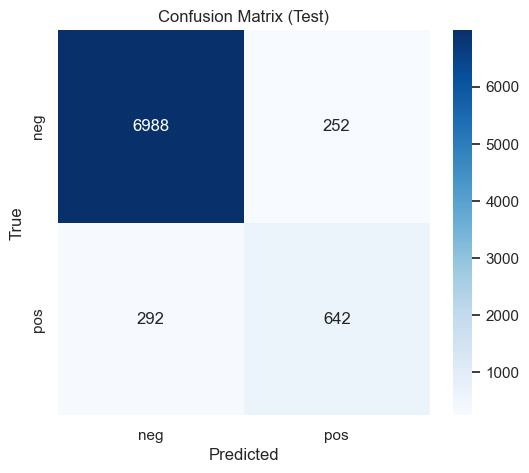

Test Loss: 0.1961
Test Accuracy: 93.34%
Test F1-Score: 0.8325


In [15]:
# Evaluate the model on the test dataset
test_metrics = evaluate(
    model=model, 
    data_loader=test_loader, 
    criterion=criterion, 
    device=device, 
    classes=['neg', 'pos'],  # Ensure these match the dataset's labels
    mode='Test'
)

# Verify and print test metrics
assert "loss" in test_metrics, "Test metrics do not contain 'loss'."
assert "accuracy" in test_metrics, "Test metrics do not contain 'accuracy'."
assert "f1_score" in test_metrics, "Test metrics do not contain 'f1_score'."

print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Test F1-Score: {test_metrics['f1_score']:.4f}")

In [16]:
device = get_device()

Using CUDA: NVIDIA GeForce RTX 4090


Generating Detailed Classification Report: 100%|█████████████████████████████████████| 511/511 [04:06<00:00,  2.08it/s]

=== Classification Report ===

              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174



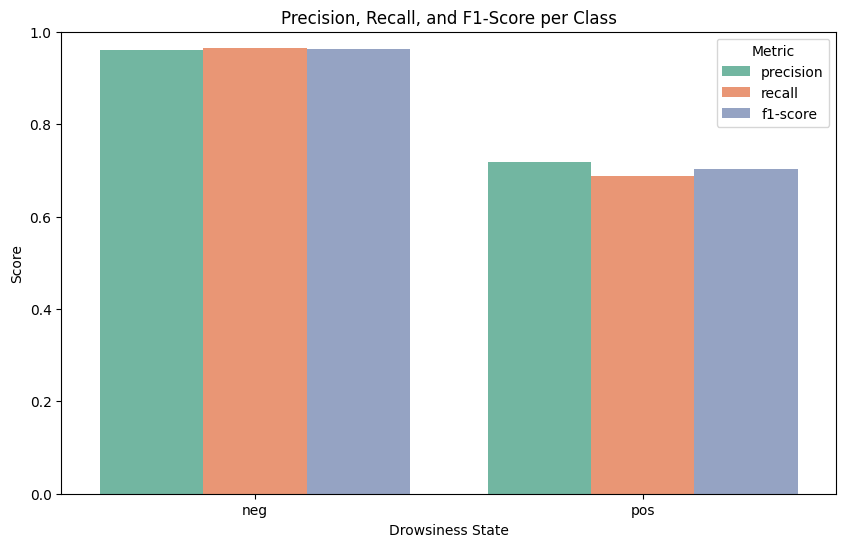

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\scripts\evaluation\report.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


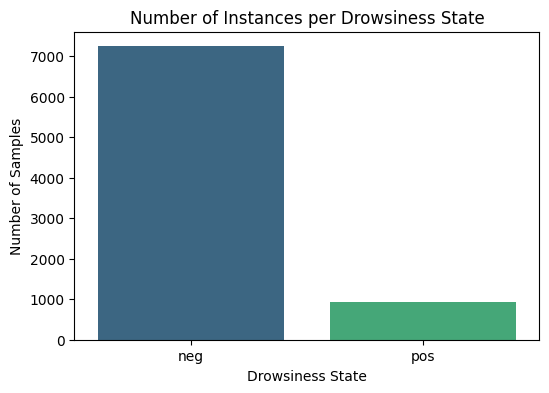

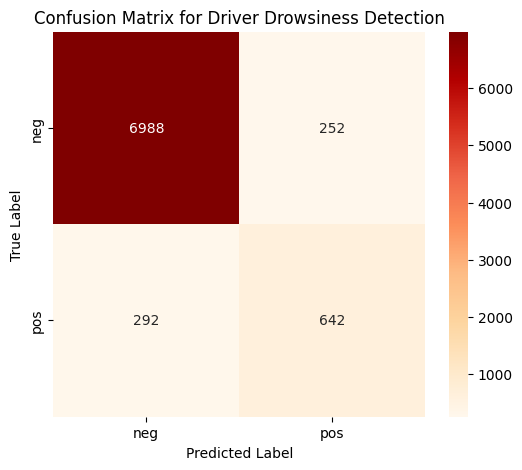

Generating Detailed Classification Report:   8%|█▋                  | 42/511 [00:20<03:40,  2.13it/s]

Generating Detailed Classification Report:   8%|█▋                  | 43/511 [00:20<03:41,  2.11it/s]

Generating Detailed Classification Report:   9%|█▋                  | 44/511 [00:21<03:43,  2.09it/s]

Generating Detailed Classification Report:   9%|█▊                  | 45/511 [00:21<03:44,  2.08it/s]

Generating Detailed Classification Report:   9%|█▊                  | 46/511 [00:21<03:40,  2.11it/s]

Generating Detailed Classification Report:   9%|█▊                  | 47/511 [00:22<03:35,  2.15it/s]

Generating Detailed Classification Report:   9%|█▉                  | 48/511 [00:22<03:38,  2.12it/s]

Generating Detailed Classification Report:  10%|█▉                  | 49/511 [00:23<03:40,  2.10it/s]

Generating Detailed Classification Report:  10%|█▉                  | 50/511 [00:23<03:40,  2.09it/s]

Generating Detailed Classification Report:  10%|█▉                  | 51/511 [00:24<03:41,  2.07it/s]

Generating Detailed Classification Report:  10%|██                  | 52/511 [00:24<03:41,  2.07it/s]

Generating Detailed Classification Report:  10%|██                  | 53/511 [00:25<03:32,  2.16it/s]

Generating Detailed Classification Report:  11%|██                  | 54/511 [00:25<03:35,  2.12it/s]

Generating Detailed Classification Report:  11%|██▏                 | 55/511 [00:26<03:37,  2.10it/s]

Generating Detailed Classification Report:  11%|██▏                 | 56/511 [00:26<03:39,  2.07it/s]

Generating Detailed Classification Report:  11%|██▏                 | 57/511 [00:27<03:39,  2.07it/s]

Generating Detailed Classification Report:  11%|██▎                 | 58/511 [00:27<03:39,  2.07it/s]

Generating Detailed Classification Report:  12%|██▎                 | 59/511 [00:28<03:33,  2.11it/s]

Generating Detailed Classification Report:  12%|██▎                 | 60/511 [00:28<03:35,  2.10it/s]

Generating Detailed Classification Report:  12%|██▍                 | 61/511 [00:29<03:34,  2.10it/s]

Generating Detailed Classification Report:  12%|██▍                 | 62/511 [00:29<03:35,  2.08it/s]

Generating Detailed Classification Report:  12%|██▍                 | 63/511 [00:30<03:35,  2.08it/s]

Generating Detailed Classification Report:  13%|██▌                 | 64/511 [00:30<03:36,  2.06it/s]

Generating Detailed Classification Report:  13%|██▌                 | 65/511 [00:31<03:35,  2.07it/s]

Generating Detailed Classification Report:  13%|██▌                 | 66/511 [00:31<03:34,  2.07it/s]

Generating Detailed Classification Report:  13%|██▌                 | 67/511 [00:32<03:34,  2.07it/s]

Generating Detailed Classification Report:  13%|██▋                 | 68/511 [00:32<03:35,  2.05it/s]

Generating Detailed Classification Report:  14%|██▋                 | 69/511 [00:33<03:34,  2.06it/s]

Generating Detailed Classification Report:  14%|██▋                 | 70/511 [00:33<03:33,  2.07it/s]

Generating Detailed Classification Report:  14%|██▊                 | 71/511 [00:34<03:33,  2.06it/s]

Generating Detailed Classification Report:  14%|██▊                 | 72/511 [00:34<03:31,  2.07it/s]

Generating Detailed Classification Report:  14%|██▊                 | 73/511 [00:34<03:31,  2.07it/s]

Generating Detailed Classification Report:  14%|██▉                 | 74/511 [00:35<03:32,  2.06it/s]

Generating Detailed Classification Report:  15%|██▉                 | 75/511 [00:35<03:31,  2.06it/s]

Generating Detailed Classification Report:  15%|██▉                 | 76/511 [00:36<03:30,  2.07it/s]

Generating Detailed Classification Report:  15%|███                 | 77/511 [00:36<03:30,  2.06it/s]

Generating Detailed Classification Report:  15%|███                 | 78/511 [00:37<03:29,  2.07it/s]

Generating Detailed Classification Report:  15%|███                 | 79/511 [00:37<03:28,  2.07it/s]

Generating Detailed Classification Report:  16%|███▏                | 80/511 [00:38<03:29,  2.06it/s]

Generating Detailed Classification Report:  16%|███▏                | 81/511 [00:38<03:28,  2.06it/s]

Generating Detailed Classification Report:  16%|███▏                | 82/511 [00:39<03:27,  2.06it/s]

Generating Detailed Classification Report:  16%|███▏                | 83/511 [00:39<03:27,  2.06it/s]

Generating Detailed Classification Report:  16%|███▎                | 84/511 [00:40<03:26,  2.07it/s]

Generating Detailed Classification Report:  17%|███▎                | 85/511 [00:40<03:25,  2.07it/s]

Generating Detailed Classification Report:  17%|███▎                | 86/511 [00:41<03:24,  2.07it/s]

Generating Detailed Classification Report:  17%|███▍                | 87/511 [00:41<03:24,  2.07it/s]

Generating Detailed Classification Report:  17%|███▍                | 88/511 [00:42<03:24,  2.07it/s]

Generating Detailed Classification Report:  17%|███▍                | 89/511 [00:42<03:25,  2.06it/s]

Generating Detailed Classification Report:  18%|███▌                | 90/511 [00:43<03:25,  2.05it/s]

Generating Detailed Classification Report:  18%|███▌                | 91/511 [00:43<03:23,  2.06it/s]

Generating Detailed Classification Report:  18%|███▌                | 92/511 [00:44<03:23,  2.06it/s]

Generating Detailed Classification Report:  18%|███▋                | 93/511 [00:44<03:21,  2.07it/s]

Generating Detailed Classification Report:  18%|███▋                | 94/511 [00:45<03:21,  2.07it/s]

Generating Detailed Classification Report:  19%|███▋                | 95/511 [00:45<03:20,  2.07it/s]

Generating Detailed Classification Report:  19%|███▊                | 96/511 [00:46<03:20,  2.07it/s]

Generating Detailed Classification Report:  19%|███▊                | 97/511 [00:46<03:21,  2.05it/s]

Generating Detailed Classification Report:  19%|███▊                | 98/511 [00:47<03:20,  2.06it/s]

Generating Detailed Classification Report:  19%|███▊                | 99/511 [00:47<03:18,  2.08it/s]

Generating Detailed Classification Report:  20%|███▋               | 100/511 [00:47<03:12,  2.13it/s]

Generating Detailed Classification Report:  20%|███▊               | 101/511 [00:48<03:15,  2.10it/s]

Generating Detailed Classification Report:  20%|███▊               | 102/511 [00:48<03:16,  2.08it/s]

Generating Detailed Classification Report:  20%|███▊               | 103/511 [00:49<03:15,  2.08it/s]

Generating Detailed Classification Report:  20%|███▊               | 104/511 [00:49<03:16,  2.07it/s]

Generating Detailed Classification Report:  21%|███▉               | 105/511 [00:50<03:16,  2.06it/s]

Generating Detailed Classification Report:  21%|███▉               | 106/511 [00:50<03:16,  2.06it/s]

Generating Detailed Classification Report:  21%|███▉               | 107/511 [00:51<03:16,  2.06it/s]

Generating Detailed Classification Report:  21%|████               | 108/511 [00:51<03:15,  2.06it/s]

Generating Detailed Classification Report:  21%|████               | 109/511 [00:52<03:15,  2.05it/s]

Generating Detailed Classification Report:  22%|████               | 110/511 [00:52<03:15,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 111/511 [00:53<03:14,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 112/511 [00:53<03:13,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 113/511 [00:54<03:13,  2.06it/s]

Generating Detailed Classification Report:  22%|████▏              | 114/511 [00:54<03:12,  2.07it/s]

Generating Detailed Classification Report:  23%|████▎              | 115/511 [00:55<03:12,  2.05it/s]

Generating Detailed Classification Report:  23%|████▎              | 116/511 [00:55<03:12,  2.05it/s]

Generating Detailed Classification Report:  23%|████▎              | 117/511 [00:56<03:11,  2.05it/s]

Generating Detailed Classification Report:  23%|████▍              | 118/511 [00:56<03:11,  2.05it/s]

Generating Detailed Classification Report:  23%|████▍              | 119/511 [00:57<03:04,  2.12it/s]

Generating Detailed Classification Report:  23%|████▍              | 120/511 [00:57<03:04,  2.12it/s]

Generating Detailed Classification Report:  24%|████▍              | 121/511 [00:58<03:06,  2.10it/s]

Generating Detailed Classification Report:  24%|████▌              | 122/511 [00:58<03:06,  2.08it/s]

Generating Detailed Classification Report:  24%|████▌              | 123/511 [00:59<03:09,  2.05it/s]

Generating Detailed Classification Report:  24%|████▌              | 124/511 [00:59<03:08,  2.06it/s]

Generating Detailed Classification Report:  24%|████▋              | 125/511 [01:00<03:07,  2.06it/s]

Generating Detailed Classification Report:  25%|████▋              | 126/511 [01:00<03:07,  2.05it/s]

Generating Detailed Classification Report:  25%|████▋              | 127/511 [01:01<03:06,  2.06it/s]

Generating Detailed Classification Report:  25%|████▊              | 128/511 [01:01<03:08,  2.03it/s]

Generating Detailed Classification Report:  25%|████▊              | 129/511 [01:02<03:07,  2.04it/s]

Generating Detailed Classification Report:  25%|████▊              | 130/511 [01:02<03:07,  2.03it/s]

Generating Detailed Classification Report:  26%|████▊              | 131/511 [01:03<03:07,  2.03it/s]

Generating Detailed Classification Report:  26%|████▉              | 132/511 [01:03<03:07,  2.03it/s]

Generating Detailed Classification Report:  26%|████▉              | 133/511 [01:04<03:06,  2.03it/s]

Generating Detailed Classification Report:  26%|████▉              | 134/511 [01:04<03:04,  2.04it/s]

Generating Detailed Classification Report:  26%|█████              | 135/511 [01:05<03:05,  2.03it/s]

Generating Detailed Classification Report:  27%|█████              | 136/511 [01:05<03:05,  2.03it/s]

Generating Detailed Classification Report:  27%|█████              | 137/511 [01:06<03:04,  2.03it/s]

Generating Detailed Classification Report:  27%|█████▏             | 138/511 [01:06<03:02,  2.05it/s]

Generating Detailed Classification Report:  27%|█████▏             | 139/511 [01:06<03:00,  2.06it/s]

Generating Detailed Classification Report:  27%|█████▏             | 140/511 [01:07<03:00,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▏             | 141/511 [01:07<02:59,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▎             | 142/511 [01:08<02:59,  2.05it/s]

Generating Detailed Classification Report:  28%|█████▎             | 143/511 [01:08<02:59,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▎             | 144/511 [01:09<02:58,  2.06it/s]

Generating Detailed Classification Report:  28%|█████▍             | 145/511 [01:09<02:57,  2.06it/s]

Generating Detailed Classification Report:  29%|█████▍             | 146/511 [01:10<02:56,  2.06it/s]

Generating Detailed Classification Report:  29%|█████▍             | 147/511 [01:10<02:55,  2.07it/s]

Generating Detailed Classification Report:  29%|█████▌             | 148/511 [01:11<02:56,  2.06it/s]

Generating Detailed Classification Report:  29%|█████▌             | 149/511 [01:11<02:55,  2.07it/s]

Generating Detailed Classification Report:  29%|█████▌             | 150/511 [01:12<02:55,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▌             | 151/511 [01:12<02:54,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▋             | 152/511 [01:13<02:53,  2.07it/s]

Generating Detailed Classification Report:  30%|█████▋             | 153/511 [01:13<02:53,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▋             | 154/511 [01:14<02:53,  2.06it/s]

Generating Detailed Classification Report:  30%|█████▊             | 155/511 [01:14<02:53,  2.05it/s]

Generating Detailed Classification Report:  31%|█████▊             | 156/511 [01:15<02:52,  2.06it/s]

Generating Detailed Classification Report:  31%|█████▊             | 157/511 [01:15<02:50,  2.07it/s]

Generating Detailed Classification Report:  31%|█████▊             | 158/511 [01:16<02:51,  2.05it/s]

Generating Detailed Classification Report:  31%|█████▉             | 159/511 [01:16<02:45,  2.13it/s]

Generating Detailed Classification Report:  31%|█████▉             | 160/511 [01:17<02:46,  2.10it/s]

Generating Detailed Classification Report:  32%|█████▉             | 161/511 [01:17<02:47,  2.08it/s]

Generating Detailed Classification Report:  32%|██████             | 162/511 [01:18<02:48,  2.08it/s]

Generating Detailed Classification Report:  32%|██████             | 163/511 [01:18<02:47,  2.08it/s]

Generating Detailed Classification Report:  32%|██████             | 164/511 [01:19<02:46,  2.08it/s]

Generating Detailed Classification Report:  32%|██████▏            | 165/511 [01:19<02:46,  2.08it/s]

Generating Detailed Classification Report:  32%|██████▏            | 166/511 [01:20<02:45,  2.08it/s]

Generating Detailed Classification Report:  33%|██████▏            | 167/511 [01:20<02:45,  2.08it/s]

Generating Detailed Classification Report:  33%|██████▏            | 168/511 [01:20<02:45,  2.08it/s]

Generating Detailed Classification Report:  33%|██████▎            | 169/511 [01:21<02:45,  2.06it/s]

Generating Detailed Classification Report:  33%|██████▎            | 170/511 [01:21<02:45,  2.06it/s]

Generating Detailed Classification Report:  33%|██████▎            | 171/511 [01:22<02:45,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▍            | 172/511 [01:22<02:44,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▍            | 173/511 [01:23<02:43,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▍            | 174/511 [01:23<02:43,  2.06it/s]

Generating Detailed Classification Report:  34%|██████▌            | 175/511 [01:24<02:41,  2.08it/s]

Generating Detailed Classification Report:  34%|██████▌            | 176/511 [01:24<02:41,  2.07it/s]

Generating Detailed Classification Report:  35%|██████▌            | 177/511 [01:25<02:39,  2.09it/s]

Generating Detailed Classification Report:  35%|██████▌            | 178/511 [01:25<02:37,  2.12it/s]

Generating Detailed Classification Report:  35%|██████▋            | 179/511 [01:26<02:38,  2.10it/s]

Generating Detailed Classification Report:  35%|██████▋            | 180/511 [01:26<02:38,  2.09it/s]

Generating Detailed Classification Report:  35%|██████▋            | 181/511 [01:27<02:39,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▊            | 182/511 [01:27<02:38,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▊            | 183/511 [01:28<02:38,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▊            | 184/511 [01:28<02:38,  2.07it/s]

Generating Detailed Classification Report:  36%|██████▉            | 185/511 [01:29<02:36,  2.08it/s]

Generating Detailed Classification Report:  36%|██████▉            | 186/511 [01:29<02:37,  2.07it/s]

Generating Detailed Classification Report:  37%|██████▉            | 187/511 [01:30<02:36,  2.07it/s]

Generating Detailed Classification Report:  37%|██████▉            | 188/511 [01:30<02:36,  2.06it/s]

Generating Detailed Classification Report:  37%|███████            | 189/511 [01:31<02:35,  2.07it/s]

Generating Detailed Classification Report:  37%|███████            | 190/511 [01:31<02:35,  2.07it/s]

Generating Detailed Classification Report:  37%|███████            | 191/511 [01:32<02:36,  2.04it/s]

Generating Detailed Classification Report:  38%|███████▏           | 192/511 [01:32<02:37,  2.02it/s]

Generating Detailed Classification Report:  38%|███████▏           | 193/511 [01:33<02:37,  2.02it/s]

Generating Detailed Classification Report:  38%|███████▏           | 194/511 [01:33<02:36,  2.02it/s]

Generating Detailed Classification Report:  38%|███████▎           | 195/511 [01:34<02:34,  2.04it/s]

Generating Detailed Classification Report:  38%|███████▎           | 196/511 [01:34<02:33,  2.05it/s]

Generating Detailed Classification Report:  39%|███████▎           | 197/511 [01:35<02:32,  2.05it/s]

Generating Detailed Classification Report:  39%|███████▎           | 198/511 [01:35<02:31,  2.06it/s]

Generating Detailed Classification Report:  39%|███████▍           | 199/511 [01:36<02:30,  2.07it/s]

Generating Detailed Classification Report:  39%|███████▍           | 200/511 [01:36<02:30,  2.07it/s]

Generating Detailed Classification Report:  39%|███████▍           | 201/511 [01:36<02:30,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 202/511 [01:37<02:29,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 203/511 [01:37<02:28,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 204/511 [01:38<02:28,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▌           | 205/511 [01:38<02:27,  2.07it/s]

Generating Detailed Classification Report:  40%|███████▋           | 206/511 [01:39<02:26,  2.08it/s]

Generating Detailed Classification Report:  41%|███████▋           | 207/511 [01:39<02:22,  2.14it/s]

Generating Detailed Classification Report:  41%|███████▋           | 208/511 [01:40<02:23,  2.12it/s]

Generating Detailed Classification Report:  41%|███████▊           | 209/511 [01:40<02:24,  2.09it/s]

Generating Detailed Classification Report:  41%|███████▊           | 210/511 [01:41<02:24,  2.09it/s]

Generating Detailed Classification Report:  41%|███████▊           | 211/511 [01:41<02:25,  2.06it/s]

Generating Detailed Classification Report:  41%|███████▉           | 212/511 [01:42<02:25,  2.06it/s]

Generating Detailed Classification Report:  42%|███████▉           | 213/511 [01:42<02:25,  2.04it/s]

Generating Detailed Classification Report:  42%|███████▉           | 214/511 [01:43<02:24,  2.06it/s]

Generating Detailed Classification Report:  42%|███████▉           | 215/511 [01:43<02:23,  2.06it/s]

Generating Detailed Classification Report:  42%|████████           | 216/511 [01:44<02:23,  2.06it/s]

Generating Detailed Classification Report:  42%|████████           | 217/511 [01:44<02:22,  2.07it/s]

Generating Detailed Classification Report:  43%|████████           | 218/511 [01:45<02:21,  2.07it/s]

Generating Detailed Classification Report:  43%|████████▏          | 219/511 [01:45<02:22,  2.05it/s]

Generating Detailed Classification Report:  43%|████████▏          | 220/511 [01:46<02:21,  2.05it/s]

Generating Detailed Classification Report:  43%|████████▏          | 221/511 [01:46<02:20,  2.06it/s]

Generating Detailed Classification Report:  43%|████████▎          | 222/511 [01:47<02:20,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▎          | 223/511 [01:47<02:19,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▎          | 224/511 [01:48<02:19,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▎          | 225/511 [01:48<02:18,  2.06it/s]

Generating Detailed Classification Report:  44%|████████▍          | 226/511 [01:49<02:18,  2.05it/s]

Generating Detailed Classification Report:  44%|████████▍          | 227/511 [01:49<02:18,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▍          | 228/511 [01:50<02:17,  2.05it/s]

Generating Detailed Classification Report:  45%|████████▌          | 229/511 [01:50<02:17,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▌          | 230/511 [01:51<02:16,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▌          | 231/511 [01:51<02:16,  2.06it/s]

Generating Detailed Classification Report:  45%|████████▋          | 232/511 [01:51<02:15,  2.06it/s]

Generating Detailed Classification Report:  46%|████████▋          | 233/511 [01:52<02:13,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▋          | 234/511 [01:52<02:13,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▋          | 235/511 [01:53<02:12,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▊          | 236/511 [01:53<02:12,  2.08it/s]

Generating Detailed Classification Report:  46%|████████▊          | 237/511 [01:54<02:12,  2.07it/s]

Generating Detailed Classification Report:  47%|████████▊          | 238/511 [01:54<02:11,  2.08it/s]

Generating Detailed Classification Report:  47%|████████▉          | 239/511 [01:55<02:10,  2.08it/s]

Generating Detailed Classification Report:  47%|████████▉          | 240/511 [01:55<02:10,  2.08it/s]

Generating Detailed Classification Report:  47%|████████▉          | 241/511 [01:56<02:10,  2.06it/s]

Generating Detailed Classification Report:  47%|████████▉          | 242/511 [01:56<02:10,  2.06it/s]

Generating Detailed Classification Report:  48%|█████████          | 243/511 [01:57<02:10,  2.06it/s]

Generating Detailed Classification Report:  48%|█████████          | 244/511 [01:57<02:09,  2.07it/s]

Generating Detailed Classification Report:  48%|█████████          | 245/511 [01:58<02:07,  2.09it/s]

Generating Detailed Classification Report:  48%|█████████▏         | 246/511 [01:58<02:03,  2.14it/s]

Generating Detailed Classification Report:  48%|█████████▏         | 247/511 [01:59<02:04,  2.12it/s]

Generating Detailed Classification Report:  49%|█████████▏         | 248/511 [01:59<02:04,  2.12it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 249/511 [02:00<02:04,  2.11it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 250/511 [02:00<02:04,  2.10it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 251/511 [02:01<02:04,  2.09it/s]

Generating Detailed Classification Report:  49%|█████████▎         | 252/511 [02:01<02:04,  2.08it/s]

Generating Detailed Classification Report:  50%|█████████▍         | 253/511 [02:02<02:03,  2.08it/s]

Generating Detailed Classification Report:  50%|█████████▍         | 254/511 [02:02<02:04,  2.07it/s]

Generating Detailed Classification Report:  50%|█████████▍         | 255/511 [02:03<02:03,  2.07it/s]

Generating Detailed Classification Report:  50%|█████████▌         | 256/511 [02:03<02:04,  2.04it/s]

Generating Detailed Classification Report:  50%|█████████▌         | 257/511 [02:03<02:03,  2.05it/s]

Generating Detailed Classification Report:  50%|█████████▌         | 258/511 [02:04<02:02,  2.06it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 259/511 [02:04<02:02,  2.06it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 260/511 [02:05<02:01,  2.06it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 261/511 [02:05<02:00,  2.07it/s]

Generating Detailed Classification Report:  51%|█████████▋         | 262/511 [02:06<02:00,  2.07it/s]

Generating Detailed Classification Report:  51%|█████████▊         | 263/511 [02:06<01:59,  2.07it/s]

Generating Detailed Classification Report:  52%|█████████▊         | 264/511 [02:07<01:58,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▊         | 265/511 [02:07<01:58,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▉         | 266/511 [02:08<01:57,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▉         | 267/511 [02:08<01:57,  2.08it/s]

Generating Detailed Classification Report:  52%|█████████▉         | 268/511 [02:09<01:56,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████         | 269/511 [02:09<01:56,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████         | 270/511 [02:10<01:55,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████         | 271/511 [02:10<01:55,  2.09it/s]

Generating Detailed Classification Report:  53%|██████████         | 272/511 [02:11<01:54,  2.08it/s]

Generating Detailed Classification Report:  53%|██████████▏        | 273/511 [02:11<01:53,  2.09it/s]

Generating Detailed Classification Report:  54%|██████████▏        | 274/511 [02:12<01:50,  2.15it/s]

Generating Detailed Classification Report:  54%|██████████▏        | 275/511 [02:12<01:51,  2.11it/s]

Generating Detailed Classification Report:  54%|██████████▎        | 276/511 [02:13<01:52,  2.10it/s]

Generating Detailed Classification Report:  54%|██████████▎        | 277/511 [02:13<01:51,  2.10it/s]

Generating Detailed Classification Report:  54%|██████████▎        | 278/511 [02:14<01:51,  2.09it/s]

Generating Detailed Classification Report:  55%|██████████▎        | 279/511 [02:14<01:51,  2.08it/s]

Generating Detailed Classification Report:  55%|██████████▍        | 280/511 [02:15<01:52,  2.06it/s]

Generating Detailed Classification Report:  55%|██████████▍        | 281/511 [02:15<01:51,  2.07it/s]

Generating Detailed Classification Report:  55%|██████████▍        | 282/511 [02:15<01:50,  2.07it/s]

Generating Detailed Classification Report:  55%|██████████▌        | 283/511 [02:16<01:49,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▌        | 284/511 [02:16<01:49,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▌        | 285/511 [02:17<01:49,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▋        | 286/511 [02:17<01:48,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▋        | 287/511 [02:18<01:48,  2.07it/s]

Generating Detailed Classification Report:  56%|██████████▋        | 288/511 [02:18<01:47,  2.07it/s]

Generating Detailed Classification Report:  57%|██████████▋        | 289/511 [02:19<01:47,  2.07it/s]

Generating Detailed Classification Report:  57%|██████████▊        | 290/511 [02:19<01:46,  2.08it/s]

Generating Detailed Classification Report:  57%|██████████▊        | 291/511 [02:20<01:45,  2.08it/s]

Generating Detailed Classification Report:  57%|██████████▊        | 292/511 [02:20<01:45,  2.07it/s]

Generating Detailed Classification Report:  57%|██████████▉        | 293/511 [02:21<01:45,  2.07it/s]

Generating Detailed Classification Report:  58%|██████████▉        | 294/511 [02:21<01:45,  2.06it/s]

Generating Detailed Classification Report:  58%|██████████▉        | 295/511 [02:22<01:44,  2.06it/s]

Generating Detailed Classification Report:  58%|███████████        | 296/511 [02:22<01:43,  2.07it/s]

Generating Detailed Classification Report:  58%|███████████        | 297/511 [02:23<01:43,  2.07it/s]

Generating Detailed Classification Report:  58%|███████████        | 298/511 [02:23<01:43,  2.07it/s]

Generating Detailed Classification Report:  59%|███████████        | 299/511 [02:24<01:43,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▏       | 300/511 [02:24<01:42,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▏       | 301/511 [02:25<01:41,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▏       | 302/511 [02:25<01:40,  2.07it/s]

Generating Detailed Classification Report:  59%|███████████▎       | 303/511 [02:26<01:40,  2.06it/s]

Generating Detailed Classification Report:  59%|███████████▎       | 304/511 [02:26<01:40,  2.07it/s]

Generating Detailed Classification Report:  60%|███████████▎       | 305/511 [02:27<01:39,  2.06it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 306/511 [02:27<01:39,  2.05it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 307/511 [02:28<01:39,  2.04it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 308/511 [02:28<01:39,  2.05it/s]

Generating Detailed Classification Report:  60%|███████████▍       | 309/511 [02:29<01:38,  2.05it/s]

Generating Detailed Classification Report:  61%|███████████▌       | 310/511 [02:29<01:38,  2.05it/s]

Generating Detailed Classification Report:  61%|███████████▌       | 311/511 [02:30<01:35,  2.09it/s]

Generating Detailed Classification Report:  61%|███████████▌       | 312/511 [02:30<01:34,  2.11it/s]

Generating Detailed Classification Report:  61%|███████████▋       | 313/511 [02:30<01:34,  2.09it/s]

Generating Detailed Classification Report:  61%|███████████▋       | 314/511 [02:31<01:34,  2.08it/s]

Generating Detailed Classification Report:  62%|███████████▋       | 315/511 [02:31<01:34,  2.07it/s]

Generating Detailed Classification Report:  62%|███████████▋       | 316/511 [02:32<01:36,  2.03it/s]

Generating Detailed Classification Report:  62%|███████████▊       | 317/511 [02:32<01:34,  2.05it/s]

Generating Detailed Classification Report:  62%|███████████▊       | 318/511 [02:33<01:33,  2.06it/s]

Generating Detailed Classification Report:  62%|███████████▊       | 319/511 [02:33<01:32,  2.07it/s]

Generating Detailed Classification Report:  63%|███████████▉       | 320/511 [02:34<01:33,  2.05it/s]

Generating Detailed Classification Report:  63%|███████████▉       | 321/511 [02:34<01:32,  2.06it/s]

Generating Detailed Classification Report:  63%|███████████▉       | 322/511 [02:35<01:32,  2.05it/s]

Generating Detailed Classification Report:  63%|████████████       | 323/511 [02:35<01:31,  2.05it/s]

Generating Detailed Classification Report:  63%|████████████       | 324/511 [02:36<01:31,  2.04it/s]

Generating Detailed Classification Report:  64%|████████████       | 325/511 [02:36<01:30,  2.05it/s]

Generating Detailed Classification Report:  64%|████████████       | 326/511 [02:37<01:29,  2.06it/s]

Generating Detailed Classification Report:  64%|████████████▏      | 327/511 [02:37<01:29,  2.07it/s]

Generating Detailed Classification Report:  64%|████████████▏      | 328/511 [02:38<01:28,  2.06it/s]

Generating Detailed Classification Report:  64%|████████████▏      | 329/511 [02:38<01:28,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▎      | 330/511 [02:39<01:27,  2.07it/s]

Generating Detailed Classification Report:  65%|████████████▎      | 331/511 [02:39<01:27,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▎      | 332/511 [02:40<01:26,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▍      | 333/511 [02:40<01:26,  2.06it/s]

Generating Detailed Classification Report:  65%|████████████▍      | 334/511 [02:41<01:25,  2.07it/s]

Generating Detailed Classification Report:  66%|████████████▍      | 335/511 [02:41<01:25,  2.06it/s]

Generating Detailed Classification Report:  66%|████████████▍      | 336/511 [02:42<01:24,  2.06it/s]

Generating Detailed Classification Report:  66%|████████████▌      | 337/511 [02:42<01:23,  2.07it/s]

Generating Detailed Classification Report:  66%|████████████▌      | 338/511 [02:43<01:23,  2.07it/s]

Generating Detailed Classification Report:  66%|████████████▌      | 339/511 [02:43<01:20,  2.13it/s]

Generating Detailed Classification Report:  67%|████████████▋      | 340/511 [02:44<01:21,  2.11it/s]

Generating Detailed Classification Report:  67%|████████████▋      | 341/511 [02:44<01:21,  2.10it/s]

Generating Detailed Classification Report:  67%|████████████▋      | 342/511 [02:45<01:21,  2.08it/s]

Generating Detailed Classification Report:  67%|████████████▊      | 343/511 [02:45<01:21,  2.07it/s]

Generating Detailed Classification Report:  67%|████████████▊      | 344/511 [02:45<01:20,  2.07it/s]

Generating Detailed Classification Report:  68%|████████████▊      | 345/511 [02:46<01:20,  2.06it/s]

Generating Detailed Classification Report:  68%|████████████▊      | 346/511 [02:46<01:19,  2.06it/s]

Generating Detailed Classification Report:  68%|████████████▉      | 347/511 [02:47<01:19,  2.06it/s]

Generating Detailed Classification Report:  68%|████████████▉      | 348/511 [02:47<01:18,  2.07it/s]

Generating Detailed Classification Report:  68%|████████████▉      | 349/511 [02:48<01:18,  2.07it/s]

Generating Detailed Classification Report:  68%|█████████████      | 350/511 [02:48<01:17,  2.07it/s]

Generating Detailed Classification Report:  69%|█████████████      | 351/511 [02:49<01:16,  2.08it/s]

Generating Detailed Classification Report:  69%|█████████████      | 352/511 [02:49<01:16,  2.08it/s]

Generating Detailed Classification Report:  69%|█████████████▏     | 353/511 [02:50<01:15,  2.08it/s]

Generating Detailed Classification Report:  69%|█████████████▏     | 354/511 [02:50<01:16,  2.06it/s]

Generating Detailed Classification Report:  69%|█████████████▏     | 355/511 [02:51<01:15,  2.07it/s]

Generating Detailed Classification Report:  70%|█████████████▏     | 356/511 [02:51<01:15,  2.07it/s]

Generating Detailed Classification Report:  70%|█████████████▎     | 357/511 [02:52<01:14,  2.06it/s]

Generating Detailed Classification Report:  70%|█████████████▎     | 358/511 [02:52<01:14,  2.05it/s]

Generating Detailed Classification Report:  70%|█████████████▎     | 359/511 [02:53<01:13,  2.06it/s]

Generating Detailed Classification Report:  70%|█████████████▍     | 360/511 [02:53<01:13,  2.06it/s]

Generating Detailed Classification Report:  71%|█████████████▍     | 361/511 [02:54<01:12,  2.06it/s]

Generating Detailed Classification Report:  71%|█████████████▍     | 362/511 [02:54<01:12,  2.06it/s]

Generating Detailed Classification Report:  71%|█████████████▍     | 363/511 [02:55<01:12,  2.05it/s]

Generating Detailed Classification Report:  71%|█████████████▌     | 364/511 [02:55<01:11,  2.05it/s]

Generating Detailed Classification Report:  71%|█████████████▌     | 365/511 [02:56<01:09,  2.11it/s]

Generating Detailed Classification Report:  72%|█████████████▌     | 366/511 [02:56<01:09,  2.10it/s]

Generating Detailed Classification Report:  72%|█████████████▋     | 367/511 [02:57<01:09,  2.08it/s]

Generating Detailed Classification Report:  72%|█████████████▋     | 368/511 [02:57<01:09,  2.05it/s]

Generating Detailed Classification Report:  72%|█████████████▋     | 369/511 [02:58<01:09,  2.05it/s]

Generating Detailed Classification Report:  72%|█████████████▊     | 370/511 [02:58<01:08,  2.05it/s]

Generating Detailed Classification Report:  73%|█████████████▊     | 371/511 [02:59<01:07,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▊     | 372/511 [02:59<01:07,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▊     | 373/511 [03:00<01:07,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▉     | 374/511 [03:00<01:06,  2.06it/s]

Generating Detailed Classification Report:  73%|█████████████▉     | 375/511 [03:01<01:06,  2.06it/s]

Generating Detailed Classification Report:  74%|█████████████▉     | 376/511 [03:01<01:05,  2.05it/s]

Generating Detailed Classification Report:  74%|██████████████     | 377/511 [03:01<01:05,  2.06it/s]

Generating Detailed Classification Report:  74%|██████████████     | 378/511 [03:02<01:05,  2.02it/s]

Generating Detailed Classification Report:  74%|██████████████     | 379/511 [03:02<01:04,  2.04it/s]

Generating Detailed Classification Report:  74%|██████████████▏    | 380/511 [03:03<01:03,  2.05it/s]

Generating Detailed Classification Report:  75%|██████████████▏    | 381/511 [03:03<01:03,  2.06it/s]

Generating Detailed Classification Report:  75%|██████████████▏    | 382/511 [03:04<01:02,  2.05it/s]

Generating Detailed Classification Report:  75%|██████████████▏    | 383/511 [03:04<01:02,  2.04it/s]

Generating Detailed Classification Report:  75%|██████████████▎    | 384/511 [03:05<01:02,  2.03it/s]

Generating Detailed Classification Report:  75%|██████████████▎    | 385/511 [03:05<01:01,  2.04it/s]

Generating Detailed Classification Report:  76%|██████████████▎    | 386/511 [03:06<01:01,  2.04it/s]

Generating Detailed Classification Report:  76%|██████████████▍    | 387/511 [03:06<01:00,  2.05it/s]

Generating Detailed Classification Report:  76%|██████████████▍    | 388/511 [03:07<00:59,  2.05it/s]

Generating Detailed Classification Report:  76%|██████████████▍    | 389/511 [03:07<00:59,  2.05it/s]

Generating Detailed Classification Report:  76%|██████████████▌    | 390/511 [03:08<00:59,  2.05it/s]

Generating Detailed Classification Report:  77%|██████████████▌    | 391/511 [03:08<00:58,  2.05it/s]

Generating Detailed Classification Report:  77%|██████████████▌    | 392/511 [03:09<00:58,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▌    | 393/511 [03:09<00:57,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▋    | 394/511 [03:10<00:57,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▋    | 395/511 [03:10<00:56,  2.04it/s]

Generating Detailed Classification Report:  77%|██████████████▋    | 396/511 [03:11<00:56,  2.05it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 397/511 [03:11<00:55,  2.06it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 398/511 [03:12<00:54,  2.06it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 399/511 [03:12<00:54,  2.04it/s]

Generating Detailed Classification Report:  78%|██████████████▊    | 400/511 [03:13<00:54,  2.05it/s]

Generating Detailed Classification Report:  78%|██████████████▉    | 401/511 [03:13<00:54,  2.04it/s]

Generating Detailed Classification Report:  79%|██████████████▉    | 402/511 [03:14<00:53,  2.04it/s]

Generating Detailed Classification Report:  79%|██████████████▉    | 403/511 [03:14<00:53,  2.04it/s]

Generating Detailed Classification Report:  79%|███████████████    | 404/511 [03:15<00:52,  2.03it/s]

Generating Detailed Classification Report:  79%|███████████████    | 405/511 [03:15<00:51,  2.04it/s]

Generating Detailed Classification Report:  79%|███████████████    | 406/511 [03:16<00:51,  2.05it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 407/511 [03:16<00:50,  2.05it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 408/511 [03:17<00:50,  2.04it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 409/511 [03:17<00:49,  2.05it/s]

Generating Detailed Classification Report:  80%|███████████████▏   | 410/511 [03:18<00:47,  2.12it/s]

Generating Detailed Classification Report:  80%|███████████████▎   | 411/511 [03:18<00:47,  2.11it/s]

Generating Detailed Classification Report:  81%|███████████████▎   | 412/511 [03:19<00:47,  2.09it/s]

Generating Detailed Classification Report:  81%|███████████████▎   | 413/511 [03:19<00:47,  2.08it/s]

Generating Detailed Classification Report:  81%|███████████████▍   | 414/511 [03:20<00:46,  2.07it/s]

Generating Detailed Classification Report:  81%|███████████████▍   | 415/511 [03:20<00:46,  2.06it/s]

Generating Detailed Classification Report:  81%|███████████████▍   | 416/511 [03:21<00:46,  2.05it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 417/511 [03:21<00:45,  2.05it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 418/511 [03:21<00:45,  2.05it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 419/511 [03:22<00:44,  2.06it/s]

Generating Detailed Classification Report:  82%|███████████████▌   | 420/511 [03:22<00:44,  2.06it/s]

Generating Detailed Classification Report:  82%|███████████████▋   | 421/511 [03:23<00:43,  2.06it/s]

Generating Detailed Classification Report:  83%|███████████████▋   | 422/511 [03:23<00:43,  2.06it/s]

Generating Detailed Classification Report:  83%|███████████████▋   | 423/511 [03:24<00:43,  2.04it/s]

Generating Detailed Classification Report:  83%|███████████████▊   | 424/511 [03:24<00:42,  2.05it/s]

Generating Detailed Classification Report:  83%|███████████████▊   | 425/511 [03:25<00:42,  2.04it/s]

Generating Detailed Classification Report:  83%|███████████████▊   | 426/511 [03:25<00:41,  2.04it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 427/511 [03:26<00:40,  2.05it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 428/511 [03:26<00:40,  2.05it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 429/511 [03:27<00:40,  2.04it/s]

Generating Detailed Classification Report:  84%|███████████████▉   | 430/511 [03:27<00:39,  2.05it/s]

Generating Detailed Classification Report:  84%|████████████████   | 431/511 [03:28<00:38,  2.05it/s]

Generating Detailed Classification Report:  85%|████████████████   | 432/511 [03:28<00:38,  2.05it/s]

Generating Detailed Classification Report:  85%|████████████████   | 433/511 [03:29<00:38,  2.05it/s]

Generating Detailed Classification Report:  85%|████████████████▏  | 434/511 [03:29<00:36,  2.12it/s]

Generating Detailed Classification Report:  85%|████████████████▏  | 435/511 [03:30<00:36,  2.11it/s]

Generating Detailed Classification Report:  85%|████████████████▏  | 436/511 [03:30<00:35,  2.09it/s]

Generating Detailed Classification Report:  86%|████████████████▏  | 437/511 [03:31<00:35,  2.08it/s]

Generating Detailed Classification Report:  86%|████████████████▎  | 438/511 [03:31<00:35,  2.08it/s]

Generating Detailed Classification Report:  86%|████████████████▎  | 439/511 [03:32<00:35,  2.06it/s]

Generating Detailed Classification Report:  86%|████████████████▎  | 440/511 [03:32<00:34,  2.06it/s]

Generating Detailed Classification Report:  86%|████████████████▍  | 441/511 [03:33<00:33,  2.07it/s]

Generating Detailed Classification Report:  86%|████████████████▍  | 442/511 [03:33<00:33,  2.07it/s]

Generating Detailed Classification Report:  87%|████████████████▍  | 443/511 [03:34<00:32,  2.08it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 444/511 [03:34<00:32,  2.07it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 445/511 [03:35<00:32,  2.05it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 446/511 [03:35<00:31,  2.05it/s]

Generating Detailed Classification Report:  87%|████████████████▌  | 447/511 [03:36<00:31,  2.03it/s]

Generating Detailed Classification Report:  88%|████████████████▋  | 448/511 [03:36<00:30,  2.04it/s]

Generating Detailed Classification Report:  88%|████████████████▋  | 449/511 [03:37<00:30,  2.04it/s]

Generating Detailed Classification Report:  88%|████████████████▋  | 450/511 [03:37<00:29,  2.04it/s]

Generating Detailed Classification Report:  88%|████████████████▊  | 451/511 [03:38<00:29,  2.03it/s]

Generating Detailed Classification Report:  88%|████████████████▊  | 452/511 [03:38<00:28,  2.04it/s]

Generating Detailed Classification Report:  89%|████████████████▊  | 453/511 [03:38<00:28,  2.05it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 454/511 [03:39<00:27,  2.05it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 455/511 [03:39<00:27,  2.04it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 456/511 [03:40<00:26,  2.06it/s]

Generating Detailed Classification Report:  89%|████████████████▉  | 457/511 [03:40<00:26,  2.06it/s]

Generating Detailed Classification Report:  90%|█████████████████  | 458/511 [03:41<00:25,  2.06it/s]

Generating Detailed Classification Report:  90%|█████████████████  | 459/511 [03:41<00:25,  2.05it/s]

Generating Detailed Classification Report:  90%|█████████████████  | 460/511 [03:42<00:24,  2.05it/s]

Generating Detailed Classification Report:  90%|█████████████████▏ | 461/511 [03:42<00:24,  2.07it/s]

Generating Detailed Classification Report:  90%|█████████████████▏ | 462/511 [03:43<00:23,  2.06it/s]

Generating Detailed Classification Report:  91%|█████████████████▏ | 463/511 [03:43<00:22,  2.14it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 464/511 [03:44<00:22,  2.11it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 465/511 [03:44<00:21,  2.10it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 466/511 [03:45<00:21,  2.08it/s]

Generating Detailed Classification Report:  91%|█████████████████▎ | 467/511 [03:45<00:21,  2.07it/s]

Generating Detailed Classification Report:  92%|█████████████████▍ | 468/511 [03:46<00:20,  2.06it/s]

Generating Detailed Classification Report:  92%|█████████████████▍ | 469/511 [03:46<00:20,  2.05it/s]

Generating Detailed Classification Report:  92%|█████████████████▍ | 470/511 [03:47<00:19,  2.06it/s]

Generating Detailed Classification Report:  92%|█████████████████▌ | 471/511 [03:47<00:19,  2.07it/s]

Generating Detailed Classification Report:  92%|█████████████████▌ | 472/511 [03:48<00:18,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▌ | 473/511 [03:48<00:18,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▌ | 474/511 [03:49<00:17,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▋ | 475/511 [03:49<00:17,  2.07it/s]

Generating Detailed Classification Report:  93%|█████████████████▋ | 476/511 [03:50<00:17,  2.05it/s]

Generating Detailed Classification Report:  93%|█████████████████▋ | 477/511 [03:50<00:16,  2.03it/s]

Generating Detailed Classification Report:  94%|█████████████████▊ | 478/511 [03:51<00:16,  2.03it/s]

Generating Detailed Classification Report:  94%|█████████████████▊ | 479/511 [03:51<00:15,  2.05it/s]

Generating Detailed Classification Report:  94%|█████████████████▊ | 480/511 [03:52<00:15,  2.06it/s]

Generating Detailed Classification Report:  94%|█████████████████▉ | 481/511 [03:52<00:14,  2.05it/s]

Generating Detailed Classification Report:  94%|█████████████████▉ | 482/511 [03:53<00:13,  2.11it/s]

Generating Detailed Classification Report:  95%|█████████████████▉ | 483/511 [03:53<00:13,  2.11it/s]

Generating Detailed Classification Report:  95%|█████████████████▉ | 484/511 [03:53<00:12,  2.08it/s]

Generating Detailed Classification Report:  95%|██████████████████ | 485/511 [03:54<00:12,  2.06it/s]

Generating Detailed Classification Report:  95%|██████████████████ | 486/511 [03:54<00:12,  2.06it/s]

Generating Detailed Classification Report:  95%|██████████████████ | 487/511 [03:55<00:11,  2.07it/s]

Generating Detailed Classification Report:  95%|██████████████████▏| 488/511 [03:55<00:11,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▏| 489/511 [03:56<00:10,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▏| 490/511 [03:56<00:10,  2.08it/s]

Generating Detailed Classification Report:  96%|██████████████████▎| 491/511 [03:57<00:09,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▎| 492/511 [03:57<00:09,  2.07it/s]

Generating Detailed Classification Report:  96%|██████████████████▎| 493/511 [03:58<00:08,  2.08it/s]

Generating Detailed Classification Report:  97%|██████████████████▎| 494/511 [03:58<00:08,  2.08it/s]

Generating Detailed Classification Report:  97%|██████████████████▍| 495/511 [03:59<00:07,  2.07it/s]

Generating Detailed Classification Report:  97%|██████████████████▍| 496/511 [03:59<00:07,  2.07it/s]

Generating Detailed Classification Report:  97%|██████████████████▍| 497/511 [04:00<00:06,  2.07it/s]

Generating Detailed Classification Report:  97%|██████████████████▌| 498/511 [04:00<00:06,  2.06it/s]

Generating Detailed Classification Report:  98%|██████████████████▌| 499/511 [04:01<00:05,  2.05it/s]

Generating Detailed Classification Report:  98%|██████████████████▌| 500/511 [04:01<00:05,  2.06it/s]

Generating Detailed Classification Report:  98%|██████████████████▋| 501/511 [04:02<00:04,  2.05it/s]

Generating Detailed Classification Report:  98%|██████████████████▋| 502/511 [04:02<00:04,  2.05it/s]

Generating Detailed Classification Report:  98%|██████████████████▋| 503/511 [04:03<00:03,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▋| 504/511 [04:03<00:03,  2.06it/s]

Generating Detailed Classification Report:  99%|██████████████████▊| 505/511 [04:04<00:02,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▊| 506/511 [04:04<00:02,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▊| 507/511 [04:05<00:01,  2.05it/s]

Generating Detailed Classification Report:  99%|██████████████████▉| 508/511 [04:05<00:01,  2.06it/s]

Generating Detailed Classification Report: 100%|██████████████████▉| 509/511 [04:06<00:00,  2.05it/s]

Generating Detailed Classification Report: 100%|██████████████████▉| 510/511 [04:06<00:00,  2.06it/s]

Generating Detailed Classification Report: 100%|███████████████████| 511/511 [04:06<00:00,  2.20it/s]

Generating Detailed Classification Report: 100%|███████████████████| 511/511 [04:06<00:00,  2.07it/s]

=== Classification Report ===

              precision    recall  f1-score   support

         neg       0.96      0.97      0.96      7240
         pos       0.72      0.69      0.70       934

    accuracy                           0.93      8174
   macro avg       0.84      0.83      0.83      8174
weighted avg       0.93      0.93      0.93      8174



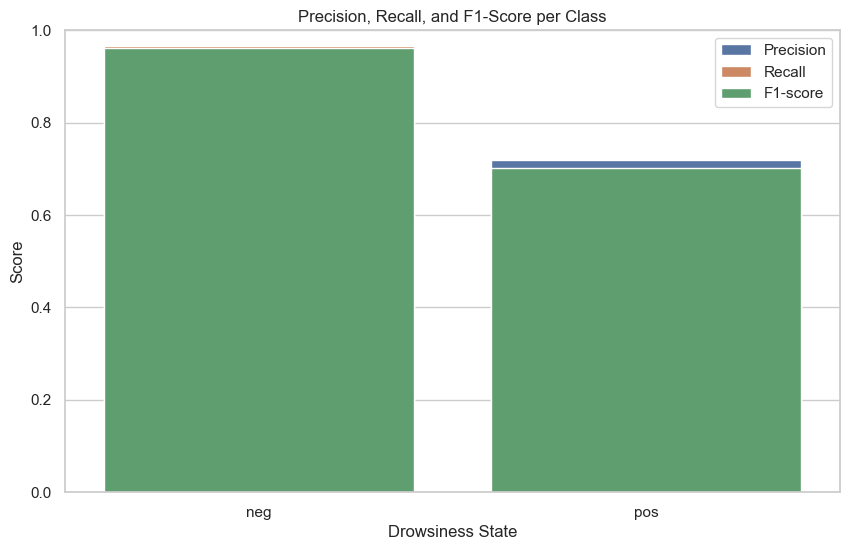

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\scripts\evaluation\report.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


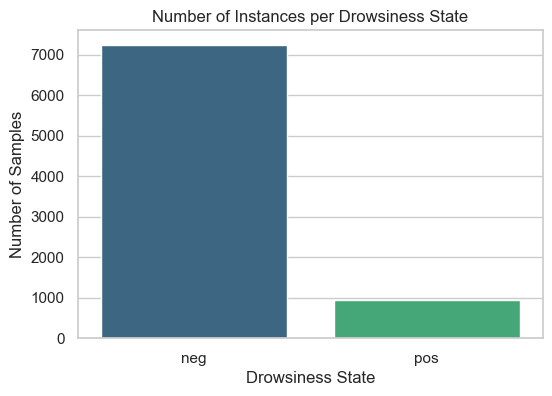

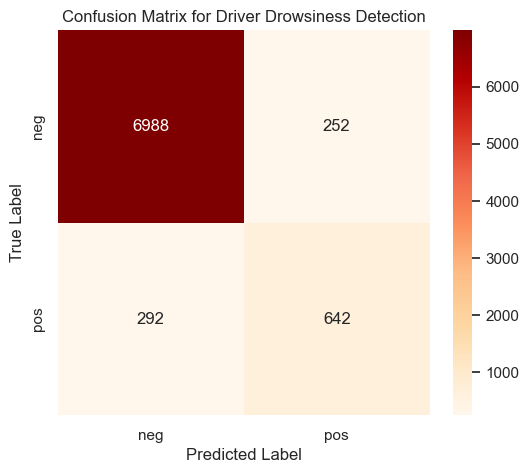

In [17]:
# Generate detailed classification report
generate_detailed_classification_report(model, test_loader, device, classes=['neg', 'pos'])

In [18]:
from scripts.inference.infer import measure_memory_inference

In [19]:
# Example Usage
# Assuming `model` is a PyTorch model and `input_data` is a tensor of appropriate shape
input_data = torch.randn(1, 16, 3, 224, 224)  # Example input for a video sequence model

# Measure memory and time
stats = measure_memory_inference(model, input_data, device)
print(f"Memory and Inference Stats: {stats}")

Memory and Inference Stats: {'cpu_memory_before_mb': 2008.49609375, 'cpu_memory_after_mb': 2106.7421875, 'cpu_memory_delta_mb': 98.24609375, 'gpu_memory_before_mb': 0.0, 'gpu_memory_after_mb': 0.0, 'gpu_memory_delta_mb': 0.0, 'inference_time_s': 0.2505347728729248}


## Export to ONNX

In [24]:
input_data = torch.randn(1, 16, 3, 224, 224).to(device)
torch.onnx.export(model, input_data, "vit_lstm_classifier.onnx")

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\torch\onnx\symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [25]:
import onnx
onnx_model = onnx.load("vit_lstm_classifier.onnx")
onnx.checker.check_model(onnx_model)